In [1]:
%reload_ext autoreload

%autoreload 2

import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob

%aimport -plt
%aimport -np
%aimport -glob
%aimport -cv2

from os import listdir
from os.path import isfile, join

display_chessboards = False
display_undistorts = False
display_example_undistorts = True
%matplotlib inline




In [2]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
nb_dir = os.getcwd()
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import lane_finding
print(dir(lane_finding))


['CentroidFinder', 'LineFinder', 'Undistorter', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'binarise', 'centroid_finder', 'cv2', 'destination_vertices', 'draw_line_of_points', 'identify_lane_curviture', 'identify_lane_position_from_centroids', 'lane_position_finder', 'line_finder', 'line_fitter', 'merge_line_image_and_image', 'normalize_centroids', 'np', 'polynomialize_centroids', 'polynomialize_line', 'rolling_average_tracker', 'scipy', 'test', 'threshold_color', 'threshold_combined_images', 'threshold_sobel', 'threshold_stacked_images', 'thresholder', 'undistorter', 'vertices', 'warp_perspective_for_road', 'warper']


In [3]:
calibration_path = '.\\camera_cal'
calibration_imgs = [cv2.imread(join(calibration_path, f)) for f in listdir(calibration_path) if isfile(join(calibration_path, f))]

undistorter = lane_finding.Undistorter(calibration_imgs)

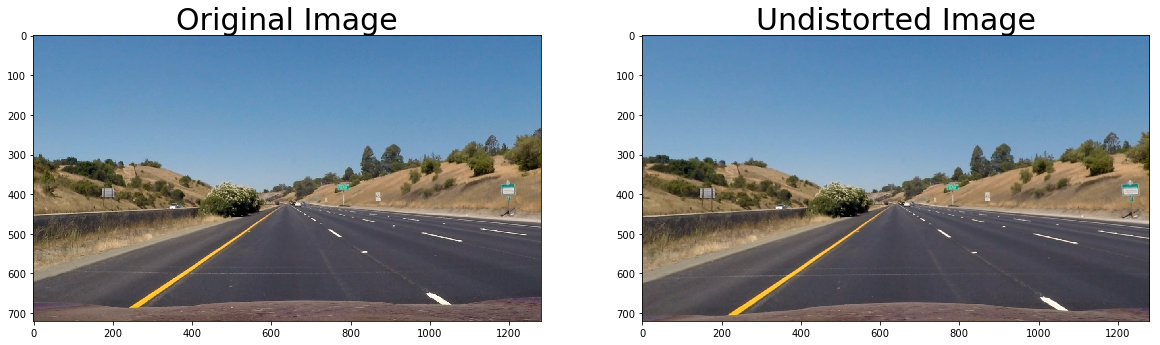

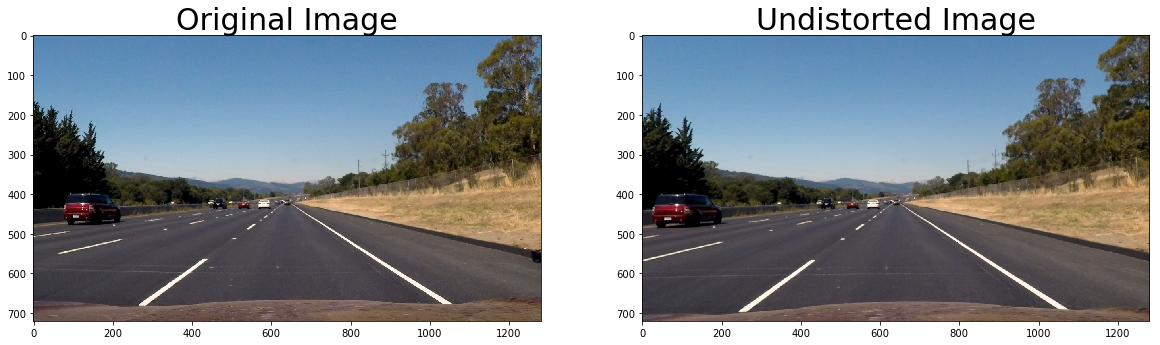

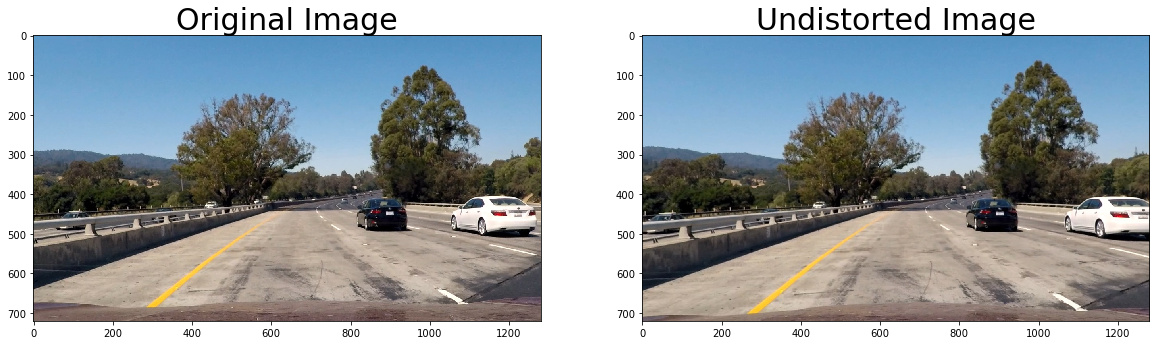

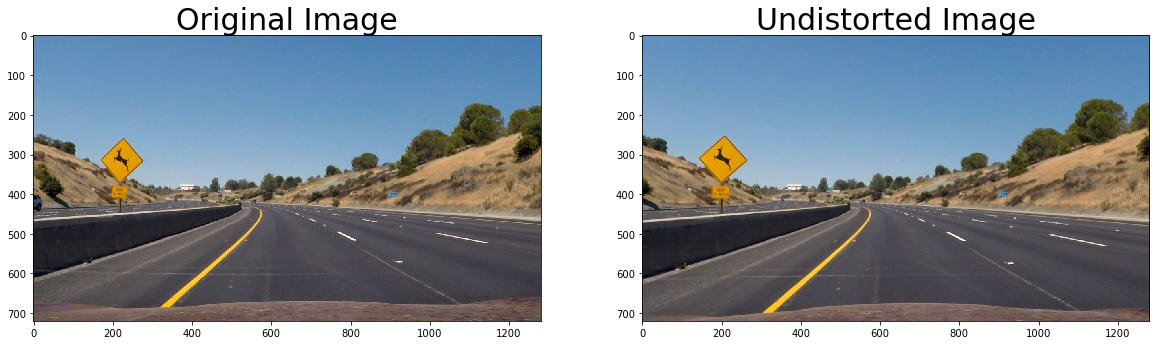

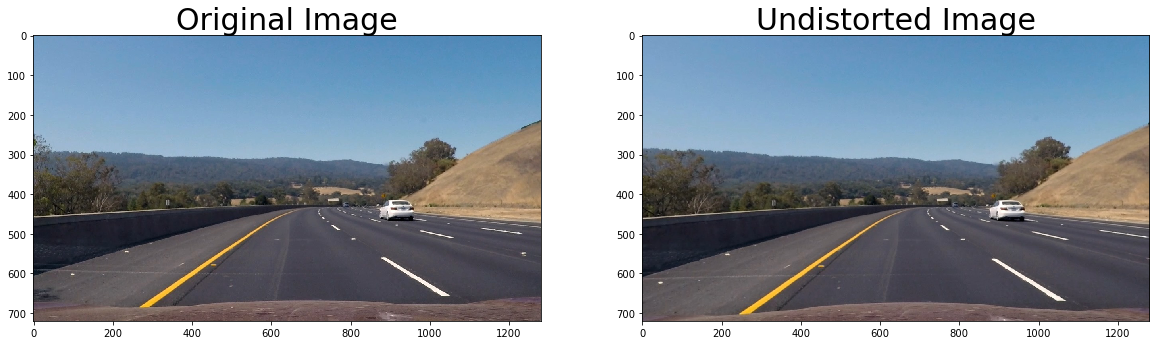

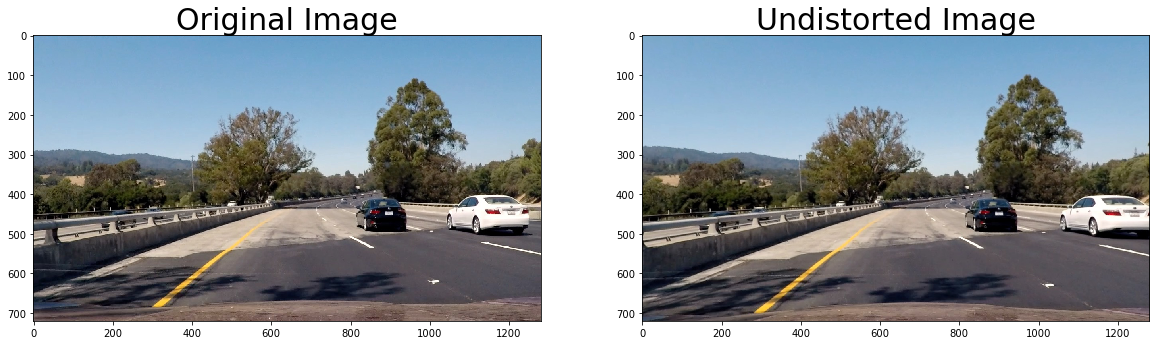

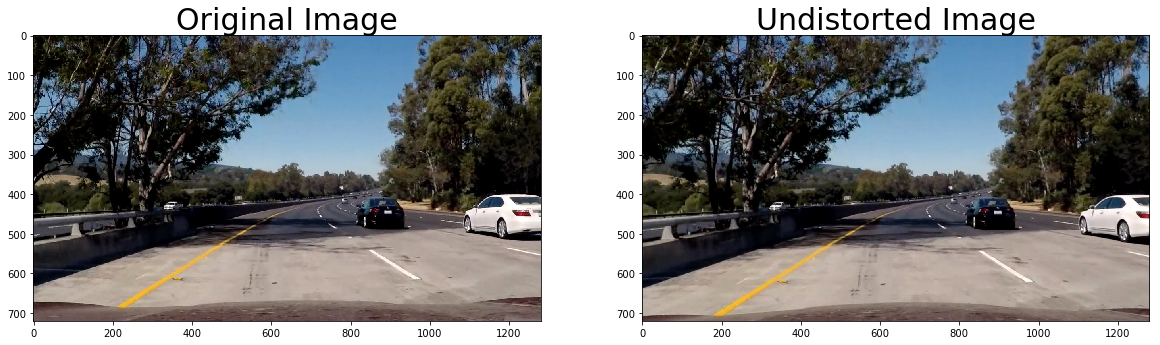

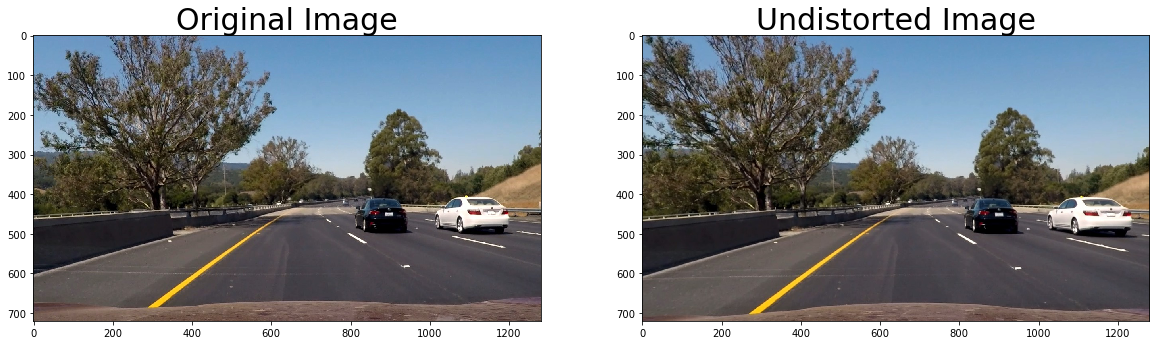

In [4]:
test_path = '.\\test_images'
test_imgs = [cv2.imread(join(test_path, f)) for f in listdir(test_path) if isfile(join(test_path, f))]
undistorted_images = []
for img in test_imgs:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = undistorter.undistort(img)
    undistorted_images.append(dst)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    plt.figure()

In [10]:
def draw_line_of_points(points, line_image, color = (255,0,255)):
    previous_point = None
    for point in points:
        point = (int(point[0]), int(point[1]))
        if previous_point is None:
            previous_point = point
            continue
        cv2.arrowedLine(line_image, previous_point, point, color, 10)
        previous_point = point

def merge_line_image_and_image(img, line_image, α=0.8, β=0.3, λ=0.):
    r_M = cv2.getPerspectiveTransform(destination_vertices(img), vertices(img))
    line_image_s = (line_image.shape[1], img.shape[0])
    r_line_image = cv2.warpPerspective(line_image, r_M, line_image_s, flags=cv2.INTER_LINEAR)    
    return cv2.addWeighted(img, α, r_line_image, β, λ)
    
def wh_for_i(i):
    return (i - 1) * window_height + window_height/2

def normalize_centroids(centroids):
    base = centroids[0][0] # Get x pos of first centroid
    return [(centroid[0] - base, centroid[1]) for centroid in centroids], base

def polynomialize_line(centroids, offset=0):
    x = [centroid[0] for centroid in centroids]
    y = [centroid[1] for centroid in centroids]
    p = np.polyfit(x, y, 2)
    print(p)
    equation = np.poly1d(p)
    return [(offset + equation(centroid[1]), centroid[1]) for centroid in centroids], equation

def polynomialize_centroids(left_centroids, right_centroids):
    left_centroids, left_base = normalize_centroids(left_centroids)
    right_centroids, right_base = normalize_centroids(right_centroids)
    
    left_centroids,l_eq = polynomialize_line(left_centroids, offset = left_base)
    right_centroids, r_eq = polynomialize_line(right_centroids, offset = right_base)
    return left_centroids, right_centroids
    
#     centroids = left_centroids + right_centroids
#     x = [centroid[0] for centroid in centroids]
#     y = [centroid[1] for centroid in centroids]
#     l_p = np.polyfit(x, y, 2)
#     equation = np.poly1d(p)
#     left_centroids = [(left_base + equation(centroid[1]), centroid[1]) for centroid in left_centroids]
#     right_centroids = [(right_base + equation(centroid[1]), centroid[1]) for centroid in right_centroids] 
#     return left_centroids, right_centroids#normalize_centroids(left_centroids), normalize_centroids(right_centroids)

def mix_centroids(new_centroids, previous_centroids, mix_factor = 0.8):
    centroids = []
    change_factor = 0
    for new_point, old_point in zip(new_centroids, previous_centroids):
        x_delta = new_point[0] - old_point[0]
        change_factor = change_factor + x_delta
        x = new_point[0] - (new_point[0] - old_point[0]) * mix_factor
        y = new_point[1] - (new_point[1] - old_point[1]) * mix_factor
        centroids.append((int(x),int(y)))
    return centroids, change_factor

previous_left_centroids = None
previous_right_centroids = None

def restart_state():
    global previous_left_centroids
    global previous_right_centroids
    previous_left_centroids = None
    previous_right_centroids = None

def identify_lines(img, draw_change_factor=False):
    global previous_left_centroids
    global previous_right_centroids
    centroids = find_window_centroids(img, window_width, window_height, margin)
    #out = draw_window_centroids(img, centroids)
    cl = len(centroids)
    left_starting_point =  (int(centroids[0][0]), img.shape[0])
    right_starting_point =  (int(centroids[0][1]), img.shape[0])

    left_centroids = [left_starting_point] + [(int(level[0]),int(wh_for_i(cl-i))) for i, level in enumerate(centroids)]
    right_centroids = [right_starting_point] + [(int(level[1]), int(wh_for_i(cl-i))) for i, level in enumerate(centroids)]
    #img = draw_window_centroids(img, centroids)

    img = np.dstack(( img, np.zeros_like(img), np.zeros_like(img)))
    
    if previous_left_centroids is not None:
        left_centroids, cf_left = mix_centroids(left_centroids, previous_left_centroids)
        right_centroids, cf_right = mix_centroids(right_centroids, previous_right_centroids)
        if draw_change_factor:
            cv2.putText(img,"L: {0}, R: {1}".format(cf_left, cf_right), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
            
    left_centroids, right_centroids = polynomialize_centroids(left_centroids, right_centroids)
    
    draw_line_of_points(left_centroids, img)
    draw_line_of_points(right_centroids, img)
    
    all_points = np.int_([np.concatenate((left_centroids,np.flipud(right_centroids)))])
    cv2.fillPoly(img, all_points, (128,128, 0))
    previous_left_centroids = left_centroids
    previous_right_centroids = right_centroids
    
    lane_position = identify_lane_position_from_centroids(centroids)
    cv2.putText(img,"LP: {0}m off center".format(lane_position), (50,150), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
    
    return img
    
window_width = 50 
window_height = 36 # Break image into 9 vertical layers since image height is 720
margin = 80 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def identify_lane_position_from_centroids(centroids, midpoint=640):
    width_of_lane = 3.7 #metres
    
    left_x_pos = centroids[0][0]
    right_x_pos = centroids[0][1]
    
    width_of_lane_in_pixels = right_x_pos - left_x_pos
    
    pixels_to_meter = width_of_lane_in_pixels
    
    distance_from_midpoint_in_pixels = midpoint - (right_x_pos - left_x_pos) / 2 + left_x_pos
    return  (width_of_lane_in_pixels / width_of_lane) / distance_from_midpoint_in_pixels

previous_l_centers = []
previous_r_centers = []
state = {
    "excluding_l": False,
    "excluding_r": False
}

def find_window_centroids(warped, window_width, window_height, margin):
    global previous_l_centers
    global previous_r_centers
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    
    if np.average(l_sum) < 60: #Heuristic for busy bottom. Indiciates shadows or other artifacts. Ignore if their.
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        previous_l_centers.append(l_center)
        previous_l_centers = previous_l_centers[-5:]

    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)

    if np.average(r_sum) < 60: #Heuristic for busy bottom. Indiciates shadows or other artifacts. Ignore if their.
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
        previous_r_centers.append(r_center)
        previous_r_centers = previous_r_centers[-5:]
    
    state['excluding_l'] = np.average(r_sum) > 40
    state['excluding_r'] = np.average(l_sum) > 40
        
    l_center = np.average(previous_l_centers)
    r_center = np.average(previous_r_centers)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        subsection = conv_signal[l_min_index:l_max_index]
        if len(subsection) != 0:
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])
        else:
            l_center = margin
        
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        subsection = conv_signal[r_min_index:r_max_index]
        if len(subsection) != 0:
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])
        else:
            r_center = margin
            
        if l_center == 0 and r_center == 0:
            l_center = margin
            r_center = margin
        elif l_center == 0:
            l_center = r_center
        elif r_center == 0:
            r_center = l_center
            
        l_center = l_center+l_min_index-offset
        r_center = r_center+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def draw_window_centroids(warped, window_centroids):
    print(window_centroids)
    print(warped.shape)
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 128
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
            
        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        print("skipping")
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    return output

def handle_image_func():
    line_identifier = lane_finding.LineFinder()
    
    def handle_image(img):
        warped = lane_finding.warp_perspective_for_road(img)
        
        thresheld_img =  lane_finding.threshold_combined_images(warped)

        lines = line_identifier.identify_lines(thresheld_img)
        result = lane_finding.merge_line_image_and_image(img, lines) 
        
        return result
    return handle_test_image
    
def pad_channels_and_merge_images(images):
    def pad(img):
        if len(img.shape) == 2:
            return np.dstack(( img, img, img))
        return img
    return np.hstack([pad(img) for img in images])

def handle_test_image_func():
    line_identifier = lane_finding.LineFinder()
    
    def handle_test_image(img):

        warped = lane_finding.warp_perspective_for_road(img)
        
        thresheld_img =  lane_finding.threshold_combined_images(warped)
        thresheld_img_stacked = lane_finding.threshold_stacked_images(warped)

        lines = line_identifier.identify_lines(thresheld_img)
        result = lane_finding.merge_line_image_and_image(img, lines) 

        cv2.putText(thresheld_img_stacked,"L: {0}".format(state["excluding_l"]), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
        cv2.putText(thresheld_img_stacked,"R: {0}".format(state["excluding_r"]), (50,250), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)

        return pad_channels_and_merge_images([warped, thresheld_img_stacked, lines, result]) 
    return handle_test_image

def handle_threshold_image(img):
    warped = warp_perspective_for_road(img)
    thresheld_img = threshold_images(warped, image='stacked')
    #lines = identify_lines(thresheld_img)
    #result = merge_line_image_and_image(img, lines)
    return thresheld_img

def handle_lines_image(img):
    try:
        warped = warp_perspective_for_road(img)
        thresheld_img = threshold_images(warped)
        lines = identify_lines(thresheld_img, draw_change_factor=True)
        return lines
    except Exception as e:
        print("Exception")
        return img
    #result = merge_line_image_and_image(img, lines)
    #lines = np.array(cv2.merge((lines,lines,lines)),np.uint8)
    return lines

In [6]:
def show_image(img, title=''):
    plt.imshow(img)
    fig = plt.figure()
    fig.suptitle(title)

0.00813151041667
0.0266482204861
Shape1 (720, 1280, 3)
Shape2 (720, 1280)
[  3.56882667e-05  -9.87949672e-02   4.78031100e+01]
[ -9.14621711e-05   1.63283841e-01  -7.98373975e+01]
lane curve
[(299.0363636363636, 702), (300.83540669856455, 666), (302.72695374800634, 630), (304.71100478468895, 594), (306.7875598086124, 558), (308.95661881977668, 522), (311.21818181818179, 486), (313.57224880382773, 450), (316.01881977671451, 414), (318.55789473684212, 378), (321.18947368421055, 342), (323.91355661881977, 306), (326.73014354066987, 270), (329.63923444976075, 234), (332.64082934609252, 198), (335.73492822966512, 162), (338.92153110047849, 126), (342.2006379585327, 90), (345.57224880382773, 54), (349.03636363636366, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 299.03636364  300.8354067   302.72695375  304.71100478  306.78755981
  308.95661882  311.21818182  313.5722488   316.01881978  318.55789474
  321.18947368  323.91355662  326.73014354  329.6

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.0143348524306
0.0228721788194
Shape1 (720, 1280, 3)
Shape2 (720, 1280)
[ -1.05526513e-04  -4.41336928e-02   6.39617139e+01]
[  1.22887184e-04  -1.53098656e-01   3.60938824e+01]
lane curve
[(307.97597402597398, 702), (314.7617566643882, 666), (321.27401458190928, 630), (327.51274777853723, 594), (333.47795625427204, 558), (339.16964000911366, 522), (344.5877990430622, 486), (349.73243335611755, 450), (354.60354294827977, 414), (359.2011278195489, 378), (363.52518796992479, 342), (367.57572339940759, 306), (371.35273410799726, 270), (374.8562200956938, 234), (378.08618136249714, 198), (381.04261790840735, 162), (383.72552973342448, 126), (386.13491683754842, 90), (388.27077922077922, 54), (390.13311688311688, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 307.97597403  314.76175666  321.27401458  327.51274778  333.47795625
  339.16964001  344.58779904  349.73243336  354.60354295  359.20112782
  363.52518797  367.5757234   371.35273411  374.856

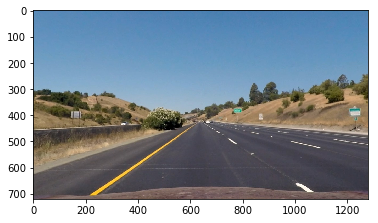

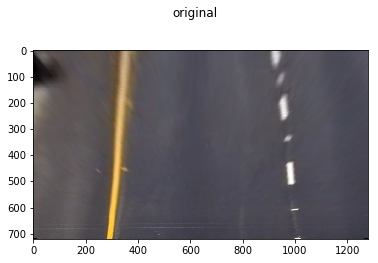

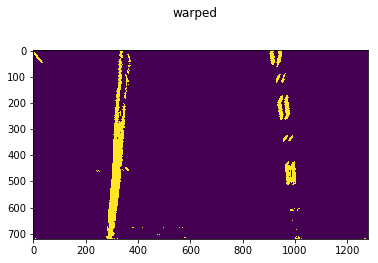

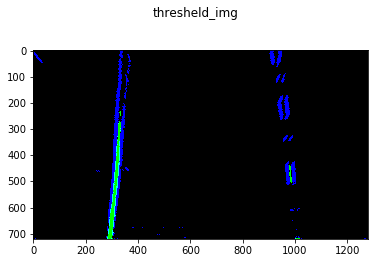

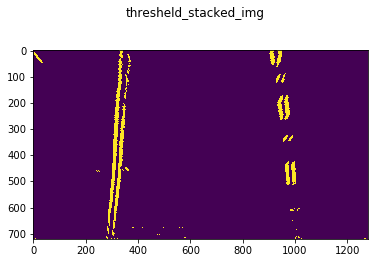

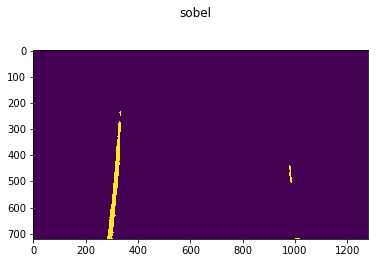

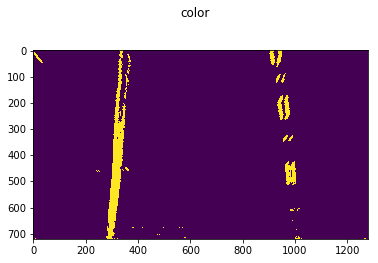

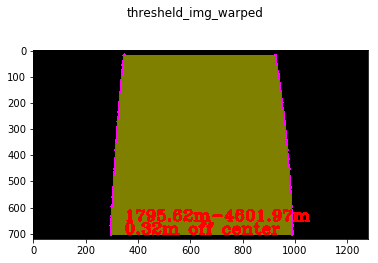

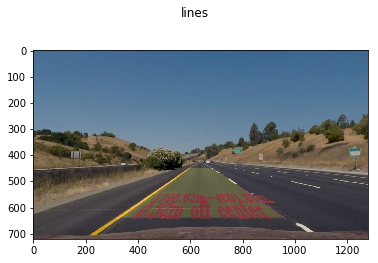

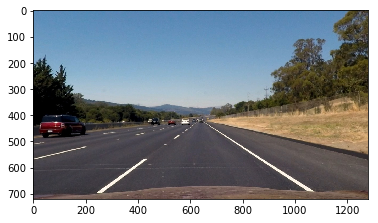

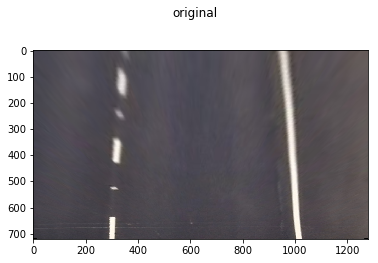

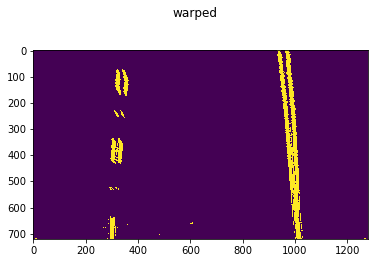

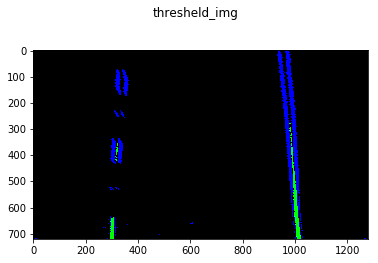

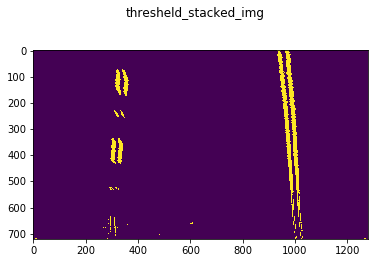

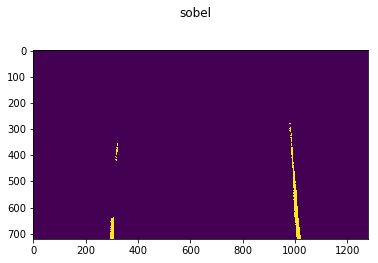

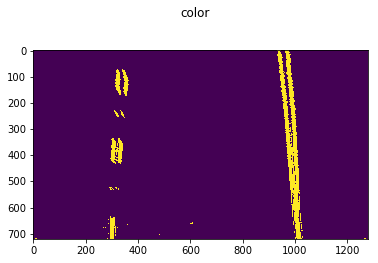

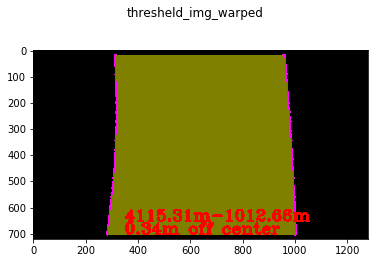

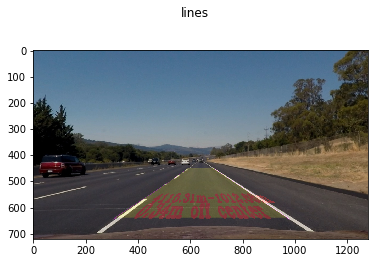

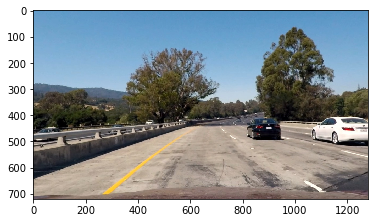

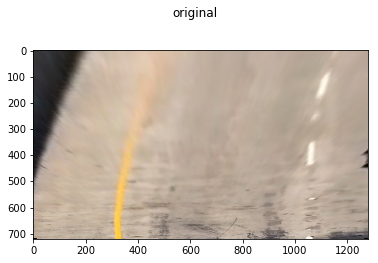

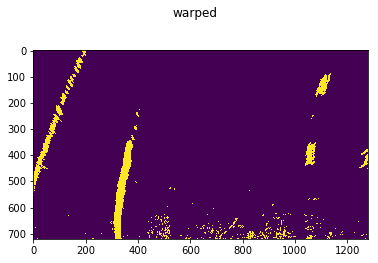

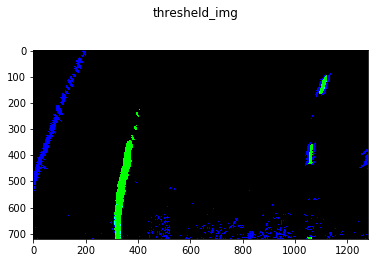

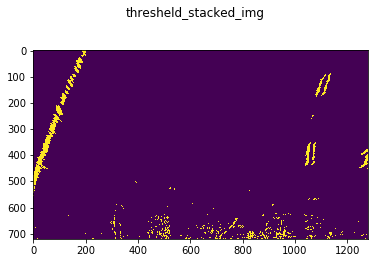

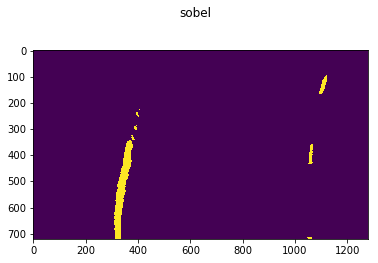

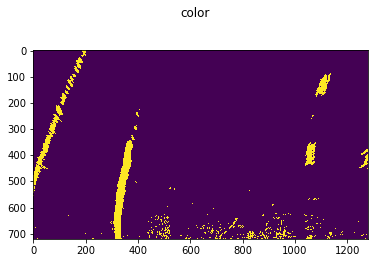

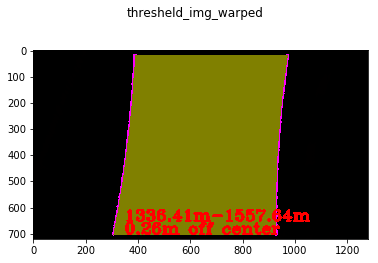

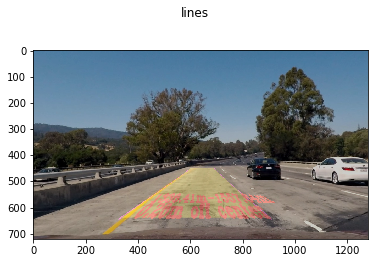

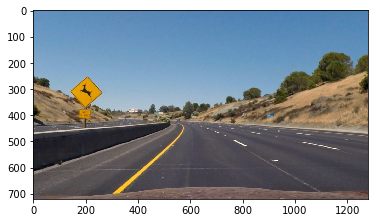

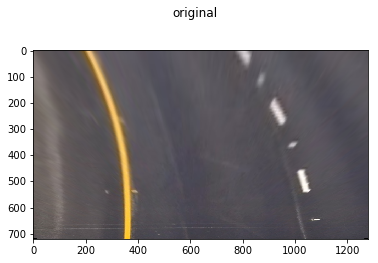

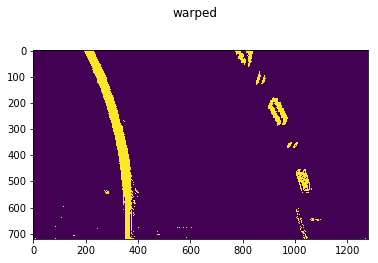

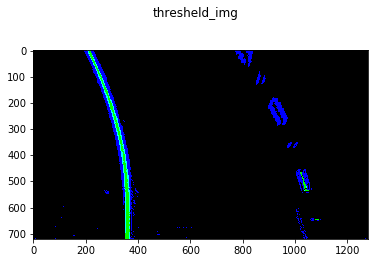

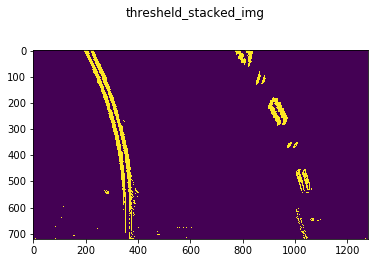

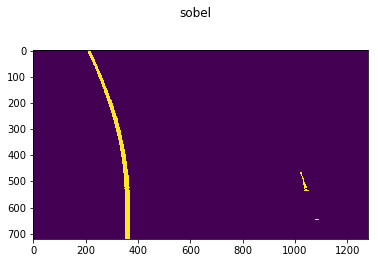

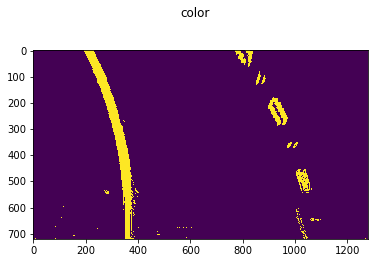

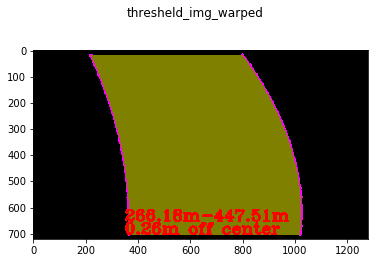

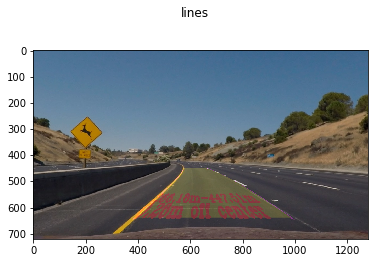

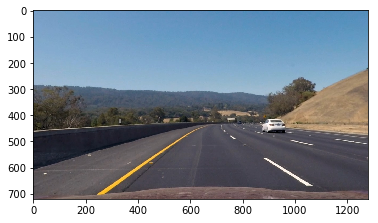

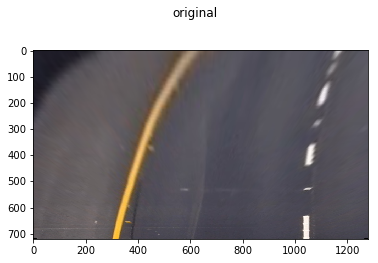

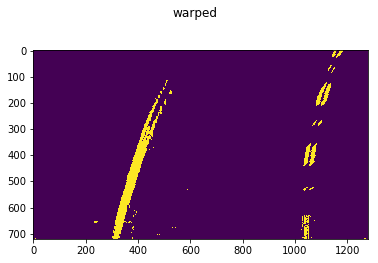

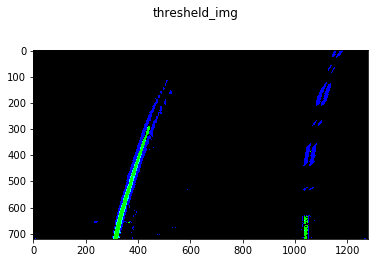

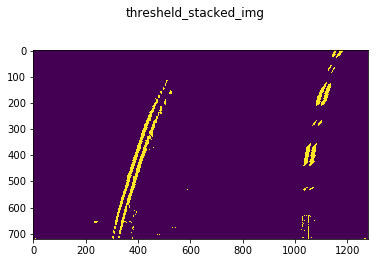

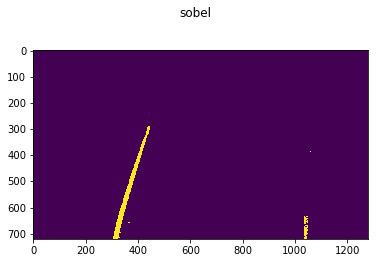

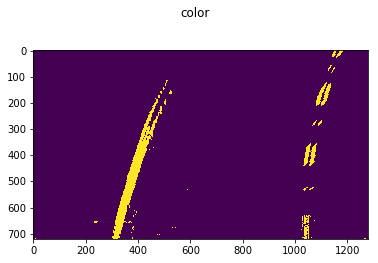

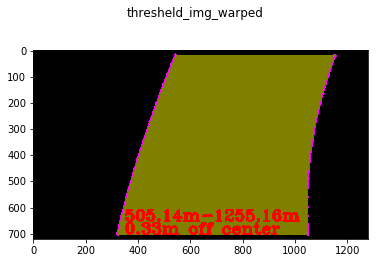

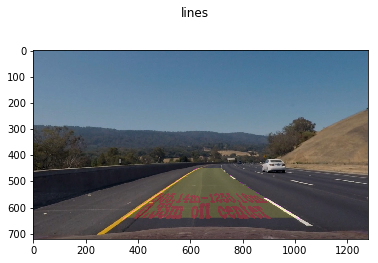

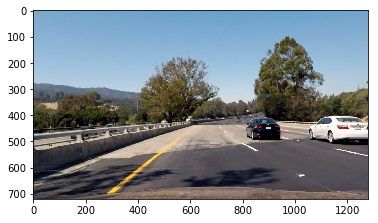

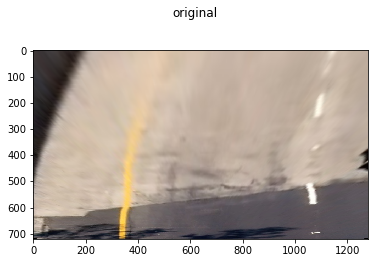

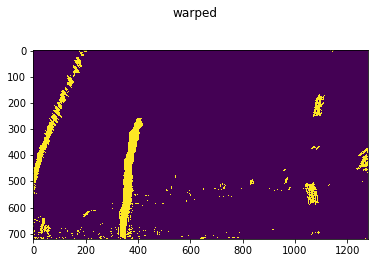

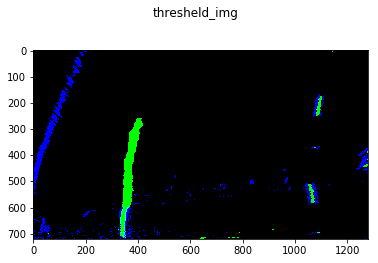

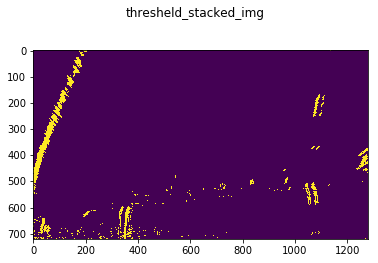

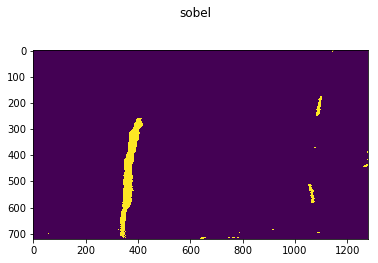

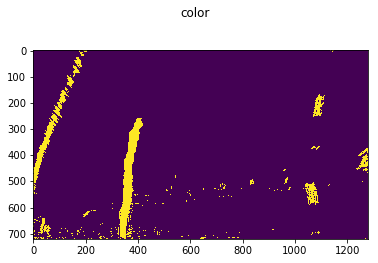

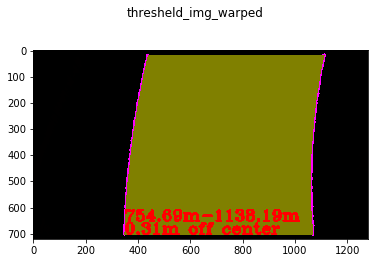

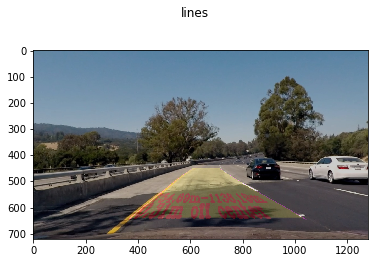

In [7]:
for img in undistorted_images[0:6]:
    restart_state()
    img = img.copy()

    show_image(img,title='original')

    warped = lane_finding.warp_perspective_for_road(img)
   

    show_image(warped,title='warped')

    thresheld_img = lane_finding.threshold_combined_images(warped)
    
    show_image(thresheld_img,title='thresheld_img')

    thresheld_stacked_img = lane_finding.threshold_stacked_images(warped)
    print("Shape1", thresheld_stacked_img.shape)
    print("Shape2", thresheld_img.shape)
    
    show_image(thresheld_stacked_img,title='thresheld_stacked_img')

    
    sobel = lane_finding.threshold_sobel(warped)
    show_image(sobel,title='sobel')

    color = lane_finding.threshold_color(warped)
    show_image(color,title='color')

    thresheld_img = lane_finding.threshold_combined_images(warped)

    show_image(thresheld_img,title='thresheld_img_warped')

    line_identifier = lane_finding.LineFinder()
    lines = line_identifier.identify_lines(thresheld_img)
    
    show_image(lines,title='lines')

    result = lane_finding.merge_line_image_and_image(img, lines)
    plt.imshow(result)
    plt.figure()


In [9]:
from moviepy.editor import VideoFileClip, clips_array

def run_video(input, output):
    clip2 = VideoFileClip(input)
    yellow_clip = clip2.fl_image(handle_image)
    %time yellow_clip.write_videofile(output, audio=False)
    del yellow_clip

def run_test_video(input, output):
    print(input)
    clip1 = VideoFileClip(input).subclip(37, 50)
    result_clip = clip1.fl_image(handle_test_image_func())
    %time result_clip.write_videofile(output, audio=False)
    del result_clip
input = './project_video_2_2.mp4'
output = './project_video_outcome_8.mp4'
try:
    run_video(input, output)
    #run_test_video(input, output)
except Exception as e: 
    raise e

./project_video_2_2.mp4
0.0142523871528
0.0220844184028
[  1.02757595e-04  -3.44703932e-01   1.75348001e+02]
[  2.42785696e-04  -3.24012050e-01   1.07517191e+02]
lane curve
[(309.00519480519461, 702), (316.35393028024595, 666), (323.96901344269759, 630), (331.85044429254947, 594), (339.99822282980176, 558), (348.4123490544543, 522), (357.09282296650719, 486), (366.03964456596032, 450), (375.25281385281386, 414), (384.7323308270677, 378), (394.47819548872184, 342), (404.49040783777627, 306), (414.76896787423107, 270), (425.31387559808616, 234), (436.12513100934154, 198), (447.20273410799729, 162), (458.54668489405333, 126), (470.15698336750972, 90), (482.03362952836636, 54), (494.17662337662335, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 309.00519481  316.35393028  323.96901344  331.85044429  339.99822283
  348.41234905  357.09282297  366.03964457  375.25281385  384.73233083
  394.47819549  404.49040784  414.76896787  425.3138756   436.1251

  0%|                                                                                          | 0/326 [00:00<?, ?it/s]

0.0142523871528
0.0220844184028
[  1.02757595e-04  -3.44703932e-01   1.75348001e+02]
[  2.42785696e-04  -3.24012050e-01   1.07517191e+02]
lane curve
[(309.00519480519461, 702), (316.35393028024595, 666), (323.96901344269759, 630), (331.85044429254947, 594), (339.99822282980176, 558), (348.4123490544543, 522), (357.09282296650719, 486), (366.03964456596032, 450), (375.25281385281386, 414), (384.7323308270677, 378), (394.47819548872184, 342), (404.49040783777627, 306), (414.76896787423107, 270), (425.31387559808616, 234), (436.12513100934154, 198), (447.20273410799729, 162), (458.54668489405333, 126), (470.15698336750972, 90), (482.03362952836636, 54), (494.17662337662335, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 309.00519481  316.35393028  323.96901344  331.85044429  339.99822283
  348.41234905  357.09282297  366.03964457  375.25281385  384.73233083
  394.47819549  404.49040784  414.76896787  425.3138756   436.12513101
  447.20273411  458

  0%|▎                                                                                 | 1/326 [00:00<00:54,  5.92it/s]

0.0137803819444
0.0203157552083
[  8.04744043e-05  -3.23584846e-01   1.70843259e+02]
[  2.20942016e-04  -3.09683932e-01   1.05881297e+02]
lane curve
[(307.34480519480508, 702), (315.03065618591927, 666), (322.92509683299147, 630), (331.02812713602179, 594), (339.33974709501024, 558), (347.85995670995669, 522), (356.58875598086127, 486), (365.52614490772385, 450), (374.67212349054455, 414), (384.02669172932332, 378), (393.58984962406021, 342), (403.3615971747551, 306), (413.34193438140812, 270), (423.53086124401921, 234), (433.92837776258835, 198), (444.53448393711557, 162), (455.34917976760084, 126), (466.37246525404424, 90), (477.60434039644571, 54), (489.04480519480524, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 307.34480519  315.03065619  322.92509683  331.02812714  339.3397471
  347.85995671  356.58875598  365.52614491  374.67212349  384.02669173
  393.58984962  403.36159717  413.34193438  423.53086124  433.92837776
  444.53448394  455

  1%|▌                                                                                 | 2/326 [00:00<00:54,  5.94it/s]

0.0142708333333
0.0190147569444
[  5.16425041e-05  -2.97938660e-01   1.65789670e+02]
[  2.09514738e-04  -2.98281689e-01   1.03949889e+02]
lane curve
[(305.08636363636361, 702), (313.2688653451811, 666), (321.58522442469814, 630), (330.03544087491457, 594), (338.6195146958305, 558), (347.33744588744594, 522), (356.18923444976076, 486), (365.17488038277514, 450), (374.29438368648897, 414), (383.54774436090224, 378), (392.93496240601507, 342), (402.45603782182729, 306), (412.11097060833902, 270), (421.89976076555024, 234), (431.82240829346091, 198), (441.87891319207108, 162), (452.0692754613807, 126), (462.39349510138982, 90), (472.85157211209838, 54), (483.44350649350645, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 305.08636364  313.26886535  321.58522442  330.03544087  338.6195147
  347.33744589  356.18923445  365.17488038  374.29438369  383.54774436
  392.93496241  402.45603782  412.11097061  421.89976077  431.82240829
  441.87891319  452.0

  1%|▊                                                                                 | 3/326 [00:00<00:54,  5.89it/s]

0.0135731336806
0.0305935329861
[  8.96162263e-05  -3.30166958e-01   1.71834099e+02]
[  2.10393759e-04  -3.02047417e-01   1.05053751e+02]
lane curve
[(306.22012987012977, 702), (313.69272043745718, 666), (321.39759626338565, 630), (329.33475734791512, 594), (337.50420369104575, 558), (345.90593529277737, 522), (354.53995215310999, 486), (363.40625427204372, 450), (372.50484164957845, 414), (381.83571428571429, 378), (391.39887218045112, 342), (401.19431533378901, 306), (411.22204374572794, 270), (421.48205741626793, 234), (431.97435634540898, 198), (442.69894053315107, 162), (453.65580997949417, 126), (464.84496468443837, 90), (476.26640464798356, 54), (487.92012987012981, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 306.22012987  313.69272044  321.39759626  329.33475735  337.50420369
  345.90593529  354.53995215  363.40625427  372.50484165  381.83571429
  391.39887218  401.19431533  411.22204375  421.48205742  431.97435635
  442.69894053  4

  1%|█                                                                                 | 4/326 [00:00<00:54,  5.87it/s]

0.0135264756944
0.0297157118056
[  1.14228824e-04  -3.53777752e-01   1.77683587e+02]
[  2.13426383e-04  -3.04836586e-01   1.05084142e+02]
lane curve
[(306.62402597402587, 702), (313.73448393711544, 666), (321.14102301207561, 630), (328.84364319890631, 594), (336.84234449760766, 558), (345.13712690817954, 522), (353.72799043062201, 486), (362.61493506493508, 450), (371.79796081111874, 414), (381.27706766917299, 378), (391.05225563909778, 342), (401.12352472089322, 306), (411.49087491455919, 270), (422.15430622009575, 234), (433.11381863750285, 198), (444.36941216678065, 162), (455.92108680792893, 126), (467.76884256094786, 90), (479.91267942583727, 54), (492.35259740259733, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 306.62402597  313.73448394  321.14102301  328.8436432   336.8423445
  345.13712691  353.72799043  362.61493506  371.79796081  381.27706767
  391.05225564  401.12352472  411.49087491  422.15430622  433.11381864
  444.36941217  45

  2%|█▎                                                                                | 5/326 [00:00<00:54,  5.85it/s]

0.01498046875
0.0284917534722
[  1.39456737e-04  -3.78458140e-01   1.84111868e+02]
[  2.41071604e-04  -3.26808815e-01   1.07670036e+02]
lane curve
[(307.15909090909071, 702), (313.91561859193416, 666), (321.03361813624957, 630), (328.51308954203682, 594), (336.35403280929586, 558), (344.55644793802685, 522), (353.12033492822962, 486), (362.0456937799043, 450), (371.33252449305081, 414), (380.98082706766917, 378), (390.99060150375942, 342), (401.36184780132152, 306), (412.09456596035545, 270), (423.18875598086129, 234), (434.64441786283896, 198), (446.46155160628848, 162), (458.6401572112099, 126), (471.18023467760315, 90), (484.08178400546825, 54), (497.34480519480519, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 307.15909091  313.91561859  321.03361814  328.51308954  336.35403281
  344.55644794  353.12033493  362.04569378  371.33252449  380.98082707
  390.9906015   401.3618478   412.09456596  423.18875598  434.64441786
  446.46155161  458.6

  2%|█▌                                                                                | 6/326 [00:01<00:54,  5.85it/s]

0.0147981770833
0.0297721354167
[  1.63585873e-04  -4.00321511e-01   1.88665772e+02]
[  2.38874051e-04  -3.28150553e-01   1.07832562e+02]
lane curve
[(308.25584415584399, 702), (314.61114149008876, 666), (321.39045340624284, 630), (328.59377990430619, 594), (336.22112098427885, 558), (344.27247664616084, 522), (352.74784688995214, 486), (361.64723171565277, 450), (370.97063112326271, 414), (380.71804511278197, 378), (390.88947368421054, 342), (401.48491683754844, 306), (412.50437457279565, 270), (423.94784688995219, 234), (435.81533378901804, 198), (448.10683526999321, 162), (460.8223513328777, 126), (473.96188197767145, 90), (487.52542720437458, 54), (501.51298701298697, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 308.25584416  314.61114149  321.39045341  328.5937799   336.22112098
  344.27247665  352.74784689  361.64723172  370.97063112  380.71804511
  390.88947368  401.48491684  412.50437457  423.94784689  435.81533379
  448.10683527  46

  2%|█▊                                                                                | 7/326 [00:01<00:54,  5.87it/s]

0.0136284722222
0.0279470486111
[  1.67453567e-04  -4.05361890e-01   1.91212389e+02]
[  2.57816961e-04  -3.40598972e-01   1.08892703e+02]
lane curve
[(309.1701298701297, 702), (315.51640464798345, 666), (322.29671907040319, 630), (329.51107313738885, 594), (337.1594668489405, 558), (345.24190020505807, 522), (353.75837320574158, 486), (362.70888585099112, 450), (372.0934381408066, 414), (381.912030075188, 378), (392.16466165413533, 342), (402.8513328776487, 306), (413.972043745728, 270), (425.52679425837323, 234), (437.51558441558444, 198), (449.93841421736164, 162), (462.79528366370477, 126), (476.08619275461388, 90), (489.81114149008886, 54), (503.97012987012988, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 309.17012987  315.51640465  322.29671907  329.51107314  337.15946685
  345.24190021  353.75837321  362.70888585  372.09343814  381.91203008
  392.16466165  402.85133288  413.97204375  425.52679426  437.51558442
  449.93841422  462.79528

  2%|██                                                                                | 8/326 [00:01<00:54,  5.88it/s]

0.0141905381944
0.0320735677083
[  1.77298606e-04  -4.13494595e-01   1.93340003e+02]
[  2.70255113e-04  -3.51329713e-01   1.11857801e+02]
lane curve
[(310.44025974025959, 702), (316.59446343130543, 666), (323.20822510822507, 630), (330.28154477101839, 594), (337.81442241968557, 558), (345.8068580542265, 522), (354.25885167464122, 486), (363.17040328092969, 450), (372.5415128730919, 414), (382.37218045112792, 378), (392.66240601503773, 342), (403.41218956482123, 306), (414.62153110047859, 270), (426.29043062200969, 234), (438.41888812941454, 198), (451.00690362269313, 162), (464.05447710184558, 126), (477.56160856687177, 90), (491.5282980177717, 54), (505.95454545454538, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 310.44025974  316.59446343  323.20822511  330.28154477  337.81442242
  345.80685805  354.25885167  363.17040328  372.54151287  382.37218045
  392.66240602  403.41218956  414.6215311   426.29043062  438.41888813
  451.00690362  464.

  3%|██▎                                                                               | 9/326 [00:01<00:53,  5.90it/s]

0.0147710503472
0.0280631510417
[  1.98790678e-04  -4.33626364e-01   1.97725931e+02]
[  2.87308127e-04  -3.67743222e-01   1.15121745e+02]
lane curve
[(312.28506493506484, 702), (318.10557074504425, 666), (324.44134199134191, 630), (331.29237867395756, 594), (338.65868079289123, 558), (346.54024834814311, 522), (354.9370813397129, 486), (363.84917976760084, 450), (373.27654363180682, 414), (383.21917293233088, 378), (393.67706766917297, 342), (404.65022784233315, 306), (416.13865345181142, 270), (428.14234449760772, 234), (440.66130097972211, 198), (453.69552289815454, 162), (467.24501025290505, 126), (481.30976304397359, 90), (495.88978127136022, 54), (510.98506493506494, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 312.28506494  318.10557075  324.44134199  331.29237867  338.65868079
  346.54024835  354.93708134  363.84917977  373.27654363  383.21917293
  393.67706767  404.65022784  416.13865345  428.1423445   440.66130098
  453.6955229   46

  3%|██▍                                                                              | 10/326 [00:01<00:53,  5.90it/s]

0.0142122395833
0.0268782552083
[  2.07844597e-04  -4.42275512e-01   1.99876085e+02]
[  2.87615785e-04  -3.67902078e-01   1.15775803e+02]
lane curve
[(313.82532467532451, 702), (319.51131237183859, 666), (325.73603326498051, 630), (332.49948735475044, 594), (339.80167464114828, 558), (347.64259512417402, 522), (356.02224880382778, 486), (364.94063568010938, 450), (374.39775575301894, 414), (384.39360902255646, 378), (394.92819548872183, 342), (406.00151515151521, 306), (417.61356801093649, 270), (429.76435406698567, 234), (442.45387331966282, 198), (455.68212576896792, 162), (469.44911141490093, 126), (483.75483025746189, 90), (498.5992822966507, 54), (513.98246753246747, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 313.82532468  319.51131237  325.73603326  332.49948735  339.80167464
  347.64259512  356.0222488   364.94063568  374.39775575  384.39360902
  394.92819549  406.00151515  417.61356801  429.76435407  442.45387332
  455.68212577  46

  3%|██▋                                                                              | 11/326 [00:01<00:53,  5.89it/s]

0.0145486111111
0.0236490885417
[  1.93472598e-04  -4.29525835e-01   1.97318131e+02]
[  2.92977815e-04  -3.74352548e-01   1.18571992e+02]
lane curve
[(314.13506493506486, 702), (320.06985645933008, 666), (326.50612895876048, 630), (333.44388243335607, 594), (340.88311688311683, 558), (348.82383230804282, 522), (357.266028708134, 486), (366.2097060833903, 450), (375.65486443381189, 414), (385.60150375939855, 378), (396.04962406015045, 342), (406.99922533606752, 306), (418.45030758714972, 270), (430.40287081339716, 234), (442.85691501480983, 198), (455.81244019138762, 162), (469.2694463431306, 126), (483.22793347003875, 90), (497.68790157211208, 54), (512.64935064935071, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 314.13506494  320.06985646  326.50612896  333.44388243  340.88311688
  348.82383231  357.26602871  366.20970608  375.65486443  385.60150376
  396.04962406  406.99922534  418.45030759  430.40287081  442.85691501
  455.81244019  469.2

  4%|██▉                                                                              | 12/326 [00:02<00:54,  5.74it/s]

0.0139105902778
0.0212651909722
[  1.86923889e-04  -4.24998734e-01   1.96869284e+02]
[  2.81462635e-04  -3.65017341e-01   1.16999897e+02]
lane curve
[(314.63701298701289, 702), (320.73133971291855, 666), (327.31017316017306, 630), (334.37351332877643, 594), (341.92136021872858, 558), (349.95371383002959, 522), (358.47057416267944, 486), (367.47194121667803, 450), (376.95781499202553, 414), (386.92819548872183, 378), (397.38308270676697, 342), (408.32247664616091, 306), (419.74637730690364, 270), (431.65478468899528, 234), (444.04769879243565, 198), (456.92511961722494, 162), (470.28704716336301, 126), (484.13348143084988, 90), (498.4644224196856, 54), (513.27987012987012, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 314.63701299  320.73133971  327.31017316  334.37351333  341.92136022
  349.95371383  358.47057416  367.47194122  376.95781499  386.92819549
  397.38308271  408.32247665  419.74637731  431.65478469  444.04769879
  456.92511962  47

  4%|███▏                                                                             | 13/326 [00:02<00:54,  5.71it/s]

0.0141124131944
0.0183083767361
[  1.53740834e-04  -3.91604010e-01   1.88627632e+02]
[  2.86209351e-04  -3.72820941e-01   1.19289474e+02]
lane curve
[(314.48571428571404, 702), (321.01203007518779, 666), (327.93684210526305, 630), (335.26015037593976, 594), (342.98195488721797, 558), (351.10225563909773, 522), (359.62105263157895, 486), (368.53834586466166, 450), (377.85413533834594, 414), (387.56842105263161, 378), (397.68120300751889, 342), (408.19248120300756, 306), (419.10225563909779, 270), (430.41052631578953, 234), (442.11729323308276, 198), (454.2225563909775, 162), (466.72631578947369, 126), (479.62857142857143, 90), (492.92932330827068, 54), (506.62857142857138, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 314.48571429  321.01203008  327.93684211  335.26015038  342.98195489
  351.10225564  359.62105263  368.53834586  377.85413534  387.56842105
  397.68120301  408.1924812   419.10225564  430.41052632  442.11729323
  454.22255639  46

  4%|███▍                                                                             | 14/326 [00:02<00:54,  5.76it/s]

0.01353515625
0.0188042534722
[  1.42884920e-04  -3.82221336e-01   1.86474598e+02]
[  2.80935222e-04  -3.72407028e-01   1.21151265e+02]
lane curve
[(314.56948051948041, 702), (321.29265208475726, 666), (328.38618136249704, 630), (335.85006835269985, 594), (343.68431305536564, 558), (351.88891547049434, 522), (360.46387559808613, 486), (369.40919343814079, 450), (378.72486899065848, 414), (388.41090225563909, 378), (398.46729323308273, 342), (408.89404192298929, 306), (419.69114832535888, 270), (430.85861244019139, 234), (442.39643426748694, 198), (454.3046138072454, 162), (466.58315105946684, 126), (479.23204602415126, 90), (492.25129870129871, 54), (505.64090909090908, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 314.56948052  321.29265208  328.38618136  335.85006835  343.68431306
  351.88891547  360.4638756   369.40919344  378.72486899  388.41090226
  398.46729323  408.89404192  419.69114833  430.85861244  442.39643427
  454.30461381  466.

  5%|███▋                                                                             | 15/326 [00:02<00:53,  5.80it/s]

0.0130902777778
0.0290831163194
[  1.66706398e-04  -4.05513152e-01   1.91445873e+02]
[  2.87483931e-04  -3.79106225e-01   1.22282066e+02]
lane curve
[(315.92922077922066, 702), (322.3177375256322, 666), (329.13835725677825, 630), (336.39107997265887, 594), (344.07590567327406, 558), (352.19283435862383, 522), (360.74186602870816, 486), (369.72300068352706, 450), (379.13623832308053, 414), (388.98157894736846, 378), (399.25902255639107, 342), (409.9685691501482, 306), (421.11021872863989, 270), (432.6839712918661, 234), (444.68982683982694, 198), (457.12778537252234, 162), (469.99784688995226, 126), (483.30001139211674, 90), (497.0342788790158, 54), (511.20064935064943, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 315.92922078  322.31773753  329.13835726  336.39107997  344.07590567
  352.19283436  360.74186603  369.72300068  379.13623832  388.98157895
  399.25902256  409.96856915  421.11021873  432.68397129  444.68982684
  457.12778537  469.9

  5%|███▉                                                                             | 16/326 [00:02<00:52,  5.85it/s]

0.0136154513889
0.0309874131944
[  1.83539657e-04  -4.21872864e-01   1.94178401e+02]
[  2.99834181e-04  -3.92447027e-01   1.25101965e+02]
lane curve
[(316.47272727272713, 702), (322.62118933697866, 666), (329.24538619275449, 630), (336.34531784005458, 594), (343.9209842788789, 558), (351.97238550922759, 522), (360.49952153110041, 486), (369.50239234449759, 450), (378.98099794941902, 414), (388.93533834586469, 378), (399.36541353383461, 342), (410.27122351332878, 306), (421.65276828434725, 270), (433.51004784688996, 234), (445.84306220095698, 198), (458.65181134654824, 162), (471.93629528366375, 126), (485.69651401230351, 90), (499.93246753246751, 54), (514.64415584415588, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 316.47272727  322.62118934  329.24538619  336.34531784  343.92098428
  351.97238551  360.49952153  369.50239234  378.98099795  388.93533835
  399.36541353  410.27122351  421.65276828  433.51004785  445.8430622
  458.65181135  471

  5%|████▏                                                                            | 17/326 [00:02<00:52,  5.85it/s]

0.0137467447917
0.0289192708333
[  2.08196206e-04  -4.46956406e-01   1.99300487e+02]
[  3.08888101e-04  -3.99132933e-01   1.27045352e+02]
lane curve
[(317.13701298701289, 702), (322.97419685577574, 666), (329.35102529049891, 630), (336.26749829118245, 594), (343.72361585782636, 558), (351.71937799043059, 522), (360.25478468899519, 486), (369.32983595352016, 450), (378.94453178400545, 414), (389.09887218045111, 378), (399.79285714285714, 342), (411.02648667122355, 306), (422.79976076555022, 270), (435.11267942583731, 234), (447.96524265208473, 198), (461.35745044429251, 162), (475.28930280246067, 126), (489.76079972658914, 90), (504.77194121667799, 54), (520.32272727272721, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 317.13701299  322.97419686  329.35102529  336.26749829  343.72361586
  351.71937799  360.25478469  369.32983595  378.94453178  389.09887218
  399.79285714  411.02648667  422.79976077  435.11267943  447.96524265
  461.35745044  4

  6%|████▍                                                                            | 18/326 [00:03<00:53,  5.80it/s]

0.0154806857639
0.0296701388889
[  2.35094259e-04  -4.67367282e-01   2.00703324e+02]
[  2.93681032e-04  -3.99211412e-01   1.29599744e+02]
lane curve
[(318.46688311688297, 702), (323.7141831852357, 666), (329.57084757347911, 630), (336.0368762816131, 594), (343.11226930963767, 558), (350.79702665755292, 522), (359.09114832535886, 486), (367.99463431305537, 450), (377.50748462064257, 414), (387.62969924812035, 378), (398.36127819548875, 342), (409.70222146274784, 306), (421.65252904989751, 270), (434.21220095693786, 234), (447.38123718386879, 198), (461.15963773069041, 162), (475.54740259740265, 126), (490.54453178400547, 90), (506.15102529049898, 54), (522.36688311688306, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 318.46688312  323.71418319  329.57084757  336.03687628  343.11226931
  350.79702666  359.09114833  367.99463431  377.50748462  387.62969925
  398.3612782   409.70222146  421.65252905  434.21220096  447.38123718
  461.15963773  475

  6%|████▋                                                                            | 19/326 [00:03<00:53,  5.79it/s]

0.0148079427083
0.0229958767361
[  2.47180803e-04  -4.80225817e-01   2.03895147e+02]
[  3.01152713e-04  -4.08225108e-01   1.31954375e+02]
lane curve
[(318.58831168831148, 702), (323.70328092959659, 666), (329.45894281157427, 630), (335.8552973342446, 594), (342.89234449760761, 558), (350.5700843016632, 522), (358.88851674641148, 486), (367.84764183185234, 450), (377.44745955798589, 414), (387.68796992481208, 378), (398.56917293233084, 342), (410.0910685805423, 306), (422.25365686944639, 270), (435.05693779904311, 234), (448.50091136933247, 198), (462.58557758031446, 162), (477.31093643198903, 126), (492.67698792435635, 90), (508.68373205741625, 54), (525.33116883116872, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 318.58831169  323.70328093  329.45894281  335.85529733  342.8923445
  350.5700843   358.88851675  367.84764183  377.44745956  387.68796992
  398.56917293  410.09106858  422.25365687  435.0569378   448.50091137
  462.58557758  477.3

  6%|████▉                                                                            | 20/326 [00:03<00:53,  5.77it/s]

0.0148079427083
0.029833984375
[  2.47488460e-04  -4.81637807e-01   2.04800333e+02]
[  3.00669252e-04  -4.08858636e-01   1.33315935e+02]
lane curve
[(318.65389610389599, 702), (323.80454545454535, 666), (329.59668489405323, 630), (336.03031442241962, 594), (343.10543403964454, 558), (350.82204374572797, 522), (359.18014354066986, 486), (368.17973342447033, 450), (377.8208133971292, 414), (388.1033834586467, 378), (399.02744360902261, 342), (410.59299384825704, 306), (422.80003417634998, 270), (435.64856459330144, 234), (449.13858509911142, 198), (463.27009569377992, 162), (478.04309637730694, 126), (493.45758714969236, 90), (509.51356801093641, 54), (526.21103896103887, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 318.6538961   323.80454545  329.59668489  336.03031442  343.10543404
  350.82204375  359.18014354  368.17973342  377.8208134   388.10338346
  399.02744361  410.59299385  422.80003418  435.64856459  449.1385851
  463.27009569  478.0

  6%|█████▏                                                                           | 21/326 [00:03<00:52,  5.84it/s]

0.0146473524306
0.0309895833333
[  2.49554160e-04  -4.82811828e-01   2.04516251e+02]
[  2.95570928e-04  -4.07568796e-01   1.35132032e+02]
lane curve
[(318.56363636363619, 702), (323.65481886534502, 666), (329.39284575074038, 630), (335.77771701982221, 594), (342.8094326725905, 558), (350.48799270904533, 522), (358.81339712918657, 486), (367.78564593301434, 450), (377.40473912052857, 414), (387.67067669172934, 378), (398.58345864661658, 342), (410.14308498519028, 306), (422.34955570745046, 270), (435.20287081339717, 234), (448.70303030303035, 198), (462.85003417634999, 162), (477.64388243335611, 126), (493.08457507404876, 90), (509.17211209842787, 54), (525.90649350649346, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 318.56363636  323.65481887  329.39284575  335.77771702  342.80943267
  350.48799271  358.81339713  367.78564593  377.40473912  387.67067669
  398.58345865  410.14308499  422.34955571  435.20287081  448.7030303
  462.85003418  477

  7%|█████▍                                                                           | 22/326 [00:03<00:52,  5.82it/s]

0.0155110677083
0.0274099392361
[  2.38698247e-04  -4.75183540e-01   2.03794797e+02]
[  2.89857289e-04  -4.03413205e-01   1.34922719e+02]
lane curve
[(317.84740259740249, 702), (323.19859876965131, 666), (329.16850079744813, 630), (335.7571086807929, 594), (342.9644224196856, 558), (350.79044201412626, 522), (359.23516746411485, 486), (368.29859876965145, 450), (377.98073593073605, 414), (388.28157894736853, 378), (399.20112781954901, 342), (410.73938254727739, 306), (422.89634313055376, 270), (435.67200956937808, 234), (449.06638186375039, 198), (463.07946001367065, 162), (477.7112440191388, 126), (492.96173388015495, 90), (508.8309295967191, 54), (525.31883116883114, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 317.8474026   323.19859877  329.1685008   335.75710868  342.96442242
  350.79044201  359.23516746  368.29859877  377.98073593  388.28157895
  399.20112782  410.73938255  422.89634313  435.67200957  449.06638186
  463.07946001  477.7

  7%|█████▋                                                                           | 23/326 [00:03<00:52,  5.82it/s]

0.0156499565972
0.0216004774306
[  2.19975092e-04  -4.57275132e-01   1.99781109e+02]
[  2.65947908e-04  -3.85864282e-01   1.33634065e+02]
lane curve
[(317.17857142857122, 702), (322.80714285714271, 666), (329.00588972431063, 630), (335.77481203007505, 594), (343.11390977443602, 558), (351.02318295739343, 522), (359.50263157894733, 486), (368.55225563909772, 450), (378.17205513784461, 414), (388.36203007518799, 378), (399.12218045112786, 342), (410.45250626566417, 306), (422.35300751879703, 270), (434.82368421052638, 234), (447.86453634085217, 198), (461.47556390977445, 162), (475.65676691729323, 126), (490.40814536340855, 90), (505.72969924812031, 54), (521.62142857142862, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 317.17857143  322.80714286  329.00588972  335.77481203  343.11390977
  351.02318296  359.50263158  368.55225564  378.17205514  388.36203008
  399.12218045  410.45250627  422.35300752  434.82368421  447.86453634
  461.47556391  4

  7%|█████▉                                                                           | 24/326 [00:04<00:51,  5.86it/s]

0.0159559461806
0.0198611111111
[  1.98263265e-04  -4.36087061e-01   1.95002862e+02]
[  2.56586331e-04  -3.79562543e-01   1.33832109e+02]
lane curve
[(316.57467532467518, 702), (322.50974025974011, 666), (328.95870357712454, 630), (335.92156527682835, 594), (343.39832535885159, 558), (351.38898382319428, 522), (359.89354066985641, 486), (368.91199589883797, 450), (378.44434951013898, 414), (388.49060150375942, 378), (399.05075187969925, 342), (410.12480063795851, 306), (421.71274777853728, 270), (433.81459330143542, 234), (446.43033720665301, 198), (459.55997949419003, 162), (473.20352016404649, 126), (487.36095921622234, 90), (502.03229665071768, 54), (517.21753246753246, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 316.57467532  322.50974026  328.95870358  335.92156528  343.39832536
  351.38898382  359.89354067  368.9119959   378.44434951  388.4906015
  399.05075188  410.12480064  421.71274778  433.8145933   446.43033721
  459.55997949  47

  8%|██████▏                                                                          | 25/326 [00:04<00:51,  5.86it/s]

0.0158235677083
0.0201041666667
[  1.77254655e-04  -4.16240728e-01   1.90186201e+02]
[  2.54652484e-04  -3.82263740e-01   1.36038500e+02]
lane curve
[(315.33701298701288, 702), (321.59224196855769, 666), (328.30691501480976, 630), (335.48103212576893, 594), (343.11459330143543, 558), (351.20759854180915, 522), (359.76004784689002, 486), (368.7719412166781, 450), (378.24327865117345, 414), (388.17406015037602, 378), (398.5642857142858, 342), (409.4139553429028, 306), (420.723069036227, 270), (432.49162679425848, 234), (444.71962861699717, 198), (457.40707450444302, 162), (470.55396445659613, 126), (484.16029847345646, 90), (498.22607655502401, 54), (512.75129870129877, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 315.33701299  321.59224197  328.30691501  335.48103213  343.1145933
  351.20759854  359.76004785  368.77194122  378.24327865  388.17406015
  398.56428571  409.41395534  420.72306904  432.49162679  444.71962862
  457.4070745   470.553

  8%|██████▍                                                                          | 26/326 [00:04<00:51,  5.85it/s]

0.015869140625
0.0190711805556
[  1.49257825e-04  -3.88125617e-01   1.82449590e+02]
[  2.40544192e-04  -3.72962077e-01   1.36176290e+02]
lane curve
[(313.54025974025961, 702), (320.16213260423774, 666), (327.17088174982905, 630), (334.56650717703343, 594), (342.34900888585094, 558), (350.51838687628162, 522), (359.07464114832533, 486), (368.01777170198227, 450), (377.34777853725222, 414), (387.06466165413536, 378), (397.16842105263163, 342), (407.65905673274096, 306), (418.53656869446348, 270), (429.80095693779907, 234), (441.45222146274784, 198), (453.49036226930968, 162), (465.91537935748465, 126), (478.72727272727275, 90), (491.92604237867397, 54), (505.51168831168832, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 313.54025974  320.1621326   327.17088175  334.56650718  342.34900889
  350.51838688  359.07464115  368.0177717   377.34777854  387.06466165
  397.16842105  407.65905673  418.53656869  429.80095694  441.45222146
  453.49036227  46

  8%|██████▋                                                                          | 27/326 [00:04<00:50,  5.89it/s]

0.0150987413194
0.032724609375
[  1.63278215e-04  -4.05592896e-01   1.88066601e+02]
[  2.43401011e-04  -3.71739956e-01   1.34992977e+02]
lane curve
[(312.80454545454529, 702), (319.36476418318512, 666), (326.34820004556832, 630), (333.75485304169501, 594), (341.5847231715652, 558), (349.83781043517877, 522), (358.51411483253582, 486), (367.61363636363632, 450), (377.1363750284803, 414), (387.08233082706766, 378), (397.45150375939852, 342), (408.24389382547275, 306), (419.45950102529048, 270), (431.0983253588517, 234), (443.16036682615629, 198), (455.64562542720438, 162), (468.5541011619959, 126), (481.88579403053086, 90), (495.64070403280931, 54), (509.81883116883114, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 312.80454545  319.36476418  326.34820005  333.75485304  341.58472317
  349.83781044  358.51411483  367.61363636  377.13637503  387.08233083
  397.45150376  408.24389383  419.45950103  431.09832536  443.16036683
  455.64562543  468.55

  9%|██████▉                                                                          | 28/326 [00:04<00:51,  5.83it/s]

0.0153038194444
0.0315668402778
[  1.81473957e-04  -4.20406445e-01   1.90957220e+02]
[  2.29908033e-04  -3.62964862e-01   1.35114072e+02]
lane curve
[(313.26298701298686, 702), (319.46038961038948, 666), (326.12817270448841, 630), (333.26633629528362, 594), (340.87488038277507, 558), (348.95380496696282, 522), (357.50311004784692, 486), (366.52279562542719, 450), (376.01286169970388, 414), (385.97330827067674, 378), (396.4041353383459, 342), (407.30534290271135, 306), (418.67693096377309, 270), (430.51889952153113, 234), (442.83124857598546, 198), (455.61397812713608, 162), (468.86708817498294, 126), (482.59057871952609, 90), (496.7844497607656, 54), (511.44870129870128, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 313.26298701  319.46038961  326.1281727   333.2663363   340.87488038
  348.95380497  357.50311005  366.52279563  376.0128617   385.97330827
  396.40413534  407.3053429   418.67693096  430.51889952  442.83124858
  455.61397813  468

  9%|███████▏                                                                         | 29/326 [00:04<00:50,  5.86it/s]

0.0148806423611
0.0321017795139
[  1.93956060e-04  -4.32233994e-01   1.94059578e+02]
[  2.17909392e-04  -3.52049315e-01   1.33906545e+02]
lane curve
[(314.21363636363617, 702), (320.22211209842771, 666), (326.73332194121656, 630), (333.74726589200264, 594), (341.26394395078603, 558), (349.28335611756654, 522), (357.80550239234447, 486), (366.83038277511957, 450), (376.35799726589198, 414), (386.38834586466169, 378), (396.92142857142858, 342), (407.95724538619277, 306), (419.49579630895425, 270), (431.53708133971293, 234), (444.0811004784689, 198), (457.12785372522217, 162), (470.67734107997268, 126), (484.72956254272043, 90), (499.28451811346548, 54), (514.34220779220777, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 314.21363636  320.2221121   326.73332194  333.74726589  341.26394395
  349.28335612  357.80550239  366.83038278  376.35799727  386.38834586
  396.92142857  407.95724539  419.49579631  431.53708134  444.08110048
  457.12785373  47

  9%|███████▍                                                                         | 30/326 [00:05<00:50,  5.87it/s]

0.0143576388889
0.0283224826389
[  1.93648403e-04  -4.34664945e-01   1.96637850e+02]
[  2.16766664e-04  -3.48177261e-01   1.32209945e+02]
lane curve
[(314.93376623376616, 702), (321.04490772385498, 666), (327.65798587377526, 630), (334.77300068352702, 594), (342.38995215311002, 558), (350.50884028252449, 522), (359.12966507177032, 486), (368.25242652084762, 450), (377.87712462975628, 414), (388.0037593984963, 378), (398.63233082706773, 342), (409.76283891547052, 306), (421.39528366370473, 270), (433.52966507177041, 234), (446.16598313966739, 198), (459.30423786739578, 162), (472.94442925495559, 126), (487.08655730234682, 90), (501.7306220095694, 54), (516.87662337662334, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 314.93376623  321.04490772  327.65798587  334.77300068  342.38995215
  350.50884028  359.12966507  368.25242652  377.87712463  388.0037594
  398.63233083  409.76283892  421.39528366  433.52966507  446.16598314
  459.30423787  472.

 10%|███████▋                                                                         | 31/326 [00:05<00:50,  5.88it/s]

0.0145920138889
0.0319184027778
[  2.00460818e-04  -4.42222349e-01   1.99332066e+02]
[  2.08987325e-04  -3.41260348e-01   1.31313286e+02]
lane curve
[(315.67987012986993, 702), (321.72758031442226, 666), (328.29488493962162, 630), (335.38178400546815, 594), (342.98827751196166, 558), (351.11436545910226, 522), (359.76004784688996, 486), (368.9253246753247, 450), (378.61019594440654, 414), (388.81466165413542, 378), (399.5387218045114, 342), (410.78237639553441, 306), (422.54562542720447, 270), (434.82846889952162, 234), (447.63090681248588, 198), (460.95293916609717, 162), (474.7945659603555, 126), (489.15578719526093, 90), (504.03660287081345, 54), (519.43701298701308, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 315.67987013  321.72758031  328.29488494  335.38178401  342.98827751
  351.11436546  359.76004785  368.92532468  378.61019594  388.81466165
  399.5387218   410.7823764   422.54562543  434.8284689   447.63090681
  460.95293917  474.

 10%|███████▉                                                                         | 32/326 [00:05<00:49,  5.93it/s]

0.0138802083333
0.0310622829861
[  2.09119178e-04  -4.53197387e-01   2.04037850e+02]
[  1.90659730e-04  -3.28795474e-01   1.29140960e+02]
lane curve
[(316.94805194805184, 702), (322.96445659603546, 666), (329.52289815447705, 630), (336.6233766233766, 594), (344.26589200273406, 558), (352.45044429254961, 522), (361.177033492823, 486), (370.44565960355442, 450), (380.25632262474375, 414), (390.6090225563911, 378), (401.5037593984963, 342), (412.94053315105953, 306), (424.91934381408078, 270), (437.44019138755988, 234), (450.503075871497, 198), (464.1079972658921, 162), (478.2549555707451, 126), (492.94395078605612, 90), (508.17498291182505, 54), (523.9480519480519, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 316.94805195  322.9644566   329.52289815  336.62337662  344.265892
  352.45044429  361.17703349  370.4456596   380.25632262  390.60902256
  401.5037594   412.94053315  424.91934381  437.44019139  450.50307587
  464.10799727  478.25495557 

 10%|████████▏                                                                        | 33/326 [00:05<00:49,  5.96it/s]

0.0143315972222
0.0275661892361
[  1.99362041e-04  -4.45670996e-01   2.03013329e+02]
[  1.86835987e-04  -3.23849396e-01   1.28570702e+02]
lane curve
[(317.39870129870121, 702), (323.62467532467525, 666), (330.36739576213256, 630), (337.62686261107308, 594), (345.40307587149687, 558), (353.69603554340392, 522), (362.50574162679425, 486), (371.83219412166784, 450), (381.67539302802459, 414), (392.03533834586466, 378), (402.912030075188, 342), (414.30546821599455, 306), (426.21565276828437, 270), (438.6425837320574, 234), (451.5862611073137, 198), (465.04668489405327, 162), (479.02385509227611, 126), (493.51777170198216, 90), (508.52843472317147, 54), (524.05584415584406, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 317.3987013   323.62467532  330.36739576  337.62686261  345.40307587
  353.69603554  362.50574163  371.83219412  381.67539303  392.03533835
  402.91203008  414.30546822  426.21565277  438.64258373  451.58626111
  465.04668489  479.0

 10%|████████▍                                                                        | 34/326 [00:05<00:50,  5.80it/s]

0.014248046875
0.0249273003472
[  1.99933405e-04  -4.49236095e-01   2.05748095e+02]
[  1.94131864e-04  -3.24256981e-01   1.26457493e+02]
lane curve
[(318.91233766233745, 702), (325.23851674641128, 666), (332.08292321713361, 630), (339.44555707450434, 594), (347.32641831852351, 558), (355.72550694919107, 522), (364.64282296650708, 486), (374.0783663704716, 450), (384.03213716108451, 414), (394.5041353383458, 378), (405.49436090225561, 342), (417.0028138528138, 306), (429.0294941900205, 270), (441.57440191387559, 234), (454.63753702437907, 198), (468.21889952153106, 162), (482.31848940533143, 126), (496.93630667578032, 90), (512.07235133287759, 54), (527.72662337662325, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 318.91233766  325.23851675  332.08292322  339.44555707  347.32641832
  355.72550695  364.64282297  374.07836637  384.03213716  394.50413534
  405.4943609   417.00281385  429.02949419  441.57440191  454.63753702
  468.21889952  482.31

 11%|████████▋                                                                        | 35/326 [00:05<00:50,  5.77it/s]

0.0152799479167
0.0198676215278
[  1.96065711e-04  -4.49876585e-01   2.07946591e+02]
[  1.78792942e-04  -3.07469431e-01   1.22112884e+02]
lane curve
[(319.75519480519461, 702), (326.29490772385486, 666), (333.34282296650701, 630), (340.89894053315095, 594), (348.96326042378666, 558), (357.53578263841416, 522), (366.61650717703344, 486), (376.2054340396445, 450), (386.30256322624734, 414), (396.90789473684208, 378), (408.02142857142849, 342), (419.64316473000679, 306), (431.77310321257687, 270), (444.41124401913873, 234), (457.55758714969238, 198), (471.21213260423781, 162), (485.37488038277507, 126), (500.04583048530412, 90), (515.22498291182501, 54), (530.91233766233756, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 319.75519481  326.29490772  333.34282297  340.89894053  348.96326042
  357.53578264  366.61650718  376.20543404  386.30256323  396.90789474
  408.02142857  419.64316473  431.77310321  444.41124402  457.55758715
  471.2121326   48

 11%|████████▉                                                                        | 36/326 [00:06<00:50,  5.76it/s]

0.0136056857639
0.0199761284722
[  1.83539657e-04  -4.37912964e-01   2.05852837e+02]
[  1.65387866e-04  -2.92575504e-01   1.19016020e+02]
lane curve
[(320.88701298701278, 702), (327.61291866028694, 666), (334.81455912508528, 630), (342.49193438140793, 594), (350.64504442925488, 558), (359.27388926862602, 522), (368.37846889952152, 486), (377.95878332194121, 450), (388.01483253588515, 414), (398.54661654135339, 378), (409.55413533834587, 342), (421.03738892686266, 306), (432.9963773069037, 270), (445.43110047846892, 234), (458.3415584415585, 198), (471.72775119617228, 162), (485.58967874231035, 126), (499.92734107997268, 90), (514.7407382091593, 54), (530.02987012987012, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 320.88701299  327.61291866  334.81455913  342.49193438  350.64504443
  359.27388927  368.3784689   377.95878332  388.01483254  398.54661654
  409.55413534  421.03738893  432.99637731  445.43110048  458.34155844
  471.7277512   485.

 11%|█████████▏                                                                       | 37/326 [00:06<00:51,  5.67it/s]

0.0121202256944
0.0206640625
[  1.69123707e-04  -4.28118275e-01   2.06016268e+02]
[  1.65343915e-04  -2.88847118e-01   1.16331391e+02]
lane curve
[(321.82207792207782, 702), (328.90533151059458, 666), (336.42695374800633, 630), (344.38694463431295, 594), (352.78530416951469, 558), (361.6220323536113, 522), (370.89712918660285, 486), (380.6105946684894, 450), (390.76242879927088, 414), (401.35263157894735, 378), (412.38120300751882, 342), (423.84814308498517, 306), (435.75345181134657, 270), (448.0971291866029, 234), (460.87917521075417, 198), (474.09958988380043, 162), (487.75837320574163, 126), (501.85552517657777, 90), (516.39104579630896, 54), (531.36493506493503, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 321.82207792  328.90533151  336.42695375  344.38694463  352.78530417
  361.62203235  370.89712919  380.61059467  390.7624288   401.35263158
  412.38120301  423.84814308  435.75345181  448.09712919  460.87917521
  474.09958988  487.758

 12%|█████████▍                                                                       | 38/326 [00:06<00:50,  5.69it/s]

0.0112326388889
0.0211599392361
[  1.66618496e-04  -4.26920205e-01   2.05867592e+02]
[  1.76243780e-04  -2.97739298e-01   1.17150256e+02]
lane curve
[(323.27987012987001, 702), (330.44336978810645, 666), (338.03874458874452, 630), (346.06599453178387, 594), (354.52511961722479, 558), (363.4161198450671, 522), (372.73899521531098, 486), (382.49374572795625, 450), (392.68037138300292, 414), (403.2988721804511, 378), (414.34924812030073, 342), (425.83149920255181, 306), (437.74562542720435, 270), (450.09162679425839, 234), (462.86950330371383, 198), (476.07925495557072, 162), (489.72088174982912, 126), (503.79438368648891, 90), (518.29976076555022, 54), (533.23701298701303, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 323.27987013  330.44336979  338.03874459  346.06599453  354.52511962
  363.41611985  372.73899522  382.49374573  392.68037138  403.29887218
  414.34924812  425.8314992   437.74562543  450.09162679  462.8695033
  476.07925496  489.

 12%|█████████▋                                                                       | 39/326 [00:06<00:50,  5.65it/s]

0.010595703125
0.0344715711806
[  1.49609433e-04  -4.16991975e-01   2.07380759e+02]
[  1.72156331e-04  -2.89512291e-01   1.13444404e+02]
lane curve
[(324.3805194805193, 702), (332.02426520847564, 666), (340.05579858737747, 630), (348.47511961722483, 594), (357.28222829801774, 558), (366.47712462975619, 522), (376.05980861244018, 486), (386.03028024606971, 450), (396.38853953064483, 414), (407.13458646616544, 378), (418.2684210526316, 342), (429.79004329004329, 306), (441.69945317840057, 270), (453.9966507177034, 234), (466.68163590795172, 198), (479.75440874914557, 162), (493.21496924128502, 126), (507.06331738437001, 90), (521.29945317840054, 54), (535.9233766233765, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 324.38051948  332.02426521  340.05579859  348.47511962  357.2822283
  366.47712463  376.05980861  386.03028025  396.38853953  407.13458647
  418.26842105  429.79004329  441.69945318  453.99665072  466.68163591
  479.75440875  493.214

 12%|█████████▉                                                                       | 40/326 [00:06<00:50,  5.68it/s]

0.00995985243056
0.0325531684028
[  1.39544639e-04  -4.11854763e-01   2.08419472e+02]
[  1.78573187e-04  -2.86112377e-01   1.09512295e+02]
lane curve
[(326.06558441558423, 702), (334.02006151742978, 666), (342.33623832308035, 630), (351.01411483253582, 594), (360.05369104579626, 558), (369.4549669628617, 522), (379.21794258373205, 486), (389.34261790840742, 450), (399.82899293688774, 414), (410.67706766917297, 378), (421.88684210526321, 342), (433.45831624515841, 306), (445.39149008885857, 270), (457.68636363636369, 234), (470.34293688767377, 198), (483.36120984278887, 162), (496.74118250170886, 126), (510.48285486443382, 90), (524.58622693096379, 54), (539.05129870129872, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 326.06558442  334.02006152  342.33623832  351.01411483  360.05369105
  369.45496696  379.21794258  389.34261791  399.82899294  410.67706767
  421.88684211  433.45831625  445.39149009  457.68636364  470.34293689
  483.36120984  4

 13%|██████████▏                                                                      | 41/326 [00:07<00:50,  5.69it/s]

0.00996744791667
0.0326128472222
[  1.45038522e-04  -4.18086884e-01   2.10264286e+02]
[  1.86704134e-04  -2.85680109e-01   1.05702529e+02]
lane curve
[(328.24285714285691, 702), (336.15112781954872, 666), (344.43533834586458, 630), (353.09548872180449, 594), (362.13157894736838, 558), (371.54360902255638, 522), (381.33157894736843, 486), (391.49548872180458, 450), (402.03533834586472, 414), (412.95112781954896, 378), (424.24285714285725, 342), (435.91052631578958, 306), (447.95413533834596, 270), (460.37368421052645, 234), (473.16917293233092, 198), (486.3406015037595, 162), (499.88796992481213, 126), (513.81127819548874, 90), (528.11052631578946, 54), (542.78571428571433, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 328.24285714  336.15112782  344.43533835  353.09548872  362.13157895
  371.54360902  381.33157895  391.49548872  402.03533835  412.95112782
  424.24285714  435.91052632  447.95413534  460.37368421  473.16917293
  486.3406015   4

 13%|██████████▍                                                                      | 42/326 [00:07<00:49,  5.75it/s]

0.010703125
0.0322048611111
[  1.19502952e-04  -3.96672869e-01   2.07015029e+02]
[  1.70354337e-04  -2.70148857e-01   1.01434757e+02]
lane curve
[(329.44220779220763, 702), (337.83714969241271, 666), (346.54184324447465, 630), (355.55628844839362, 594), (364.88048530416944, 558), (374.51443381180218, 522), (384.45813397129183, 486), (394.71158578263839, 450), (405.27478924584187, 414), (416.14774436090227, 378), (427.33045112781957, 342), (438.82290954659379, 306), (450.62511961722487, 270), (462.73708133971297, 234), (475.15879471405788, 198), (487.89025974025975, 162), (500.93147641831854, 126), (514.28244474823418, 90), (527.94316473000686, 54), (541.91363636363633, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 329.44220779  337.83714969  346.54184324  355.55628845  364.8804853
  374.51443381  384.45813397  394.71158578  405.27478925  416.14774436
  427.33045113  438.82290955  450.62511962  462.73708134  475.15879471
  487.89025974  500.93

 13%|██████████▋                                                                      | 43/326 [00:07<00:49,  5.76it/s]

0.0108116319444
0.0342708333333
[  6.51354818e-05  -3.45017848e-01   1.95758049e+02]
[  1.67761224e-04  -2.64459761e-01   9.80844925e+01]
lane curve
[(329.65454545454531, 702), (338.86739576213245, 666), (348.24907723855085, 630), (357.79958988380031, 594), (367.51893369788104, 558), (377.40710868079287, 522), (387.46411483253587, 486), (397.68995215311008, 450), (408.0846206425154, 414), (418.64812030075188, 378), (429.38045112781958, 342), (440.28161312371844, 306), (451.35160628844847, 270), (462.59043062200965, 234), (473.99808612440199, 198), (485.5745727956255, 162), (497.31989063568017, 126), (509.234039644566, 90), (521.31701982228299, 54), (533.56883116883114, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 329.65454545  338.86739576  348.24907724  357.79958988  367.5189337
  377.40710868  387.46411483  397.68995215  408.08462064  418.6481203
  429.38045113  440.28161312  451.35160629  462.59043062  473.99808612
  485.5745728   497.319

 13%|██████████▉                                                                      | 44/326 [00:07<00:49,  5.67it/s]

0.0107584635417
0.0319108072917
[  6.13996411e-05  -3.38088276e-01   1.92058553e+02]
[  1.62179438e-04  -2.56242880e-01   9.54403452e+01]
lane curve
[(330.97857142857117, 702), (340.12593984962382, 666), (349.43245614035072, 630), (358.89812030075171, 594), (368.52293233082696, 558), (378.30689223057635, 522), (388.24999999999989, 486), (398.35225563909768, 450), (408.61365914786961, 414), (419.03421052631575, 378), (429.61390977443608, 342), (440.35275689223056, 306), (451.25075187969924, 270), (462.30789473684212, 234), (473.52418546365914, 198), (484.89962406015036, 162), (496.43421052631578, 126), (508.1279448621554, 90), (519.98082706766922, 54), (531.99285714285713, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 330.97857143  340.12593985  349.43245614  358.8981203   368.52293233
  378.30689223  388.25        398.35225564  408.61365915  419.03421053
  429.61390977  440.35275689  451.25075188  462.30789474  473.52418546
  484.89962406  49

 14%|███████████▏                                                                     | 45/326 [00:07<00:49,  5.65it/s]

0.00998155381944
0.0309592013889
[  3.99954713e-05  -3.12422470e-01   1.84765191e+02]
[  1.65739475e-04  -2.52728412e-01   9.17103469e+01]
lane curve
[(332.1545454545452, 702), (341.43205741626775, 666), (350.81323763955328, 630), (360.29808612440183, 594), (369.88660287081331, 558), (379.57878787878781, 522), (389.37464114832528, 486), (399.27416267942579, 450), (409.27735247208932, 414), (419.38421052631577, 378), (429.59473684210525, 342), (439.90893141945776, 306), (450.32679425837324, 270), (460.8483253588517, 234), (471.47352472089312, 198), (482.20239234449758, 162), (493.03492822966507, 126), (503.97113237639553, 90), (515.01100478468891, 54), (526.15454545454531, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 332.15454545  341.43205742  350.81323764  360.29808612  369.88660287
  379.57878788  389.37464115  399.27416268  409.27735247  419.38421053
  429.59473684  439.90893142  450.32679426  460.84832536  471.47352472
  482.20239234  49

 14%|███████████▍                                                                     | 46/326 [00:07<00:49,  5.69it/s]

0.00973198784722
0.0264398871528
[  3.04141386e-05  -2.97921572e-01   1.79499487e+02]
[  1.46225201e-04  -2.32454242e-01   8.69816046e+01]
lane curve
[(333.346753246753, 702), (342.57409432672569, 666), (351.88026885395288, 630), (361.26527682843459, 594), (370.72911825017081, 558), (380.27179311916149, 522), (389.89330143540667, 486), (399.59364319890636, 450), (409.37281840966051, 414), (419.23082706766922, 378), (429.16766917293234, 342), (439.18334472545001, 306), (449.2778537252222, 270), (459.45119617224884, 234), (469.70337206652999, 198), (480.03438140806566, 162), (490.44422419685577, 126), (500.93290043290045, 90), (511.50041011619959, 54), (522.14675324675318, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 333.34675325  342.57409433  351.88026885  361.26527683  370.72911825
  380.27179312  389.89330144  399.5936432   409.37281841  419.23082707
  429.16766917  439.18334473  449.27785373  459.45119617  469.70337207
  480.03438141  490

 14%|███████████▋                                                                     | 47/326 [00:08<00:48,  5.73it/s]

0.00991319444444
0.0180718315972
[ -7.25192611e-06  -2.58583960e-01   1.69492575e+02]
[  1.32468517e-04  -2.14383180e-01   8.09016917e+01]
lane curve
[(333.39285714285705, 702), (343.05902255639091, 666), (352.70639097744356, 630), (362.33496240601499, 594), (371.94473684210521, 558), (381.53571428571422, 522), (391.10789473684207, 486), (400.66127819548871, 450), (410.19586466165413, 414), (419.71165413533834, 378), (429.20864661654133, 342), (438.68684210526317, 306), (448.14624060150373, 270), (457.58684210526314, 234), (467.00864661654134, 198), (476.41165413533827, 162), (485.79586466165409, 126), (495.16127819548865, 90), (504.50789473684205, 54), (513.83571428571418, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 333.39285714  343.05902256  352.70639098  362.33496241  371.94473684
  381.53571429  391.10789474  400.6612782   410.19586466  419.71165414
  429.20864662  438.68684211  448.1462406   457.58684211  467.00864662
  476.41165414  

 15%|███████████▉                                                                     | 48/326 [00:08<00:48,  5.67it/s]

0.0104242621528
0.0208062065972
[ -2.27227018e-05  -2.38130047e-01   1.62600846e+02]
[  1.11459907e-04  -1.91988810e-01   7.48677375e+01]
lane curve
[(334.23571428571421, 702), (343.92744360902248, 666), (353.56027568922298, 630), (363.13421052631577, 594), (372.64924812030074, 558), (382.10538847117789, 522), (391.50263157894733, 486), (400.84097744360895, 450), (410.12042606516286, 414), (419.34097744360895, 378), (428.50263157894733, 342), (437.60538847117789, 306), (446.64924812030074, 270), (455.63421052631577, 234), (464.56027568922298, 198), (473.42744360902248, 162), (482.23571428571427, 126), (490.98508771929818, 90), (499.67556390977438, 54), (508.30714285714282, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 334.23571429  343.92744361  353.56027569  363.13421053  372.64924812
  382.10538847  391.50263158  400.84097744  410.12042607  419.34097744
  428.50263158  437.60538847  446.64924812  455.63421053  464.56027569
  473.42744361  4

 15%|████████████▏                                                                    | 49/326 [00:08<00:49,  5.64it/s]

0.009794921875
0.0178851996528
[ -5.60815619e-05  -2.02227792e-01   1.52386842e+02]
[  9.46705991e-05  -1.70167844e-01   6.89115687e+01]
lane curve
[(333.78571428571416, 702), (343.82781954887207, 666), (353.72456140350869, 630), (363.47593984962401, 594), (373.08195488721799, 558), (382.54260651629068, 522), (391.85789473684213, 486), (401.02781954887217, 450), (410.05238095238099, 414), (418.93157894736839, 378), (427.66541353383457, 342), (436.25388471177945, 306), (444.69699248120304, 270), (452.99473684210528, 234), (461.14711779448623, 198), (469.1541353383459, 162), (477.01578947368421, 126), (484.73208020050129, 90), (492.30300751879702, 54), (499.7285714285714, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 333.78571429  343.82781955  353.7245614   363.47593985  373.08195489
  382.54260652  391.85789474  401.02781955  410.05238095  418.93157895
  427.66541353  436.25388471  444.69699248  452.99473684  461.14711779
  469.15413534  477.

 15%|████████████▍                                                                    | 50/326 [00:08<00:49,  5.61it/s]

0.00871636284722
0.0307454427083
[ -8.66275537e-05  -1.62419306e-01   1.40380836e+02]
[  8.02106979e-05  -1.51256297e-01   6.15505212e+01]
lane curve
[(335.67207792207773, 702), (345.78540669856443, 666), (355.67419685577568, 630), (365.33844839371147, 594), (374.77816131237176, 558), (383.99333561175661, 522), (392.983971291866, 486), (401.75006835269994, 450), (410.29162679425838, 414), (418.60864661654136, 378), (426.7011278195489, 342), (434.56907040328099, 306), (442.21247436773757, 270), (449.6313397129187, 234), (456.82566643882438, 198), (463.79545454545462, 162), (470.54070403280934, 126), (477.06141490088862, 90), (483.35758714969245, 54), (489.42922077922083, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 335.67207792  345.7854067   355.67419686  365.33844839  374.77816131
  383.99333561  392.98397129  401.75006835  410.29162679  418.60864662
  426.70112782  434.5690704   442.21247437  449.63133971  456.82566644
  463.79545455  470.

 16%|████████████▋                                                                    | 51/326 [00:08<00:49,  5.60it/s]

0.00822265625
0.0322222222222
[ -6.17952007e-05  -1.80444799e-01   1.42031664e+02]
[  1.05087002e-04  -1.76184780e-01   6.56288363e+01]
lane curve
[(337.9064935064934, 702), (347.44579630895407, 666), (356.82492595124165, 630), (366.04388243335603, 594), (375.10266575529727, 558), (384.0012759170653, 522), (392.73971291866025, 486), (401.31797676008193, 450), (409.73606744133053, 414), (417.99398496240599, 378), (426.09172932330819, 342), (434.02930052403735, 306), (441.80669856459326, 270), (449.42392344497603, 234), (456.88097516518565, 198), (464.17785372522212, 162), (471.3145591250854, 126), (478.29109136477553, 90), (485.10745044429245, 54), (491.76363636363629, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 337.90649351  347.44579631  356.82492595  366.04388243  375.10266576
  384.00127592  392.73971292  401.31797676  409.73606744  417.99398496
  426.09172932  434.02930052  441.80669856  449.42392344  456.88097517
  464.17785373  471.31

 16%|████████████▉                                                                    | 52/326 [00:09<00:48,  5.63it/s]

0.00827690972222
0.0289073350694
[ -5.27852319e-05  -1.79684692e-01   1.38852076e+02]
[  1.32029006e-04  -1.85620617e-01   6.07230690e+01]
lane curve
[(340.7006493506492, 702), (349.76886534518104, 666), (358.70026201868302, 630), (367.49483937115508, 594), (376.15259740259734, 558), (384.67353611300973, 522), (393.05765550239232, 486), (401.30495557074505, 450), (409.41543631806792, 414), (417.38909774436092, 378), (425.22593984962407, 342), (432.92596263385735, 306), (440.48916609706089, 270), (447.91555023923445, 234), (455.20511506037826, 198), (462.35786056049216, 162), (469.37378673957619, 126), (476.25289359763042, 90), (482.99518113465479, 54), (489.60064935064935, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 340.70064935  349.76886535  358.70026202  367.49483937  376.1525974
  384.67353611  393.0576555   401.30495557  409.41543632  417.38909774
  425.22593985  432.92596263  440.4891661   447.91555024  455.20511506
  462.35786056  46

 16%|█████████████▏                                                                   | 53/326 [00:09<00:48,  5.64it/s]

0.00850368923611
0.0308723958333
[ -5.93339409e-05  -1.60287081e-01   1.29649846e+02]
[  1.40423660e-04  -1.84333941e-01   5.66601760e+01]
lane curve
[(342.8883116883116, 702), (351.58072453861917, 666), (360.11934381408059, 630), (368.50416951469577, 594), (376.73520164046477, 558), (384.81244019138757, 522), (392.73588516746412, 486), (400.50553656869448, 450), (408.1213943950786, 414), (415.58345864661658, 378), (422.89172932330825, 342), (430.0462064251538, 306), (437.04688995215315, 270), (443.89377990430626, 234), (450.58687628161312, 198), (457.12617908407384, 162), (463.51168831168832, 126), (469.7434039644566, 90), (475.8213260423787, 54), (481.74545454545455, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 342.88831169  351.58072454  360.11934381  368.50416951  376.73520164
  384.81244019  392.73588517  400.50553657  408.1213944   415.58345865
  422.89172932  430.04620643  437.04688995  443.8937799   450.58687628
  457.12617908  463.5

 17%|█████████████▍                                                                   | 54/326 [00:09<00:48,  5.58it/s]

0.00871744791667
0.0247439236111
[ -4.30280949e-05  -1.61020607e-01   1.23448026e+02]
[  1.55586778e-04  -1.89424318e-01   5.36241627e+01]
lane curve
[(346.2071428571428, 702), (354.12293233082704, 666), (361.92719298245606, 630), (369.61992481203004, 594), (377.20112781954884, 558), (384.67080200501249, 522), (392.02894736842103, 486), (399.27556390977441, 450), (406.41065162907267, 414), (413.43421052631578, 378), (420.34624060150372, 342), (427.14674185463662, 306), (433.83571428571429, 270), (440.41315789473686, 234), (446.87907268170426, 198), (453.23345864661655, 162), (459.47631578947369, 126), (465.60764411027566, 90), (471.62744360902252, 54), (477.53571428571422, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 346.20714286  354.12293233  361.92719298  369.61992481  377.20112782
  384.67080201  392.02894737  399.27556391  406.41065163  413.43421053
  420.3462406   427.14674185  433.83571429  440.41315789  446.87907268
  453.23345865  4

 17%|█████████████▋                                                                   | 55/326 [00:09<00:48,  5.61it/s]

0.0101605902778
0.0283181423611
[ -6.28500263e-06  -1.85512392e-01   1.24519831e+02]
[  1.83100147e-04  -2.04304954e-01   5.24298530e+01]
lane curve
[(349.19285714285706, 702), (356.1808270676691, 666), (363.1525062656641, 630), (370.10789473684201, 594), (377.04699248120301, 558), (383.96979949874685, 522), (390.87631578947367, 486), (397.76654135338345, 450), (404.64047619047619, 414), (411.49812030075191, 378), (418.33947368421053, 342), (425.16453634085212, 306), (431.97330827067674, 270), (438.76578947368421, 234), (445.5419799498747, 198), (452.3018796992481, 162), (459.04548872180453, 126), (465.77280701754387, 90), (472.48383458646612, 54), (479.17857142857139, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 349.19285714  356.18082707  363.15250627  370.10789474  377.04699248
  383.9697995   390.87631579  397.76654135  404.64047619  411.4981203
  418.33947368  425.16453634  431.97330827  438.76578947  445.54197995
  452.3018797   459.04

 17%|█████████████▉                                                                   | 56/326 [00:09<00:48,  5.62it/s]

0.0117827690972
0.0263639322917
[ -4.30280949e-05  -1.41597048e-01   1.11055545e+02]
[  2.54916191e-06  -1.31743500e-01   7.99874402e+01]
lane curve
[(349.44999999999987, 702), (356.66654135338331, 666), (363.77155388471169, 630), (370.76503759398486, 594), (377.64699248120297, 558), (384.41741854636587, 522), (391.07631578947365, 486), (397.62368421052633, 450), (404.0595238095238, 414), (410.38383458646615, 378), (416.5966165413534, 342), (422.69786967418548, 306), (428.6875939849624, 270), (434.56578947368422, 234), (440.33245614035087, 198), (445.98759398496242, 162), (451.5312030075188, 126), (456.96328320802002, 90), (462.28383458646613, 54), (467.49285714285713, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 349.45        356.66654135  363.77155388  370.76503759  377.64699248
  384.41741855  391.07631579  397.62368421  404.05952381  410.38383459
  416.59661654  422.69786967  428.68759398  434.56578947  440.33245614
  445.98759398  451.5

 17%|██████████████▏                                                                  | 57/326 [00:09<00:47,  5.62it/s]

0.0117035590278
0.022392578125
[ -1.51631182e-05  -1.56521987e-01   1.09116464e+02]
[  5.50267363e-05  -1.52860687e-01   7.23271702e+01]
lane curve
[(351.76558441558427, 702), (358.1471291866028, 666), (364.48937115516054, 630), (370.79231032125762, 594), (377.05594668489402, 558), (383.28028024606971, 522), (389.46531100478467, 486), (395.61103896103896, 450), (401.71746411483252, 414), (407.78458646616542, 378), (413.8124060150376, 342), (419.8009227614491, 306), (425.75013670539988, 270), (431.66004784688994, 234), (437.53065618591938, 198), (443.36196172248805, 162), (449.15396445659604, 126), (454.90666438824331, 90), (460.62006151742992, 54), (466.29415584415585, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 351.76558442  358.14712919  364.48937116  370.79231032  377.05594668
  383.28028025  389.465311    395.61103896  401.71746411  407.78458647
  413.81240602  419.80092276  425.75013671  431.66004785  437.53065619
  443.36196172  449.1

 18%|██████████████▍                                                                  | 58/326 [00:10<00:47,  5.65it/s]

0.0131282552083
0.0181293402778
[  1.32732223e-05  -1.70041265e-01   1.05522676e+02]
[  9.67802503e-05  -1.72271588e-01   6.83045967e+01]
lane curve
[(353.6948051948051, 702), (359.16261107313733, 666), (364.66482114376845, 630), (370.20143540669858, 594), (375.77245386192754, 558), (381.37787650945546, 522), (387.01770334928233, 486), (392.69193438140809, 450), (398.4005696058328, 414), (404.1436090225564, 378), (409.92105263157896, 342), (415.73290043290046, 306), (421.57915242652086, 270), (427.45980861244021, 234), (433.37486899065846, 198), (439.32433356117571, 162), (445.30820232399179, 126), (451.32647527910683, 90), (457.37915242652082, 54), (463.46623376623376, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 353.69480519  359.16261107  364.66482114  370.20143541  375.77245386
  381.37787651  387.01770335  392.69193438  398.40056961  404.14360902
  409.92105263  415.73290043  421.57915243  427.45980861  433.37486899
  439.32433356  445.

 18%|██████████████▋                                                                  | 59/326 [00:10<00:47,  5.60it/s]

0.0133865017361
0.0144563802083
[  3.92922542e-05  -1.81882737e-01   1.01492327e+02]
[  1.29611698e-04  -1.82063112e-01   6.17098172e+01]
lane curve
[(355.17402597402594, 702), (359.78673957621322, 666), (364.50129870129865, 630), (369.31770334928228, 594), (374.23595352016406, 558), (379.25604921394398, 522), (384.37799043062205, 486), (389.60177717019826, 450), (394.92740943267262, 414), (400.35488721804518, 378), (405.88421052631583, 342), (411.51537935748468, 306), (417.24839371155167, 270), (423.08325358851675, 234), (429.01995898838004, 198), (435.05850991114153, 162), (441.1989063568011, 126), (447.44114832535888, 90), (453.78523581681475, 54), (460.23116883116882, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 355.17402597  359.78673958  364.5012987   369.31770335  374.23595352
  379.25604921  384.37799043  389.60177717  394.92740943  400.35488722
  405.88421053  411.51537936  417.24839371  423.08325359  429.01995899
  435.05850991  44

 18%|██████████████▉                                                                  | 60/326 [00:10<00:47,  5.54it/s]

0.0138422309028
0.0147894965278
[  4.33357524e-05  -1.78194223e-01   9.65661825e+01]
[  1.48115097e-04  -1.84880130e-01   5.59785543e+01]
lane curve
[(354.82987012987007, 702), (359.11066302118928, 666), (363.50378218272954, 630), (368.00922761449073, 594), (372.62699931647296, 558), (377.35709728867624, 522), (382.19952153110046, 486), (387.15427204374572, 450), (392.22134882661197, 414), (397.40075187969927, 378), (402.69248120300756, 342), (408.09653679653678, 306), (413.61291866028711, 270), (419.24162679425837, 234), (424.98266119845067, 198), (430.83602187286397, 162), (436.80170881749831, 126), (442.87972203235358, 90), (449.07006151742996, 54), (455.37272727272727, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 354.82987013  359.11066302  363.50378218  368.00922761  372.62699932
  377.35709729  382.19952153  387.15427204  392.22134883  397.40075188
  402.6924812   408.0965368   413.61291866  419.24162679  424.9826612
  430.83602187  43

 19%|███████████████▏                                                                 | 61/326 [00:10<00:47,  5.61it/s]

0.0158539496528
0.0134255642361
[  6.78164969e-05  -1.94421027e-01   9.63302033e+01]
[  1.81298153e-04  -2.01023392e-01   5.29096805e+01]
lane curve
[(355.26688311688304, 702), (358.92621326042376, 666), (362.76132376395532, 630), (366.77221462747775, 594), (370.95888585099112, 558), (375.32133743449532, 522), (379.8595693779904, 486), (384.57358168147641, 450), (389.46337434495331, 414), (394.52894736842103, 378), (399.77030075187969, 342), (405.18743449532923, 306), (410.78034859876965, 270), (416.54904306220095, 234), (422.49351788562313, 198), (428.6137730690362, 162), (434.9098086124402, 126), (441.38162451583503, 90), (448.02922077922074, 54), (454.85259740259733, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 355.26688312  358.92621326  362.76132376  366.77221463  370.95888585
  375.32133743  379.85956938  384.57358168  389.46337434  394.52894737
  399.77030075  405.1874345   410.7803486   416.54904306  422.49351789
  428.61377307  434.

 19%|███████████████▍                                                                 | 62/326 [00:10<00:46,  5.68it/s]

0.0137131076389
0.0235199652778
[  4.06547373e-05  -1.62834485e-01   8.65496668e+01]
[  1.72683744e-04  -1.85798461e-01   4.56163448e+01]
lane curve
[(354.27467532467529, 702), (358.13455228981542, 666), (362.09980633401688, 630), (366.17043745727955, 594), (370.34644565960355, 558), (374.62783094098882, 522), (379.01459330143541, 486), (383.50673274094328, 450), (388.10424925951241, 414), (392.80714285714288, 378), (397.61541353383461, 342), (402.52906128958762, 306), (407.54808612440195, 270), (412.67248803827755, 234), (417.90226703121442, 198), (423.23742310321256, 162), (428.67795625427209, 126), (434.22386648439283, 90), (439.87515379357484, 54), (445.63181818181818, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 354.27467532  358.13455229  362.09980633  366.17043746  370.34644566
  374.62783094  379.0145933   383.50673274  388.10424926  392.80714286
  397.61541353  402.52906129  407.54808612  412.67248804  417.90226703
  423.2374231   4

 19%|███████████████▋                                                                 | 63/326 [00:10<00:45,  5.72it/s]

0.0151573350694
0.0304188368056
[  4.17974650e-05  -1.55887826e-01   8.16515294e+01]
[  1.86704134e-04  -1.97250703e-01   4.65679426e+01]
lane curve
[(353.81623376623372, 702), (357.36975393028024, 666), (361.03161312371833, 630), (364.80181134654816, 594), (368.68034859876963, 558), (372.66722488038278, 522), (376.76244019138755, 486), (380.96599453178402, 450), (385.27788790157211, 414), (389.6981203007519, 378), (394.22669172932331, 342), (398.8636021872864, 306), (403.60885167464113, 270), (408.46244019138754, 234), (413.42436773752564, 198), (418.49463431305537, 162), (423.67323991797673, 126), (428.96018455228977, 90), (434.35546821599451, 54), (439.85909090909087, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 353.81623377  357.36975393  361.03161312  364.80181135  368.6803486
  372.66722488  376.76244019  380.96599453  385.2778879   389.6981203
  394.22669173  398.86360219  403.60885167  408.46244019  413.42436774
  418.49463431  423.6

 20%|███████████████▉                                                                 | 64/326 [00:11<00:45,  5.77it/s]

0.0159494357639
0.0306586371528
[  5.09832381e-05  -1.57593479e-01   7.86292550e+01]
[  1.85341651e-04  -1.97919673e-01   4.66940619e+01]
lane curve
[(353.12337662337654, 702), (356.28591934381404, 666), (359.58061061745269, 630), (363.00745044429254, 594), (366.56643882433355, 558), (370.25757575757575, 522), (374.08086124401916, 486), (378.03629528366372, 450), (382.12387787650948, 414), (386.34360902255639, 378), (390.69548872180451, 342), (395.17951697425383, 306), (399.79569377990435, 270), (404.54401913875597, 234), (409.42449305080885, 198), (414.43711551606287, 162), (419.58188653451811, 126), (424.85880610617448, 90), (430.26787423103212, 54), (435.80909090909086, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 353.12337662  356.28591934  359.58061062  363.00745044  366.56643882
  370.25757576  374.08086124  378.03629528  382.12387788  386.34360902
  390.69548872  395.17951697  399.79569378  404.54401914  409.42449305
  414.43711552  4

 20%|████████████████▏                                                                | 65/326 [00:11<00:44,  5.81it/s]

0.0166449652778
0.0245182291667
[  5.18183084e-05  -1.53411939e-01   7.52296907e+01]
[  1.76463535e-04  -1.91986912e-01   4.49914474e+01]
lane curve
[(352.07077922077917, 702), (355.04166097060829, 666), (358.14685577580315, 630), (361.38636363636363, 594), (364.76018455228979, 558), (368.26831852358168, 522), (371.91076555023926, 486), (375.68752563226246, 450), (379.5985987696514, 414), (383.64398496240602, 378), (387.82368421052632, 342), (392.1376965140123, 306), (396.58602187286397, 270), (401.16866028708137, 234), (405.88561175666439, 198), (410.73687628161315, 162), (415.72245386192753, 126), (420.84234449760766, 90), (426.09654818865346, 54), (431.48506493506488, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 352.07077922  355.04166097  358.14685578  361.38636364  364.76018455
  368.26831852  371.91076555  375.68752563  379.59859877  383.64398496
  387.82368421  392.13769651  396.58602187  401.16866029  405.88561176
  410.73687628  415

 20%|████████████████▍                                                                | 66/326 [00:11<00:45,  5.75it/s]

0.0169802517361
0.0193370225694
[  4.12700522e-05  -1.35249108e-01   6.73126709e+01]
[  1.58267794e-04  -1.77674616e-01   4.25812799e+01]
lane curve
[(350.70584415584409, 702), (353.54234449760759, 666), (356.48581681476412, 630), (359.53626110731369, 594), (362.6936773752563, 558), (365.95806561859195, 522), (369.32942583732057, 486), (372.80775803144223, 450), (376.39306220095693, 414), (380.08533834586467, 378), (383.88458646616544, 342), (387.7908065618592, 306), (391.80399863294599, 270), (395.92416267942588, 234), (400.15129870129874, 198), (404.48540669856459, 162), (408.92648667122353, 126), (413.47453861927545, 90), (418.12956254272046, 54), (422.89155844155846, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 350.70584416  353.5423445   356.48581681  359.53626111  362.69367738
  365.95806562  369.32942584  372.80775803  376.3930622   380.08533835
  383.88458647  387.79080656  391.80399863  395.92416268  400.1512987
  404.4854067   408.

 21%|████████████████▋                                                                | 67/326 [00:11<00:45,  5.72it/s]

0.0170464409722
0.0177126736111
[  4.97526082e-05  -1.35988962e-01   6.50641490e+01]
[  1.73518814e-04  -1.86712995e-01   4.20513671e+01]
lane curve
[(350.11818181818177, 702), (352.56356801093636, 666), (355.13791296422869, 630), (357.84121667805874, 594), (360.67347915242647, 558), (363.63470038733192, 522), (366.7248803827751, 486), (369.94401913875595, 450), (373.29211665527453, 414), (376.76917293233083, 378), (380.37518796992481, 342), (384.11016176805651, 306), (387.97409432672589, 270), (391.96698564593299, 234), (396.08883572567782, 198), (400.33964456596033, 162), (404.71941216678056, 126), (409.22813852813852, 90), (413.86582365003414, 54), (418.6324675324675, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 350.11818182  352.56356801  355.13791296  357.84121668  360.67347915
  363.63470039  366.72488038  369.94401914  373.29211666  376.76917293
  380.37518797  384.11016177  387.97409433  391.96698565  396.08883573
  400.33964457  404

 21%|████████████████▉                                                                | 68/326 [00:11<00:44,  5.75it/s]

0.0170052083333
0.02642578125
[  8.97920306e-05  -1.68597630e-01   7.03387816e+01]
[  1.98702775e-04  -2.06286550e-01   4.42987782e+01]
lane curve
[(350.23311688311679, 702), (351.88055365686938, 666), (353.7607313738892, 630), (355.87365003417631, 594), (358.21930963773065, 558), (360.79771018455227, 522), (363.60885167464113, 486), (366.65273410799728, 450), (369.92935748462065, 414), (373.43872180451126, 378), (377.18082706766916, 342), (381.15567327409434, 306), (385.36326042378676, 270), (389.8035885167464, 234), (394.47665755297334, 198), (399.38246753246756, 162), (404.52101845522901, 126), (409.8923103212577, 90), (415.49634313055367, 54), (421.33311688311687, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 350.23311688  351.88055366  353.76073137  355.87365003  358.21930964
  360.79771018  363.60885167  366.65273411  369.92935748  373.4387218
  377.18082707  381.15567327  385.36326042  389.80358852  394.47665755
  399.38246753  404.521

 21%|█████████████████▏                                                               | 69/326 [00:11<00:44,  5.80it/s]

0.0178450520833
0.0198426649306
[  1.14624384e-04  -1.86873750e-01   7.28798360e+01]
[  2.31841880e-04  -2.31734007e-01   4.65370044e+01]
lane curve
[(350.18181818181807, 702), (351.26425153793571, 666), (352.64379129642282, 630), (354.32043745727952, 594), (356.29419002050577, 558), (358.5650489861016, 522), (361.13301435406697, 486), (363.99808612440188, 450), (367.16026429710638, 414), (370.61954887218042, 378), (374.37593984962405, 342), (378.42943722943721, 306), (382.78004101161997, 270), (387.42775119617227, 234), (392.3725677830941, 198), (397.61449077238552, 162), (403.15352016404648, 126), (408.98965595807704, 90), (415.12289815447707, 54), (421.55324675324675, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 350.18181818  351.26425154  352.6437913   354.32043746  356.29419002
  358.56504899  361.13301435  363.99808612  367.1602643   370.61954887
  374.37593985  378.42943723  382.78004101  387.4277512   392.37256778
  397.61449077  403

 21%|█████████████████▍                                                               | 70/326 [00:12<00:44,  5.82it/s]

0.0177267795139
0.017783203125
[  1.37610792e-04  -2.07705501e-01   7.62596975e+01]
[  2.45466711e-04  -2.43924837e-01   4.84728042e+01]
lane curve
[(349.26558441558439, 702), (349.96592617908402, 666), (351.02295511506031, 630), (352.43667122351331, 594), (354.20707450444286, 558), (356.33416495784911, 522), (358.81794258373202, 486), (361.65840738209158, 450), (364.85555935292774, 414), (368.40939849624056, 378), (372.31992481203008, 342), (376.5871383002962, 306), (381.21103896103898, 270), (386.19162679425835, 234), (391.52890179995444, 198), (397.22286397812712, 162), (403.27351332877646, 126), (409.68084985190245, 90), (416.4448735475051, 54), (423.5655844155844, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 349.26558442  349.96592618  351.02295512  352.43667122  354.2070745
  356.33416496  358.81794258  361.65840738  364.85555935  368.4093985
  372.31992481  376.5871383   381.21103896  386.19162679  391.5289018
  397.22286398  403.2735

 22%|█████████████████▋                                                               | 71/326 [00:12<00:43,  5.83it/s]

0.0165700954861
0.0152007378472
[  1.55586778e-04  -2.21045037e-01   7.57076213e+01]
[  2.56542380e-04  -2.53904332e-01   5.05527427e+01]
lane curve
[(347.20779220779212, 702), (347.50307587149689, 666), (348.20164046479829, 630), (349.30348598769649, 594), (350.80861244019138, 558), (352.71701982228296, 522), (355.02870813397129, 486), (357.74367737525631, 450), (360.86192754613808, 414), (364.38345864661653, 378), (368.30827067669173, 342), (372.63636363636363, 306), (377.36773752563226, 270), (382.50239234449759, 234), (388.04032809295967, 198), (393.98154477101843, 162), (400.32604237867395, 126), (407.07382091592615, 90), (414.2248803827751, 54), (421.77922077922074, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 347.20779221  347.50307587  348.20164046  349.30348599  350.80861244
  352.71701982  355.02870813  357.74367738  360.86192755  364.38345865
  368.30827068  372.63636364  377.36773753  382.50239234  388.04032809
  393.98154477  40

 22%|█████████████████▉                                                               | 72/326 [00:12<00:43,  5.86it/s]

0.0166395399306
0.01205078125
[  1.69343462e-04  -2.40661629e-01   8.07439252e+01]
[  2.50784790e-04  -2.50281006e-01   5.10926350e+01]
lane curve
[(343.25259740259736, 702), (343.57658920027336, 666), (344.33951925267712, 630), (345.54138755980864, 594), (347.18219412166781, 558), (349.26193893825473, 522), (351.78062200956941, 486), (354.7382433356118, 450), (358.13480291638189, 414), (361.97030075187973, 378), (366.24473684210528, 342), (370.95811118705859, 306), (376.1104237867396, 270), (381.70167464114837, 234), (387.73186375028484, 198), (394.20099111414902, 162), (401.10905673274095, 126), (408.45606060606059, 90), (416.24200273410798, 54), (424.46688311688308, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 343.2525974   343.5765892   344.33951925  345.54138756  347.18219412
  349.26193894  351.78062201  354.73824334  358.13480292  361.97030075
  366.24473684  370.95811119  376.11042379  381.70167464  387.73186375
  394.20099111  401.1

 22%|██████████████████▏                                                              | 73/326 [00:12<00:42,  5.92it/s]

0.0154351128472
0.00967556423611
[  1.76419584e-04  -2.44315334e-01   7.79872693e+01]
[  2.53993218e-04  -2.55828333e-01   5.39856032e+01]
lane curve
[(339.41818181818178, 702), (339.52522214627476, 666), (340.08954203691042, 630), (341.11114149008881, 594), (342.59002050580995, 558), (344.52617908407382, 522), (346.91961722488037, 486), (349.77033492822966, 450), (353.07833219412169, 414), (356.84360902255639, 378), (361.06616541353384, 342), (365.74600136705402, 306), (370.88311688311688, 270), (376.47751196172248, 234), (382.52918660287082, 198), (389.03814080656184, 162), (396.0043745727956, 126), (403.42788790157209, 90), (411.30868079289132, 54), (419.64675324675324, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 339.41818182  339.52522215  340.08954204  341.11114149  342.59002051
  344.52617908  346.91961722  349.77033493  353.07833219  356.84360902
  361.06616541  365.74600137  370.88311688  376.47751196  382.5291866
  389.03814081  39

 23%|██████████████████▍                                                              | 74/326 [00:12<00:43,  5.81it/s]

0.0145692274306
0.0106564670139
[  1.81210251e-04  -2.52923344e-01   7.92088431e+01]
[  2.61508851e-04  -2.62137667e-01   5.56090738e+01]
lane curve
[(334.95779220779212, 702), (335.13879015721113, 666), (335.78948507632714, 630), (336.90987696514009, 594), (338.49996582364997, 558), (340.55975165185691, 522), (343.08923444976074, 486), (346.08841421736156, 450), (349.55729095465938, 414), (353.49586466165408, 378), (357.90413533834584, 342), (362.78210298473454, 306), (368.12976760082023, 270), (373.94712918660287, 234), (380.2341877420825, 198), (386.99094326725907, 162), (394.21739576213258, 126), (401.91354522670309, 90), (410.0793916609706, 54), (418.71493506493505, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 334.95779221  335.13879016  335.78948508  336.90987697  338.49996582
  340.55975165  343.08923445  346.08841422  349.55729095  353.49586466
  357.90413534  362.78210298  368.1297676   373.94712919  380.23418774
  386.99094327  394

 23%|██████████████████▋                                                              | 75/326 [00:13<00:42,  5.85it/s]

0.0137120225694
0.0194498697917
[  2.05734946e-04  -2.83028911e-01   8.69116285e+01]
[  2.74474416e-04  -2.71201362e-01   6.25829545e+01]
lane curve
[(330.61233766233755, 702), (330.66934381408061, 666), (331.25961494645696, 630), (332.3831510594668, 594), (334.03995215310999, 558), (336.23001822738661, 522), (338.95334928229664, 486), (342.20994531784004, 450), (345.99980633401685, 414), (350.32293233082709, 378), (355.17932330827068, 342), (360.5689792663477, 306), (366.49190020505813, 270), (372.94808612440193, 234), (379.93753702437914, 198), (387.46025290498977, 162), (395.51623376623377, 126), (404.10547960811118, 90), (413.22799043062201, 54), (422.88376623376621, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 330.61233766  330.66934381  331.25961495  332.38315106  334.03995215
  336.23001823  338.95334928  342.20994532  345.99980633  350.32293233
  355.17932331  360.56897927  366.49190021  372.94808612  379.93753702
  387.4602529   395

 23%|██████████████████▉                                                              | 76/326 [00:13<00:42,  5.89it/s]

0.0149305555556
0.0153732638889
[  2.43620766e-04  -3.18911547e-01   9.27867994e+01]
[  2.82869069e-04  -2.88628136e-01   7.39569036e+01]
lane curve
[(325.96818181818168, 702), (325.4511619958987, 666), (325.56560719981763, 630), (326.31151742993842, 594), (327.68889268626106, 558), (329.69773296878554, 522), (332.33803827751194, 486), (335.60980861244013, 450), (339.51304397357023, 414), (344.04774436090224, 378), (349.21390977443605, 342), (355.01154021417176, 306), (361.44063568010932, 270), (368.5011961722488, 234), (376.19322169059012, 198), (384.51671223513324, 162), (393.47166780587833, 126), (403.05808840282521, 90), (413.27597402597399, 54), (424.12532467532463, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 325.96818182  325.451162    325.5656072   326.31151743  327.68889269
  329.69773297  332.33803828  335.60980861  339.51304397  344.04774436
  349.21390977  355.01154021  361.44063568  368.50119617  376.19322169
  384.51671224  393

 24%|███████████████████▏                                                             | 77/326 [00:13<00:42,  5.90it/s]

0.0152788628472
0.00880099826389
[  2.71661547e-04  -3.37430065e-01   9.21110475e+01]
[  2.94735858e-04  -3.06027696e-01   8.45714457e+01]
lane curve
[(321.11103896103896, 702), (319.87973342447026, 666), (319.35257461836409, 630), (319.52956254272044, 594), (320.41069719753932, 558), (321.99597858282073, 522), (324.2854066985646, 486), (327.278981544771, 450), (330.97670312143998, 414), (335.37857142857143, 378), (340.48458646616541, 342), (346.29474823422197, 306), (352.80905673274094, 270), (360.0275119617225, 234), (367.95011392116658, 198), (376.57686261107318, 162), (385.90775803144226, 126), (395.94280018227391, 90), (406.68198906356804, 54), (418.12532467532469, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 321.11103896  319.87973342  319.35257462  319.52956254  320.4106972
  321.99597858  324.2854067   327.27898154  330.97670312  335.37857143
  340.48458647  346.29474823  352.80905673  360.02751196  367.95011392
  376.57686261  385.9

 24%|███████████████████▍                                                             | 78/326 [00:13<00:41,  5.97it/s]

0.0179340277778
0.00728841145833
[  3.09195759e-04  -3.66835650e-01   9.47151999e+01]
[  3.06382890e-04  -3.26297436e-01   9.60072027e+01]
lane curve
[(315.56948051948046, 702), (313.54829118250166, 666), (312.32853725222139, 630), (311.91021872863973, 594), (312.29333561175667, 558), (313.4778879015721, 522), (315.46387559808613, 486), (318.25129870129871, 450), (321.84015721120988, 414), (326.23045112781955, 378), (331.42218045112782, 342), (337.41534518113468, 306), (344.20994531784004, 270), (351.80598086124405, 234), (360.20345181134655, 198), (369.40235816814766, 162), (379.40269993164731, 126), (390.20447710184555, 90), (401.80768967874235, 54), (414.21233766233769, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 315.56948052  313.54829118  312.32853725  311.91021873  312.29333561
  313.4778879   315.4638756   318.2512987   321.84015721  326.23045113
  331.42218045  337.41534518  344.20994532  351.80598086  360.20345181
  369.40235817  3

 24%|███████████████████▋                                                             | 79/326 [00:13<00:41,  6.01it/s]

0.0150271267361
0.00774848090278
[  2.05119631e-04  -2.51382876e-01   6.43253161e+01]
[  9.48903544e-05  -1.60363662e-01   9.47941131e+01]
lane curve
[(308.93831168831173, 702), (307.88636363636363, 666), (307.36608566871723, 630), (307.37747778537255, 594), (307.92053998632946, 558), (308.99527227158808, 522), (310.60167464114835, 486), (312.73974709501027, 450), (315.40948963317391, 414), (318.61090225563913, 378), (322.34398496240607, 342), (326.60873775347466, 306), (331.4051606288449, 270), (336.73325358851679, 234), (342.59301663249033, 198), (348.98444976076559, 162), (355.90755297334249, 126), (363.36232627022105, 90), (371.34876965140126, 54), (379.86688311688312, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 308.93831169  307.88636364  307.36608567  307.37747779  307.92053999
  308.99527227  310.60167464  312.7397471   315.40948963  318.61090226
  322.34398496  326.60873775  331.40516063  336.73325359  342.59301663
  348.98444976  3

 25%|███████████████████▉                                                             | 80/326 [00:13<00:41,  5.95it/s]

0.0132150607639
0.0179090711806
[  1.81737663e-04  -2.43194476e-01   7.32153708e+01]
[  1.17349350e-04  -1.74299385e-01   8.97824846e+01]
lane curve
[(307.05389610389602, 702), (306.85868079289128, 666), (307.13452950558207, 630), (307.8814422419685, 594), (309.09941900205058, 558), (310.78845978582819, 522), (312.9485645933014, 486), (315.57973342447025, 450), (318.68196627933469, 414), (322.25526315789477, 378), (326.29962406015039, 342), (330.8150489861016, 306), (335.80153793574846, 270), (341.2590909090909, 234), (347.18770790612899, 198), (353.58738892686262, 162), (360.45813397129189, 126), (367.79994303941669, 90), (375.6128161312372, 54), (383.89675324675324, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 307.0538961   306.85868079  307.13452951  307.88144224  309.099419
  310.78845979  312.94856459  315.57973342  318.68196628  322.25526316
  326.29962406  330.81504899  335.80153794  341.25909091  347.18770791
  353.58738893  360.4581

 25%|████████████████████▏                                                            | 81/326 [00:14<00:41,  5.93it/s]

0.0124674479167
0.0195735677083
[  1.64464894e-04  -2.32449811e-01   7.67801606e+01]
[  1.48510657e-04  -1.96296929e-01   8.85702922e+01]
lane curve
[(305.64935064935059, 702), (305.91797676008196, 666), (306.6128958760537, 630), (307.73410799726588, 594), (309.28161312371833, 558), (311.25541125541122, 522), (313.65550239234449, 486), (316.48188653451814, 450), (319.73456368193212, 414), (323.41353383458647, 378), (327.51879699248121, 342), (332.05035315561634, 306), (337.00820232399184, 270), (342.39234449760767, 234), (348.20277967646393, 198), (354.43950786056052, 162), (361.1025290498975, 126), (368.19184324447485, 90), (375.70745044429259, 54), (383.64935064935065, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 305.64935065  305.91797676  306.61289588  307.734108    309.28161312
  311.25541126  313.65550239  316.48188653  319.73456368  323.41353383
  327.51879699  332.05035316  337.00820232  342.3923445   348.20277968
  354.43950786  361

 25%|████████████████████▎                                                            | 82/326 [00:14<00:41,  5.93it/s]

0.0113899739583
0.0213541666667
[  1.67277762e-04  -2.45836814e-01   8.72137218e+01]
[  1.98614873e-04  -2.34669375e-01   8.85317755e+01]
lane curve
[(306.07142857142856, 702), (306.68345864661654, 666), (307.72907268170422, 630), (309.20827067669171, 594), (311.12105263157895, 558), (313.46741854636593, 522), (316.24736842105267, 486), (319.4609022556391, 450), (323.10802005012533, 414), (327.18872180451126, 378), (331.70300751879699, 342), (336.65087719298248, 306), (342.03233082706765, 270), (347.84736842105264, 234), (354.09598997493731, 198), (360.77819548872179, 162), (367.89398496240602, 126), (375.44335839598995, 90), (383.42631578947368, 54), (391.8428571428571, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 306.07142857  306.68345865  307.72907268  309.20827068  311.12105263
  313.46741855  316.24736842  319.46090226  323.10802005  327.1887218
  331.70300752  336.65087719  342.03233083  347.84736842  354.09598997
  360.77819549  367.

 25%|████████████████████▌                                                            | 83/326 [00:14<00:41,  5.88it/s]

0.0117697482639
0.0216623263889
[  1.80375180e-04  -2.68257766e-01   9.69234450e+01]
[  2.28369746e-04  -2.61251614e-01   9.23129528e+01]
lane curve
[(305.49610389610382, 702), (306.27026657552966, 666), (307.51196172248797, 630), (309.22118933697874, 594), (311.39794941900198, 558), (314.04224196855773, 522), (317.1540669856459, 486), (320.73342447026653, 450), (324.78031442241968, 414), (329.29473684210524, 378), (334.27669172932326, 342), (339.72617908407381, 306), (345.64319890635676, 270), (352.02775119617223, 234), (358.87983595352017, 198), (366.19945317840052, 162), (373.98660287081339, 126), (382.24128503075872, 90), (390.96349965823651, 54), (400.15324675324672, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 305.4961039   306.27026658  307.51196172  309.22118934  311.39794942
  314.04224197  317.15406699  320.73342447  324.78031442  329.29473684
  334.27669173  339.72617908  345.64319891  352.0277512   358.87983595
  366.19945318  37

 26%|████████████████████▊                                                            | 84/326 [00:14<00:40,  5.91it/s]

0.0120703125
0.0201085069444
[  1.69826924e-04  -2.65508468e-01   9.80552973e+01]
[  2.55751261e-04  -2.83242829e-01   9.09512218e+01]
lane curve
[(302.35974025974014, 702), (303.55440874914552, 666), (305.18926862611067, 630), (307.26431989063565, 594), (309.77956254272038, 558), (312.734996582365, 522), (316.13062200956938, 486), (319.96643882433358, 450), (324.24244702665754, 414), (328.95864661654139, 378), (334.11503759398499, 342), (339.71161995898836, 306), (345.74839371155161, 270), (352.22535885167463, 234), (359.14251537935752, 198), (366.49986329460012, 162), (374.29740259740259, 126), (382.53513328776484, 90), (391.21305536568696, 54), (400.33116883116884, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 302.35974026  303.55440875  305.18926863  307.26431989  309.77956254
  312.73499658  316.13062201  319.96643882  324.24244703  328.95864662
  334.11503759  339.71161996  345.74839371  352.22535885  359.14251538
  366.49986329  374.29

 26%|█████████████████████                                                            | 85/326 [00:14<00:40,  5.89it/s]

0.0111078559028
0.0190407986111
[  2.02834176e-04  -2.95810866e-01   1.03614072e+02]
[  3.07789325e-04  -3.28688514e-01   9.49251111e+01]
lane curve
[(301.91233766233756, 702), (302.57235133287759, 666), (303.75811118705849, 630), (305.46961722488032, 594), (307.70686944634309, 558), (310.46986785144679, 522), (313.75861244019137, 486), (317.57310321257688, 450), (321.91334016860333, 414), (326.7793233082707, 378), (332.17105263157896, 342), (338.08852813852815, 306), (344.53174982911827, 270), (351.50071770334932, 234), (358.99543176122125, 198), (367.01589200273412, 162), (375.56209842788792, 126), (384.63405103668265, 90), (394.23174982911826, 54), (404.3551948051948, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 301.91233766  302.57235133  303.75811119  305.46961722  307.70686945
  310.46986785  313.75861244  317.57310321  321.91334017  326.77932331
  332.17105263  338.08852814  344.53174983  351.5007177   358.99543176
  367.015892    375

 26%|█████████████████████▎                                                           | 86/326 [00:14<00:40,  5.93it/s]

0.0119900173611
0.0147309027778
[  2.31358418e-04  -3.13194603e-01   1.01096309e+02]
[  3.24534681e-04  -3.43898889e-01   9.76590567e+01]
lane curve
[(300.24805194805185, 702), (300.12911825017079, 666), (300.6098655730234, 630), (301.69029391660968, 594), (303.37040328092957, 558), (305.65019366598312, 522), (308.5296650717703, 486), (312.00881749829114, 450), (316.08765094554565, 414), (320.76616541353383, 378), (326.04436090225562, 342), (331.92223741171108, 306), (338.39979494190021, 270), (345.47703349282295, 234), (353.15395306447937, 198), (361.43055365686945, 162), (370.30683526999314, 126), (379.78279790385056, 90), (389.85844155844154, 54), (400.53376623376624, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 300.24805195  300.12911825  300.60986557  301.69029392  303.37040328
  305.65019367  308.52966507  312.0088175   316.08765095  320.76616541
  326.0443609   331.92223741  338.39979494  345.47703349  353.15395306
  361.43055366  370

 27%|█████████████████████▌                                                           | 87/326 [00:15<00:40,  5.95it/s]

0.0117513020833
0.0120431857639
[  2.52806539e-04  -3.23457634e-01   9.78870813e+01]
[  3.44224759e-04  -3.58911167e-01   9.86631579e+01]
lane curve
[(298.40389610389605, 702), (297.59815447710179, 666), (297.44768740031896, 630), (297.95249487354749, 594), (299.1125768967874, 558), (300.92793347003874, 522), (303.39856459330144, 486), (306.52447026657552, 450), (310.30565048986102, 414), (314.7421052631579, 378), (319.8338345864662, 342), (325.58083845978581, 306), (331.98311688311691, 270), (339.04066985645932, 234), (346.75349737981315, 198), (355.12159945317842, 162), (364.144976076555, 126), (373.823627249943, 90), (384.15755297334243, 54), (395.14675324675318, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 298.4038961   297.59815448  297.4476874   297.95249487  299.1125769
  300.92793347  303.39856459  306.52447027  310.30565049  314.74210526
  319.83383459  325.58083846  331.98311688  339.04066986  346.75349738
  355.12159945  364.14497

 27%|█████████████████████▊                                                           | 88/326 [00:15<00:40,  5.93it/s]

0.0110633680556
0.00729600694444
[  2.52674686e-04  -3.17201463e-01   9.32076299e+01]
[  3.35214791e-04  -3.56078960e-01   9.84495130e+01]
lane curve
[(296.05129870129861, 702), (295.02682843472309, 666), (294.65729095465929, 630), (294.94268626110727, 594), (295.88301435406697, 558), (297.4782752335384, 522), (299.72846889952154, 486), (302.63359535201641, 450), (306.19365459102301, 414), (310.40864661654138, 378), (315.27857142857147, 342), (320.80342902711328, 306), (326.98321941216682, 270), (333.81794258373213, 234), (341.30759854180911, 198), (349.45218728639787, 162), (358.25170881749835, 126), (367.7061631351105, 90), (377.81555023923448, 54), (388.57987012987019, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 296.0512987   295.02682843  294.65729095  294.94268626  295.88301435
  297.47827523  299.7284689   302.63359535  306.19365459  310.40864662
  315.27857143  320.80342903  326.98321941  333.81794258  341.30759854
  349.45218729  35

 27%|██████████████████████                                                           | 89/326 [00:15<00:40,  5.91it/s]

0.0101703559028
0.0100217013889
[  2.44411885e-04  -3.07994101e-01   9.05198992e+01]
[  3.59871339e-04  -3.75189236e-01   1.02521224e+02]
lane curve
[(292.75519480519472, 702), (291.80618591934376, 666), (291.4906926406926, 630), (291.80871496924124, 594), (292.76025290498973, 558), (294.34530644793801, 522), (296.5638755980861, 486), (299.41596035543404, 450), (302.90156071998177, 414), (307.02067669172936, 378), (311.77330827067669, 342), (317.15945545682388, 306), (323.17911825017086, 270), (329.83229665071769, 234), (337.11899065846433, 198), (345.03920027341081, 162), (353.5929254955571, 126), (362.78016632490312, 90), (372.60092276144906, 54), (383.05519480519479, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 292.75519481  291.80618592  291.49069264  291.80871497  292.7602529
  294.34530645  296.5638756   299.41596036  302.90156072  307.02067669
  311.77330827  317.15945546  323.17911825  329.83229665  337.11899066
  345.03920027  353.5

 28%|██████████████████████▎                                                          | 90/326 [00:15<00:39,  5.94it/s]

0.0102018229167
0.0108995225694
[  2.60146368e-04  -3.20492519e-01   9.31021104e+01]
[  3.35610350e-04  -3.68790664e-01   1.03707416e+02]
lane curve
[(291.31753246753243, 702), (290.04357484620641, 666), (289.44391660970604, 630), (289.51855775803142, 594), (290.26749829118251, 558), (291.69073820915924, 522), (293.78827751196172, 486), (296.56011619958991, 450), (300.00625427204375, 414), (304.12669172932334, 378), (308.92142857142858, 342), (314.39046479835957, 306), (320.53380041011621, 270), (327.35143540669861, 234), (334.84336978810666, 198), (343.0096035543404, 162), (351.85013670539985, 126), (361.36496924128505, 90), (371.5541011619959, 54), (382.41753246753245, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 291.31753247  290.04357485  289.44391661  289.51855776  290.26749829
  291.69073821  293.78827751  296.5601162   300.00625427  304.12669173
  308.92142857  314.3904648   320.53380041  327.35143541  334.84336979
  343.00960355  351

 28%|██████████████████████▌                                                          | 91/326 [00:15<00:39,  5.90it/s]

0.00983289930556
0.00959635416667
[  2.75177633e-04  -3.41548948e-01   9.98866456e+01]
[  3.30687831e-04  -3.70050125e-01   1.05310902e+02]
lane curve
[(288.72792207792202, 702), (287.47173615857821, 666), (286.92881066302118, 630), (287.09914559125082, 594), (287.98274094326723, 558), (289.57959671907042, 522), (291.88971291866028, 486), (294.91308954203691, 450), (298.64972658920033, 414), (303.0996240601504, 378), (308.26278195488726, 342), (314.13920027341084, 306), (320.72887901572113, 270), (328.03181818181821, 234), (336.04801777170201, 198), (344.77747778537253, 162), (354.22019822282982, 126), (364.37617908407384, 90), (375.24542036910458, 54), (386.82792207792204, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 288.72792208  287.47173616  286.92881066  287.09914559  287.98274094
  289.57959672  291.88971292  294.91308954  298.64972659  303.09962406
  308.26278195  314.13920027  320.72887902  328.03181818  336.04801777
  344.77747779  

 28%|██████████████████████▊                                                          | 92/326 [00:15<00:39,  5.94it/s]

0.00999891493056
0.0106553819444
[  3.16579538e-04  -3.79587226e-01   1.08130648e+02]
[  3.40357066e-04  -3.78891674e-01   1.06724060e+02]
lane curve
[(288.67207792207785, 702), (286.74630895420364, 666), (285.64111414900884, 630), (285.35649350649345, 594), (285.89244702665752, 558), (287.248974709501, 522), (289.42607655502388, 486), (292.42375256322623, 450), (296.24200273410798, 414), (300.8808270676692, 378), (306.34022556390977, 342), (312.6201982228298, 306), (319.72074504442924, 270), (327.64186602870814, 234), (336.38356117566644, 198), (345.94583048530416, 162), (356.32867395762133, 126), (367.53209159261792, 90), (379.55608339029391, 54), (392.40064935064936, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 288.67207792  286.74630895  285.64111415  285.35649351  285.89244703
  287.24897471  289.42607656  292.42375256  296.24200273  300.88082707
  306.34022556  312.62019822  319.72074504  327.64186603  336.38356118
  345.94583049  356.

 29%|███████████████████████                                                          | 93/326 [00:16<00:39,  5.95it/s]

0.00924696180556
0.00686957465278
[  3.41675598e-04  -4.03191058e-01   1.12844139e+02]
[  3.22468981e-04  -3.73760791e-01   1.08116071e+02]
lane curve
[(288.18311688311684, 702), (285.8711551606288, 666), (284.44481658692183, 630), (283.90410116199587, 594), (284.24900888585097, 558), (285.47953975848714, 522), (287.59569377990431, 486), (290.59747095010255, 450), (294.48487126908179, 414), (299.2578947368421, 378), (304.91654135338348, 342), (311.46081111870586, 306), (318.89070403280931, 270), (327.20622009569377, 234), (336.40735930735934, 198), (346.49412166780587, 162), (357.46650717703346, 126), (369.32451583504212, 90), (382.06814764183184, 54), (395.69740259740257, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 288.18311688  285.87115516  284.44481659  283.90410116  284.24900889
  285.47953976  287.59569378  290.59747095  294.48487127  299.25789474
  304.91654135  311.46081112  318.89070403  327.2062201   336.40735931
  346.49412167  3

 29%|███████████████████████▎                                                         | 94/326 [00:16<00:39,  5.91it/s]

0.00894097222222
0.0116221788194
[  3.61717284e-04  -4.23218400e-01   1.16892943e+02]
[  3.03526071e-04  -3.62064252e-01   1.09026606e+02]
lane curve
[(287.04935064935057, 702), (284.47136021872859, 666), (282.83094098883566, 630), (282.1280929596719, 594), (282.3628161312372, 558), (283.53511050353154, 522), (285.64497607655505, 486), (288.69241285030756, 450), (292.67742082478924, 414), (297.60000000000002, 378), (303.46015037593986, 342), (310.25787195260881, 306), (317.99316473000687, 270), (326.66602870813398, 234), (336.2764638869902, 198), (346.82447026657553, 162), (358.31004784688992, 126), (370.73319662793347, 90), (384.09391660970607, 54), (398.39220779220773, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 287.04935065  284.47136022  282.83094099  282.12809296  282.36281613
  283.5351105   285.64497608  288.69241285  292.67742082  297.6
  303.46015038  310.25787195  317.99316473  326.66602871  336.27646389
  346.82447027  358.310047

 29%|███████████████████████▌                                                         | 95/326 [00:16<00:39,  5.90it/s]

0.01958984375
0.0189832899306
[  3.35126888e-04  -4.11947166e-01   1.20777247e+02]
[  2.93417326e-04  -3.51402496e-01   1.06634074e+02]
lane curve
[(284.74220779220764, 702), (283.06797676008193, 666), (282.26239462292085, 630), (282.32546138072445, 594), (283.25717703349278, 558), (285.05754158122573, 522), (287.72655502392342, 486), (291.26421736158574, 450), (295.67052859421278, 414), (300.94548872180445, 378), (307.08909774436086, 342), (314.10135566188194, 306), (321.9822624743677, 270), (330.73181818181814, 234), (340.35002278423326, 198), (350.83687628161306, 162), (362.19237867395759, 126), (374.41652996126675, 90), (387.50933014354064, 54), (401.47077922077915, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 284.74220779  283.06797676  282.26239462  282.32546138  283.25717703
  285.05754158  287.72655502  291.26421736  295.67052859  300.94548872
  307.08909774  314.10135566  321.98226247  330.73181818  340.35002278
  350.83687628  362.

 29%|███████████████████████▊                                                         | 96/326 [00:16<00:39,  5.85it/s]

0.0175173611111
0.0160199652778
[  2.92670157e-04  -3.85973140e-01   1.19858536e+02]
[  2.75968752e-04  -3.40238855e-01   1.06078392e+02]
lane curve
[(280.13441558441559, 702), (279.61602870813397, 666), (279.85624287992709, 630), (280.85505809979497, 594), (282.6124743677376, 558), (285.12849168375487, 522), (288.40311004784695, 486), (292.43632946001372, 450), (297.22814992025525, 414), (302.77857142857147, 378), (309.0875939849625, 342), (316.15521758942816, 306), (323.98144224196864, 270), (332.56626794258381, 234), (341.90969469127373, 198), (352.01172248803834, 162), (362.87235133287771, 126), (374.49158122579183, 90), (386.86941216678065, 54), (400.00584415584422, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 280.13441558  279.61602871  279.85624288  280.8550581   282.61247437
  285.12849168  288.40311005  292.43632946  297.22814992  302.77857143
  309.08759398  316.15521759  323.98144224  332.56626794  341.90969469
  352.01172249  362

 30%|████████████████████████                                                         | 97/326 [00:16<00:38,  5.91it/s]

0.0165440538194
0.0157801649306
[  2.83923895e-04  -3.82453609e-01   1.19451914e+02]
[  2.50301329e-04  -3.18458393e-01   1.04869985e+02]
lane curve
[(276.88831168831166, 702), (276.673957621326, 666), (277.1955342902711, 630), (278.45304169514696, 594), (280.44647983595348, 558), (283.17584871269082, 522), (286.64114832535887, 486), (290.84237867395768, 450), (295.77953975848715, 414), (301.45263157894738, 378), (307.86165413533837, 342), (315.00660742766007, 306), (322.88749145591254, 270), (331.50430622009571, 234), (340.85705172020965, 198), (350.9457279562543, 162), (361.77033492822966, 126), (373.33087263613584, 90), (385.62734107997267, 54), (398.65974025974026, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 276.88831169  276.67395762  277.19553429  278.4530417   280.44647984
  283.17584871  286.64114833  290.84237867  295.77953976  301.45263158
  307.86165414  315.00660743  322.88749146  331.50430622  340.85705172
  350.94572796  361.7

 30%|████████████████████████▎                                                        | 98/326 [00:16<00:38,  5.92it/s]

0.0200672743056
0.0146853298611
[  2.54476680e-04  -3.59455457e-01   1.15457878e+02]
[  2.38302687e-04  -3.07375763e-01   1.03602307e+02]
lane curve
[(272.5272727272727, 702), (272.93520164046481, 666), (274.00273410799724, 630), (275.72987012987011, 594), (278.11660970608341, 558), (281.16295283663703, 522), (284.86889952153109, 486), (289.23444976076553, 450), (294.2596035543404, 414), (299.94436090225565, 378), (306.28872180451128, 342), (313.29268626110729, 306), (320.95625427204379, 270), (329.27942583732056, 234), (338.26220095693782, 198), (347.90457963089546, 162), (358.20656185919347, 126), (369.16814764183187, 90), (380.78933697881064, 54), (393.07012987012985, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 272.52727273  272.93520164  274.00273411  275.72987013  278.11660971
  281.16295284  284.86889952  289.23444976  294.25960355  299.9443609
  306.2887218   313.29268626  320.95625427  329.27942584  338.26220096
  347.90457963  358.

 30%|████████████████████████▌                                                        | 99/326 [00:17<00:38,  5.92it/s]

0.0222786458333
0.0121657986111
[  1.49741286e-04  -2.62178806e-01   9.43752478e+01]
[  2.17777539e-04  -2.95333662e-01   1.02761680e+02]
lane curve
[(266.11883116883109, 702), (268.1828092959671, 666), (270.63491683754836, 630), (273.4751537935748, 594), (276.70352016404649, 558), (280.32001594896332, 522), (284.32464114832533, 486), (288.71739576213258, 450), (293.49827979038508, 414), (298.66729323308272, 378), (304.22443609022559, 342), (310.16970836181366, 306), (316.50311004784692, 270), (323.22464114832542, 234), (330.33430166324905, 198), (337.83209159261793, 162), (345.71801093643199, 126), (353.99205969469131, 90), (362.65423786739575, 54), (371.7045454545455, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 266.11883117  268.1828093   270.63491684  273.47515379  276.70352016
  280.32001595  284.32464115  288.71739576  293.49827979  298.66729323
  304.22443609  310.16970836  316.50311005  323.22464115  330.33430166
  337.83209159  345.

 31%|████████████████████████▌                                                       | 100/326 [00:17<00:38,  5.92it/s]

0.031142578125
0.0120323350694
[  2.47708216e-04  -3.64941394e-01   1.21201675e+02]
[  2.02350714e-04  -2.79067619e-01   9.68199932e+01]
lane curve
[(267.08441558441547, 702), (268.02317156527675, 666), (269.60398724082927, 630), (271.82686261107307, 594), (274.69179767600815, 558), (278.19879243563452, 522), (282.34784688995211, 486), (287.13896103896104, 450), (292.5721348826612, 414), (298.64736842105265, 378), (305.36466165413532, 342), (312.72401458190927, 306), (320.72542720437457, 270), (329.36889952153109, 234), (338.6544315333789, 198), (348.58202323991793, 162), (359.1516746411483, 126), (370.36338573706996, 90), (382.21715652768285, 54), (394.71298701298701, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 267.08441558  268.02317157  269.60398724  271.82686261  274.69179768
  278.19879244  282.34784689  287.13896104  292.57213488  298.64736842
  305.36466165  312.72401458  320.7254272   329.36889952  338.65443153
  348.58202324  359.1

 31%|████████████████████████▊                                                       | 101/326 [00:17<00:38,  5.92it/s]

0.0295963541667
0.0155099826389
[  2.73551443e-04  -4.07901066e-01   1.39104238e+02]
[  2.26963312e-04  -2.88100301e-01   9.24213602e+01]
lane curve
[(265.56493506493496, 702), (266.77751196172238, 666), (268.69913419913411, 630), (271.32980177717013, 594), (274.66951469583046, 558), (278.71827295511503, 522), (283.47607655502389, 486), (288.94292549555701, 450), (295.11881977671453, 414), (302.00375939849624, 378), (309.59774436090225, 342), (317.90077466393257, 306), (326.91285030758718, 270), (336.63397129186603, 234), (347.06413761676919, 198), (358.20334928229664, 162), (370.0516062884484, 126), (382.6089086352244, 90), (395.87525632262469, 54), (409.85064935064929, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 265.56493506  266.77751196  268.6991342   271.32980178  274.6695147
  278.71827296  283.47607656  288.9429255   295.11881978  302.0037594
  309.59774436  317.90077466  326.91285031  336.63397129  347.06413762
  358.20334928  370.0

 31%|█████████████████████████                                                       | 102/326 [00:17<00:37,  5.91it/s]

0.0310329861111
0.0150759548611
[  2.60849585e-04  -4.25175945e-01   1.55766704e+02]
[  2.52191224e-04  -3.02755626e-01   8.77406186e+01]
lane curve
[(262.84090909090895, 702), (265.30092276144899, 666), (268.43705855547944, 630), (272.24931647300059, 594), (276.73769651401221, 558), (281.90219867851437, 522), (287.74282296650711, 486), (294.25956937799037, 450), (301.45243791296411, 414), (309.3214285714285, 378), (317.86654135338341, 342), (327.08777625882885, 306), (336.98513328776482, 270), (347.55861244019133, 234), (358.80821371610841, 198), (370.73393711551603, 162), (383.33578263841412, 126), (396.61375028480279, 90), (410.56784005468205, 54), (425.19805194805184, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 262.84090909  265.30092276  268.43705856  272.24931647  276.73769651
  281.90219868  287.74282297  294.25956938  301.45243791  309.32142857
  317.86654135  327.08777626  336.98513329  347.55861244  358.80821372
  370.73393712  38

 32%|█████████████████████████▎                                                      | 103/326 [00:17<00:37,  5.91it/s]

0.0323263888889
0.0176692708333
[  2.35314015e-04  -4.26777803e-01   1.68103161e+02]
[  2.85330329e-04  -3.23232323e-01   8.42893712e+01]
lane curve
[(260.468831168831, 702), (264.24408749145579, 666), (268.62927773980391, 630), (273.62440191387554, 594), (279.22946001367046, 558), (285.44445203918883, 522), (292.2693779904306, 486), (299.70423786739576, 450), (307.74903167008432, 414), (316.40375939849628, 378), (325.66842105263163, 342), (335.54301663249032, 306), (346.02754613807247, 270), (357.12200956937801, 234), (368.82640692640695, 198), (381.14073820915928, 162), (394.06500341763501, 126), (407.59920255183414, 90), (421.74333561175666, 54), (436.49740259740258, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 260.46883117  264.24408749  268.62927774  273.62440191  279.22946001
  285.44445204  292.26937799  299.70423787  307.74903167  316.4037594
  325.66842105  335.54301663  346.02754614  357.12200957  368.82640693
  381.14073821  394.0

 32%|█████████████████████████▌                                                      | 104/326 [00:17<00:37,  5.92it/s]

0.0346440972222
0.0206260850694
[  2.09514738e-04  -4.18540670e-01   1.73443122e+02]
[  3.39609897e-04  -3.53729652e-01   8.60447625e+01]
lane curve
[(258.8772727272725, 702), (263.62655502392329, 666), (268.91889952153099, 630), (274.7543062200956, 594), (281.13277511961712, 558), (288.05430622009561, 522), (295.51889952153101, 486), (303.52655502392338, 450), (312.07727272727266, 414), (321.17105263157896, 378), (330.80789473684206, 342), (340.98779904306218, 306), (351.71076555023922, 270), (362.97679425837322, 234), (374.78588516746413, 198), (387.13803827751195, 162), (400.03325358851674, 126), (413.47153110047844, 90), (427.45287081339711, 54), (441.97727272727269, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 258.87727273  263.62655502  268.91889952  274.75430622  281.13277512
  288.05430622  295.51889952  303.52655502  312.07727273  321.17105263
  330.80789474  340.98779904  351.71076555  362.97679426  374.78588517
  387.13803828  400

 32%|█████████████████████████▊                                                      | 105/326 [00:18<00:37,  5.95it/s]

0.0340635850694
0.0211664496528
[  1.90132317e-04  -4.19226096e-01   1.82087064e+02]
[  2.25249220e-04  -3.38683198e-01   1.20777213e+02]
lane curve
[(257.48831168831151, 702), (263.21681476418308, 666), (269.43814080656176, 630), (276.1522898154476, 594), (283.35926179084072, 558), (291.05905673274094, 522), (299.25167464114827, 486), (307.93711551606287, 450), (317.11537935748458, 414), (326.78646616541357, 378), (336.95037593984966, 342), (347.60710868079292, 306), (358.75666438824339, 270), (370.39904306220097, 234), (382.53424470266577, 198), (395.16226930963774, 162), (408.28311688311692, 126), (421.89678742310321, 90), (436.00328092959671, 54), (450.60259740259738, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 257.48831169  263.21681476  269.43814081  276.15228982  283.35926179
  291.05905673  299.25167464  307.93711552  317.11537936  326.78646617
  336.95037594  347.60710868  358.75666439  370.39904306  382.5342447
  395.16226931  408

 33%|██████████████████████████                                                      | 106/326 [00:18<00:37,  5.92it/s]

0.0342296006944
0.0222699652778
[  2.63838257e-04  -4.71605149e-01   1.87765097e+02]
[  2.69507945e-04  -3.61380725e-01   1.16855195e+02]
lane curve
[(262.718831168831, 702), (266.70311004784685, 666), (271.37125768967866, 630), (276.72327409432671, 594), (282.75915926179084, 558), (289.4789131920711, 522), (296.88253588516744, 486), (304.97002734108003, 450), (313.74138755980869, 414), (323.19661654135342, 378), (333.33571428571429, 342), (344.15868079289135, 306), (355.66551606288454, 270), (367.8562200956938, 234), (380.7307928913192, 198), (394.28923444976078, 162), (408.53154477101845, 126), (423.45772385509224, 90), (439.06777170198217, 54), (455.36168831168823, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 262.71883117  266.70311005  271.37125769  276.72327409  282.75915926
  289.47891319  296.88253589  304.97002734  313.74138756  323.19661654
  333.33571429  344.15868079  355.66551606  367.8562201   380.73079289
  394.28923445  408.53

 33%|██████████████████████████▎                                                     | 107/326 [00:18<00:36,  5.94it/s]

0.0399880642361
0.0213444010417
[  3.00976909e-04  -4.97070960e-01   1.89169241e+02]
[  3.00317643e-04  -3.76358193e-01   1.15276495e+02]
lane curve
[(264.54805194805192, 702), (267.62009569377989, 666), (271.47227158806106, 630), (276.10457963089539, 594), (281.51701982228298, 558), (287.70959216222377, 522), (294.68229665071772, 486), (302.43513328776493, 450), (310.96810207336529, 414), (320.28120300751885, 378), (330.37443609022563, 342), (341.24780132148555, 306), (352.90129870129874, 270), (365.33492822966514, 234), (378.54868990658468, 198), (392.54258373205744, 162), (407.31660970608345, 126), (422.87076782866257, 90), (439.20505809979494, 54), (456.31948051948052, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 264.54805195  267.62009569  271.47227159  276.10457963  281.51701982
  287.70959216  294.68229665  302.43513329  310.96810207  320.28120301
  330.37443609  341.24780132  352.9012987   365.33492823  378.54868991
  392.54258373  4

 33%|██████████████████████████▌                                                     | 108/326 [00:18<00:36,  5.90it/s]

0.0461783854167
0.0225553385417
[  3.04624848e-04  -5.05357459e-01   1.93572411e+02]
[  3.28358424e-04  -3.93581808e-01   1.15034578e+02]
lane curve
[(264.93181818181802, 702), (268.12252221462745, 666), (272.10281385281382, 630), (276.87269309637725, 594), (282.43215994531784, 558), (288.78121439963547, 522), (295.91985645933016, 486), (303.84808612440202, 450), (312.56590339485086, 414), (322.07330827067676, 378), (332.37030075187982, 342), (343.45688083845994, 306), (355.33304853041705, 270), (367.99880382775132, 234), (381.45414673046264, 198), (395.69907723855101, 162), (410.73359535201649, 126), (426.55770107085903, 90), (443.17139439507866, 54), (460.57467532467535, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 264.93181818  268.12252221  272.10281385  276.8726931   282.43215995
  288.7812144   295.91985646  303.84808612  312.56590339  322.07330827
  332.37030075  343.45688084  355.33304853  367.99880383  381.45414673
  395.69907724  4

 33%|██████████████████████████▋                                                     | 109/326 [00:18<00:36,  5.89it/s]

0.0546082899306
0.0321451822917
[  3.09986878e-04  -5.22710185e-01   2.03893413e+02]
[  3.23611709e-04  -3.96137440e-01   1.15974325e+02]
lane curve
[(265.71363636363617, 702), (269.2649692412848, 666), (273.61978810663004, 630), (278.77809295967177, 594), (284.73988380041004, 558), (291.50516062884481, 522), (299.073923444976, 486), (307.4461722488038, 450), (316.6219070403281, 414), (326.60112781954888, 378), (337.38383458646621, 342), (348.97002734108003, 306), (361.35970608339034, 270), (374.55287081339719, 234), (388.54952153110054, 198), (403.34965823650037, 162), (418.95328092959676, 126), (435.36038961038963, 90), (452.570984278879, 54), (470.58506493506491, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 265.71363636  269.26496924  273.61978811  278.77809296  284.7398838
  291.50516063  299.07392344  307.44617225  316.62190704  326.60112782
  337.38383459  348.97002734  361.35970608  374.55287081  388.54952153
  403.34965824  418.95328

 34%|██████████████████████████▉                                                     | 110/326 [00:18<00:36,  5.87it/s]

0.0609971788194
0.027275390625
[  3.83297258e-04  -5.96713374e-01   2.23374445e+02]
[  4.05844156e-04  -4.49350649e-01   1.18580195e+02]
lane curve
[(269.37207792207789, 702), (271.97713602187287, 666), (275.57570061517436, 630), (280.16777170198225, 594), (285.75334928229671, 558), (292.33243335611758, 522), (299.90502392344501, 486), (308.47112098427897, 450), (318.03072453861932, 414), (328.58383458646625, 378), (340.13045112781958, 342), (352.67057416267949, 306), (366.2042036910459, 270), (380.73133971291873, 234), (396.25198222829806, 198), (412.76613123718391, 162), (430.27378673957628, 126), (448.77494873547505, 90), (468.26961722488039, 54), (488.75779220779219, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 269.37207792  271.97713602  275.57570062  280.1677717   285.75334928
  292.33243336  299.90502392  308.47112098  318.03072454  328.58383459
  340.13045113  352.67057416  366.20420369  380.73133971  396.25198223
  412.76613124  430

 34%|███████████████████████████▏                                                    | 111/326 [00:19<00:37,  5.80it/s]

0.0745258246528
0.0344390190972
[  3.56355254e-04  -5.87987646e-01   2.30035851e+02]
[  2.67310392e-04  -4.11176932e-01   1.61461329e+02]
lane curve
[(269.88181818181818, 702), (273.49958988380035, 666), (278.04103440419232, 630), (283.50615174299389, 594), (289.89494190020508, 558), (297.207404875826, 522), (305.44354066985647, 486), (314.60334928229673, 450), (324.68683071314655, 414), (335.69398496240609, 378), (347.62481203007525, 342), (360.47931191615407, 306), (374.25748462064257, 270), (388.95933014354074, 234), (404.58484848484852, 198), (421.13403964456597, 162), (438.60690362269315, 126), (457.00344041922995, 90), (476.32365003417635, 54), (496.56753246753249, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 269.88181818  273.49958988  278.0410344   283.50615174  289.8949419
  297.20740488  305.44354067  314.60334928  324.68683071  335.69398496
  347.62481203  360.47931192  374.25748462  388.95933014  404.58484848
  421.13403964  438.

 34%|███████████████████████████▍                                                    | 112/326 [00:19<00:36,  5.86it/s]

0.08177734375
0.0510818142361
[  4.56212079e-04  -6.72457659e-01   2.42400581e+02]
[  3.29896711e-04  -4.63423711e-01   1.69662013e+02]
lane curve
[(273.15844155844138, 702), (274.89938482570051, 666), (277.82282980177706, 630), (281.92877648667115, 594), (287.21722488038273, 558), (293.68817498291179, 522), (301.34162679425839, 486), (310.17758031442247, 450), (320.19603554340404, 414), (331.39699248120303, 378), (343.78045112781962, 342), (357.34641148325363, 306), (372.09487354750519, 270), (388.02583732057423, 234), (405.13930280246075, 198), (423.43526999316481, 162), (442.9137388926863, 126), (463.57470950102532, 90), (485.41818181818184, 54), (508.44415584415583, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 273.15844156  274.89938483  277.8228298   281.92877649  287.21722488
  293.68817498  301.34162679  310.17758031  320.19603554  331.39699248
  343.78045113  357.34641148  372.09487355  388.02583732  405.1393028
  423.43526999  442.9

 35%|███████████████████████████▋                                                    | 113/326 [00:19<00:36,  5.90it/s]

0.0872135416667
0.0470475260417
[  4.63639809e-04  -6.94994431e-01   2.53981109e+02]
[  3.21106498e-04  -4.56635275e-01   1.71536176e+02]
lane curve
[(273.57857142857114, 702), (275.76503759398474, 666), (279.15325814536322, 630), (283.74323308270664, 594), (289.53496240601487, 558), (296.52844611528815, 522), (304.72368421052624, 486), (314.12067669172927, 450), (324.71942355889723, 414), (336.51992481203001, 378), (349.52218045112784, 342), (363.72619047619048, 306), (379.13195488721806, 270), (395.73947368421057, 234), (413.54874686716795, 198), (432.55977443609027, 162), (452.77255639097746, 126), (474.18709273182958, 90), (496.80338345864664, 54), (520.62142857142862, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 273.57857143  275.76503759  279.15325815  283.74323308  289.53496241
  296.52844612  304.72368421  314.12067669  324.71942356  336.51992481
  349.52218045  363.72619048  379.13195489  395.73947368  413.54874687
  432.55977444  4

 35%|███████████████████████████▉                                                    | 114/326 [00:19<00:35,  5.93it/s]

0.100314670139
0.0336176215278
[  5.11546473e-04  -7.40138857e-01   2.60860005e+02]
[  3.29061641e-04  -4.66644515e-01   1.76915713e+02]
lane curve
[(274.37467532467508, 702), (275.82703349282281, 666), (278.60532011847783, 630), (282.70953520164034, 594), (288.13967874231025, 558), (294.89575074048753, 522), (302.97775119617222, 486), (312.38568010936427, 450), (323.1195374800638, 414), (335.17932330827068, 378), (348.56503759398504, 342), (363.2766803372067, 306), (379.31425153793577, 270), (396.67775119617227, 234), (415.36717931191617, 198), (435.3825358851675, 162), (456.72382091592618, 126), (479.39103440419228, 90), (503.3841763499658, 54), (528.70324675324673, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 274.37467532  275.82703349  278.60532012  282.7095352   288.13967874
  294.89575074  302.9777512   312.38568011  323.11953748  335.17932331
  348.56503759  363.27668034  379.31425154  396.6777512   415.36717931
  435.38253589  456.72

 35%|████████████████████████████▏                                                   | 115/326 [00:19<00:35,  5.98it/s]

0.110904947917
0.0341677517361
[  4.92208003e-04  -7.25463279e-01   2.58716396e+02]
[  2.19931141e-04  -4.02126528e-01   1.75785202e+02]
lane curve
[(274.00324675324651, 702), (275.87966507177015, 666), (279.03188653451798, 630), (283.45991114149001, 594), (289.16373889268618, 558), (296.14336978810661, 522), (304.39880382775118, 486), (313.93004101161995, 450), (324.73708133971292, 414), (336.81992481203008, 378), (350.17857142857144, 342), (364.81302118933701, 306), (380.72327409432677, 270), (397.90933014354073, 234), (416.37118933697889, 198), (436.10885167464119, 162), (457.12231715652774, 126), (479.41158578263844, 90), (502.97665755297339, 54), (527.81753246753249, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 274.00324675  275.87966507  279.03188653  283.45991114  289.16373889
  296.14336979  304.39880383  313.93004101  324.73708134  336.81992481
  350.17857143  364.81302119  380.72327409  397.90933014  416.37118934
  436.10885167  45

 36%|████████████████████████████▍                                                   | 116/326 [00:19<00:35,  5.99it/s]

0.116844618056
0.0300965711806
[  4.65661558e-04  -7.09315587e-01   2.59287585e+02]
[  2.04196659e-04  -3.94515329e-01   1.85062389e+02]
lane curve
[(273.82792207792181, 702), (276.43038277511937, 666), (280.23983823194328, 630), (285.25628844839355, 594), (291.47973342447017, 558), (298.91017316017309, 522), (307.54760765550236, 486), (317.39203691045793, 450), (328.44346092503986, 414), (340.70187969924814, 378), (354.16729323308277, 342), (368.83970152654365, 306), (384.71910457963094, 270), (401.80550239234458, 234), (420.09889496468446, 198), (439.59928229665076, 162), (460.30666438824335, 126), (482.22104123946229, 90), (505.3424128503076, 54), (529.6707792207792, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 273.82792208  276.43038278  280.23983823  285.25628845  291.47973342
  298.91017316  307.54760766  317.39203691  328.44346093  340.7018797
  354.16729323  368.83970153  384.71910458  401.80550239  420.09889496
  439.5992823   460.3

 36%|████████████████████████████▋                                                   | 117/326 [00:20<00:34,  6.01it/s]

0.111346571181
0.0264171006944
[  4.68386525e-04  -7.20759601e-01   2.61036851e+02]
[  3.13810621e-05  -3.33997873e-01   2.30819976e+02]
lane curve
[(269.88636363636334, 702), (272.76660970608316, 666), (276.86091364775558, 630), (282.16927546138055, 594), (288.69169514695824, 558), (296.42817270448836, 522), (305.37870813397126, 486), (315.54330143540665, 450), (326.9219526087947, 414), (339.51466165413535, 378), (353.32142857142856, 342), (368.34225336067448, 306), (384.57713602187289, 270), (402.02607655502396, 234), (420.68907496012764, 198), (440.56613123718392, 162), (461.65724538619281, 126), (483.96241740715425, 90), (507.4816473000684, 54), (532.21493506493505, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 269.88636364  272.76660971  276.86091365  282.16927546  288.69169515
  296.4281727   305.37870813  315.54330144  326.92195261  339.51466165
  353.32142857  368.34225336  384.57713602  402.02607656  420.68907496
  440.56613124  461.

 36%|████████████████████████████▉                                                   | 118/326 [00:20<00:34,  6.04it/s]

0.112965494792
0.0202517361111
[  4.35555077e-04  -6.97517784e-01   2.57789525e+02]
[  3.48092453e-05  -3.26023392e-01   2.28557143e+02]
lane curve
[(267.7753246753245, 702), (271.43574846206411, 666), (276.22513100934145, 630), (282.14347231715647, 594), (289.19077238550915, 558), (297.36703121439962, 522), (306.67224880382776, 486), (317.10642515379362, 450), (328.66956026429716, 414), (341.36165413533843, 378), (355.18270676691736, 342), (370.13271815903403, 306), (386.21168831168836, 270), (403.41961722488048, 234), (421.75650489861027, 198), (441.22235133287774, 162), (461.81715652768293, 126), (483.54092048302584, 90), (506.39364319890637, 54), (530.37532467532469, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 267.77532468  271.43574846  276.22513101  282.14347232  289.19077239
  297.36703121  306.6722488   317.10642515  328.66956026  341.36165414
  355.18270677  370.13271816  386.21168831  403.41961722  421.7565049
  441.22235133  461.

 37%|█████████████████████████████▏                                                  | 119/326 [00:20<00:34,  6.03it/s]

0.13177734375
0.0189919704861
[  5.03679232e-04  -7.62440191e-01   2.57397095e+02]
[  3.25677409e-05  -3.39676844e-01   2.34109475e+02]
lane curve
[(255.37922077922053, 702), (258.02187286397793, 666), (261.97006151742971, 630), (267.22378673957604, 594), (273.78304853041681, 558), (281.64784688995201, 522), (290.81818181818164, 486), (301.29405331510588, 450), (313.07546138072445, 414), (326.16240601503756, 378), (340.55488721804505, 342), (356.25290498974704, 306), (373.25645933014346, 270), (391.56555023923443, 234), (411.18017771701977, 198), (432.10034176349961, 162), (454.32604237867389, 126), (477.85727956254266, 90), (502.69405331510586, 54), (528.83636363636356, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 255.37922078  258.02187286  261.97006152  267.22378674  273.78304853
  281.64784689  290.81818182  301.29405332  313.07546138  326.16240602
  340.55488722  356.25290499  373.25645933  391.56555024  411.18017772
  432.10034176  454

 37%|█████████████████████████████▍                                                  | 120/326 [00:20<00:34,  6.01it/s]

0.124797092014
0.014443359375
[  3.91604010e-04  -6.80701754e-01   2.47025752e+02]
[  1.42401458e-04  -4.01777170e-01   2.09348189e+02]
lane curve
[(247.15714285714256, 702), (252.37669172932306, 666), (258.61127819548852, 630), (265.8609022556389, 594), (274.12556390977431, 558), (283.40526315789464, 522), (293.69999999999993, 486), (305.00977443609014, 450), (317.33458646616532, 414), (330.67443609022553, 378), (345.0293233082707, 342), (360.39924812030074, 306), (376.78421052631575, 270), (394.18421052631578, 234), (412.59924812030073, 198), (432.0293233082707, 162), (452.47443609022554, 126), (473.9345864661654, 90), (496.40977443609017, 54), (519.89999999999998, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 247.15714286  252.37669173  258.6112782   265.86090226  274.12556391
  283.40526316  293.7         305.00977444  317.33458647  330.67443609
  345.02932331  360.39924812  376.78421053  394.18421053  412.59924812
  432.02932331  452.474

 37%|█████████████████████████████▋                                                  | 121/326 [00:20<00:34,  5.97it/s]

0.126754557292
0.0271278211806
[  1.65036258e-04  -5.23859523e-01   2.63738987e+02]
[  3.59519731e-05  -3.40672388e-01   2.08933442e+02]
lane curve
[(262.32012987012968, 702), (273.05136705399849, 666), (284.21037821827287, 630), (295.79716336295274, 594), (307.81172248803819, 558), (320.25405559352924, 522), (333.12416267942581, 486), (346.42204374572793, 450), (360.14769879243568, 414), (374.30112781954892, 378), (388.88233082706768, 342), (403.89130781499205, 306), (419.32805878332198, 270), (435.19258373205747, 234), (451.48488266119847, 198), (468.20495557074508, 162), (485.35280246069721, 126), (502.92842333105489, 90), (520.93181818181824, 54), (539.36298701298699, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 262.32012987  273.05136705  284.21037822  295.79716336  307.81172249
  320.25405559  333.12416268  346.42204375  360.14769879  374.30112782
  388.88233083  403.89130781  419.32805878  435.19258373  451.48488266
  468.20495557  48

 37%|█████████████████████████████▉                                                  | 122/326 [00:20<00:34,  5.96it/s]

0.102241753472
0.0220171440972
[  2.47268705e-04  -5.58192198e-01   2.55347864e+02]
[  1.34050755e-05  -3.33440293e-01   2.17873556e+02]
lane curve
[(270.351948051948, 702), (278.2693779904306, 666), (286.82772841193889, 630), (296.02699931647305, 594), (305.86719070403285, 558), (316.3483025746184, 522), (327.47033492822976, 486), (339.23328776486682, 450), (351.63716108452962, 414), (364.68195488721818, 378), (378.36766917293244, 342), (392.6943039416725, 306), (407.66185919343826, 270), (423.27033492822977, 234), (439.51973114604709, 198), (456.41004784689005, 162), (473.94128503075876, 126), (492.11344269765328, 90), (510.9265208475735, 54), (530.38051948051952, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 270.35194805  278.26937799  286.82772841  296.02699932  305.8671907
  316.34830257  327.47033493  339.23328776  351.63716108  364.68195489
  378.36766917  392.69430394  407.66185919  423.27033493  439.51973115
  456.41004785  473.94128

 38%|██████████████████████████████▏                                                 | 123/326 [00:21<00:34,  5.85it/s]

0.0870876736111
0.0371820746528
[  2.95307221e-04  -5.76050606e-01   2.46931024e+02]
[  2.48675139e-04  -5.27041088e-01   2.37990584e+02]
lane curve
[(273.07207792207777, 702), (279.26660970608327, 666), (286.22657780815666, 630), (293.95198222829799, 594), (302.44282296650715, 558), (311.69910002278425, 522), (321.72081339712918, 486), (332.50796308954205, 450), (344.06054910002285, 414), (356.37857142857149, 378), (369.46203007518807, 342), (383.31092503987247, 306), (397.92525632262482, 270), (413.30502392344505, 234), (429.45022784233316, 198), (446.36086807928922, 162), (464.0369446343131, 126), (482.47845750740493, 90), (501.68540669856463, 54), (521.65779220779223, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 273.07207792  279.26660971  286.22657781  293.95198223  302.44282297
  311.69910002  321.7208134   332.50796309  344.0605491   356.37857143
  369.46203008  383.31092504  397.92525632  413.30502392  429.45022784
  446.36086808  46

 38%|██████████████████████████████▍                                                 | 124/326 [00:21<00:34,  5.83it/s]

0.0683669704861
0.0359385850694
[  3.34995035e-04  -5.86935774e-01   2.36945916e+02]
[  1.30578621e-04  -4.42575504e-01   2.37427298e+02]
lane curve
[(275.00389610389595, 702), (279.6357484620641, 666), (285.13590795169728, 630), (291.50437457279554, 594), (298.74114832535884, 558), (306.84622920938705, 522), (315.8196172248804, 486), (325.66131237183873, 450), (336.37131465026209, 414), (347.94962406015043, 378), (360.39624060150379, 342), (373.71116427432224, 306), (387.89439507860567, 270), (402.94593301435413, 234), (418.86577808156761, 198), (435.65393028024613, 162), (453.31038961038968, 126), (471.8351560719982, 90), (491.22822966507181, 54), (511.48961038961033, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 275.0038961   279.63574846  285.13590795  291.50437457  298.74114833
  306.84622921  315.81961722  325.66131237  336.37131465  347.94962406
  360.3962406   373.71116427  387.89439508  402.94593301  418.86577808
  435.65393028  453.

 38%|██████████████████████████████▋                                                 | 125/326 [00:21<00:34,  5.85it/s]

0.0450553385417
0.0331380208333
[  3.31610803e-04  -5.80969469e-01   2.31832476e+02]
[  3.30951537e-05  -3.72763348e-01   2.36229537e+02]
lane curve
[(272.4110389610388, 702), (276.99477101845514, 666), (282.43803827751191, 630), (288.74084073820916, 594), (295.90317840054684, 558), (303.92505126452494, 522), (312.80645933014353, 486), (322.54740259740259, 450), (333.14788106630215, 414), (344.60789473684213, 378), (356.92744360902259, 342), (370.10652768284353, 306), (384.14514695830485, 270), (399.04330143540676, 234), (414.80099111414904, 198), (431.41821599453181, 162), (448.89497607655505, 126), (467.23127136021878, 90), (486.42710184552288, 54), (506.48246753246752, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 272.41103896  276.99477102  282.43803828  288.74084074  295.9031784
  303.92505126  312.80645933  322.5474026   333.14788107  344.60789474
  356.92744361  370.10652768  384.14514696  399.04330144  414.80099111
  431.41821599  448

 39%|██████████████████████████████▉                                                 | 126/326 [00:21<00:33,  5.91it/s]

0.0260828993056
0.0302777777778
[  3.10953801e-04  -5.63840789e-01   2.27633450e+02]
[ -8.34630769e-05  -2.89885699e-01   2.46422257e+02]
lane curve
[(269.05649350649333, 702), (274.04090909090894, 666), (279.83131692868523, 630), (286.42771701982218, 594), (293.83010936431981, 558), (302.03849396217811, 522), (311.05287081339713, 486), (320.87323991797672, 450), (331.49960127591703, 414), (342.93195488721801, 378), (355.17030075187972, 342), (368.21463886990205, 306), (382.06496924128504, 270), (396.72129186602871, 234), (412.18360674413304, 198), (428.45191387559811, 162), (445.52621326042379, 126), (463.40650489861014, 90), (482.09278879015721, 54), (501.58506493506491, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 269.05649351  274.04090909  279.83131693  286.42771702  293.83010936
  302.03849396  311.05287081  320.87323992  331.49960128  342.93195489
  355.17030075  368.21463887  382.06496924  396.72129187  412.18360674
  428.45191388  4

 39%|███████████████████████████████▏                                                | 127/326 [00:21<00:33,  5.91it/s]

0.0123111979167
0.030068359375
[  2.86824665e-04  -5.41935647e-01   2.22664508e+02]
[ -2.70299064e-05  -3.24043062e-01   2.37573351e+02]
lane curve
[(265.57402597402574, 702), (270.95816814764163, 666), (277.08575985418076, 630), (283.95680109364309, 594), (291.57129186602856, 558), (299.92923217133733, 522), (309.0306220095693, 486), (318.87546138072446, 450), (329.46375028480281, 414), (340.79548872180442, 378), (352.87067669172927, 342), (365.68931419457732, 306), (379.25140123034856, 270), (393.55693779904306, 234), (408.60592390066074, 198), (424.39835953520162, 162), (440.93424470266575, 126), (458.21357940305302, 90), (476.23636363636359, 54), (495.00259740259736, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 265.57402597  270.95816815  277.08575985  283.95680109  291.57129187
  299.92923217  309.03062201  318.87546138  329.46375028  340.79548872
  352.87067669  365.68931419  379.25140123  393.5569378   408.6059239
  424.39835954  440.

 39%|███████████████████████████████▍                                                | 128/326 [00:21<00:33,  5.89it/s]

0.00992078993056
0.0260427517361
[  2.70958330e-04  -5.42312220e-01   2.31090063e+02]
[ -1.88550079e-05  -3.65517962e-01   2.55592575e+02]
lane curve
[(263.91623376623363, 702), (270.09531784005458, 666), (276.97672590567316, 630), (284.56045796308945, 594), (292.84651401230343, 558), (301.83489405331511, 522), (311.52559808612438, 486), (321.91862611073134, 450), (333.013978127136, 414), (344.81165413533836, 378), (357.31165413533836, 342), (370.51397812713606, 306), (384.4186261107314, 270), (399.02559808612443, 234), (414.33489405331511, 198), (430.34651401230349, 162), (447.06045796308956, 126), (464.47672590567328, 90), (482.59531784005469, 54), (501.41623376623374, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 263.91623377  270.09531784  276.97672591  284.56045796  292.84651401
  301.83489405  311.52559809  321.91862611  333.01397813  344.81165414
  357.31165414  370.51397813  384.41862611  399.02559809  414.33489405
  430.34651401  447

 40%|███████████████████████████████▋                                                | 129/326 [00:22<00:33,  5.93it/s]

0.00906032986111
0.0226584201389
[  2.30215691e-04  -5.23524721e-01   2.38812491e+02]
[ -6.20589071e-05  -3.06779575e-01   2.51457724e+02]
lane curve
[(262.74935064935039, 702), (270.25857826384117, 666), (278.36452494873527, 630), (287.06719070403267, 594), (296.36657552973327, 558), (306.26267942583729, 522), (316.7555023923444, 486), (327.84504442925493, 450), (339.53130553656865, 414), (351.81428571428569, 378), (364.69398496240603, 342), (378.17040328092958, 306), (392.24354066985649, 270), (406.91339712918659, 234), (422.17997265892006, 198), (438.04326725905673, 162), (454.50328092959671, 126), (471.56001367053994, 90), (489.21346548188649, 54), (507.46363636363628, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 262.74935065  270.25857826  278.36452495  287.0671907   296.36657553
  306.26267943  316.75550239  327.84504443  339.53130554  351.81428571
  364.69398496  378.17040328  392.24354067  406.91339713  422.17997266
  438.04326726  4

 40%|███████████████████████████████▉                                                | 130/326 [00:22<00:32,  5.94it/s]

0.00943359375
0.0190375434028
[  1.78397382e-04  -4.94256475e-01   2.44074530e+02]
[ -4.35994588e-05  -2.87823093e-01   2.35045591e+02]
lane curve
[(262.02142857142843, 702), (271.02894736842097, 666), (280.49887218045103, 630), (290.43120300751877, 594), (300.82593984962404, 558), (311.68308270676692, 522), (323.00263157894733, 486), (334.78458646616548, 450), (347.02894736842109, 414), (359.73571428571438, 378), (372.90488721804513, 342), (386.53646616541357, 306), (400.63045112781958, 270), (415.18684210526322, 234), (430.20563909774444, 198), (445.68684210526322, 162), (461.63045112781958, 126), (478.03646616541357, 90), (494.90488721804513, 54), (512.23571428571427, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 262.02142857  271.02894737  280.49887218  290.43120301  300.82593985
  311.68308271  323.00263158  334.78458647  347.02894737  359.73571429
  372.90488722  386.53646617  400.63045113  415.18684211  430.2056391
  445.68684211  461.

 40%|████████████████████████████████▏                                               | 131/326 [00:22<00:32,  5.92it/s]

0.00998806423611
0.0179329427083
[  1.88374275e-04  -5.20926053e-01   2.59302649e+02]
[  2.25908486e-05  -3.02648034e-01   2.09552033e+02]
lane curve
[(264.44415584415555, 702), (273.92043745727926, 666), (283.88498519024813, 630), (294.33779904306203, 594), (305.27887901572103, 558), (316.70822510822501, 522), (328.62583732057408, 486), (341.03171565276824, 450), (353.9258601048075, 414), (367.30827067669179, 378), (381.17894736842106, 342), (395.53789017999549, 306), (410.38509911141495, 270), (425.7205741626795, 234), (441.54431533378909, 198), (457.85632262474371, 162), (474.65659603554343, 126), (491.94513556618824, 90), (509.72194121667809, 54), (527.98701298701303, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 264.44415584  273.92043746  283.88498519  294.33779904  305.27887902
  316.70822511  328.62583732  341.03171565  353.9258601   367.30827068
  381.17894737  395.53789018  410.38509911  425.72057416  441.54431533
  457.85632262  47

 40%|████████████████████████████████▍                                               | 132/326 [00:22<00:32,  5.94it/s]

0.00972764756944
0.0186653645833
[  1.61124613e-04  -5.06151743e-01   2.62689696e+02]
[  8.92646178e-05  -3.26112630e-01   1.91535261e+02]
lane curve
[(266.77402597402573, 702), (277.06042378673936, 666), (287.76445659603542, 630), (298.88612440191378, 594), (310.4254272043745, 558), (322.38236500341759, 522), (334.75693779904304, 486), (347.54914559125086, 450), (360.75898838004105, 414), (374.38646616541359, 378), (388.43157894736851, 342), (402.89432672590573, 306), (417.77470950102537, 270), (433.07272727272732, 234), (448.78838004101169, 198), (464.92166780587837, 162), (481.47259056732742, 126), (498.44114832535888, 90), (515.82734107997271, 54), (533.63116883116879, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 266.77402597  277.06042379  287.7644566   298.8861244   310.4254272
  322.382365    334.7569378   347.54914559  360.75898838  374.38646617
  388.43157895  402.89432673  417.7747095   433.07272727  448.78838004
  464.92166781  48

 41%|████████████████████████████████▋                                               | 133/326 [00:22<00:32,  5.99it/s]

0.00876627604167
0.0197417534722
[  1.42181703e-04  -5.00136073e-01   2.68145343e+02]
[  1.67937028e-04  -3.58445989e-01   1.76389175e+02]
lane curve
[(270.11753246753221, 702), (281.12026657552951, 666), (292.4915356573249, 630), (304.2313397129185, 594), (316.33967874231018, 558), (328.81655274549996, 522), (341.66196172248794, 486), (354.87590567327402, 450), (368.45838459785818, 414), (382.4093984962405, 378), (396.72894736842096, 342), (411.41703121439957, 306), (426.47365003417627, 270), (441.89880382775112, 234), (457.69249259512412, 198), (473.85471633629521, 162), (490.38547505126445, 126), (507.28476874003184, 90), (524.55259740259726, 54), (542.188961038961, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 270.11753247  281.12026658  292.49153566  304.23133971  316.33967874
  328.81655275  341.66196172  354.87590567  368.4583846   382.4093985
  396.72894737  411.41703121  426.47365003  441.89880383  457.6924926
  473.85471634  490.385

 41%|████████████████████████████████▉                                               | 134/326 [00:22<00:32,  5.95it/s]

0.00852756076389
0.0332074652778
[  1.68024930e-04  -5.33822561e-01   2.81109561e+02]
[  2.29424572e-04  -3.83940913e-01   1.64898941e+02]
lane curve
[(276.1694805194802, 702), (287.11220095693756, 666), (298.49044201412602, 630), (310.30420369104564, 594), (322.55348598769638, 558), (335.23828890407822, 522), (348.35861244019128, 486), (361.91445659603539, 450), (375.90582137161073, 414), (390.33270676691723, 378), (405.19511278195478, 342), (420.49303941672355, 306), (436.22648667122348, 270), (452.39545454545447, 234), (468.99994303941662, 198), (486.03995215310999, 162), (503.51548188653442, 126), (521.42653223969, 90), (539.77310321257676, 54), (558.55519480519467, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 276.16948052  287.11220096  298.49044201  310.30420369  322.55348599
  335.2382889   348.35861244  361.9144566   375.90582137  390.33270677
  405.19511278  420.49303942  436.22648667  452.39545455  468.99994304
  486.03995215  503.

 41%|█████████████████████████████████▏                                              | 135/326 [00:23<00:32,  5.92it/s]

0.00818467881944
0.03119140625
[  1.67541469e-04  -5.44982406e-01   2.89760595e+02]
[  2.69815602e-04  -3.98005747e-01   1.53737073e+02]
lane curve
[(281.74805194805191, 702), (293.11633629528365, 666), (304.91888812941443, 630), (317.15570745044431, 594), (329.82679425837318, 558), (342.93214855320116, 522), (356.47177033492824, 486), (370.44565960355436, 450), (384.85381635907953, 414), (399.69624060150375, 378), (414.97293233082706, 342), (430.68389154704948, 306), (446.82911825017089, 270), (463.4086124401914, 234), (480.42237411711096, 198), (497.87040328092962, 162), (515.75269993164727, 126), (534.06926406926402, 90), (552.82009569377988, 54), (572.00519480519483, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 281.74805195  293.1163363   304.91888813  317.15570745  329.82679426
  342.93214855  356.47177033  370.4456596   384.85381636  399.6962406
  414.97293233  430.68389155  446.82911825  463.40861244  480.42237412
  497.87040328  515.

 42%|█████████████████████████████████▎                                              | 136/326 [00:23<00:32,  5.93it/s]

0.00814670138889
0.0291384548611
[  1.82572734e-04  -5.64743931e-01   2.96778964e+02]
[  3.17282755e-04  -4.21572239e-01   1.46323812e+02]
lane curve
[(287.30129870129832, 702), (298.64073820915894, 666), (310.45340624287968, 630), (322.73930280246049, 594), (335.49842788790141, 558), (348.73078149920241, 522), (362.43636363636358, 486), (376.61517429938482, 450), (391.26721348826612, 414), (406.39248120300755, 378), (421.99097744360904, 342), (438.06270221007071, 306), (454.60765550239239, 270), (471.62583732057425, 234), (489.11724766461612, 198), (507.08188653451816, 162), (525.51975393028033, 126), (544.43084985190251, 90), (563.81517429938481, 54), (583.67272727272723, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 287.3012987   298.64073821  310.45340624  322.7393028   335.49842789
  348.7307815   362.43636364  376.6151743   391.26721349  406.3924812
  421.99097744  438.06270221  454.6076555   471.62583732  489.11724766
  507.08188653  5

 42%|█████████████████████████████████▌                                              | 137/326 [00:23<00:32,  5.89it/s]

0.00832356770833
0.0273893229167
[  1.83188049e-04  -5.55370750e-01   2.88598360e+02]
[  3.17722266e-04  -4.16959697e-01   1.42387397e+02]
lane curve
[(292.00389610389584, 702), (302.97559808612414, 666), (314.42212349054432, 630), (326.34347231715634, 594), (338.73964456596019, 558), (351.61064023695587, 522), (364.95645933014339, 486), (378.77710184552279, 450), (393.07256778309397, 414), (407.84285714285704, 378), (423.08796992481194, 342), (438.80790612895868, 306), (455.00266575529724, 270), (471.6722488038277, 234), (488.81665527454993, 198), (506.43588516746405, 162), (524.52993848257006, 126), (543.09881521986779, 90), (562.14251537935741, 54), (581.66103896103891, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 292.0038961   302.97559809  314.42212349  326.34347232  338.73964457
  351.61064024  364.95645933  378.77710185  393.07256778  407.84285714
  423.08796992  438.80790613  455.00266576  471.6722488   488.81665527
  506.43588517  5

 42%|█████████████████████████████████▊                                              | 138/326 [00:23<00:31,  5.95it/s]

0.00901801215278
0.0324685329861
[  1.80375180e-04  -5.38182578e-01   2.76596377e+02]
[  2.97197117e-04  -4.00615174e-01   1.39297898e+02]
lane curve
[(295.68181818181802, 702), (306.17327409432659, 666), (317.13226247436762, 630), (328.55878332194112, 594), (340.45283663704708, 558), (352.81442241968557, 522), (365.64354066985641, 486), (378.94019138755982, 450), (392.70437457279564, 414), (406.93609022556393, 378), (421.63533834586474, 342), (436.8021189336979, 306), (452.43643198906364, 270), (468.53827751196178, 234), (485.10765550239239, 198), (502.14456596035546, 162), (519.649008885851, 126), (537.62098427887895, 90), (556.06049213943948, 54), (574.96753246753246, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 295.68181818  306.17327409  317.13226247  328.55878332  340.45283664
  352.81442242  365.64354067  378.94019139  392.70437457  406.93609023
  421.63533835  436.80211893  452.43643199  468.53827751  485.1076555
  502.14456596  519.

 43%|██████████████████████████████████                                              | 139/326 [00:23<00:31,  5.98it/s]

0.0103700086806
0.0285308159722
[  1.74749444e-04  -5.12285765e-01   2.59845044e+02]
[  2.77155431e-04  -3.88733197e-01   1.38881425e+02]
lane curve
[(298.33766233766215, 702), (308.17388926862594, 666), (318.46306675780346, 630), (329.20519480519476, 594), (340.40027341079968, 558), (352.04830257461833, 522), (364.14928229665071, 486), (376.70321257689682, 450), (389.7100934153566, 414), (403.1699248120301, 378), (417.08270676691734, 342), (431.44843928001831, 306), (446.26712235133289, 270), (461.53875598086131, 234), (477.26334016860335, 198), (493.44087491455912, 162), (510.07136021872861, 126), (527.15479608111184, 90), (544.69118250170879, 54), (562.68051948051948, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 298.33766234  308.17388927  318.46306676  329.20519481  340.40027341
  352.04830257  364.1492823   376.70321258  389.71009342  403.16992481
  417.08270677  431.44843928  446.26712235  461.53875598  477.26334017
  493.44087491  510

 43%|██████████████████████████████████▎                                             | 140/326 [00:23<00:31,  5.98it/s]

0.010888671875
0.0285677083333
[  1.74573639e-04  -4.90772386e-01   2.43730588e+02]
[  2.69156336e-04  -3.84978861e-01   1.40111244e+02]
lane curve
[(300.23896103896078, 702), (309.30936431989045, 666), (318.83226247436755, 630), (328.80765550239221, 594), (339.23554340396436, 558), (350.115926179084, 522), (361.44880382775114, 486), (373.23417634996576, 450), (385.47204374572794, 414), (398.16240601503762, 378), (411.30526315789473, 342), (424.90061517429945, 306), (438.94846206425154, 270), (453.44880382775119, 234), (468.40164046479833, 198), (483.80697197539303, 162), (499.66479835953521, 126), (515.97511961722489, 90), (532.73793574846195, 54), (549.95324675324673, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 300.23896104  309.30936432  318.83226247  328.8076555   339.2355434
  350.11592618  361.44880383  373.23417635  385.47204375  398.16240602
  411.30526316  424.90061517  438.94846206  453.44880383  468.40164046
  483.80697198  499.6

 43%|██████████████████████████████████▌                                             | 141/326 [00:24<00:31,  5.95it/s]

0.0107638888889
0.0261469184028
[  1.64025383e-04  -4.64714817e-01   2.30271463e+02]
[  2.69991407e-04  -3.83930154e-01   1.38939499e+02]
lane curve
[(301.87402597402581, 702), (310.52583732057406, 666), (319.60280246069715, 630), (329.10492139439498, 594), (339.03219412166777, 558), (349.38462064251542, 522), (360.1622009569378, 486), (371.36493506493514, 450), (382.99282296650722, 414), (395.04586466165415, 378), (407.52406015037604, 342), (420.42740943267268, 306), (433.75591250854416, 270), (447.50956937799049, 234), (461.68838004101167, 198), (476.2923444976077, 162), (491.32146274777858, 126), (506.77573479152431, 90), (522.6551606288449, 54), (538.95974025974022, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 301.87402597  310.52583732  319.60280246  329.10492139  339.03219412
  349.38462064  360.16220096  371.36493506  382.99282297  395.04586466
  407.52406015  420.42740943  433.75591251  447.50956938  461.68838004
  476.2923445   491.

 44%|██████████████████████████████████▊                                             | 142/326 [00:24<00:30,  5.95it/s]

0.0110774739583
0.0222732204861
[  1.30798376e-04  -4.19738741e-01   2.14518113e+02]
[  2.65288642e-04  -3.82737146e-01   1.39572146e+02]
lane curve
[(302.31948051948041, 702), (310.98851674641139, 666), (319.99658236500335, 630), (329.34367737525628, 594), (339.02980177717018, 558), (349.05495557074505, 522), (359.41913875598084, 486), (370.12235133287766, 450), (381.16459330143539, 414), (392.54586466165415, 378), (404.26616541353383, 342), (416.32549555707453, 306), (428.72385509227615, 270), (441.4612440191388, 234), (454.53766233766237, 198), (467.95311004784691, 162), (481.70758714969242, 126), (495.8010936431989, 90), (510.23362952836635, 54), (525.00519480519472, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 302.31948052  310.98851675  319.99658237  329.34367738  339.02980178
  349.05495557  359.41913876  370.12235133  381.1645933   392.54586466
  404.26616541  416.32549556  428.72385509  441.46124402  454.53766234
  467.95311005  481

 44%|███████████████████████████████████                                             | 143/326 [00:24<00:30,  5.95it/s]

0.0106998697917
0.02076171875
[  1.02493889e-04  -3.85032025e-01   2.03711654e+02]
[  2.63354796e-04  -3.78796739e-01   1.37387560e+02]
lane curve
[(302.92857142857127, 702), (311.74210526315778, 666), (320.82130325814524, 630), (330.16616541353369, 594), (339.7766917293232, 558), (349.65288220551372, 522), (359.79473684210524, 486), (370.2022556390977, 450), (380.87543859649122, 414), (391.81428571428569, 378), (403.01879699248121, 342), (414.48897243107768, 306), (426.22481203007521, 270), (438.22631578947369, 234), (450.49348370927316, 198), (463.0263157894737, 162), (475.82481203007524, 126), (488.88897243107772, 90), (502.2187969924812, 54), (515.81428571428569, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 302.92857143  311.74210526  320.82130326  330.16616541  339.77669173
  349.65288221  359.79473684  370.20225564  380.8754386   391.81428571
  403.01879699  414.48897243  426.22481203  438.22631579  450.49348371
  463.02631579  475.824

 44%|███████████████████████████████████▎                                            | 144/326 [00:24<00:30,  5.96it/s]

0.0103049045139
0.0203168402778
[  7.29148207e-05  -3.51099339e-01   1.93853956e+02]
[  2.56937940e-04  -3.71879193e-01   1.34005383e+02]
lane curve
[(303.31493506493484, 702), (312.36360218728623, 666), (321.60126452494865, 630), (331.02792207792197, 594), (340.64357484620632, 558), (350.44822282980169, 522), (360.44186602870809, 486), (370.62450444292551, 450), (380.99613807245385, 414), (391.55676691729326, 378), (402.30639097744364, 342), (413.24501025290499, 306), (424.37262474367742, 270), (435.68923444976082, 234), (447.19483937115518, 198), (458.88943950786063, 162), (470.77303485987699, 126), (482.84562542720437, 90), (495.10721120984283, 54), (507.5577922077922, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 303.31493506  312.36360219  321.60126452  331.02792208  340.64357485
  350.44822283  360.44186603  370.62450444  380.99613807  391.55676692
  402.30639098  413.24501025  424.37262474  435.68923445  447.19483937
  458.88943951  47

 44%|███████████████████████████████████▌                                            | 145/326 [00:24<00:30,  5.97it/s]

0.0109331597222
0.0205349392361
[  5.51146384e-05  -3.25772765e-01   1.85160338e+02]
[  2.68892630e-04  -3.82324498e-01   1.35201213e+02]
lane curve
[(303.62857142857126, 702), (312.64210526315776, 666), (321.79849624060137, 630), (331.0977443609022, 594), (340.53984962406014, 558), (350.12481203007519, 522), (359.85263157894735, 486), (369.72330827067674, 450), (379.73684210526324, 414), (389.89323308270684, 378), (400.19248120300762, 342), (410.6345864661655, 306), (421.21954887218055, 270), (431.94736842105272, 234), (442.8180451127821, 198), (453.83157894736854, 162), (464.98796992481215, 126), (476.28721804511287, 90), (487.72932330827075, 54), (499.3142857142858, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 303.62857143  312.64210526  321.79849624  331.09774436  340.53984962
  350.12481203  359.85263158  369.72330827  379.73684211  389.89323308
  400.1924812   410.63458647  421.21954887  431.94736842  442.81804511
  453.83157895  464.9

 45%|███████████████████████████████████▊                                            | 146/326 [00:24<00:30,  5.94it/s]

0.0109309895833
0.0302105034722
[  7.50684230e-05  -3.40515430e-01   1.86621839e+02]
[  2.68936581e-04  -3.80037847e-01   1.33720429e+02]
lane curve
[(305.5740259740258, 702), (314.13561175666428, 666), (322.89177489177473, 630), (331.84251537935734, 594), (340.9878332194121, 558), (350.32772841193884, 522), (359.86220095693773, 486), (369.59125085440871, 450), (379.51487810435174, 414), (389.63308270676691, 378), (399.94586466165413, 342), (410.45322396901344, 306), (421.15516062884484, 270), (432.05167464114834, 234), (443.14276600592393, 198), (454.42843472317156, 162), (465.90868079289135, 126), (477.58350421508317, 90), (489.45290498974714, 54), (501.51688311688315, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 305.57402597  314.13561176  322.89177489  331.84251538  340.98783322
  350.32772841  359.86220096  369.59125085  379.5148781   389.63308271
  399.94586466  410.45322397  421.15516063  432.05167464  443.14276601
  454.42843472  465

 45%|████████████████████████████████████                                            | 147/326 [00:25<00:30,  5.93it/s]

0.0110590277778
0.0284939236111
[  9.57254247e-05  -3.54553049e-01   1.87308083e+02]
[  2.49026748e-04  -3.64512291e-01   1.31819498e+02]
lane curve
[(307.58571428571406, 702), (315.63533834586451, 666), (323.93308270676675, 630), (332.4789473684209, 594), (341.27293233082702, 558), (350.31503759398493, 522), (359.60526315789468, 486), (369.14360902255635, 450), (378.93007518796992, 414), (388.96466165413534, 378), (399.24736842105267, 342), (409.77819548872185, 306), (420.55714285714288, 270), (431.58421052631581, 234), (442.8593984962406, 198), (454.38270676691729, 162), (466.1541353383459, 126), (478.17368421052629, 90), (490.44135338345859, 54), (502.9571428571428, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 307.58571429  315.63533835  323.93308271  332.47894737  341.27293233
  350.31503759  359.60526316  369.14360902  378.93007519  388.96466165
  399.24736842  409.77819549  420.55714286  431.58421053  442.8593985
  454.38270677  466.15

 45%|████████████████████████████████████▎                                           | 148/326 [00:25<00:30,  5.93it/s]

0.010986328125
0.0264637586806
[  1.02362036e-04  -3.58224475e-01   1.87133706e+02]
[  2.52367029e-04  -3.63283208e-01   1.30400188e+02]
lane curve
[(309.10454545454513, 702), (316.95950102529025, 666), (325.07977899293667, 630), (333.46537935748449, 594), (342.11630211893356, 558), (351.03254727728404, 522), (360.21411483253581, 486), (369.66100478468894, 450), (379.37321713374342, 414), (389.35075187969926, 378), (399.59360902255639, 342), (410.10178856231494, 306), (420.87529049897478, 270), (431.91411483253592, 234), (443.21826156299846, 198), (454.78773069036231, 162), (466.62252221462751, 126), (478.72263613579406, 90), (491.08807245386197, 54), (503.71883116883117, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 309.10454545  316.95950103  325.07977899  333.46537936  342.11630212
  351.03254728  360.21411483  369.66100478  379.37321713  389.35075188
  399.59360902  410.10178856  420.8752905   431.91411483  443.21826156
  454.78773069  46

 46%|████████████████████████████████████▌                                           | 149/326 [00:25<00:29,  5.90it/s]

0.0111328125
0.0270355902778
[  1.14448579e-04  -3.69453938e-01   1.89439064e+02]
[  2.53949267e-04  -3.66427432e-01   1.30158869e+02]
lane curve
[(310.48311688311674, 702), (318.14709501025277, 666), (326.10772385509222, 630), (334.36500341763497, 594), (342.91893369788102, 558), (351.76951469583048, 522), (360.91674641148325, 486), (370.36062884483943, 450), (380.10116199589891, 414), (390.13834586466169, 378), (400.47218045112788, 342), (411.10266575529738, 306), (422.02980177717029, 270), (433.2535885167465, 234), (444.77402597402602, 198), (456.59111414900894, 162), (468.70485304169517, 126), (481.11524265208476, 90), (493.8222829801777, 54), (506.82597402597401, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 310.48311688  318.14709501  326.10772386  334.36500342  342.9189337
  351.7695147   360.91674641  370.36062884  380.101162    390.13834586
  400.47218045  411.10266576  422.02980178  433.25358852  444.77402597
  456.59111415  468.704

 46%|████████████████████████████████████▊                                           | 150/326 [00:25<00:29,  5.95it/s]

0.0115158420139
0.0306759982639
[  1.26447221e-04  -3.77696134e-01   1.90084185e+02]
[  2.49905769e-04  -3.62304752e-01   1.28872984e+02]
lane curve
[(312.25519480519472, 702), (319.62498291182493, 666), (327.32252221462738, 630), (335.34781271360214, 594), (343.70085440874914, 558), (352.38164730006838, 522), (361.39019138755981, 486), (370.72648667122348, 450), (380.39053315105946, 414), (390.38233082706768, 378), (400.70187969924814, 342), (411.34917976760084, 306), (422.32423103212579, 270), (433.62703349282299, 234), (445.25758714969243, 198), (457.21589200273411, 162), (469.50194805194803, 126), (482.1157552973342, 90), (495.05731373889267, 54), (508.32662337662333, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 312.25519481  319.62498291  327.32252221  335.34781271  343.70085441
  352.3816473   361.39019139  370.72648667  380.39053315  390.38233083
  400.7018797   411.34917977  422.32423103  433.62703349  445.25758715
  457.215892    46

 46%|█████████████████████████████████████                                           | 151/326 [00:25<00:29,  5.97it/s]

0.0112445746528
0.0290006510417
[  1.39105128e-04  -3.92490696e-01   1.95824308e+02]
[  2.53333952e-04  -3.63770537e-01   1.27908647e+02]
lane curve
[(314.84740259740249, 702), (322.12641831852352, 666), (329.76599453178392, 630), (337.7661312371838, 594), (346.12682843472317, 558), (354.8480861244019, 522), (363.92990430622012, 486), (373.37228298017772, 450), (383.17522214627479, 414), (393.33872180451129, 378), (403.86278195488723, 342), (414.74740259740264, 306), (425.99258373205743, 270), (437.5983253588517, 234), (449.56462747778539, 198), (461.89149008885852, 162), (474.57891319207113, 126), (487.62689678742311, 90), (501.03544087491457, 54), (514.8045454545454, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 314.8474026   322.12641832  329.76599453  337.76613124  346.12682843
  354.84808612  363.92990431  373.37228298  383.17522215  393.3387218
  403.86278195  414.7474026   425.99258373  437.59832536  449.56462748
  461.89149009  474.57

 47%|█████████████████████████████████████▎                                          | 152/326 [00:25<00:29,  5.93it/s]

0.011171875
0.0283506944444
[  1.54971463e-04  -4.09156730e-01   2.00634091e+02]
[  2.54344827e-04  -3.63140807e-01   1.26957374e+02]
lane curve
[(317.77662337662321, 702), (324.87423103212564, 666), (332.37352472089304, 630), (340.27450444292538, 594), (348.57717019822275, 558), (357.28152198678504, 522), (366.38755980861237, 486), (375.89528366370467, 450), (385.80469355206196, 414), (396.11578947368417, 378), (406.82857142857142, 342), (417.94303941672359, 306), (429.4591934381408, 270), (441.37703349282299, 234), (453.6965595807701, 198), (466.41777170198225, 162), (479.54066985645932, 126), (493.06525404420142, 90), (506.99152426520845, 54), (521.31948051948052, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 317.77662338  324.87423103  332.37352472  340.27450444  348.5771702
  357.28152199  366.38755981  375.89528366  385.80469355  396.11578947
  406.82857143  417.94303942  429.45919344  441.37703349  453.69655958
  466.4177717   479.5406

 47%|█████████████████████████████████████▌                                          | 153/326 [00:26<00:29,  5.93it/s]

0.0110460069444
0.0226833767361
[  1.33962853e-04  -3.90438217e-01   1.97323445e+02]
[  2.48367482e-04  -3.60424420e-01   1.27711714e+02]
lane curve
[(319.25324675324646, 702), (326.71161995898819, 666), (334.51722488038263, 630), (342.67006151742982, 594), (351.17012987012981, 558), (360.01742993848251, 522), (369.21196172248801, 486), (378.75372522214627, 450), (388.64272043745729, 414), (398.87894736842111, 378), (409.46240601503763, 342), (420.39309637730696, 306), (431.67101845522905, 270), (443.29617224880383, 234), (455.26855775803148, 198), (467.58817498291182, 162), (480.25502392344498, 126), (493.26910457963089, 90), (506.63041695146956, 54), (520.33896103896097, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 319.25324675  326.71161996  334.51722488  342.67006152  351.17012987
  360.01742994  369.21196172  378.75372522  388.64272044  398.87894737
  409.46240602  420.39309638  431.67101846  443.29617225  455.26855776
  467.58817498  4

 47%|█████████████████████████████████████▊                                          | 154/326 [00:26<00:29,  5.91it/s]

0.0109765625
0.01900390625
[  1.15503405e-04  -3.70923521e-01   1.92085954e+02]
[  2.54740386e-04  -3.67957773e-01   1.30573172e+02]
lane curve
[(320.6181818181816, 702), (328.28311688311669, 666), (336.24743677375238, 630), (344.51114149008873, 594), (353.07423103212568, 558), (361.93670539986317, 522), (371.09856459330138, 486), (380.55980861244012, 450), (390.32043745727952, 414), (400.38045112781953, 378), (410.73984962406013, 342), (421.39863294600138, 306), (432.35680109364318, 270), (443.61435406698564, 234), (455.1712918660287, 198), (467.02761449077241, 162), (479.18332194121672, 126), (491.63841421736157, 90), (504.39289131920714, 54), (517.44675324675325, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 320.61818182  328.28311688  336.24743677  344.51114149  353.07423103
  361.9367054   371.09856459  380.55980861  390.32043746  400.38045113
  410.73984962  421.39863295  432.35680109  443.61435407  455.17129187
  467.02761449  479.1833

 48%|██████████████████████████████████████                                          | 155/326 [00:26<00:28,  5.91it/s]

0.0126291232639
0.0187510850694
[  1.09789766e-04  -3.57996000e-01   1.85018746e+02]
[  2.52674686e-04  -3.70417838e-01   1.34965525e+02]
lane curve
[(321.81038961038939, 702), (329.29131920710847, 666), (337.05682387787635, 630), (345.10690362269298, 594), (353.44155844155836, 558), (362.06078833447248, 522), (370.96459330143534, 486), (380.15297334244701, 450), (389.62592845750737, 414), (399.38345864661653, 378), (409.4255639097745, 342), (419.75224424698115, 306), (430.36349965823661, 270), (441.25933014354075, 234), (452.4397357028937, 198), (463.90471633629534, 162), (475.65427204374578, 126), (487.68840282524502, 90), (500.00710868079295, 54), (512.61038961038969, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 321.81038961  329.29131921  337.05682388  345.10690362  353.44155844
  362.06078833  370.9645933   380.15297334  389.62592846  399.38345865
  409.42556391  419.75224425  430.36349966  441.25933014  452.4397357
  463.90471634  475.

 48%|██████████████████████████████████████▎                                         | 156/326 [00:26<00:28,  5.89it/s]

0.0110970052083
0.0176117621528
[  9.71318588e-05  -3.40319232e-01   1.78041029e+02]
[  2.52454931e-04  -3.74541151e-01   1.37837867e+02]
lane curve
[(323.00389610389595, 702), (330.47183868762801, 666), (338.19154704944168, 630), (346.16302118933686, 594), (354.38626110731366, 558), (362.86126680337202, 522), (371.58803827751194, 486), (380.56657552973343, 450), (389.79687856003642, 414), (399.27894736842103, 378), (409.0127819548872, 342), (418.99838231943494, 306), (429.23574846206424, 270), (439.7248803827751, 234), (450.46577808156758, 198), (461.45844155844156, 162), (472.70287081339711, 126), (484.19906584643422, 90), (495.94702665755295, 54), (507.94675324675325, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 323.0038961   330.47183869  338.19154705  346.16302119  354.38626111
  362.8612668   371.58803828  380.56657553  389.79687856  399.27894737
  409.01278195  418.99838232  429.23574846  439.72488038  450.46577808
  461.45844156  472

 48%|██████████████████████████████████████▌                                         | 157/326 [00:26<00:28,  5.88it/s]

0.010263671875
0.0302137586806
[  1.28337117e-04  -3.66295790e-01   1.81303691e+02]
[  2.50037622e-04  -3.74241791e-01   1.38497548e+02]
lane curve
[(325.40909090909076, 702), (332.2753930280245, 666), (339.47434495329219, 630), (347.00594668489396, 594), (354.87019822282974, 558), (363.06709956709949, 522), (371.59665071770331, 486), (380.4588516746411, 450), (389.65370243791295, 414), (399.18120300751877, 378), (409.04135338345867, 342), (419.23415356573253, 306), (429.7596035543404, 270), (440.61770334928235, 234), (451.80845295055826, 198), (463.33185235816813, 162), (475.18790157211208, 126), (487.37660059239005, 90), (499.89794941900203, 54), (512.75194805194803, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 325.40909091  332.27539303  339.47434495  347.00594668  354.87019822
  363.06709957  371.59665072  380.45885167  389.65370244  399.18120301
  409.04135338  419.23415357  429.75960355  440.61770335  451.80845295
  463.33185236  475.1

 48%|██████████████████████████████████████▊                                         | 158/326 [00:27<00:28,  5.94it/s]

0.0105544704861
0.0300759548611
[  1.51279574e-04  -3.84610516e-01   1.83435014e+02]
[  2.57113744e-04  -3.80443533e-01   1.39758185e+02]
lane curve
[(326.98961038961022, 702), (333.38537252221448, 666), (340.17325131009329, 630), (347.35324675324671, 594), (354.92535885167456, 558), (362.88958760537702, 522), (371.24593301435402, 486), (379.99439507860563, 450), (389.13497379813168, 414), (398.66766917293234, 378), (408.59248120300754, 342), (418.90940988835729, 306), (429.61845522898159, 270), (440.71961722488038, 234), (452.21289587605378, 198), (464.09829118250173, 162), (476.37580314422422, 126), (489.04543176122127, 90), (502.1071770334928, 54), (515.561038961039, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 326.98961039  333.38537252  340.17325131  347.35324675  354.92535885
  362.88958761  371.24593301  379.99439508  389.1349738   398.66766917
  408.5924812   418.90940989  429.61845523  440.71961722  452.21289588
  464.09829118  476.

 49%|███████████████████████████████████████                                         | 159/326 [00:27<00:28,  5.88it/s]

0.0110015190972
0.0321788194444
[  1.67453567e-04  -3.99263310e-01   1.85816900e+02]
[  2.65596300e-04  -3.84065593e-01   1.38947257e+02]
lane curve
[(328.05584415584406, 702), (334.18257006151737, 666), (340.74333561175661, 630), (347.73814080656177, 594), (355.16698564593298, 558), (363.02987012987012, 522), (371.32679425837318, 486), (380.05775803144223, 450), (389.22276144907721, 414), (398.82180451127817, 378), (408.85488721804512, 342), (419.322009569378, 306), (430.22317156527686, 270), (441.55837320574165, 234), (453.32761449077236, 198), (465.53089542036912, 162), (478.16821599453175, 126), (491.23957621326042, 90), (504.74497607655496, 54), (518.68441558441555, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 328.05584416  334.18257006  340.74333561  347.73814081  355.16698565
  363.02987013  371.32679426  380.05775803  389.22276145  398.82180451
  408.85488722  419.32200957  430.22317157  441.55837321  453.32761449
  465.53089542  478

 49%|███████████████████████████████████████▎                                        | 160/326 [00:27<00:28,  5.86it/s]

0.0117046440972
0.0268218315972
[  1.84902140e-04  -4.08923192e-01   1.84331229e+02]
[  2.49729965e-04  -3.78844839e-01   1.39257775e+02]
lane curve
[(329.38766233766222, 702), (335.00283663704704, 666), (341.09727728411929, 630), (347.67098427887896, 594), (354.72395762132601, 558), (362.25619731146043, 522), (370.26770334928227, 486), (378.75847573479155, 450), (387.72851446798813, 414), (397.17781954887221, 378), (407.10639097744365, 342), (417.51422875370247, 306), (428.40133287764871, 270), (439.76770334928233, 234), (451.61334016860337, 198), (463.93824333561179, 162), (476.74241285030763, 126), (490.02584871269084, 90), (503.78855092276149, 54), (518.0305194805195, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 329.38766234  335.00283664  341.09727728  347.67098428  354.72395762
  362.25619731  370.26770335  378.75847573  387.72851447  397.17781955
  407.10639098  417.51422875  428.40133288  439.76770335  451.61334017
  463.93824334  47

 49%|███████████████████████████████████████▌                                        | 161/326 [00:27<00:28,  5.89it/s]

0.011416015625
0.0242404513889
[  1.91846409e-04  -4.15593909e-01   1.85833467e+02]
[  2.41511115e-04  -3.71903876e-01   1.37628358e+02]
lane curve
[(329.62922077922053, 702), (335.14254955570732, 666), (341.15314422419669, 630), (347.66100478468888, 594), (354.66613123718378, 558), (362.16852358168143, 522), (370.16818181818178, 486), (378.66510594668489, 450), (387.6592959671907, 414), (397.15075187969927, 378), (407.13947368421054, 342), (417.62546138072457, 306), (428.6087149692413, 270), (440.0892344497608, 234), (452.06701982228299, 198), (464.54207108680794, 162), (477.51438824333559, 126), (490.983971291866, 90), (504.95082023239911, 54), (519.41493506493498, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 329.62922078  335.14254956  341.15314422  347.66100478  354.66613124
  362.16852358  370.16818182  378.66510595  387.65929597  397.15075188
  407.13947368  417.62546138  428.60871497  440.08923445  452.06701982
  464.54207109  477.514

 50%|███████████████████████████████████████▊                                        | 162/326 [00:27<00:28,  5.81it/s]

0.0112912326389
0.0317133246528
[  2.01999106e-04  -4.24094327e-01   1.88190328e+02]
[  2.54960142e-04  -3.79331536e-01   1.36379776e+02]
lane curve
[(331.02207792207776, 702), (336.34142173615845, 666), (342.18434723171555, 630), (348.55085440874905, 594), (355.44094326725906, 558), (362.8546138072453, 522), (370.79186602870811, 486), (379.25269993164727, 450), (388.23711551606289, 414), (397.7451127819549, 378), (407.77669172932332, 342), (418.33185235816813, 306), (429.41059466848941, 270), (441.01291866028714, 234), (453.13882433356116, 198), (465.78831168831169, 162), (478.96138072453863, 126), (492.65803144224196, 90), (506.8782638414217, 54), (521.62207792207789, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 331.02207792  336.34142174  342.18434723  348.55085441  355.44094327
  362.85461381  370.79186603  379.25269993  388.23711552  397.74511278
  407.77669173  418.33185236  429.41059467  441.01291866  453.13882433
  465.78831169  478.

 50%|████████████████████████████████████████                                        | 163/326 [00:27<00:27,  5.83it/s]

0.0114290364583
0.0278656684028
[  1.96549173e-04  -4.22175388e-01   1.89140670e+02]
[  2.62959236e-04  -3.83545353e-01   1.35315371e+02]
lane curve
[(330.6337662337661, 702), (336.15242652084748, 666), (342.18054226475272, 630), (348.71811346548179, 594), (355.76514012303483, 558), (363.3216222374117, 522), (371.38755980861242, 486), (379.9629528366371, 450), (389.04780132148557, 414), (398.64210526315799, 378), (408.7458646616542, 342), (419.35907951697436, 306), (430.48174982911831, 270), (442.11387559808622, 234), (454.25545682387792, 198), (466.90649350649358, 162), (480.06698564593307, 126), (493.73693324219641, 90), (507.91633629528371, 54), (522.60519480519474, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 330.63376623  336.15242652  342.18054226  348.71811347  355.76514012
  363.32162224  371.38755981  379.96295284  389.04780132  398.64210526
  408.74586466  419.35907952  430.48174983  442.1138756   454.25545682
  466.90649351  480.0

 50%|████████████████████████████████████████▏                                       | 164/326 [00:28<00:27,  5.85it/s]

0.0110677083333
0.0293641493056
[  1.99581797e-04  -4.27637908e-01   1.91633467e+02]
[  2.75177633e-04  -3.88624972e-01   1.32034014e+02]
lane curve
[(331.78636363636349, 702), (337.35232399179756, 666), (343.43560036454767, 630), (350.03619275461375, 594), (357.15410116199587, 558), (364.78932558669402, 522), (372.9418660287082, 486), (381.61172248803837, 450), (390.79889496468445, 414), (400.50338345864668, 378), (410.72518796992489, 342), (421.46430849851913, 306), (432.72074504442935, 270), (444.4944976076556, 234), (456.78556618819783, 198), (469.5939507860561, 162), (482.91965140123034, 126), (496.76266803372067, 90), (511.12300068352698, 54), (526.00064935064938, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 331.78636364  337.35232399  343.43560036  350.03619275  357.15410116
  364.78932559  372.94186603  381.61172249  390.79889496  400.50338346
  410.72518797  421.4643085   432.72074504  444.49449761  456.78556619
  469.59395079  482.

 51%|████████████████████████████████████████▍                                       | 165/326 [00:28<00:27,  5.89it/s]

0.0128602430556
0.0233919270833
[  1.83100147e-04  -4.12116149e-01   1.87541883e+02]
[  2.74298611e-04  -3.83982051e-01   1.29714363e+02]
lane curve
[(331.468831168831, 702), (337.28769651401217, 666), (343.58115743905205, 630), (350.3492139439507, 594), (357.59186602870807, 558), (365.30911369332421, 522), (373.50095693779906, 486), (382.16739576213263, 450), (391.30843016632491, 414), (400.92406015037596, 378), (411.01428571428579, 342), (421.57910685805427, 306), (432.61852358168153, 270), (444.1325358851675, 234), (456.12114376851224, 198), (468.5843472317157, 162), (481.52214627477787, 126), (494.93454089769881, 90), (508.82153110047847, 54), (523.18311688311678, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 331.46883117  337.28769651  343.58115744  350.34921394  357.59186603
  365.30911369  373.50095694  382.16739576  391.30843017  400.92406015
  411.01428571  421.57910686  432.61852358  444.13253589  456.12114377
  468.58434723  481.52

 51%|████████████████████████████████████████▋                                       | 166/326 [00:28<00:26,  5.93it/s]

0.0122840711806
0.020498046875
[  1.68947903e-04  -3.95995038e-01   1.82482262e+02]
[  2.63926159e-04  -3.72462090e-01   1.26158416e+02]
lane curve
[(331.75194805194792, 702), (337.6874231032125, 666), (344.06081111870571, 630), (350.87211209842781, 594), (358.12132604237866, 558), (365.80845295055815, 522), (373.93349282296651, 486), (382.49644565960352, 450), (391.4973114604694, 414), (400.93609022556393, 378), (410.81278195488727, 342), (421.12738664843931, 306), (431.87990430622017, 270), (443.07033492822973, 234), (454.69867851446804, 198), (466.76493506493512, 162), (479.26910457963095, 126), (492.21118705855554, 90), (505.59118250170883, 54), (519.40909090909088, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 331.75194805  337.6874231   344.06081112  350.8721121   358.12132604
  365.80845295  373.93349282  382.49644566  391.49731146  400.93609023
  410.81278195  421.12738665  431.87990431  443.07033493  454.69867851
  466.76493506  479.

 51%|████████████████████████████████████████▉                                       | 167/326 [00:28<00:26,  5.93it/s]

0.0121126302083
0.0222439236111
[  1.53345274e-04  -3.78808764e-01   1.77839653e+02]
[  2.44499788e-04  -3.55509354e-01   1.23410210e+02]
lane curve
[(331.48506493506471, 702), (337.57023239917959, 666), (344.05287081339702, 630), (350.9329801777169, 594), (358.21056049213934, 558), (365.88561175666428, 522), (373.95813397129183, 486), (382.42812713602189, 450), (391.29559125085439, 414), (400.5605263157895, 378), (410.22293233082706, 342), (420.28280929596718, 306), (430.74015721120986, 270), (441.59497607655504, 234), (452.84726589200272, 198), (464.49702665755296, 162), (476.54425837320571, 126), (488.98896103896101, 90), (501.83113465481881, 54), (515.07077922077917, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 331.48506494  337.5702324   344.05287081  350.93298018  358.21056049
  365.88561176  373.95813397  382.42812714  391.29559125  400.56052632
  410.22293233  420.2828093   430.74015721  441.59497608  452.84726589
  464.49702666  476

 52%|█████████████████████████████████████████▏                                      | 168/326 [00:28<00:26,  5.87it/s]

0.0118760850694
0.0186859809028
[  1.32380615e-04  -3.56007443e-01   1.71001606e+02]
[  2.35401917e-04  -3.47100073e-01   1.21403999e+02]
lane curve
[(330.32207792207777, 702), (336.61886534518101, 666), (343.25878332194111, 630), (350.24183185235808, 594), (357.5680109364319, 558), (365.2373205741626, 522), (373.24976076555021, 486), (381.60533151059462, 450), (390.3040328092959, 414), (399.3458646616541, 378), (408.73082706766917, 342), (418.45892002734104, 306), (428.53014354066983, 270), (438.94449760765548, 234), (449.70198222829799, 198), (460.80259740259737, 162), (472.24634313055361, 126), (484.03321941216672, 90), (496.16322624743668, 54), (508.63636363636351, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 330.32207792  336.61886535  343.25878332  350.24183185  357.56801094
  365.23732057  373.24976077  381.60533151  390.30403281  399.34586466
  408.73082707  418.45892003  428.53014354  438.94449761  449.70198223
  460.8025974   472.2

 52%|█████████████████████████████████████████▍                                      | 169/326 [00:28<00:26,  5.88it/s]

0.0111306423611
0.0274782986111
[  1.31809251e-04  -3.54823296e-01   1.71223983e+02]
[  2.33687825e-04  -3.40205944e-01   1.18568122e+02]
lane curve
[(331.09415584415581, 702), (337.37645249487349, 666), (344.00039872408286, 630), (350.96599453178396, 594), (358.27323991797675, 558), (365.92213488266123, 522), (373.91267942583733, 486), (382.24487354750511, 450), (390.91871724766463, 414), (399.93421052631584, 378), (409.29135338345867, 342), (418.99014581909324, 306), (429.03058783321944, 270), (439.41267942583738, 234), (450.13642059694695, 198), (461.2018113465482, 162), (472.60885167464119, 126), (484.3575415812258, 90), (496.4478810663021, 54), (508.87987012987014, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 331.09415584  337.37645249  344.00039872  350.96599453  358.27323992
  365.92213488  373.91267943  382.24487355  390.91871725  399.93421053
  409.29135338  418.99014582  429.03058783  439.41267943  450.1364206
  461.20181135  472.6

 52%|█████████████████████████████████████████▋                                      | 170/326 [00:29<00:26,  5.88it/s]

0.0115266927083
0.0296039496528
[  1.31325789e-04  -3.52574618e-01   1.71247949e+02]
[  2.25688731e-04  -3.32859295e-01   1.15004708e+02]
lane curve
[(332.45844155844134, 702), (338.68359535201625, 666), (345.24914559125074, 630), (352.15509227614484, 594), (359.40143540669851, 558), (366.9881749829118, 522), (374.91531100478471, 486), (383.18284347231713, 450), (391.79077238550929, 414), (400.73909774436095, 378), (410.02781954887223, 342), (419.65693779904308, 306), (429.6264524948736, 270), (439.93636363636369, 234), (450.58667122351335, 198), (461.57737525632268, 162), (472.90847573479152, 126), (484.57997265892004, 90), (496.59186602870813, 54), (508.94415584415583, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 332.45844156  338.68359535  345.24914559  352.15509228  359.40143541
  366.98817498  374.915311    383.18284347  391.79077239  400.73909774
  410.02781955  419.6569378   429.62645249  439.93636364  450.58667122
  461.57737526  472

 52%|█████████████████████████████████████████▉                                      | 171/326 [00:29<00:26,  5.87it/s]

0.0119694010417
0.0285394965278
[  1.29831453e-04  -3.50203792e-01   1.70652512e+02]
[  2.19755337e-04  -3.23929774e-01   1.11664730e+02]
lane curve
[(333.79090909090894, 702), (340.00430622009554, 666), (346.55422647527899, 630), (353.44066985645924, 594), (360.66363636363627, 558), (368.22312599681015, 522), (376.11913875598077, 486), (384.35167464114829, 450), (392.92073365231255, 414), (401.82631578947365, 378), (411.06842105263155, 342), (420.64704944178629, 306), (430.56220095693777, 270), (440.8138755980861, 234), (451.40207336523122, 198), (462.32679425837318, 162), (473.58803827751194, 126), (485.18580542264749, 90), (497.12009569377983, 54), (509.39090909090908, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 333.79090909  340.00430622  346.55422648  353.44066986  360.66363636
  368.223126    376.11913876  384.35167464  392.92073365  401.82631579
  411.06842105  420.64704944  430.56220096  440.8138756   451.40207337
  462.32679426  47

 53%|██████████████████████████████████████████▏                                     | 172/326 [00:29<00:26,  5.83it/s]

0.0122384982639
0.030078125
[  1.33171734e-04  -3.51480975e-01   1.70935458e+02]
[  2.06350261e-04  -3.06111871e-01   1.07115234e+02]
lane curve
[(335.82337662337648, 702), (341.91825017088166, 666), (348.35830485304166, 630), (355.14354066985641, 594), (362.27395762132602, 558), (369.74955570745044, 522), (377.57033492822961, 486), (385.73629528366371, 450), (394.24743677375255, 414), (403.10375939849627, 378), (412.30526315789473, 342), (421.85194805194806, 306), (431.74381408065619, 270), (441.9808612440192, 234), (452.56308954203695, 198), (463.49049897470957, 162), (474.76308954203694, 126), (486.38086124401917, 90), (498.34381408065622, 54), (510.65194805194801, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 335.82337662  341.91825017  348.35830485  355.14354067  362.27395762
  369.74955571  377.57033493  385.73629528  394.24743677  403.1037594
  412.30526316  421.85194805  431.74381408  441.98086124  452.56308954
  463.49049897  474.763

 53%|██████████████████████████████████████████▍                                     | 173/326 [00:29<00:26,  5.84it/s]

0.0123990885417
0.0311610243056
[  1.25875857e-04  -3.41758436e-01   1.68195284e+02]
[  1.90088366e-04  -2.91771727e-01   1.03961082e+02]
lane curve
[(337.31298701298692, 702), (343.41715652768278, 666), (349.8475962633857, 630), (356.60430622009568, 594), (363.68728639781273, 558), (371.09653679653684, 522), (378.83205741626796, 486), (386.8938482570062, 450), (395.28190931875145, 414), (403.99624060150381, 378), (413.03684210526319, 342), (422.40371383002969, 306), (432.09685577580319, 270), (442.11626794258382, 234), (452.46195033037145, 198), (463.13390293916615, 162), (474.13212576896791, 126), (485.45661881977674, 90), (497.10738209159263, 54), (509.08441558441558, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 337.31298701  343.41715653  349.84759626  356.60430622  363.6872864
  371.0965368   378.83205742  386.89384826  395.28190932  403.9962406
  413.03684211  422.40371383  432.09685578  442.11626794  452.46195033
  463.13390294  474.1

 53%|██████████████████████████████████████████▋                                     | 174/326 [00:29<00:26,  5.84it/s]

0.0123567708333
0.0318044704861
[  1.32556419e-04  -3.45524164e-01   1.68697266e+02]
[  1.86616232e-04  -2.86034531e-01   1.02545301e+02]
lane curve
[(339.46363636363617, 702), (345.37436773752552, 666), (351.62868534973791, 630), (358.22658920027334, 594), (365.16807928913181, 558), (372.45315561631344, 522), (380.08181818181811, 486), (388.05406698564587, 450), (396.36990202779668, 414), (405.02932330827065, 378), (414.03233082706765, 342), (423.3789245841877, 306), (433.0691045796309, 270), (443.10287081339709, 234), (453.48022328548643, 198), (464.20116199589881, 162), (475.2656869446343, 126), (486.67379813169282, 90), (498.42549555707444, 54), (510.52077922077922, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 339.46363636  345.37436774  351.62868535  358.2265892   365.16807929
  372.45315562  380.08181818  388.05406699  396.36990203  405.02932331
  414.03233083  423.37892458  433.06910458  443.10287081  453.48022329
  464.201162    475.

 54%|██████████████████████████████████████████▉                                     | 175/326 [00:29<00:25,  5.90it/s]

0.0128754340278
0.0294813368056
[  1.40247856e-04  -3.51918306e-01   1.70320907e+02]
[  1.80111474e-04  -2.76296803e-01   9.99630383e+01]
lane curve
[(341.38896103896093, 702), (347.15109364319881, 666), (353.27674868990647, 630), (359.76592617908398, 594), (366.61862611073133, 558), (373.83484848484841, 522), (381.41459330143539, 486), (389.3578605604921, 450), (397.66465026201865, 414), (406.33496240601505, 378), (415.36879699248124, 342), (424.76615402141721, 306), (434.52703349282297, 270), (444.65143540669857, 234), (455.13935976304401, 198), (465.99080656185919, 162), (477.20577580314421, 126), (488.78426748689901, 90), (500.72628161312366, 54), (513.03181818181815, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 341.38896104  347.15109364  353.27674869  359.76592618  366.61862611
  373.83484848  381.4145933   389.35786056  397.66465026  406.33496241
  415.36879699  424.76615402  434.52703349  444.65143541  455.13935976
  465.99080656  47

 54%|███████████████████████████████████████████▏                                    | 176/326 [00:30<00:25,  5.91it/s]

0.01390625
0.0294976128472
[  1.43148626e-04  -3.45694413e-01   1.65179366e+02]
[  1.76727242e-04  -2.74925318e-01   1.01803734e+02]
lane curve
[(343.04610389610377, 702), (348.44131920710856, 666), (354.20757575757568, 630), (360.34487354750513, 594), (366.85321257689679, 558), (373.73259284575079, 522), (380.983014354067, 486), (388.60447710184553, 450), (396.5969810890864, 414), (404.96052631578954, 378), (413.69511278195495, 342), (422.80074048758263, 306), (432.27740943267264, 270), (442.12511961722498, 234), (452.34387104123954, 198), (462.93366370471642, 162), (473.89449760765558, 126), (485.22637275005701, 90), (496.92928913192077, 54), (509.0032467532468, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 343.0461039   348.44131921  354.20757576  360.34487355  366.85321258
  373.73259285  380.98301435  388.6044771   396.59698109  404.96052632
  413.69511278  422.80074049  432.27740943  442.12511962  452.34387104
  462.9336637   473.894497

 54%|███████████████████████████████████████████▍                                    | 177/326 [00:30<00:25,  5.75it/s]

0.0140939670139
0.0213107638889
[  1.36863624e-04  -3.33963697e-01   1.60191678e+02]
[  1.67233811e-04  -2.67630566e-01   1.02117063e+02]
lane curve
[(344.19610389610369, 702), (349.47853725222126, 666), (355.11572112098418, 630), (361.10765550239228, 594), (367.45434039644556, 558), (374.15577580314414, 522), (381.21196172248801, 486), (388.62289815447707, 450), (396.38858509911142, 414), (404.50902255639096, 378), (412.98421052631579, 342), (421.81414900888586, 306), (430.99883800410117, 270), (440.53827751196172, 234), (450.43246753246751, 198), (460.6814080656186, 162), (471.28509911141487, 126), (482.24354066985643, 90), (493.55673274094318, 54), (505.22467532467522, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 344.1961039   349.47853725  355.11572112  361.1076555   367.4543404
  374.1557758   381.21196172  388.62289815  396.3885851   404.50902256
  412.98421053  421.81414901  430.998838    440.53827751  450.43246753
  460.68140807  471

 55%|███████████████████████████████████████████▋                                    | 178/326 [00:30<00:26,  5.68it/s]

0.0146169704861
0.0188943142361
[  1.24029912e-04  -3.15199615e-01   1.53052888e+02]
[  1.59322619e-04  -2.61558568e-01   1.02097343e+02]
lane curve
[(344.9051948051947, 702), (350.1441558441557, 666), (355.70460241512865, 630), (361.58653451811335, 594), (367.78995215310999, 558), (374.31485532011845, 522), (381.16124401913873, 486), (388.32911825017084, 450), (395.81847801321487, 414), (403.62932330827067, 378), (411.76165413533835, 342), (420.2154704944179, 306), (428.99077238550927, 270), (438.08755980861247, 234), (447.50583276372754, 198), (457.24559125085443, 162), (467.30683526999314, 126), (477.68956482114379, 90), (488.39377990430626, 54), (499.41948051948054, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 344.90519481  350.14415584  355.70460242  361.58653452  367.78995215
  374.31485532  381.16124402  388.32911825  395.81847801  403.62932331
  411.76165414  420.21547049  428.99077239  438.08755981  447.50583276
  457.24559125  467.

 55%|███████████████████████████████████████████▉                                    | 179/326 [00:30<00:25,  5.76it/s]

0.0144878472222
0.0227311197917
[  1.33347538e-04  -3.17605883e-01   1.51010065e+02]
[  1.53916638e-04  -2.56893496e-01   1.00901487e+02]
lane curve
[(346.76493506493495, 702), (351.63164730006827, 666), (356.84399635452257, 630), (362.40198222829792, 594), (368.30560492139432, 558), (374.55486443381176, 522), (381.14976076555018, 486), (388.09029391660971, 450), (395.37646388699022, 414), (403.00827067669172, 378), (410.98571428571427, 342), (419.30879471405785, 306), (427.97751196172248, 270), (436.99186602870816, 234), (446.35185691501482, 198), (456.05748462064253, 162), (466.10874914559122, 126), (476.50565048986101, 90), (487.24818865345179, 54), (498.33636363636356, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 346.76493506  351.6316473   356.84399635  362.40198223  368.30560492
  374.55486443  381.14976077  388.09029392  395.37646389  403.00827068
  410.98571429  419.30879471  427.97751196  436.99186603  446.35185692
  456.05748462  4

 55%|████████████████████████████████████████████▏                                   | 180/326 [00:30<00:25,  5.79it/s]

0.0128092447917
0.0230457899306
[  1.49741286e-04  -3.31811220e-01   1.53842917e+02]
[  1.59498423e-04  -2.60306701e-01   9.87163107e+01]
lane curve
[(348.70454545454527, 702), (353.27529049897453, 666), (358.23416495784898, 630), (363.58116883116872, 594), (369.31630211893355, 558), (375.43956482114368, 522), (381.95095693779899, 486), (388.8504784688995, 450), (396.13812941444513, 414), (403.81390977443607, 378), (411.87781954887214, 342), (420.32985873775345, 306), (429.17002734107996, 270), (438.39832535885165, 234), (448.01475279106853, 198), (458.01930963773066, 162), (468.41199589883797, 126), (479.19281157439048, 90), (490.36175666438817, 54), (501.91883116883116, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 348.70454545  353.2752905   358.23416496  363.58116883  369.31630212
  375.43956482  381.95095694  388.85047847  396.13812941  403.81390977
  411.87781955  420.32985874  429.17002734  438.39832536  448.01475279
  458.01930964  46

 56%|████████████████████████████████████████████▍                                   | 181/326 [00:30<00:25,  5.70it/s]

0.0138096788194
0.0299782986111
[  1.62399194e-04  -3.38669274e-01   1.52625897e+02]
[  1.64420943e-04  -2.66231868e-01   9.98992908e+01]
lane curve
[(349.9110389610388, 702), (354.10529733424454, 666), (358.72049441786271, 630), (363.75663021189325, 594), (369.21370471633622, 558), (375.09171793119151, 522), (381.39066985645923, 486), (388.11056049213937, 450), (395.25138983823194, 414), (402.81315789473683, 378), (410.79586466165415, 342), (419.19951013898378, 306), (428.0240943267259, 270), (437.26961722488039, 234), (446.93607883344725, 198), (457.02347915242655, 162), (467.53181818181815, 126), (478.46109592162225, 90), (489.81131237183865, 54), (501.58246753246749, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 349.91103896  354.10529733  358.72049442  363.75663021  369.21370472
  375.09171793  381.39066986  388.11056049  395.25138984  402.81315789
  410.79586466  419.19951014  428.02409433  437.26961722  446.93607883
  457.02347915  467

 56%|████████████████████████████████████████████▋                                   | 182/326 [00:31<00:25,  5.74it/s]

0.0136197916667
0.0295887586806
[  1.69695071e-04  -3.46470343e-01   1.53874342e+02]
[  1.81342104e-04  -2.79939748e-01   9.97619788e+01]
lane curve
[(350.27857142857135, 702), (354.39436090225553, 666), (358.94999999999993, 630), (363.94548872180445, 594), (369.38082706766909, 558), (375.2560150375939, 522), (381.57105263157894, 486), (388.32593984962398, 450), (395.52067669172925, 414), (403.15526315789469, 378), (411.22969924812026, 342), (419.74398496240599, 306), (428.69812030075184, 270), (438.09210526315786, 234), (447.925939849624, 198), (458.19962406015031, 162), (468.9131578947368, 126), (480.0665413533834, 90), (491.65977443609017, 54), (503.69285714285706, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 350.27857143  354.3943609   358.95        363.94548872  369.38082707
  375.25601504  381.57105263  388.32593985  395.52067669  403.15526316
  411.22969925  419.74398496  428.6981203   438.09210526  447.92593985
  458.19962406  468.91

 56%|████████████████████████████████████████████▉                                   | 183/326 [00:31<00:24,  5.78it/s]

0.0140245225694
0.0294661458333
[  1.77386508e-04  -3.50191134e-01   1.52535578e+02]
[  1.84330776e-04  -2.86561100e-01   1.00629545e+02]
lane curve
[(351.1181818181816, 702), (354.98913192071069, 666), (359.31986785144665, 630), (364.11038961038946, 594), (369.36069719753914, 558), (375.07079061289579, 522), (381.24066985645925, 486), (387.87033492822962, 450), (394.9597858282068, 414), (402.50902255639096, 378), (410.51804511278192, 342), (418.9868534973798, 306), (427.91544771018454, 270), (437.3038277511962, 234), (447.15199362041471, 198), (457.45994531784004, 162), (468.22768284347234, 126), (479.45520619731144, 90), (491.14251537935752, 54), (503.2896103896104, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 351.11818182  354.98913192  359.31986785  364.11038961  369.3606972
  375.07079061  381.24066986  387.87033493  394.95978583  402.50902256
  410.51804511  418.9868535   427.91544771  437.30382775  447.15199362
  457.45994532  468.227

 56%|█████████████████████████████████████████████▏                                  | 184/326 [00:31<00:24,  5.79it/s]

0.0148187934028
0.0247688802083
[  1.84682385e-04  -3.55569479e-01   1.52311842e+02]
[  1.89648856e-04  -2.84354194e-01   9.83666695e+01]
lane curve
[(351.71428571428567, 702), (355.41954887218037, 666), (359.6035087719298, 630), (364.26616541353383, 594), (369.40751879699246, 558), (375.02756892230576, 522), (381.12631578947367, 486), (387.70375939849623, 450), (394.7598997493734, 414), (402.29473684210529, 378), (410.30827067669173, 342), (418.80050125313284, 306), (427.7714285714286, 270), (437.22105263157897, 234), (447.14937343358395, 198), (457.55639097744358, 162), (468.44210526315788, 126), (479.80651629072679, 90), (491.64962406015036, 54), (503.97142857142853, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 351.71428571  355.41954887  359.60350877  364.26616541  369.4075188
  375.02756892  381.12631579  387.7037594   394.75989975  402.29473684
  410.30827068  418.80050125  427.77142857  437.22105263  447.14937343
  457.55639098  468.4

 57%|█████████████████████████████████████████████▍                                  | 185/326 [00:31<00:24,  5.81it/s]

0.0160622829861
0.0282074652778
[  1.88154519e-04  -3.59468748e-01   1.53065969e+02]
[  2.14832817e-04  -2.99165844e-01   9.65997949e+01]
lane curve
[(352.44220779220768, 702), (356.11684894053309, 666), (360.27918660287077, 630), (364.92922077922071, 594), (370.06695146958305, 558), (375.69237867395759, 522), (381.80550239234447, 486), (388.40632262474367, 450), (395.49483937115519, 414), (403.07105263157894, 378), (411.13496240601501, 342), (419.6865686944634, 306), (428.72587149692413, 270), (438.25287081339712, 234), (448.26756664388245, 198), (458.76995898838004, 162), (469.76004784688996, 126), (481.23783321941215, 90), (493.20331510594667, 54), (505.65649350649346, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 352.44220779  356.11684894  360.2791866   364.92922078  370.06695147
  375.69237867  381.80550239  388.40632262  395.49483937  403.07105263
  411.13496241  419.68656869  428.7258715   438.25287081  448.26756664
  458.76995899  46

 57%|█████████████████████████████████████████████▋                                  | 186/326 [00:31<00:24,  5.83it/s]

0.0158094618056
0.0283528645833
[  1.85121896e-04  -3.57389686e-01   1.52291217e+02]
[  2.42170381e-04  -3.16927420e-01   9.71729836e+01]
lane curve
[(351.63246753246739, 702), (355.38161312371824, 666), (359.61059466848928, 630), (364.31941216678047, 594), (369.5080656185919, 558), (375.17655502392336, 522), (381.32488038277506, 486), (387.95304169514691, 450), (395.06103896103895, 414), (402.64887218045112, 378), (410.71654135338349, 342), (419.26404647983594, 306), (428.29138755980864, 270), (437.79856459330142, 234), (447.78557758031445, 198), (458.25242652084756, 162), (469.19911141490093, 126), (480.62563226247437, 90), (492.53198906356801, 54), (504.91818181818178, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 351.63246753  355.38161312  359.61059467  364.31941217  369.50806562
  375.17655502  381.32488038  387.9530417   395.06103896  402.64887218
  410.71654135  419.26404648  428.29138756  437.79856459  447.78557758
  458.25242652  46

 57%|█████████████████████████████████████████████▉                                  | 187/326 [00:31<00:23,  5.86it/s]

0.0148784722222
0.028955078125
[  1.84242874e-04  -3.58218779e-01   1.52841490e+02]
[  2.74298611e-04  -3.39871775e-01   9.82346634e+01]
lane curve
[(351.1675324675324, 702), (354.98981544771016, 666), (359.28965595807699, 630), (364.0670539986329, 594), (369.322009569378, 558), (375.05452267031217, 522), (381.26459330143541, 486), (387.95222146274784, 450), (395.11740715424929, 414), (402.76015037593987, 378), (410.88045112781958, 342), (419.47830940988842, 306), (428.55372522214634, 270), (438.10669856459333, 234), (448.13722943722951, 198), (458.64531784005476, 162), (469.63096377306908, 126), (481.09416723627254, 90), (493.03492822966507, 54), (505.45324675324679, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 351.16753247  354.98981545  359.28965596  364.067054    369.32200957
  375.05452267  381.2645933   387.95222146  395.11740715  402.76015038
  410.88045113  419.47830941  428.55372522  438.10669856  448.13722944
  458.64531784  469.63

 58%|██████████████████████████████████████████████▏                                 | 188/326 [00:32<00:23,  5.87it/s]

0.0154459635417
0.0261642795139
[  1.75848220e-04  -3.51861345e-01   1.51152503e+02]
[  2.82077950e-04  -3.43447001e-01   9.72283151e+01]
lane curve
[(349.80454545454529, 702), (353.81138072453854, 666), (358.27401458190923, 630), (363.19244702665753, 594), (368.56667805878328, 558), (374.39670767828659, 522), (380.68253588516745, 486), (387.42416267942588, 450), (394.6215880610618, 414), (402.27481203007522, 378), (410.38383458646621, 342), (418.94865573023469, 306), (427.96927546138079, 270), (437.44569377990433, 234), (447.37791068580543, 198), (457.76592617908409, 162), (468.60974025974031, 126), (479.90935292777397, 90), (491.66476418318524, 54), (503.87597402597396, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 349.80454545  353.81138072  358.27401458  363.19244703  368.56667806
  374.39670768  380.68253589  387.42416268  394.62158806  402.27481203
  410.38383459  418.94865573  427.96927546  437.44569378  447.37791069
  457.76592618  46

 58%|██████████████████████████████████████████████▍                                 | 189/326 [00:32<00:23,  5.90it/s]

0.0158040364583
0.01884765625
[  1.48554608e-04  -3.25881623e-01   1.44063192e+02]
[  2.71837352e-04  -3.34883294e-01   9.57638500e+01]
lane curve
[(347.5025974025973, 702), (351.91831852358155, 666), (356.71909318751415, 630), (361.90492139439499, 594), (367.47580314422413, 558), (373.43173843700157, 522), (379.77272727272725, 486), (386.49876965140118, 450), (393.60986557302346, 414), (401.10601503759398, 378), (408.98721804511274, 342), (417.25347459557986, 306), (425.90478468899522, 270), (434.94114832535882, 234), (444.36256550467078, 198), (454.16903622693098, 162), (464.36056049213943, 126), (474.93713830029617, 90), (485.89876965140115, 54), (497.24545454545449, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 347.5025974   351.91831852  356.71909319  361.90492139  367.47580314
  373.43173844  379.77272727  386.49876965  393.60986557  401.10601504
  408.98721805  417.2534746   425.90478469  434.94114833  444.3625655
  454.16903623  464.3

 58%|██████████████████████████████████████████████▋                                 | 190/326 [00:32<00:23,  5.91it/s]

0.0137391493056
0.02169921875
[  1.38445862e-04  -3.19355206e-01   1.43559381e+02]
[  2.94516102e-04  -3.49332295e-01   9.54490516e+01]
lane curve
[(346.59870129870114, 702), (351.27730690362262, 666), (356.31476418318516, 630), (361.71107313738889, 594), (367.4662337662337, 558), (373.58024606971969, 522), (380.05311004784687, 486), (386.88482570061512, 450), (394.07539302802462, 414), (401.62481203007519, 378), (409.53308270676689, 342), (417.80020505809978, 306), (426.42617908407385, 270), (435.411004784689, 234), (444.75468215994533, 198), (454.4572112098428, 162), (464.51859193438145, 126), (474.93882433356117, 90), (485.71790840738208, 54), (496.85584415584412, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 346.5987013   351.2773069   356.31476418  361.71107314  367.46623377
  373.58024607  380.05311005  386.8848257   394.07539303  401.62481203
  409.53308271  417.80020506  426.42617908  435.41100478  444.75468216
  454.45721121  464.518

 59%|██████████████████████████████████████████████▊                                 | 191/326 [00:32<00:22,  5.91it/s]

0.0137586805556
0.0217078993056
[  1.42753067e-04  -3.26466419e-01   1.46275598e+02]
[  2.93505228e-04  -3.45743146e-01   9.31815277e+01]
lane curve
[(346.44545454545442, 702), (351.16794258373193, 666), (356.26044657097282, 630), (361.72296650717698, 594), (367.55550239234447, 558), (373.75805422647528, 522), (380.33062200956937, 486), (387.27320574162684, 450), (394.58580542264758, 414), (402.26842105263165, 378), (410.32105263157899, 342), (418.74370015948966, 306), (427.53636363636366, 270), (436.69904306220099, 234), (446.23173843700164, 198), (456.13444976076556, 162), (466.40717703349281, 126), (477.04992025518339, 90), (488.0626794258373, 54), (499.44545454545448, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 346.44545455  351.16794258  356.26044657  361.72296651  367.55550239
  373.75805423  380.33062201  387.27320574  394.58580542  402.26842105
  410.32105263  418.74370016  427.53636364  436.69904306  446.23173844
  456.13444976  46

 59%|███████████████████████████████████████████████                                 | 192/326 [00:32<00:22,  5.90it/s]

0.0135145399306
0.0285731336806
[  1.51499329e-04  -3.33870662e-01   1.48280716e+02]
[  3.06734499e-04  -3.54996709e-01   9.45782211e+01]
lane curve
[(347.56298701298692, 702), (352.12129186602863, 666), (357.07228298017765, 630), (362.41596035543398, 594), (368.15232399179763, 558), (374.28137388926859, 522), (380.80311004784687, 486), (387.71753246753246, 450), (395.02464114832537, 414), (402.72443609022559, 378), (410.81691729323313, 342), (419.30208475734798, 306), (428.17993848257009, 270), (437.45047846889958, 234), (447.11370471633631, 198), (457.16961722488043, 162), (467.61821599453185, 126), (478.45950102529054, 90), (489.69347231715653, 54), (501.3201298701299, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 347.56298701  352.12129187  357.07228298  362.41596036  368.15232399
  374.28137389  380.80311005  387.71753247  395.02464115  402.72443609
  410.81691729  419.30208476  428.17993848  437.45047847  447.11370472
  457.16961722  46

 59%|███████████████████████████████████████████████▎                                | 193/326 [00:32<00:22,  5.96it/s]

0.013486328125
0.0279622395833
[  1.53301323e-04  -3.35147211e-01   1.48279084e+02]
[  3.05196212e-04  -3.54118883e-01   9.48778537e+01]
lane curve
[(347.55324675324675, 702), (352.0687628161312, 666), (356.98163590795167, 630), (362.29186602870811, 594), (367.99945317840053, 558), (374.10439735702892, 522), (380.60669856459327, 486), (387.5063568010936, 450), (394.80337206652996, 414), (402.49774436090223, 378), (410.58947368421047, 342), (419.07856003645475, 306), (427.96500341763499, 270), (437.24880382775115, 234), (446.92996126680333, 198), (457.00847573479149, 162), (467.48434723171556, 126), (478.35757575757566, 90), (489.62816131237173, 54), (501.29610389610377, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 347.55324675  352.06876282  356.98163591  362.29186603  367.99945318
  374.10439736  380.60669856  387.5063568   394.80337207  402.49774436
  410.58947368  419.07856004  427.96500342  437.24880383  446.92996127
  457.00847573  467.

 60%|███████████████████████████████████████████████▌                                | 194/326 [00:33<00:22,  5.88it/s]

0.0143467881944
0.028564453125
[  1.52466253e-04  -3.31392243e-01   1.45721505e+02]
[  2.98120090e-04  -3.48125997e-01   9.59924043e+01]
lane curve
[(347.22012987012977, 702), (351.64159261790832, 666), (356.45824789245836, 630), (361.6700956937799, 594), (367.27713602187282, 558), (373.27936887673729, 522), (379.67679425837321, 486), (386.46941216678056, 450), (393.65722260195946, 414), (401.2402255639098, 378), (409.21842105263158, 342), (417.59180906812486, 306), (426.36038961038963, 270), (435.52416267942584, 234), (445.08312827523355, 198), (455.03728639781275, 162), (465.38663704716339, 126), (476.13118022328547, 90), (487.2709159261791, 54), (498.80584415584417, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 347.22012987  351.64159262  356.45824789  361.67009569  367.27713602
  373.27936888  379.67679426  386.46941217  393.6572226   401.24022556
  409.21842105  417.59180907  426.36038961  435.52416268  445.08312828
  455.0372864   465.3

 60%|███████████████████████████████████████████████▊                                | 195/326 [00:33<00:22,  5.89it/s]

0.0151584201389
0.0280815972222
[  1.51455378e-04  -3.26257563e-01   1.42897591e+02]
[  2.92977815e-04  -3.53759398e-01   1.01058459e+02]
lane curve
[(346.5025974025973, 702), (350.78899521531093, 666), (355.46796536796535, 630), (360.53950786056043, 594), (366.00362269309636, 558), (371.86030986557302, 522), (378.10956937799045, 486), (384.75140123034862, 450), (391.78580542264757, 414), (399.2127819548873, 378), (407.03233082706777, 342), (415.24445203918896, 306), (423.84914559125093, 270), (432.84641148325369, 234), (442.23624971519718, 198), (452.01866028708139, 162), (462.19364319890644, 126), (472.76119845067217, 90), (483.72132604237868, 54), (495.07402597402597, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 346.5025974   350.78899522  355.46796537  360.53950786  366.00362269
  371.86030987  378.10956938  384.75140123  391.78580542  399.21278195
  407.03233083  415.24445204  423.84914559  432.84641148  442.23624972
  452.01866029  462

 60%|████████████████████████████████████████████████                                | 196/326 [00:33<00:22,  5.91it/s]

0.0161002604167
0.0291927083333
[  1.56597653e-04  -3.24132933e-01   1.39394694e+02]
[  2.86604910e-04  -3.57796638e-01   1.06662415e+02]
lane curve
[(346.02532467532455, 702), (349.98198906356794, 666), (354.34455456823878, 630), (359.11302118933691, 594), (364.2873889268626, 558), (369.86765778081565, 522), (375.85382775119615, 486), (382.24589883800411, 450), (389.04387104123947, 414), (396.24774436090229, 378), (403.85751879699251, 342), (411.87319434951019, 306), (420.29477101845526, 270), (429.1222488038278, 234), (438.35562770562774, 198), (447.99490772385514, 162), (458.04008885850993, 126), (468.49117110959219, 90), (479.34815447710184, 54), (490.61103896103896, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 346.02532468  349.98198906  354.34455457  359.11302119  364.28738893
  369.86765778  375.85382775  382.24589884  389.04387104  396.24774436
  403.8575188   411.87319435  420.29477102  429.1222488   438.35562771
  447.99490772  458

 60%|████████████████████████████████████████████████▎                               | 197/326 [00:33<00:21,  5.90it/s]

0.0163606770833
0.0294401041667
[  1.57344821e-04  -3.16838814e-01   1.33889781e+02]
[  2.65024936e-04  -3.49548113e-01   1.11569634e+02]
lane curve
[(345.00909090909079, 702), (348.66637047163351, 666), (352.73148781043511, 630), (357.20444292549553, 594), (362.0852358168147, 558), (367.37386648439281, 522), (373.07033492822967, 486), (379.17464114832535, 450), (385.6867851446799, 414), (392.60676691729327, 378), (399.93458646616546, 342), (407.67024379129646, 306), (415.81373889268627, 270), (424.36507177033496, 234), (433.32424242424247, 198), (442.69125085440874, 162), (452.46609706083393, 126), (462.64878104351789, 90), (473.23930280246066, 54), (484.2376623376623, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 345.00909091  348.66637047  352.73148781  357.20444293  362.08523582
  367.37386648  373.07033493  379.17464115  385.68678514  392.60676692
  399.93458647  407.67024379  415.81373889  424.36507177  433.32424242
  442.69125085  452.

 61%|████████████████████████████████████████████████▌                               | 198/326 [00:33<00:21,  5.92it/s]

0.0161447482639
0.0287467447917
[  1.64376992e-04  -3.18936229e-01   1.32730451e+02]
[  2.55663359e-04  -3.46504519e-01   1.14640610e+02]
lane curve
[(344.84285714285704, 702), (348.22932330827064, 666), (352.04185463659144, 630), (356.2804511278195, 594), (360.94511278195489, 558), (366.03583959899748, 522), (371.5526315789474, 486), (377.49548872180452, 450), (383.86441102756896, 414), (390.65939849624061, 378), (397.88045112781958, 342), (405.52756892230582, 306), (413.60075187969926, 270), (422.10000000000002, 234), (431.02531328320805, 198), (440.37669172932334, 162), (450.1541353383459, 126), (460.35764411027571, 90), (470.98721804511274, 54), (482.04285714285709, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 344.84285714  348.22932331  352.04185464  356.28045113  360.94511278
  366.0358396   371.55263158  377.49548872  383.86441103  390.6593985
  397.88045113  405.52756892  413.60075188  422.1         431.02531328
  440.37669173  450.1

 61%|████████████████████████████████████████████████▊                               | 199/326 [00:34<00:21,  5.93it/s]

0.0174240451389
0.0265939670139
[  1.70354337e-04  -3.16807169e-01   1.29231750e+02]
[  2.56806086e-04  -3.53592947e-01   1.19095104e+02]
lane curve
[(344.78441558441546, 702), (347.79986329459996, 666), (351.25686944634299, 630), (355.15543403964449, 594), (359.4955570745044, 558), (364.27723855092268, 522), (369.50047846889947, 486), (375.16527682843468, 450), (381.27163362952831, 414), (387.81954887218046, 378), (394.80902255639097, 342), (402.24005468215995, 306), (410.11264524948734, 270), (418.42679425837321, 234), (427.18250170881748, 198), (436.37976760082023, 162), (446.01859193438139, 126), (456.09897470950102, 90), (466.62091592617907, 54), (477.58441558441552, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 344.78441558  347.79986329  351.25686945  355.15543404  359.49555707
  364.27723855  369.50047847  375.16527683  381.27163363  387.81954887
  394.80902256  402.24005468  410.11264525  418.42679426  427.18250171
  436.3797676   44

 61%|█████████████████████████████████████████████████                               | 200/326 [00:34<00:21,  5.89it/s]

0.017265625
0.0232638888889
[  1.56685555e-04  -3.02015772e-01   1.25117336e+02]
[  2.44719543e-04  -3.47417787e-01   1.21009296e+02]
lane curve
[(343.31753246753243, 702), (346.47365003417633, 666), (350.03589655958075, 630), (354.00427204374574, 594), (358.3787764866712, 558), (363.15940988835729, 522), (368.34617224880384, 486), (373.93906356801097, 450), (379.93808384597861, 414), (386.34323308270677, 378), (393.15451127819551, 342), (400.37191843244477, 306), (407.99545454545455, 270), (416.0251196172249, 234), (424.46091364775577, 198), (433.30283663704716, 162), (442.55088858509913, 126), (452.20506949191156, 90), (462.26537935748462, 54), (472.73181818181814, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 343.31753247  346.47365003  350.03589656  354.00427204  358.37877649
  363.15940989  368.34617225  373.93906357  379.93808385  386.34323308
  393.15451128  400.37191843  407.99545455  416.02511962  424.46091365
  433.30283664  442.550

 62%|█████████████████████████████████████████████████▎                              | 201/326 [00:34<00:21,  5.94it/s]

0.0159461805556
0.0229286024306
[  1.66750349e-04  -3.11288322e-01   1.27167344e+02]
[  2.35138210e-04  -3.42858409e-01   1.20522539e+02]
lane curve
[(342.81818181818176, 702), (345.81244019138751, 666), (349.23891547049436, 630), (353.09760765550232, 594), (357.38851674641148, 558), (362.11164274322169, 522), (367.266985645933, 486), (372.85454545454547, 450), (378.87432216905898, 414), (385.32631578947371, 378), (392.21052631578948, 342), (399.52695374800635, 306), (407.27559808612443, 270), (415.45645933014356, 234), (424.06953748006379, 198), (433.11483253588517, 162), (442.59234449760766, 126), (452.50207336523124, 90), (462.84401913875598, 54), (473.61818181818182, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 342.81818182  345.81244019  349.23891547  353.09760766  357.38851675
  362.11164274  367.26698565  372.85454545  378.87432217  385.32631579
  392.21052632  399.52695375  407.27559809  415.45645933  424.06953748
  433.11483254  442

 62%|█████████████████████████████████████████████████▌                              | 202/326 [00:34<00:20,  5.95it/s]

0.0161393229167
0.0211046006944
[  1.57125066e-04  -3.01747424e-01   1.24744831e+02]
[  2.13514285e-04  -3.27247411e-01   1.19236859e+02]
lane curve
[(341.34999999999991, 702), (344.4748120300751, 666), (348.0068922305764, 630), (351.94624060150375, 594), (356.29285714285709, 558), (361.04674185463659, 522), (366.20789473684209, 486), (371.7763157894737, 450), (377.75200501253136, 414), (384.13496240601506, 378), (390.92518796992482, 342), (398.12268170426069, 306), (405.7274436090226, 270), (413.73947368421057, 234), (422.15877192982458, 198), (430.98533834586465, 162), (440.21917293233082, 126), (449.86027568922304, 90), (459.90864661654132, 54), (470.36428571428564, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 341.35        344.47481203  348.00689223  351.9462406   356.29285714
  361.04674185  366.20789474  371.77631579  377.75200501  384.13496241
  390.92518797  398.1226817   405.72744361  413.73947368  422.15877193
  430.98533835  440.2

 62%|█████████████████████████████████████████████████▊                              | 203/326 [00:34<00:20,  5.92it/s]

0.0143804253472
0.0308940972222
[  1.74573639e-04  -3.22351333e-01   1.31199009e+02]
[  2.08855472e-04  -3.21094403e-01   1.16526316e+02]
lane curve
[(340.93896103896094, 702), (343.94620642515372, 666), (347.40594668489399, 630), (351.31818181818176, 594), (355.68291182501707, 558), (360.50013670539983, 522), (365.76985645933013, 486), (371.49207108680793, 450), (377.66678058783322, 414), (384.293984962406, 378), (391.37368421052633, 342), (398.90587833219416, 306), (406.89056732740949, 270), (415.32775119617224, 234), (424.21742993848261, 198), (433.55960355434041, 162), (443.35427204374571, 126), (453.60143540669856, 90), (464.3010936431989, 54), (475.45324675324673, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 340.93896104  343.94620643  347.40594668  351.31818182  355.68291183
  360.50013671  365.76985646  371.49207109  377.66678059  384.29398496
  391.37368421  398.90587833  406.89056733  415.3277512   424.21742994
  433.55960355  443.

 63%|██████████████████████████████████████████████████                              | 204/326 [00:34<00:20,  5.99it/s]

0.0147265625
0.0294498697917
[  1.87011792e-04  -3.38011063e-01   1.36138542e+02]
[  2.08240157e-04  -3.17351459e-01   1.13885116e+02]
lane curve
[(341.014935064935, 702), (343.97337662337657, 666), (347.4165527455001, 630), (351.34446343130548, 594), (355.75710868079284, 558), (360.65448849396216, 522), (366.0366028708134, 486), (371.90345181134654, 450), (378.25503531556166, 414), (385.09135338345868, 378), (392.41240601503762, 342), (400.21819321029852, 306), (408.50871496924128, 270), (417.28397129186601, 234), (426.54396217817271, 198), (436.28868762816131, 162), (446.51814764183189, 126), (457.23234221918432, 90), (468.43127136021872, 54), (480.11493506493503, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 341.01493506  343.97337662  347.41655275  351.34446343  355.75710868
  360.65448849  366.03660287  371.90345181  378.25503532  385.09135338
  392.41240602  400.21819321  408.50871497  417.28397129  426.54396218
  436.28868763  446.5181

 63%|██████████████████████████████████████████████████▎                             | 205/326 [00:35<00:20,  5.91it/s]

0.0148111979167
0.0295323350694
[  1.96549173e-04  -3.52459431e-01   1.40742925e+02]
[  2.09910298e-04  -3.13917369e-01   1.11360424e+02]
lane curve
[(340.1766233766233, 702), (343.18550922761449, 666), (346.70385053542947, 630), (350.73164730006835, 594), (355.26889952153113, 558), (360.31560719981775, 522), (365.87177033492821, 486), (371.93738892686264, 450), (378.51246297562091, 414), (385.59699248120307, 378), (393.19097744360909, 342), (401.29441786283894, 306), (409.90731373889275, 270), (419.02966507177035, 234), (428.66147186147191, 198), (438.80273410799725, 162), (449.45345181134655, 126), (460.6136249715197, 90), (472.28325358851674, 54), (484.46233766233763, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 340.17662338  343.18550923  346.70385054  350.7316473   355.26889952
  360.3156072   365.87177033  371.93738893  378.51246298  385.59699248
  393.19097744  401.29441786  409.90731374  419.02966507  428.66147186
  438.80273411  449

 63%|██████████████████████████████████████████████████▌                             | 206/326 [00:35<00:20,  5.92it/s]

0.0142957899306
0.0310590277778
[  2.03889001e-04  -3.68500165e-01   1.48200060e+02]
[  2.16986419e-04  -3.16443255e-01   1.08297753e+02]
lane curve
[(339.99025974025966, 702), (343.21514012303481, 666), (346.96850079744814, 630), (351.25034176349965, 594), (356.06066302118933, 558), (361.39946457051718, 522), (367.26674641148327, 486), (373.66250854408747, 450), (380.58675096832991, 414), (388.03947368421052, 378), (396.02067669172936, 342), (404.53035999088632, 306), (413.56852358168152, 270), (423.13516746411489, 234), (433.23029163818637, 198), (443.85389610389615, 162), (455.00598086124404, 126), (466.68654591023017, 90), (478.89559125085441, 54), (491.63311688311688, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 339.99025974  343.21514012  346.9685008   351.25034176  356.06066302
  361.39946457  367.26674641  373.66250854  380.58675097  388.03947368
  396.02067669  404.53035999  413.56852358  423.13516746  433.23029164
  443.8538961   4

 63%|██████████████████████████████████████████████████▊                             | 207/326 [00:35<00:20,  5.90it/s]

0.0151866319444
0.0306781684028
[  2.08767570e-04  -3.75124680e-01   1.49992396e+02]
[  2.09998200e-04  -3.10764284e-01   1.07210133e+02]
lane curve
[(339.53636363636349, 702), (342.75946684894041, 666), (346.52369560264287, 630), (350.8290498974709, 594), (355.67552973342441, 558), (361.06313511050348, 522), (366.99186602870805, 486), (373.46172248803828, 450), (380.47270448849395, 414), (388.02481203007517, 378), (396.11804511278194, 342), (404.75240373661427, 306), (413.92788790157209, 270), (423.64449760765547, 234), (433.90223285486439, 198), (444.70109364319887, 162), (456.04107997265891, 126), (467.92219184324443, 90), (480.34442925495551, 54), (493.30779220779215, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 339.53636364  342.75946685  346.5236956   350.8290499   355.67552973
  361.06313511  366.99186603  373.46172249  380.47270449  388.02481203
  396.11804511  404.75240374  413.9278879   423.64449761  433.90223285
  444.70109364  45

 64%|███████████████████████████████████████████████████                             | 208/326 [00:35<00:20,  5.86it/s]

0.0149305555556
0.0318782552083
[  2.06262359e-04  -3.76224020e-01   1.52170788e+02]
[  2.22656107e-04  -3.18708387e-01   1.07284091e+02]
lane curve
[(338.70844155844145, 702), (342.0944976076554, 666), (346.01518569150142, 630), (350.4705058099795, 594), (355.46045796308948, 558), (360.98504215083165, 522), (367.04425837320571, 486), (373.63810663021189, 450), (380.76658692185009, 414), (388.4296992481203, 378), (396.62744360902252, 342), (405.35982000455681, 306), (414.62682843472317, 270), (424.42846889952148, 234), (434.76474139895186, 198), (445.6356459330143, 162), (457.04118250170876, 126), (468.98135110503523, 90), (481.45615174299377, 54), (494.46558441558432, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 338.70844156  342.09449761  346.01518569  350.47050581  355.46045796
  360.98504215  367.04425837  373.63810663  380.76658692  388.42969925
  396.62744361  405.35982     414.62682843  424.4284689   434.7647414
  445.63564593  457.04

 64%|███████████████████████████████████████████████████▎                            | 209/326 [00:35<00:20,  5.81it/s]

0.01544921875
0.0298654513889
[  1.91143192e-04  -3.66006557e-01   1.52003460e+02]
[  2.25425024e-04  -3.18300170e-01   1.06308963e+02]
lane curve
[(337.26298701298686, 702), (341.02580314422408, 666), (345.28406242879919, 630), (350.03776486671217, 594), (355.28691045796302, 558), (361.0314992025518, 522), (367.27153110047846, 486), (374.00700615174298, 450), (381.23792435634545, 414), (388.96428571428578, 378), (397.18609022556393, 342), (405.90333789018001, 306), (415.11602870813402, 270), (424.82416267942585, 234), (435.02773980405561, 198), (445.72676008202325, 162), (456.92122351332881, 126), (468.61113009797219, 90), (480.79647983595351, 54), (493.47727272727275, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 337.26298701  341.02580314  345.28406243  350.03776487  355.28691046
  361.0314992   367.2715311   374.00700615  381.23792436  388.96428571
  397.18609023  405.90333789  415.11602871  424.82416268  435.0277398
  445.72676008  456.9

 64%|███████████████████████████████████████████████████▌                            | 210/326 [00:35<00:19,  5.83it/s]

0.0153179253472
0.027197265625
[  1.80375180e-04  -3.59402294e-01   1.52835475e+02]
[  2.26347997e-04  -3.15643908e-01   1.04443319e+02]
lane curve
[(336.42467532467515, 702), (340.48004101161985, 666), (345.00293916609695, 630), (349.99336978810652, 594), (355.45133287764861, 558), (361.37682843472317, 522), (367.76985645933013, 486), (374.63041695146961, 450), (381.9585099111415, 414), (389.75413533834592, 378), (398.01729323308274, 342), (406.74798359535208, 306), (415.94620642515383, 270), (425.6119617224881, 234), (435.74524948735484, 198), (446.34606971975398, 162), (457.41442241968559, 126), (468.95030758714972, 90), (480.95372522214632, 54), (493.42467532467532, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 336.42467532  340.48004101  345.00293917  349.99336979  355.45133288
  361.37682843  367.76985646  374.63041695  381.95850991  389.75413534
  398.01729323  406.7479836   415.94620643  425.61196172  435.74524949
  446.34606972  457.

 65%|███████████████████████████████████████████████████▊                            | 211/326 [00:36<00:19,  5.86it/s]

0.0159114583333
0.020439453125
[  1.42093801e-04  -3.32278297e-01   1.51431724e+02]
[  2.25468975e-04  -3.08620035e-01   1.00766524e+02]
lane curve
[(334.19675324675313, 702), (339.16093643198894, 666), (344.49342674868979, 630), (350.19422419685566, 594), (356.26332877648662, 558), (362.70074048758255, 522), (369.50645933014351, 486), (376.68048530416951, 450), (384.22281840966053, 414), (392.13345864661653, 378), (400.41240601503762, 342), (409.05966051492373, 306), (418.07522214627483, 270), (427.45909090909095, 234), (437.2112668033721, 198), (447.33174982911828, 162), (457.82053998632949, 126), (468.67763727500574, 90), (479.90304169514695, 54), (491.4967532467532, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 334.19675325  339.16093643  344.49342675  350.1942242   356.26332878
  362.70074049  369.50645933  376.6804853   384.22281841  392.13345865
  400.41240602  409.05966051  418.07522215  427.45909091  437.2112668
  447.33174983  457.8

 65%|████████████████████████████████████████████████████                            | 212/326 [00:36<00:19,  5.91it/s]

0.0155490451389
0.0232335069444
[  1.49389678e-04  -3.41917293e-01   1.54441823e+02]
[  2.27886284e-04  -3.08209286e-01   9.99512047e+01]
lane curve
[(334.03571428571422, 702), (338.98759398496236, 666), (344.32669172932333, 630), (350.05300751879702, 594), (356.16654135338348, 558), (362.66729323308272, 522), (369.55526315789473, 486), (376.83045112781957, 450), (384.49285714285713, 414), (392.54248120300753, 378), (400.97932330827064, 342), (409.80338345864664, 306), (419.01466165413535, 270), (428.61315789473684, 234), (438.59887218045111, 198), (448.97180451127815, 162), (459.73195488721797, 126), (470.87932330827061, 90), (482.41390977443598, 54), (494.33571428571418, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 334.03571429  338.98759398  344.32669173  350.05300752  356.16654135
  362.66729323  369.55526316  376.83045113  384.49285714  392.5424812
  400.97932331  409.80338346  419.01466165  428.61315789  438.59887218
  448.97180451  45

 65%|████████████████████████████████████████████████████▎                           | 213/326 [00:36<00:19,  5.88it/s]

0.0143044704861
0.0206163194444
[  1.48906216e-04  -3.44931774e-01   1.56360526e+02]
[  2.31446321e-04  -3.06658059e-01   9.79279733e+01]
lane curve
[(333.5999999999998, 702), (338.68421052631561, 666), (344.15438596491219, 630), (350.01052631578938, 594), (356.25263157894733, 558), (362.88070175438588, 522), (369.8947368421052, 486), (377.29473684210524, 450), (385.08070175438593, 414), (393.25263157894739, 378), (401.8105263157895, 342), (410.75438596491233, 306), (420.08421052631581, 270), (429.80000000000001, 234), (439.90175438596492, 198), (450.38947368421054, 162), (461.26315789473688, 126), (472.52280701754387, 90), (484.16842105263157, 54), (496.19999999999993, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 333.6         338.68421053  344.15438596  350.01052632  356.25263158
  362.88070175  369.89473684  377.29473684  385.08070175  393.25263158
  401.81052632  410.75438596  420.08421053  429.8         439.90175439
  450.38947368  461.

 66%|████████████████████████████████████████████████████▌                           | 214/326 [00:36<00:18,  5.92it/s]

0.0138953993056
0.0205045572917
[  1.49697335e-04  -3.47882332e-01   1.58086107e+02]
[  2.24589954e-04  -3.00343029e-01   9.54386022e+01]
lane curve
[(333.64415584415576, 702), (338.7956254272043, 666), (344.3351105035315, 630), (350.26261107313735, 594), (356.57812713602186, 558), (363.28165869218503, 522), (370.3732057416268, 486), (377.85276828434729, 450), (385.72034632034638, 414), (393.97593984962413, 378), (402.61954887218053, 342), (411.65117338801554, 306), (421.07081339712926, 270), (430.87846889952164, 234), (441.07413989519262, 198), (451.65782638414225, 162), (462.62952836637055, 126), (473.98924584187745, 90), (485.73697881066306, 54), (497.87272727272727, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 333.64415584  338.79562543  344.3351105   350.26261107  356.57812714
  363.28165869  370.37320574  377.85276828  385.72034632  393.97593985
  402.61954887  411.65117339  421.0708134   430.8784689   441.0741399
  451.65782638  462.6

 66%|████████████████████████████████████████████████████▊                           | 215/326 [00:36<00:18,  5.91it/s]

0.0165060763889
0.0306065538194
[  1.55147268e-04  -3.49300018e-01   1.57055314e+02]
[  2.24458101e-04  -2.97888028e-01   9.56275718e+01]
lane curve
[(334.30389610389602, 702), (339.23800410116195, 666), (344.57425381635903, 630), (350.31264524948733, 594), (356.45317840054679, 558), (362.99585326953752, 522), (369.94066985645941, 486), (377.28762816131245, 450), (385.03672818409666, 414), (393.18796992481208, 378), (401.74135338345872, 342), (410.69687856003657, 306), (420.05454545454552, 270), (429.81435406698574, 234), (439.97630439735707, 198), (450.54039644565967, 162), (461.50663021189342, 126), (472.87500569605834, 90), (484.64552289815447, 54), (496.81818181818181, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 334.3038961   339.2380041   344.57425382  350.31264525  356.4531784
  362.99585327  369.94066986  377.28762816  385.03672818  393.18796992
  401.74135338  410.69687856  420.05454545  429.81435407  439.9763044
  450.54039645  461

 66%|█████████████████████████████████████████████████████                           | 216/326 [00:36<00:18,  5.83it/s]

0.0152159288194
0.0308930121528
[  1.55454925e-04  -3.47662717e-01   1.56062756e+02]
[  2.39840974e-04  -3.05204299e-01   9.59049299e+01]
lane curve
[(334.61233766233755, 702), (339.47235133287757, 666), (344.73530416951462, 630), (350.40119617224877, 594), (356.47002734107991, 558), (362.94179767600815, 522), (369.81650717703349, 486), (377.09415584415581, 450), (384.77474367737523, 414), (392.85827067669175, 378), (401.34473684210525, 342), (410.23414217361585, 306), (419.52648667122349, 270), (429.22177033492824, 234), (439.31999316473002, 198), (449.82115516062885, 162), (460.72525632262472, 126), (472.03229665071768, 90), (483.74227614490769, 54), (495.85519480519474, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 334.61233766  339.47235133  344.73530417  350.40119617  356.47002734
  362.94179768  369.81650718  377.09415584  384.77474368  392.85827068
  401.34473684  410.23414217  419.52648667  429.22177033  439.31999316
  449.82115516  4

 67%|█████████████████████████████████████████████████████▎                          | 217/326 [00:37<00:18,  5.85it/s]

0.0153493923611
0.0308203125
[  1.59190766e-04  -3.48619022e-01   1.55411876e+02]
[  2.43752619e-04  -3.06120098e-01   9.50091080e+01]
lane curve
[(335.13116883116868, 702), (339.84162679425822, 666), (344.96470722260187, 630), (350.50041011619953, 594), (356.44873547505119, 558), (362.80968329915697, 522), (369.58325358851675, 486), (376.76944634313054, 450), (384.36826156299844, 414), (392.37969924812035, 378), (400.80375939849625, 342), (409.64044201412622, 306), (418.88974709501025, 270), (428.55167464114834, 234), (438.62622465254049, 198), (449.11339712918664, 162), (460.01319207108679, 126), (471.32560947824106, 90), (483.05064935064934, 54), (495.18831168831161, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 335.13116883  339.84162679  344.96470722  350.50041012  356.44873548
  362.8096833   369.58325359  376.76944634  384.36826156  392.37969925
  400.8037594   409.64044201  418.8897471   428.55167464  438.62622465
  449.11339713  460.

 67%|█████████████████████████████████████████████████████▍                          | 218/326 [00:37<00:18,  5.84it/s]

0.0149891493056
0.0290625
[  1.61344368e-04  -3.48603200e-01   1.54884270e+02]
[  2.46433635e-04  -3.06943495e-01   9.43925410e+01]
lane curve
[(335.67597402597391, 702), (340.27980177717006, 666), (345.30183413078146, 630), (350.74207108680787, 594), (356.60051264524941, 558), (362.87715880610614, 522), (369.572009569378, 486), (376.68506493506493, 450), (384.21632490316699, 414), (392.16578947368424, 378), (400.53345864661657, 342), (409.31933242196402, 306), (418.52341079972666, 270), (428.14569377990438, 234), (438.18618136249722, 198), (448.6448735475052, 162), (459.52177033492831, 126), (470.81687172476649, 90), (482.53017771701985, 54), (494.66168831168829, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 335.67597403  340.27980178  345.30183413  350.74207109  356.60051265
  362.87715881  369.57200957  376.68506494  384.2163249   392.16578947
  400.53345865  409.31933242  418.5234108   428.14569378  438.18618136
  448.64487355  459.521770

 67%|█████████████████████████████████████████████████████▋                          | 219/326 [00:37<00:18,  5.91it/s]

0.0149392361111
0.0325900607639
[  1.67629371e-04  -3.55279613e-01   1.57652409e+02]
[  2.53729512e-04  -3.07894104e-01   9.19748206e+01]
lane curve
[(336.85454545454525, 702), (341.38920027341067, 666), (346.35835042150819, 630), (351.76199589883788, 594), (357.60013670539979, 558), (363.87277284119381, 522), (370.57990430622004, 486), (377.72153110047844, 450), (385.29765322396895, 414), (393.30827067669168, 378), (401.75338345864657, 342), (410.63299156983362, 306), (419.94709501025289, 270), (429.69569377990433, 234), (439.87878787878788, 198), (450.49637730690358, 162), (461.54846206425157, 126), (473.0350421508316, 90), (484.95611756664385, 54), (497.31168831168827, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 336.85454545  341.38920027  346.35835042  351.7619959   357.60013671
  363.87277284  370.57990431  377.7215311   385.29765322  393.30827068
  401.75338346  410.63299157  419.94709501  429.69569378  439.87878788
  450.49637731  46

 67%|█████████████████████████████████████████████████████▉                          | 220/326 [00:37<00:17,  5.93it/s]

0.0159201388889
0.0313509114583
[  1.68728148e-04  -3.54754943e-01   1.57223778e+02]
[  2.57553255e-04  -3.10459229e-01   9.17879357e+01]
lane curve
[(337.33571428571412, 702), (341.79736842105251, 666), (346.6963659147869, 630), (352.03270676691722, 594), (357.80639097744358, 558), (364.01741854636589, 522), (370.66578947368419, 486), (377.75150375939847, 450), (385.27456140350876, 414), (393.23496240601503, 378), (401.63270676691729, 342), (410.46779448621555, 306), (419.7402255639098, 270), (429.45000000000005, 234), (439.59711779448628, 198), (450.18157894736845, 162), (461.20338345864667, 126), (472.66253132832082, 90), (484.55902255639103, 54), (496.89285714285717, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 337.33571429  341.79736842  346.69636591  352.03270677  357.80639098
  364.01741855  370.66578947  377.75150376  385.2745614   393.23496241
  401.63270677  410.46779449  419.74022556  429.45        439.59711779
  450.18157895  461

 68%|██████████████████████████████████████████████████████▏                         | 221/326 [00:37<00:17,  5.94it/s]

0.0162348090278
0.0275987413194
[  1.47543733e-04  -3.35826308e-01   1.53567849e+02]
[  2.64277768e-04  -3.15238222e-01   9.18971036e+01]
lane curve
[(336.52792207792191, 702), (341.35143540669844, 666), (346.5573820915925, 630), (352.14576213260409, 594), (358.11657552973338, 558), (364.46982228298009, 522), (371.20550239234444, 486), (378.32361585782633, 450), (385.8241626794258, 414), (393.7071428571428, 378), (401.97255639097739, 342), (410.62040328092951, 306), (419.65068352699927, 270), (429.06339712918651, 234), (438.8585440874914, 198), (449.03612440191381, 162), (459.59613807245375, 126), (470.53858509911129, 90), (481.86346548188646, 54), (493.57077922077912, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 336.52792208  341.35143541  346.55738209  352.14576213  358.11657553
  364.46982228  371.20550239  378.32361586  385.82416268  393.70714286
  401.97255639  410.62040328  419.65068353  429.06339713  438.85854409
  449.0361244   459.5

 68%|██████████████████████████████████████████████████████▍                         | 222/326 [00:37<00:17,  5.87it/s]

0.0157486979167
0.0245073784722
[  1.32468517e-04  -3.20565302e-01   1.50227256e+02]
[  2.68760777e-04  -3.15959723e-01   8.98826640e+01]
lane curve
[(336.47142857142848, 702), (341.48796992481198, 666), (346.8478696741854, 630), (352.55112781954881, 594), (358.5977443609022, 558), (364.98771929824557, 522), (371.72105263157897, 486), (378.79774436090224, 450), (386.21779448621555, 414), (393.98120300751884, 378), (402.08796992481206, 342), (410.53809523809525, 306), (419.33157894736843, 270), (428.46842105263158, 234), (437.94862155388472, 198), (447.77218045112784, 162), (457.93909774436088, 126), (468.44937343358396, 90), (479.30300751879696, 54), (490.5, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 336.47142857  341.48796992  346.84786967  352.55112782  358.59774436
  364.9877193   371.72105263  378.79774436  386.21779449  393.98120301
  402.08796992  410.53809524  419.33157895  428.46842105  437.94862155
  447.77218045  457.93909774  46

 68%|██████████████████████████████████████████████████████▋                         | 223/326 [00:38<00:17,  5.78it/s]

0.0159103732639
0.0208420138889
[  9.50222076e-05  -2.80780233e-01   1.39671309e+02]
[  2.58256472e-04  -3.09963039e-01   8.99878674e+01]
lane curve
[(335.39090909090908, 702), (340.81934381408064, 666), (346.49407609933922, 630), (352.41510594668489, 594), (358.58243335611758, 558), (364.99605832763723, 522), (371.65598086124402, 486), (378.56220095693777, 450), (385.71471861471861, 414), (393.11353383458646, 378), (400.75864661654134, 342), (408.65005696058324, 306), (416.78776486671222, 270), (425.17177033492823, 234), (433.80207336523125, 198), (442.6786739576213, 162), (451.80157211209837, 126), (461.17076782866252, 90), (470.78626110731369, 54), (480.64805194805189, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 335.39090909  340.81934381  346.4940761   352.41510595  358.58243336
  364.99605833  371.65598086  378.56220096  385.71471861  393.11353383
  400.75864662  408.65005696  416.78776487  425.17177033  433.80207337
  442.67867396  45

 69%|██████████████████████████████████████████████████████▉                         | 224/326 [00:38<00:17,  5.84it/s]

0.0147699652778
0.0195486111111
[  6.86515672e-05  -2.53355611e-01   1.32552444e+02]
[  2.66870881e-04  -3.17710944e-01   9.05894737e+01]
lane curve
[(334.52857142857124, 702), (340.26842105263142, 666), (346.18621553884702, 630), (352.28195488721792, 594), (358.55563909774429, 558), (365.00726817042602, 522), (371.6368421052631, 486), (378.4443609022556, 450), (385.42982456140345, 414), (392.59323308270672, 378), (399.9345864661654, 342), (407.45388471177944, 306), (415.15112781954883, 270), (423.02631578947364, 234), (431.07944862155387, 198), (439.31052631578945, 162), (447.71954887218044, 126), (456.30651629072679, 90), (465.07142857142856, 54), (474.01428571428568, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 334.52857143  340.26842105  346.18621554  352.28195489  358.5556391
  365.00726817  371.63684211  378.4443609   385.42982456  392.59323308
  399.93458647  407.45388471  415.15112782  423.02631579  431.07944862
  439.31052632  447.7

 69%|███████████████████████████████████████████████████████▏                        | 225/326 [00:38<00:17,  5.92it/s]

0.0140071614583
0.0205870225694
[  5.73561429e-05  -2.37892079e-01   1.27186201e+02]
[  2.56806086e-04  -3.08772563e-01   8.87597659e+01]
lane curve
[(334.45129870129858, 702), (340.19073820915924, 666), (346.07884483937107, 630), (352.11561859193432, 594), (358.30105946684893, 558), (364.63516746411483, 522), (371.11794258373209, 486), (377.74938482570064, 450), (384.5294941900205, 414), (391.45827067669177, 378), (398.53571428571433, 342), (405.7618250170882, 306), (413.13660287081348, 270), (420.66004784689, 234), (428.33215994531787, 198), (436.1529391660971, 162), (444.12238550922763, 126), (452.24049897470951, 90), (460.50727956254275, 54), (468.92272727272729, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 334.4512987   340.19073821  346.07884484  352.11561859  358.30105947
  364.63516746  371.11794258  377.74938483  384.52949419  391.45827068
  398.53571429  405.76182502  413.13660287  420.66004785  428.33215995
  436.15293917  444.122

 69%|███████████████████████████████████████████████████████▍                        | 226/326 [00:38<00:16,  5.93it/s]

0.0137065972222
0.0291644965278
[  8.09139150e-05  -2.58362447e-01   1.30387295e+02]
[  1.76507486e-04  -2.68856485e-01   1.04506904e+02]
lane curve
[(334.89155844155823, 702), (340.20775803144204, 666), (345.7336864889495, 630), (351.46934381408056, 594), (357.41473000683516, 558), (363.56984506721341, 522), (369.93468899521525, 486), (376.5092617908407, 450), (383.29356345408974, 414), (390.28759398496243, 378), (397.49135338345866, 342), (404.90484164957849, 306), (412.52805878332197, 270), (420.36100478468904, 234), (428.40367965367966, 198), (436.65608339029393, 162), (445.11821599453179, 126), (453.79007746639326, 90), (462.67166780587831, 54), (471.76298701298703, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 334.89155844  340.20775803  345.73368649  351.46934381  357.41473001
  363.56984507  369.934689    376.50926179  383.29356345  390.28759398
  397.49135338  404.90484165  412.52805878  420.36100478  428.40367965
  436.65608339  445

 70%|███████████████████████████████████████████████████████▋                        | 227/326 [00:38<00:16,  5.93it/s]

0.0132009548611
0.0283539496528
[  1.12075222e-04  -2.85414293e-01   1.35294651e+02]
[  1.55191219e-04  -2.58709273e-01   1.17885056e+02]
lane curve
[(336.16493506493498, 702), (340.92036910457955, 666), (345.96630211893364, 630), (351.3027341079972, 594), (356.92966507177027, 558), (362.84709501025281, 522), (369.05502392344494, 486), (375.55345181134652, 450), (382.34237867395757, 414), (389.4218045112782, 378), (396.79172932330823, 342), (404.45215311004785, 306), (412.40307587149692, 270), (420.64449760765547, 234), (429.17641831852359, 198), (437.99883800410117, 162), (447.11175666438822, 126), (456.51517429938485, 90), (466.20909090909089, 54), (476.19350649350645, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 336.16493506  340.9203691   345.96630212  351.30273411  356.92966507
  362.84709501  369.05502392  375.55345181  382.34237867  389.42180451
  396.79172932  404.45215311  412.40307587  420.64449761  429.17641832
  437.998838    447

 70%|███████████████████████████████████████████████████████▉                        | 228/326 [00:38<00:16,  5.89it/s]

0.0140907118056
0.0282693142361
[  1.32336664e-04  -2.99229766e-01   1.35219233e+02]
[  1.37127330e-04  -2.54370775e-01   1.31792686e+02]
lane curve
[(336.37597402597385, 702), (340.63092959671889, 666), (345.22890179995431, 630), (350.16989063567996, 594), (355.453896103896, 558), (361.08091820460231, 522), (367.05095693779901, 486), (373.36401230348594, 450), (380.02008430166325, 414), (387.01917293233078, 378), (394.36127819548869, 342), (402.04640009113695, 306), (410.07453861927547, 270), (418.44569377990433, 234), (427.15986557302347, 198), (436.21705399863299, 162), (445.61725905673279, 126), (455.36048074732287, 90), (465.44671907040328, 54), (475.87597402597402, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 336.37597403  340.6309296   345.2289018   350.16989064  355.4538961
  361.0809182   367.05095694  373.3640123   380.0200843   387.01917293
  394.3612782   402.04640009  410.07453862  418.44569378  427.15986557
  436.217054    445.

 70%|████████████████████████████████████████████████████████▏                       | 229/326 [00:39<00:16,  5.93it/s]

0.0137901475694
0.0260416666667
[  1.41917996e-04  -3.06337181e-01   1.35423283e+02]
[  7.63869550e-05  -2.28849903e-01   1.40694549e+02]
lane curve
[(336.31233766233754, 702), (340.35129870129862, 666), (344.75811118705849, 630), (349.53277511961721, 594), (354.67529049897468, 558), (360.18565732513099, 522), (366.0638755980861, 486), (372.30994531784006, 450), (378.92386648439282, 414), (385.90563909774437, 378), (393.25526315789477, 342), (400.97273866484397, 306), (409.05806561859197, 270), (417.51124401913881, 234), (426.33227386648446, 198), (435.52115516062889, 162), (445.07788790157213, 126), (455.00247208931421, 90), (465.29490772385509, 54), (475.95519480519476, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 336.31233766  340.3512987   344.75811119  349.53277512  354.6752905
  360.18565733  366.0638756   372.30994532  378.92386648  385.9056391
  393.25526316  400.97273866  409.05806562  417.51124402  426.33227387
  435.52115516  445.

 71%|████████████████████████████████████████████████████████▍                       | 230/326 [00:39<00:15,  6.01it/s]

0.0137337239583
0.0299055989583
[  1.63629824e-04  -3.25603782e-01   1.39009800e+02]
[  6.33334880e-05  -2.23732943e-01   1.48956673e+02]
lane curve
[(336.07337662337659, 702), (339.73667122351333, 666), (343.82409432672591, 630), (348.33564593301435, 594), (353.27132604237863, 558), (358.63113465481888, 522), (364.41507177033498, 486), (370.62313738892686, 450), (377.25533151059471, 414), (384.31165413533836, 378), (391.79210526315791, 342), (399.69668489405331, 306), (408.02539302802461, 270), (416.77822966507176, 234), (425.95519480519482, 198), (435.55628844839373, 162), (445.58151059466849, 126), (456.03086124401909, 90), (466.9043403964456, 54), (478.20194805194802, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 336.07337662  339.73667122  343.82409433  348.33564593  353.27132604
  358.63113465  364.41507177  370.62313739  377.25533151  384.31165414
  391.79210526  399.69668489  408.02539303  416.77822967  425.95519481
  435.55628845  44

 71%|████████████████████████████████████████████████████████▋                       | 231/326 [00:39<00:15,  5.99it/s]

0.0139507378472
0.0291829427083
[  1.80814691e-04  -3.36243386e-01   1.38622368e+02]
[  8.30675173e-05  -2.34119389e-01   1.40637884e+02]
lane curve
[(335.68571428571414, 702), (338.88571428571413, 666), (342.55438596491217, 630), (346.69172932330821, 594), (351.29774436090219, 558), (356.37243107769416, 522), (361.91578947368419, 486), (367.92781954887215, 450), (374.40852130325811, 414), (381.35789473684207, 378), (388.77593984962402, 342), (396.66265664160403, 306), (405.01804511278198, 270), (413.84210526315792, 234), (423.1348370927318, 198), (432.89624060150379, 162), (443.12631578947367, 126), (453.82506265664159, 90), (464.99248120300751, 54), (476.62857142857138, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 335.68571429  338.88571429  342.55438596  346.69172932  351.29774436
  356.37243108  361.91578947  367.92781955  374.4085213   381.35789474
  388.77593985  396.66265664  405.01804511  413.84210526  423.13483709
  432.8962406   44

 71%|████████████████████████████████████████████████████████▉                       | 232/326 [00:39<00:15,  5.96it/s]

0.0134635416667
0.0280262586806
[  2.00988231e-04  -3.53003089e-01   1.41522052e+02]
[  1.23810157e-04  -2.62054758e-01   1.36108689e+02]
lane curve
[(335.7616883116882, 702), (338.57153110047835, 666), (341.90233538391425, 630), (345.75410116199583, 594), (350.12682843472317, 558), (355.02051720209613, 522), (360.43516746411484, 486), (366.37077922077918, 450), (372.82735247208933, 414), (379.80488721804511, 378), (387.30338345864664, 342), (395.32284119389385, 306), (403.86326042378676, 270), (412.92464114832541, 234), (422.50698336750975, 198), (432.61028708133972, 162), (443.2345522898155, 126), (454.37977899293691, 90), (466.04596719070406, 54), (478.23311688311691, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 335.76168831  338.5715311   341.90233538  345.75410116  350.12682843
  355.0205172   360.43516746  366.37077922  372.82735247  379.80488722
  387.30338346  395.32284119  403.86326042  412.92464115  422.50698337
  432.61028708  443

 71%|█████████████████████████████████████████████████████████▏                      | 233/326 [00:39<00:15,  5.95it/s]

0.0139181857639
0.0238878038194
[  1.97516097e-04  -3.50398724e-01   1.41234091e+02]
[  1.60289543e-04  -2.86440217e-01   1.32487756e+02]
lane curve
[(334.59090909090901, 702), (337.47799043062196, 666), (340.87703349282287, 630), (344.78803827751193, 594), (349.21100478468895, 558), (354.14593301435406, 522), (359.59282296650719, 486), (365.55167464114834, 450), (372.02248803827752, 414), (379.00526315789477, 378), (386.50000000000006, 342), (394.50669856459336, 306), (403.0253588516747, 270), (412.05598086124405, 234), (421.59856459330149, 198), (431.65311004784695, 162), (442.21961722488038, 126), (453.29808612440195, 90), (464.88851674641148, 54), (476.9909090909091, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 334.59090909  337.47799043  340.87703349  344.78803828  349.21100478
  354.14593301  359.59282297  365.55167464  372.02248804  379.00526316
  386.5         394.50669856  403.02535885  412.05598086  421.59856459
  431.65311005  442

 72%|█████████████████████████████████████████████████████████▍                      | 234/326 [00:39<00:15,  5.96it/s]

0.0133658854167
0.0203754340278
[  1.93736305e-04  -3.52898661e-01   1.44086808e+02]
[  1.86308574e-04  -3.04296727e-01   1.29922821e+02]
lane curve
[(332.82597402597389, 702), (335.98920027341069, 666), (339.65459102301202, 630), (343.82214627477777, 594), (348.4918660287081, 558), (353.66375028480286, 522), (359.3377990430622, 486), (365.51401230348597, 450), (372.19239006607427, 414), (379.3729323308271, 378), (387.0556390977444, 342), (395.24051036682619, 306), (403.92754613807244, 270), (413.11674641148329, 234), (422.80811118705856, 198), (433.00164046479836, 162), (443.69733424470269, 126), (454.8951925267715, 90), (466.59521531100478, 54), (478.79740259740259, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 332.82597403  335.98920027  339.65459102  343.82214627  348.49186603
  353.66375028  359.33779904  365.5140123   372.19239007  379.37293233
  387.0556391   395.24051037  403.92754614  413.11674641  422.80811119
  433.00164046  443.69

 72%|█████████████████████████████████████████████████████████▋                      | 235/326 [00:40<00:15,  5.95it/s]

0.0124001736111
0.0190494791667
[  1.89824660e-04  -3.58081441e-01   1.49178119e+02]
[  1.98087461e-04  -3.08391560e-01   1.24762842e+02]
lane curve
[(331.35129870129862, 702), (334.89374572795623, 666), (338.92821827295506, 630), (343.45471633629529, 594), (348.47323991797674, 558), (353.98378901799958, 522), (359.98636363636365, 486), (366.48096377306911, 450), (373.46758942811579, 414), (380.94624060150386, 378), (388.91691729323315, 342), (397.37961950330379, 306), (406.33434723171575, 270), (415.781100478469, 234), (425.71987924356353, 198), (436.15068352699939, 162), (447.07351332877658, 126), (458.488368648895, 90), (470.39524948735482, 54), (482.79415584415585, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 331.3512987   334.89374573  338.92821827  343.45471634  348.47323992
  353.98378902  359.98636364  366.48096377  373.46758943  380.9462406
  388.91691729  397.3796195   406.33434723  415.78110048  425.71987924
  436.15068353  447.07

 72%|█████████████████████████████████████████████████████████▉                      | 236/326 [00:40<00:15,  5.94it/s]

0.0124435763889
0.0185611979167
[  1.94527424e-04  -3.64746462e-01   1.51015396e+02]
[  2.40763947e-04  -3.43817878e-01   1.27696429e+02]
lane curve
[(330.82727272727254, 702), (334.37805878332182, 666), (338.43305992253352, 630), (342.99227614490769, 594), (348.05570745044417, 558), (353.62335383914325, 522), (359.69521531100474, 486), (366.27129186602866, 450), (373.35158350421506, 414), (380.93609022556393, 378), (389.02481203007517, 342), (397.61774891774894, 306), (406.71490088858513, 270), (416.31626794258375, 234), (426.42185007974484, 198), (437.03164730006836, 162), (448.14565960355435, 126), (459.76388699020276, 90), (471.88632946001371, 54), (484.51298701298703, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 330.82727273  334.37805878  338.43305992  342.99227614  348.05570745
  353.62335384  359.69521531  366.27129187  373.3515835   380.93609023
  389.02481203  397.61774892  406.71490089  416.31626794  426.42185008
  437.0316473   4

 73%|██████████████████████████████████████████████████████████▏                     | 237/326 [00:40<00:14,  5.96it/s]

0.0115201822917
0.0315125868056
[  2.22787960e-04  -3.97771575e-01   1.61174069e+02]
[  2.65903957e-04  -3.61709830e-01   1.26996053e+02]
lane curve
[(331.72922077922061, 702), (335.07713602187278, 666), (339.00251765778074, 630), (343.50536568694451, 594), (348.58568010936426, 558), (354.24346092503987, 522), (360.47870813397128, 486), (367.29142173615861, 450), (374.68160173160175, 414), (382.6492481203008, 378), (391.19436090225571, 342), (400.31694007746648, 306), (410.01698564593312, 270), (420.29449760765556, 234), (431.14947596263391, 198), (442.58192071086819, 162), (454.59183185235827, 126), (467.17920938710415, 90), (480.34405331510595, 54), (494.08636363636367, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 331.72922078  335.07713602  339.00251766  343.50536569  348.58568011
  354.24346093  360.47870813  367.29142174  374.68160173  382.64924812
  391.1943609   400.31694008  410.01698565  420.29449761  431.14947596
  442.58192071  45

 73%|██████████████████████████████████████████████████████████▍                     | 238/326 [00:40<00:14,  5.93it/s]

0.0118348524306
0.0301866319444
[  2.44104228e-04  -4.23666489e-01   1.69265089e+02]
[  2.67618049e-04  -3.69105213e-01   1.26612380e+02]
lane curve
[(332.14675324675306, 702), (335.3771018455227, 666), (339.24016860332637, 630), (343.73595352016395, 594), (348.8644565960355, 558), (354.62567783094096, 522), (361.01961722488034, 486), (368.04627477785368, 450), (375.705650489861, 414), (383.99774436090229, 378), (392.92255639097743, 342), (402.48008658008661, 306), (412.67033492822969, 270), (423.49330143540675, 234), (434.94898610161772, 198), (447.03738892686266, 162), (459.75850991114152, 126), (473.11234905445434, 90), (487.09890635680114, 54), (501.71818181818185, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 332.14675325  335.37710185  339.2401686   343.73595352  348.8644566
  354.62567783  361.01961722  368.04627478  375.70565049  383.99774436
  392.92255639  402.48008658  412.67033493  423.49330144  434.9489861
  447.03738893  459.758

 73%|██████████████████████████████████████████████████████████▋                     | 239/326 [00:40<00:14,  5.91it/s]

0.0121918402778
0.0289019097222
[  2.52586784e-04  -4.35183286e-01   1.71996266e+02]
[  2.80407810e-04  -3.84475077e-01   1.29386842e+02]
lane curve
[(330.97337662337645, 702), (334.20058099794926, 666), (338.08249031670073, 630), (342.61910457963086, 594), (347.81042378673948, 558), (353.65644793802687, 522), (360.15717703349276, 486), (367.31261107313736, 450), (375.12275005696063, 414), (383.58759398496238, 378), (392.70714285714286, 342), (402.48139667350199, 306), (412.91035543403967, 270), (423.99401913875602, 234), (435.73238778765096, 198), (448.12546138072457, 162), (461.17323991797679, 126), (474.87572339940766, 90), (489.23291182501708, 54), (504.24480519480517, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 330.97337662  334.200581    338.08249032  342.61910458  347.81042379
  353.65644794  360.15717703  367.31261107  375.12275006  383.58759398
  392.70714286  402.48139667  412.91035543  423.99401914  435.73238779
  448.12546138  4

 74%|██████████████████████████████████████████████████████████▉                     | 240/326 [00:40<00:14,  5.95it/s]

0.0119802517361
0.0283235677083
[  2.55091995e-04  -4.42772335e-01   1.75845694e+02]
[  2.78913473e-04  -3.89998987e-01   1.31133510e+02]
lane curve
[(329.72987012986999, 702), (333.10690362269298, 666), (337.14513556618812, 630), (341.84456596035534, 594), (347.20519480519476, 558), (353.22702210070628, 522), (359.91004784688994, 486), (367.25427204374569, 450), (375.25969469127358, 414), (383.92631578947368, 378), (393.25413533834586, 342), (403.24315333789019, 306), (413.89336978810661, 270), (425.20478468899523, 234), (437.17739804055594, 198), (449.8112098427888, 162), (463.10622009569374, 126), (477.06242879927089, 90), (491.67983595352018, 54), (506.95844155844156, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 329.72987013  333.10690362  337.14513557  341.84456596  347.20519481
  353.2270221   359.91004785  367.25427204  375.25969469  383.92631579
  393.25413534  403.24315334  413.89336979  425.20478469  437.17739804
  449.81120984  46

 74%|███████████████████████████████████████████████████████████▏                    | 241/326 [00:41<00:14,  5.89it/s]

0.0129622395833
0.0311197916667
[  2.55619408e-04  -4.47078555e-01   1.77804853e+02]
[  2.69420043e-04  -3.86296549e-01   1.31940072e+02]
lane curve
[(328.92597402597391, 702), (332.43205741626787, 666), (336.60070631123256, 630), (341.43192071086804, 594), (346.92570061517426, 558), (353.08204602415128, 522), (359.90095693779904, 486), (367.38243335611759, 450), (375.52647527910688, 414), (384.33308270676696, 378), (393.80225563909778, 342), (403.93399407609934, 306), (414.72829801777175, 270), (426.18516746411484, 234), (438.30460241512873, 198), (451.08660287081341, 162), (464.53116883116877, 126), (478.63830029619498, 90), (493.40799726589194, 54), (508.84025974025963, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 328.92597403  332.43205742  336.60070631  341.43192071  346.92570062
  353.08204602  359.90095694  367.38243336  375.52647528  384.33308271
  393.80225564  403.93399408  414.72829802  426.18516746  438.30460242
  451.08660287  4

 74%|███████████████████████████████████████████████████████████▍                    | 242/326 [00:41<00:14,  5.91it/s]

0.0139268663194
0.0308658854167
[  2.42478039e-04  -4.41564138e-01   1.79339072e+02]
[  2.56102869e-04  -3.77397408e-01   1.31686150e+02]
lane curve
[(326.85519480519463, 702), (330.80994531783995, 666), (335.3931989063567, 630), (340.60495557074501, 594), (346.44521531100474, 558), (352.91397812713598, 522), (360.01124401913876, 486), (367.73701298701303, 450), (376.09128503075874, 414), (385.07406015037594, 378), (394.68533834586469, 342), (404.92511961722488, 306), (415.79340396445662, 270), (427.29019138755979, 234), (439.41548188653451, 198), (452.16927546138066, 162), (465.55157211209837, 126), (479.56237183868757, 90), (494.2016746411482, 54), (509.46948051948038, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 326.85519481  330.80994532  335.39319891  340.60495557  346.44521531
  352.91397813  360.01124402  367.73701299  376.09128503  385.07406015
  394.68533835  404.92511962  415.79340396  427.29019139  439.41548189
  452.16927546  465

 75%|███████████████████████████████████████████████████████████▋                    | 243/326 [00:41<00:14,  5.91it/s]

0.0137478298611
0.0290494791667
[  2.33819678e-04  -4.41825523e-01   1.83378401e+02]
[  2.67793853e-04  -3.85230121e-01   1.31586987e+02]
lane curve
[(325.44415584415577, 702), (329.8347231715652, 666), (334.8313511050352, 630), (340.43403964456593, 594), (346.64278879015717, 558), (353.45759854180903, 522), (360.87846889952152, 486), (368.90539986329463, 450), (377.53839143312825, 414), (386.77744360902255, 378), (396.62255639097748, 342), (407.07372977899297, 306), (418.13096377306908, 270), (429.79425837320576, 234), (442.06361357940307, 198), (454.93902939166099, 162), (468.42050580997955, 126), (482.50804283435866, 90), (497.2016404647984, 54), (512.50129870129877, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 325.44415584  329.83472317  334.83135111  340.43403964  346.64278879
  353.45759854  360.8784689   368.90539986  377.53839143  386.77744361
  396.62255639  407.07372978  418.13096377  429.79425837  442.06361358
  454.93902939  468.

 75%|███████████████████████████████████████████████████████████▉                    | 244/326 [00:41<00:13,  5.91it/s]

0.0140353732639
0.0243901909722
[  2.00768476e-04  -4.17527404e-01   1.80838756e+02]
[  2.71661547e-04  -3.89309764e-01   1.32587739e+02]
lane curve
[(323.67402597402588, 702), (328.81756664388234, 666), (334.48149920255173, 630), (340.6658236500341, 594), (347.37053998632939, 558), (354.59564821143766, 522), (362.34114832535886, 486), (370.60704032809292, 450), (379.39332421964002, 414), (388.70000000000005, 378), (398.52706766917294, 342), (408.87452722715881, 306), (419.74237867395766, 270), (431.13062200956938, 234), (443.03925723399414, 198), (455.4682843472317, 162), (468.41770334928231, 126), (481.88751424014583, 90), (495.87771701982228, 54), (510.38831168831166, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 323.67402597  328.81756664  334.4814992   340.66582365  347.37053999
  354.59564821  362.34114833  370.60704033  379.39332422  388.7
  398.52706767  408.87452723  419.74237867  431.13062201  443.03925723
  455.46828435  468.417703

 75%|████████████████████████████████████████████████████████████                    | 245/326 [00:41<00:13,  5.93it/s]

0.0154915364583
0.0208615451389
[  1.77562312e-04  -4.05330245e-01   1.82355297e+02]
[  2.63047138e-04  -3.78136629e-01   1.29553050e+02]
lane curve
[(322.31688311688299, 702), (328.16418318523569, 666), (334.47172476646148, 630), (341.23950786056037, 594), (348.46753246753241, 558), (356.15579858737749, 522), (364.30430622009567, 486), (372.91305536568689, 450), (381.98204602415126, 414), (391.51127819548873, 378), (401.50075187969924, 342), (411.95046707678284, 306), (422.8604237867396, 270), (434.2306220095694, 234), (446.06106174527224, 198), (458.35174299384823, 162), (471.10266575529732, 126), (484.31383002961945, 90), (497.98523581681474, 54), (512.11688311688306, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 322.31688312  328.16418319  334.47172477  341.23950786  348.46753247
  356.15579859  364.30430622  372.91305537  381.98204602  391.5112782
  401.50075188  411.95046708  422.86042379  434.23062201  446.06106175
  458.35174299  471.

 75%|████████████████████████████████████████████████████████████▎                   | 246/326 [00:41<00:13,  5.94it/s]

0.0144520399306
0.024013671875
[  1.73035352e-04  -4.08190299e-01   1.86216687e+02]
[  2.66343468e-04  -3.78818258e-01   1.29379187e+02]
lane curve
[(321.93961038961027, 702), (328.11281613123708, 666), (334.73452950558203, 630), (341.80475051264517, 594), (349.32347915242644, 558), (357.29071542492591, 522), (365.7064593301435, 486), (374.57071086807929, 450), (383.88347003873321, 414), (393.64473684210532, 378), (403.8545112781955, 342), (414.51279334700388, 306), (425.61958304853044, 270), (437.17488038277514, 234), (449.17868534973798, 198), (461.630997949419, 162), (474.53181818181821, 126), (487.8811460469355, 90), (501.67898154477098, 54), (515.92532467532465, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 321.93961039  328.11281613  334.73452951  341.80475051  349.32347915
  357.29071542  365.70645933  374.57071087  383.88347004  393.64473684
  403.85451128  414.51279335  425.61958305  437.17488038  449.17868535
  461.63099795  474.531

 76%|████████████████████████████████████████████████████████████▌                   | 247/326 [00:42<00:13,  5.90it/s]

0.0137966579861
0.0228146701389
[  1.71672869e-04  -4.08859269e-01   1.87942806e+02]
[  2.66167664e-04  -3.80362522e-01   1.30265482e+02]
lane curve
[(322.52467532467512, 702), (328.78906356801076, 666), (335.49842788790147, 630), (342.65276828434719, 594), (350.2520847573478, 558), (358.29637730690354, 522), (366.78564593301428, 486), (375.71989063568009, 450), (385.0991114149009, 414), (394.92330827067673, 378), (405.19248120300756, 342), (415.9066302118934, 306), (427.06575529733425, 270), (438.66985645933016, 234), (450.71893369788108, 198), (463.21298701298707, 162), (476.15201640464807, 126), (489.53602187286401, 90), (503.36500341763502, 54), (517.63896103896104, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 322.52467532  328.78906357  335.49842789  342.65276828  350.25208476
  358.29637731  366.78564593  375.71989064  385.09911141  394.92330827
  405.1924812   415.90663021  427.0657553   438.66985646  450.7189337
  463.21298701  476.1

 76%|████████████████████████████████████████████████████████████▊                   | 248/326 [00:42<00:13,  5.91it/s]

0.0122775607639
0.0272829861111
[  1.65563671e-04  -4.10287714e-01   1.91862056e+02]
[  2.60410074e-04  -3.74441786e-01   1.28778307e+02]
lane curve
[(322.43051948051925, 702), (329.0471975393026, 666), (336.09301663249016, 630), (343.56797676008193, 594), (351.4720779220778, 558), (359.80532011847799, 522), (368.56770334928228, 486), (377.75922761449078, 450), (387.37989291410349, 414), (397.4296992481203, 378), (407.90864661654138, 342), (418.81673501936666, 306), (430.1539644565961, 270), (441.92033492822975, 234), (454.11584643426755, 198), (466.74049897470957, 162), (479.79429254955573, 126), (493.27722715880617, 90), (507.18930280246076, 54), (521.5305194805195, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 322.43051948  329.04719754  336.09301663  343.56797676  351.47207792
  359.80532012  368.56770335  377.75922761  387.37989291  397.42969925
  407.90864662  418.81673502  430.15396446  441.92033493  454.11584643
  466.74049897  479.79

 76%|█████████████████████████████████████████████████████████████                   | 249/326 [00:42<00:13,  5.92it/s]

0.0125390625
0.0302842881944
[  1.58355696e-04  -4.07813093e-01   1.93915952e+02]
[  2.53070246e-04  -3.68927369e-01   1.29110646e+02]
lane curve
[(322.66948051948043, 702), (329.55205058099784, 666), (336.84507860560484, 630), (344.54856459330142, 594), (352.66250854408747, 558), (361.18691045796311, 522), (370.12177033492821, 486), (379.46708817498291, 450), (389.22286397812718, 414), (399.38909774436092, 378), (409.96578947368425, 342), (420.95293916609711, 306), (432.35054682159949, 270), (444.1586124401914, 234), (456.3771360218729, 198), (469.00611756664387, 162), (482.04555707450447, 126), (495.49545454545455, 90), (509.35580997949421, 54), (523.62662337662334, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 322.66948052  329.55205058  336.84507861  344.54856459  352.66250854
  361.18691046  370.12177033  379.46708817  389.22286398  399.38909774
  409.96578947  420.95293917  432.35054682  444.15861244  456.37713602
  469.00611757  482.04

 77%|█████████████████████████████████████████████████████████████▎                  | 250/326 [00:42<00:12,  5.92it/s]

0.0136089409722
0.0307660590278
[  1.60992760e-04  -4.09252297e-01   1.94078665e+02]
[  2.48015873e-04  -3.65977444e-01   1.30271523e+02]
lane curve
[(324.1214285714284, 702), (330.92593984962389, 666), (338.14774436090215, 630), (345.78684210526308, 594), (353.84323308270672, 558), (362.31691729323308, 522), (371.20789473684209, 486), (380.51616541353383, 450), (390.24172932330828, 414), (400.3845864661655, 378), (410.94473684210533, 342), (421.92218045112787, 306), (433.31691729323313, 270), (445.12894736842111, 234), (457.3582706766918, 198), (470.00488721804516, 162), (483.06879699248123, 126), (496.55000000000001, 90), (510.44849624060151, 54), (524.76428571428573, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 324.12142857  330.92593985  338.14774436  345.78684211  353.84323308
  362.31691729  371.20789474  380.51616541  390.24172932  400.38458647
  410.94473684  421.92218045  433.31691729  445.12894737  457.35827068
  470.00488722  483.

 77%|█████████████████████████████████████████████████████████████▌                  | 251/326 [00:42<00:12,  5.93it/s]

0.0130815972222
0.028173828125
[  1.60509298e-04  -4.09008633e-01   1.95024436e+02]
[  2.31446321e-04  -3.57075770e-01   1.29478349e+02]
lane curve
[(325.99999999999989, 702), (332.81954887218035, 666), (340.05513784461147, 630), (347.70676691729318, 594), (355.77443609022555, 558), (364.25814536340852, 522), (373.15789473684208, 486), (382.47368421052624, 450), (392.20551378446112, 414), (402.35338345864659, 378), (412.91729323308272, 342), (423.89724310776944, 306), (435.29323308270676, 270), (447.10526315789468, 234), (459.33333333333331, 198), (471.97744360902254, 162), (485.03759398496237, 126), (498.5137844611528, 90), (512.40601503759387, 54), (526.71428571428567, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 326.          332.81954887  340.05513784  347.70676692  355.77443609
  364.25814536  373.15789474  382.47368421  392.20551378  402.35338346
  412.91729323  423.89724311  435.29323308  447.10526316  459.33333333
  471.97744361  485

 77%|█████████████████████████████████████████████████████████████▊                  | 252/326 [00:42<00:12,  5.95it/s]

0.0147081163194
0.0261881510417
[  1.53257372e-04  -4.01134781e-01   1.92892199e+02]
[  2.27974186e-04  -3.57437153e-01   1.30858057e+02]
lane curve
[(326.82142857142838, 702), (333.71466165413517, 666), (341.0051378446114, 630), (348.69285714285706, 594), (356.77781954887212, 558), (365.26002506265661, 522), (374.13947368421049, 486), (383.4161654135338, 450), (393.09010025062656, 414), (403.16127819548876, 378), (413.62969924812035, 342), (424.49536340852131, 306), (435.75827067669178, 270), (447.41842105263163, 234), (459.47581453634086, 198), (471.93045112781954, 162), (484.78233082706765, 126), (498.03145363408521, 90), (511.67781954887221, 54), (525.72142857142853, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 326.82142857  333.71466165  341.00513784  348.69285714  356.77781955
  365.26002506  374.13947368  383.41616541  393.09010025  403.1612782
  413.62969925  424.49536341  435.75827068  447.41842105  459.47581454
  471.93045113  484.

 78%|██████████████████████████████████████████████████████████████                  | 253/326 [00:43<00:12,  5.99it/s]

0.0142165798611
0.0300379774306
[  1.49653384e-04  -3.96576669e-01   1.92073659e+02]
[  2.30611250e-04  -3.60171261e-01   1.32186936e+02]
lane curve
[(328.42662337662318, 702), (335.33325358851653, 666), (342.627785372522, 630), (350.3102187286396, 594), (358.38055365686932, 558), (366.83879015721118, 522), (375.68492822966505, 486), (384.91896787423099, 450), (394.54090909090905, 414), (404.55075187969919, 378), (414.94849624060146, 342), (425.73414217361585, 306), (436.90768967874232, 270), (448.46913875598085, 234), (460.41848940533151, 198), (472.75574162679425, 162), (485.48089542036905, 126), (498.59395078605598, 90), (512.09490772385504, 54), (525.98376623376612, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 328.42662338  335.33325359  342.62778537  350.31021873  358.38055366
  366.83879016  375.68492823  384.91896787  394.54090909  404.55075188
  414.94849624  425.73414217  436.90768968  448.46913876  460.41848941
  472.75574163  485.

 78%|██████████████████████████████████████████████████████████████▎                 | 254/326 [00:43<00:12,  5.96it/s]

0.0148459201389
0.030048828125
[  1.31809251e-04  -3.79593555e-01   1.88841276e+02]
[  2.34391042e-04  -3.63519278e-01   1.33239482e+02]
lane curve
[(329.32272727272715, 702), (336.49675324675309, 666), (344.01242879927077, 630), (351.86975393028013, 594), (360.06872863978117, 558), (368.6093529277739, 522), (377.49162679425831, 486), (386.7155502392344, 450), (396.28112326270218, 414), (406.18834586466164, 378), (416.43721804511279, 342), (427.02773980405556, 306), (437.95991114149007, 270), (449.2337320574162, 234), (460.84920255183408, 198), (472.80632262474364, 162), (485.10509227614489, 126), (497.74551150603776, 90), (510.72758031442237, 54), (524.05129870129861, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 329.32272727  336.49675325  344.0124288   351.86975393  360.06872864
  368.60935293  377.49162679  386.71555024  396.28112326  406.18834586
  416.43721805  427.0277398   437.95991114  449.23373206  460.84920255
  472.80632262  485.1

 78%|██████████████████████████████████████████████████████████████▌                 | 255/326 [00:43<00:11,  5.95it/s]

0.0160546875
0.0251226128472
[  1.18360224e-04  -3.64563555e-01   1.85153016e+02]
[  2.47312656e-04  -3.76164527e-01   1.36160313e+02]
lane curve
[(330.55779220779209, 702), (337.8530758714968, 666), (345.45514923672806, 630), (353.36401230348588, 594), (361.57966507177025, 558), (370.10210754158118, 522), (378.93133971291866, 486), (388.06736158578258, 450), (397.51017316017317, 414), (407.25977443609025, 378), (417.31616541353384, 342), (427.67934609250403, 306), (438.34931647300073, 270), (449.32607655502397, 234), (460.60962633857378, 198), (472.19996582365007, 162), (484.09709501025293, 126), (496.30101389838239, 90), (508.8117224880383, 54), (521.62922077922076, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 330.55779221  337.85307587  345.45514924  353.3640123   361.57966507
  370.10210754  378.93133971  388.06736159  397.51017316  407.25977444
  417.31616541  427.67934609  438.34931647  449.32607656  460.60962634
  472.19996582  484.09

 79%|██████████████████████████████████████████████████████████████▊                 | 256/326 [00:43<00:11,  5.97it/s]

0.0155674913194
0.0217805989583
[  9.92854611e-05  -3.46819701e-01   1.81659287e+02]
[  2.37423666e-04  -3.65055315e-01   1.34418746e+02]
lane curve
[(331.12012987012963, 702), (338.71602870813382, 666), (346.56927546138058, 630), (354.67987012987004, 594), (363.04781271360213, 558), (371.67310321257685, 522), (380.5557416267942, 486), (389.69572795625425, 450), (399.09306220095692, 414), (408.74774436090229, 378), (418.65977443609029, 342), (428.82915242652086, 306), (439.25587833219413, 270), (449.93995215311008, 234), (460.88137388926867, 198), (472.08014354066989, 162), (483.53626110731375, 126), (495.24972658920029, 90), (507.22053998632941, 54), (519.44870129870128, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 331.12012987  338.71602871  346.56927546  354.67987013  363.04781271
  371.67310321  380.55574163  389.69572796  399.0930622   408.74774436
  418.65977444  428.82915243  439.25587833  449.93995215  460.88137389
  472.08014354  48

 79%|███████████████████████████████████████████████████████████████                 | 257/326 [00:43<00:11,  5.98it/s]

0.0151063368056
0.0214105902778
[  7.99909426e-05  -3.26557556e-01   1.76646924e+02]
[  2.41818773e-04  -3.73148781e-01   1.37373394e+02]
lane curve
[(331.82337662337648, 702), (339.64005468215981, 666), (347.66406926406916, 630), (355.8954203691045, 594), (364.33410799726585, 558), (372.98013214855314, 522), (381.83349282296649, 486), (390.89419002050579, 450), (400.16222374117109, 414), (409.63759398496239, 378), (419.3203007518797, 342), (429.21034404192301, 306), (439.30772385509226, 270), (449.61244019138758, 234), (460.12449305080884, 198), (470.8438824333561, 162), (481.77060833902937, 126), (492.90467076782863, 90), (504.2460697197539, 54), (515.79480519480512, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 331.82337662  339.64005468  347.66406926  355.89542037  364.334108
  372.98013215  381.83349282  390.89419002  400.16222374  409.63759398
  419.32030075  429.21034404  439.30772386  449.61244019  460.12449305
  470.84388243  481.770

 79%|███████████████████████████████████████████████████████████████▎                | 258/326 [00:43<00:11,  5.98it/s]

0.0142502170139
0.0204058159722
[  6.45201669e-05  -3.09863041e-01   1.72808578e+02]
[  2.45510662e-04  -3.77603099e-01   1.38839388e+02]
lane curve
[(333.08051948051934, 702), (341.05809979494177, 666), (349.20291638186364, 630), (357.51496924128492, 594), (365.9942583732057, 558), (374.64078377762587, 522), (383.45454545454544, 486), (392.43554340396446, 450), (401.58377762588287, 414), (410.89924812030074, 378), (420.38195488721806, 342), (430.03189792663477, 306), (439.84907723855093, 270), (449.83349282296649, 234), (459.9851446798815, 198), (470.30403280929596, 162), (480.79015721120982, 126), (491.44351788562312, 90), (502.26411483253588, 54), (513.25194805194803, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 333.08051948  341.05809979  349.20291638  357.51496924  365.99425837
  374.64078378  383.45454545  392.4355434   401.58377763  410.89924812
  420.38195489  430.03189793  439.84907724  449.83349282  459.98514468
  470.30403281  480

 79%|███████████████████████████████████████████████████████████████▌                | 259/326 [00:44<00:11,  5.93it/s]

0.0136979166667
0.0188216145833
[  6.22786624e-05  -3.08520670e-01   1.72862415e+02]
[  2.65464447e-04  -3.90800233e-01   1.38544498e+02]
lane curve
[(334.9720779220778, 702), (343.01172248803817, 666), (351.21279334700381, 630), (359.57529049897465, 594), (368.09921394395076, 558), (376.78456368193213, 522), (385.63133971291865, 486), (394.63954203691048, 450), (403.80917065390753, 414), (413.14022556390984, 378), (422.63270676691735, 342), (432.28661426293007, 306), (442.10194805194811, 270), (452.0787081339713, 234), (462.21689450899981, 198), (472.51650717703353, 162), (482.97754613807246, 126), (493.60001139211664, 90), (504.38390293916609, 54), (515.3292207792208, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 334.97207792  343.01172249  351.21279335  359.5752905   368.09921394
  376.78456368  385.63133971  394.63954204  403.80917065  413.14022556
  422.63270677  432.28661426  442.10194805  452.07870813  462.21689451
  472.51650718  482.

 80%|███████████████████████████████████████████████████████████████▊                | 260/326 [00:44<00:11,  5.94it/s]

0.013740234375
0.0281488715278
[  8.97480795e-05  -3.31410597e-01   1.76209040e+02]
[  2.61069340e-04  -3.87301587e-01   1.38043985e+02]
lane curve
[(337.78701298701276, 702), (345.2978810663019, 666), (353.04137616769179, 630), (361.01749829118233, 594), (369.22624743677363, 558), (377.66762360446558, 522), (386.34162679425833, 486), (395.24825700615168, 450), (404.38751424014578, 414), (413.75939849624058, 378), (423.36390977443608, 342), (433.20104807473228, 306), (443.27081339712919, 270), (453.57320574162679, 234), (464.10822510822516, 198), (474.87587149692416, 162), (485.87614490772387, 126), (497.10904534062433, 90), (508.57457279562544, 54), (520.27272727272725, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 337.78701299  345.29788107  353.04137617  361.01749829  369.22624744
  377.6676236   386.34162679  395.24825701  404.38751424  413.7593985
  423.36390977  433.20104807  443.2708134   453.57320574  464.10822511
  474.8758715   485.

 80%|████████████████████████████████████████████████████████████████                | 261/326 [00:44<00:10,  5.95it/s]

0.013916015625
0.0287630208333
[  1.13965118e-04  -3.51248703e-01   1.78918669e+02]
[  2.60717731e-04  -3.87090200e-01   1.37428606e+02]
lane curve
[(340.50454545454534, 702), (347.53694463431293, 666), (354.86474139895188, 630), (362.48793574846206, 594), (370.40652768284349, 558), (378.62051720209615, 522), (387.12990430622017, 486), (395.93468899521531, 450), (405.03487126908186, 414), (414.43045112781959, 378), (424.12142857142862, 342), (434.10780359990895, 306), (444.38957621326051, 270), (454.96674641148331, 234), (465.83931419457741, 198), (477.00727956254275, 162), (488.47064251537938, 126), (500.22940305308725, 90), (512.28356117566636, 54), (524.63311688311683, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 340.50454545  347.53694463  354.8647414   362.48793575  370.40652768
  378.6205172   387.12990431  395.934689    405.03487127  414.43045113
  424.12142857  434.1078036   444.38957621  454.96674641  465.83931419
  477.00727956  48

 80%|████████████████████████████████████████████████████████████████▎               | 262/326 [00:44<00:10,  5.93it/s]

0.0139724392361
0.0281705729167
[  1.41346633e-04  -3.72195641e-01   1.81380998e+02]
[  2.66958783e-04  -3.88242070e-01   1.35965499e+02]
lane curve
[(343.75584415584387, 702), (350.19384825700593, 666), (356.99822282980159, 630), (364.16896787423087, 594), (371.70608339029377, 558), (379.60956937799034, 522), (387.87942583732053, 486), (396.51565276828433, 450), (405.51825017088174, 414), (414.88721804511277, 378), (424.62255639097748, 342), (434.72426520847574, 306), (445.19234449760768, 270), (456.02679425837323, 234), (467.22761449077245, 198), (478.79480519480524, 162), (490.72836637047169, 126), (503.0282980177717, 90), (515.69460013670539, 54), (528.72727272727275, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 343.75584416  350.19384826  356.99822283  364.16896787  371.70608339
  379.60956938  387.87942584  396.51565277  405.51825017  414.88721805
  424.62255639  434.72426521  445.1923445   456.02679426  467.22761449
  478.79480519  49

 81%|████████████████████████████████████████████████████████████████▌               | 263/326 [00:44<00:10,  5.93it/s]

0.01517578125
0.0265060763889
[  1.52993665e-04  -3.76842991e-01   1.78992695e+02]
[  2.42873598e-04  -3.74785448e-01   1.35280434e+02]
lane curve
[(345.84480519480508, 702), (351.87652084757337, 666), (358.30479608111182, 630), (365.12963089542029, 594), (372.35102529049891, 558), (379.96897926634767, 522), (387.98349282296647, 486), (396.39456596035541, 450), (405.20219867851449, 414), (414.40639097744366, 378), (424.00714285714292, 342), (434.00445431761227, 306), (444.39832535885171, 270), (455.18875598086129, 234), (466.37574618364101, 198), (477.95929596719077, 162), (489.93940533151067, 126), (502.31607427660066, 90), (515.08930280246079, 54), (528.25909090909101, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 345.84480519  351.87652085  358.30479608  365.1296309   372.35102529
  379.96897927  387.98349282  396.39456596  405.20219868  414.40639098
  424.00714286  434.00445432  444.39832536  455.18875598  466.37574618
  477.95929597  489

 81%|████████████████████████████████████████████████████████████████▊               | 264/326 [00:44<00:10,  5.89it/s]

0.0146072048611
0.0293098958333
[  1.76155878e-04  -3.95670996e-01   1.81820848e+02]
[  2.40676045e-04  -3.71574137e-01   1.33503862e+02]
lane curve
[(347.87012987012963, 702), (353.43896103896088, 666), (359.46438824333546, 630), (365.94641148325343, 594), (372.88503075871489, 558), (380.28024606971968, 522), (388.13205741626791, 486), (396.44046479835947, 450), (405.20546821599453, 414), (414.42706766917297, 378), (424.10526315789474, 342), (434.24005468215995, 306), (444.8314422419686, 270), (455.87942583732058, 234), (467.384005468216, 198), (479.34518113465481, 162), (491.76295283663706, 126), (504.63732057416269, 90), (517.9682843472317, 54), (531.7558441558441, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 347.87012987  353.43896104  359.46438824  365.94641148  372.88503076
  380.28024607  388.13205742  396.4404648   405.20546822  414.42706767
  424.10526316  434.24005468  444.83144224  455.87942584  467.38400547
  479.34518113  491.76

 81%|█████████████████████████████████████████████████████████████████               | 265/326 [00:45<00:10,  5.89it/s]

0.0139105902778
0.0282454427083
[  2.00548720e-04  -4.15301511e-01   1.84825384e+02]
[  2.50565035e-04  -3.75081011e-01   1.32008587e+02]
lane curve
[(350.11493506493491, 702), (355.18916609706071, 666), (360.78321941216666, 630), (366.89709501025288, 594), (373.53079289131915, 558), (380.68431305536569, 522), (388.35765550239233, 486), (396.55082023239919, 450), (405.2638072453862, 414), (414.49661654135343, 378), (424.24924812030076, 342), (434.52170198222836, 306), (445.31397812713607, 270), (456.62607655502399, 234), (468.45799726589206, 198), (480.80974025974035, 162), (493.68130553656874, 126), (507.07269309637735, 90), (520.98390293916611, 54), (535.41493506493509, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 350.11493506  355.1891661   360.78321941  366.89709501  373.53079289
  380.68431306  388.3576555   396.55082023  405.26380725  414.49661654
  424.24924812  434.52170198  445.31397813  456.62607656  468.45799727
  480.80974026  49

 82%|█████████████████████████████████████████████████████████████████▎              | 266/326 [00:45<00:10,  5.91it/s]

0.0138595920139
0.0277311197917
[  2.14744915e-04  -4.28217007e-01   1.87173394e+02]
[  2.68409168e-04  -3.85380750e-01   1.30534954e+02]
lane curve
[(351.39220779220773, 702), (356.23226247436764, 666), (361.62893597630432, 630), (367.58222829801775, 594), (374.09213943950783, 558), (381.15866940077467, 522), (388.78181818181821, 486), (396.96158578263839, 450), (405.69797220323539, 414), (414.99097744360904, 378), (424.84060150375944, 342), (435.24684438368649, 306), (446.2097060833903, 270), (457.72918660287087, 234), (469.80528594212808, 198), (482.43800410116205, 162), (495.62734107997267, 126), (509.37329687856004, 90), (523.67587149692417, 54), (538.53506493506495, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 351.39220779  356.23226247  361.62893598  367.5822283   374.09213944
  381.1586694   388.78181818  396.96158578  405.6979722   414.99097744
  424.8406015   435.24684438  446.20970608  457.7291866   469.80528594
  482.4380041   49

 82%|█████████████████████████████████████████████████████████████████▌              | 267/326 [00:45<00:09,  5.94it/s]

0.0134798177083
0.0251323784722
[  2.09382885e-04  -4.25191767e-01   1.87310287e+02]
[  2.79704593e-04  -3.88772436e-01   1.28355332e+02]
lane curve
[(352.0103896103895, 702), (357.00560492139431, 666), (362.54354066985638, 630), (368.62419685577578, 594), (375.24757347915238, 558), (382.4136705399863, 522), (390.12248803827748, 486), (398.37402597402598, 450), (407.16828434723169, 414), (416.50526315789477, 378), (426.38496240601501, 342), (436.80738209159261, 306), (447.77252221462749, 270), (459.28038277511962, 234), (471.33096377306902, 198), (483.92426520847573, 162), (497.06028708133971, 126), (510.73902939166095, 90), (524.96049213943945, 54), (539.72467532467533, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 352.01038961  357.00560492  362.54354067  368.62419686  375.24757348
  382.41367054  390.12248804  398.37402597  407.16828435  416.50526316
  426.38496241  436.80738209  447.77252221  459.28038278  471.33096377
  483.92426521  497

 82%|█████████████████████████████████████████████████████████████████▊              | 268/326 [00:45<00:09,  5.95it/s]

0.0136013454861
0.0194411892361
[  2.07405087e-04  -4.22368421e-01   1.85485432e+02]
[  2.77419137e-04  -3.83409281e-01   1.26019275e+02]
lane curve
[(352.19285714285701, 702), (357.18383458646605, 666), (362.71240601503746, 630), (368.77857142857135, 594), (375.38233082706756, 558), (382.52368421052626, 522), (390.20263157894738, 486), (398.41917293233075, 450), (407.17330827067667, 414), (416.46503759398496, 378), (426.29436090225562, 342), (436.66127819548871, 306), (447.56578947368422, 270), (459.0078947368421, 234), (470.98759398496242, 198), (483.50488721804516, 162), (496.55977443609027, 126), (510.15225563909775, 90), (524.28233082706765, 54), (538.95000000000005, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 352.19285714  357.18383459  362.71240602  368.77857143  375.38233083
  382.52368421  390.20263158  398.41917293  407.17330827  416.46503759
  426.2943609   436.6612782   447.56578947  459.00789474  470.98759398
  483.50488722  49

 83%|██████████████████████████████████████████████████████████████████              | 269/326 [00:45<00:09,  5.97it/s]

0.0135926649306
0.0193467881944
[  2.11888096e-04  -4.27810055e-01   1.86470241e+02]
[  2.83264629e-04  -3.83085871e-01   1.23943378e+02]
lane curve
[(352.56688311688293, 702), (357.53298017771687, 666), (363.04829118250154, 630), (369.11281613123708, 594), (375.72655502392337, 558), (382.88950786056046, 522), (390.60167464114829, 486), (398.86305536568693, 450), (407.67365003417632, 414), (417.03345864661651, 378), (426.9424812030075, 342), (437.4007177033493, 306), (448.40816814764185, 270), (459.96483253588514, 234), (472.07071086807929, 198), (484.72580314422419, 162), (497.93010936431983, 126), (511.68362952836634, 90), (525.98636363636365, 54), (540.83831168831159, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 352.56688312  357.53298018  363.04829118  369.11281613  375.72655502
  382.88950786  390.60167464  398.86305537  407.67365003  417.03345865
  426.9424812   437.4007177   448.40816815  459.96483254  472.07071087
  484.72580314  497

 83%|██████████████████████████████████████████████████████████████████▎             | 270/326 [00:45<00:09,  5.99it/s]

0.0127267795139
0.0183930121528
[  1.88813785e-04  -4.07833979e-01   1.82613602e+02]
[  2.90428653e-04  -3.85048480e-01   1.22362748e+02]
lane curve
[(352.3623376623375, 702), (357.74565960355426, 666), (363.61838687628153, 630), (369.98051948051943, 594), (376.83205741626796, 558), (384.17300068352699, 522), (392.00334928229665, 486), (400.32310321257694, 450), (409.13226247436774, 414), (418.43082706766921, 378), (428.21879699248126, 342), (438.49617224880387, 306), (449.26295283663706, 270), (460.51913875598092, 234), (472.26473000683529, 198), (484.49972658920029, 162), (497.22412850307592, 126), (510.43793574846211, 90), (524.14114832535881, 54), (538.33376623376626, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 352.36233766  357.7456596   363.61838688  369.98051948  376.83205742
  384.17300068  392.00334928  400.32310321  409.13226247  418.43082707
  428.21879699  438.49617225  449.26295284  460.51913876  472.26473001
  484.49972659  49

 83%|██████████████████████████████████████████████████████████████████▌             | 271/326 [00:46<00:09,  5.99it/s]

0.0127766927083
0.0262565104167
[  2.11009074e-04  -4.28597377e-01   1.86505477e+02]
[  3.02427294e-04  -3.93875472e-01   1.24118395e+02]
lane curve
[(353.61623376623356, 702), (358.65396445659587, 666), (364.23863066757792, 630), (370.37023239917971, 594), (377.04876965140119, 558), (384.2742424242424, 522), (392.04665071770336, 486), (400.36599453178405, 450), (409.23227386648443, 414), (418.64548872180455, 378), (428.60563909774442, 342), (439.11272499430402, 306), (450.1667464114833, 270), (461.76770334928233, 234), (473.9155958077011, 198), (486.6104237867396, 162), (499.85218728639779, 126), (513.64088630667584, 90), (527.97652084757351, 54), (542.85909090909081, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 353.61623377  358.65396446  364.23863067  370.3702324   377.04876965
  384.27424242  392.04665072  400.36599453  409.23227387  418.64548872
  428.6056391   439.11272499  450.16674641  461.76770335  473.91559581
  486.61042379  499.8

 83%|██████████████████████████████████████████████████████████████████▋             | 272/326 [00:46<00:08,  6.02it/s]

0.0133344184028
0.0279014756944
[  2.28018137e-04  -4.39778740e-01   1.87443438e+02]
[  3.01636175e-04  -3.94391914e-01   1.26340935e+02]
lane curve
[(355.08701298701283, 702), (359.68961038961027, 666), (364.88323080428336, 630), (370.6678742310321, 594), (377.04354066985638, 558), (384.01023012075643, 522), (391.56794258373208, 486), (399.71667805878337, 450), (408.45643654591026, 414), (417.78721804511281, 378), (427.70902255639101, 342), (438.22185007974485, 306), (449.32570061517436, 270), (461.02057416267951, 234), (473.30647072226026, 198), (486.18339029391666, 162), (499.65133287764866, 126), (513.71029847345631, 90), (528.36028708133972, 54), (543.60129870129867, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 355.08701299  359.68961039  364.8832308   370.66787423  377.04354067
  384.01023012  391.56794258  399.71667806  408.45643655  417.78721805
  427.70902256  438.22185008  449.32570062  461.02057416  473.30647072
  486.18339029  49

 84%|██████████████████████████████████████████████████████████████████▉             | 273/326 [00:46<00:08,  6.03it/s]

0.0142013888889
0.0268619791667
[  2.34962406e-04  -4.36842105e-01   1.82487030e+02]
[  3.01064811e-04  -3.98512696e-01   1.30673086e+02]
lane curve
[(355.61428571428553, 702), (359.76917293233072, 666), (364.53308270676678, 630), (369.90601503759387, 594), (375.88796992481196, 558), (382.47894736842102, 522), (389.67894736842101, 486), (397.48796992481198, 450), (405.90601503759399, 414), (414.93308270676687, 378), (424.56917293233084, 342), (434.81428571428569, 306), (445.66842105263157, 270), (457.13157894736838, 234), (469.20375939849623, 198), (481.88496240601501, 162), (495.17518796992476, 126), (509.0744360902255, 90), (523.58270676691723, 54), (538.69999999999993, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 355.61428571  359.76917293  364.53308271  369.90601504  375.88796992
  382.47894737  389.67894737  397.48796992  405.90601504  414.93308271
  424.56917293  434.81428571  445.66842105  457.13157895  469.2037594
  481.88496241  495

 84%|███████████████████████████████████████████████████████████████████▏            | 274/326 [00:46<00:08,  5.99it/s]

0.01513671875
0.0267654079861
[  2.35314015e-04  -4.25608212e-01   1.74282109e+02]
[  2.92977815e-04  -3.97535505e-01   1.34717857e+02]
lane curve
[(355.468831168831, 702), (359.20198222829788, 666), (363.54506721348821, 630), (368.49808612440188, 594), (374.06103896103889, 558), (380.23392572339935, 522), (387.01674641148327, 486), (394.40950102529052, 450), (402.41218956482112, 414), (411.02481203007517, 378), (420.24736842105267, 342), (430.07985873775351, 306), (440.52228298017775, 270), (451.57464114832538, 234), (463.23693324219641, 198), (475.50915926179084, 162), (488.39131920710872, 126), (501.88341307814994, 90), (515.9854408749145, 54), (530.69740259740252, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 355.46883117  359.20198223  363.54506721  368.49808612  374.06103896
  380.23392572  387.01674641  394.40950103  402.41218956  411.02481203
  420.24736842  430.07985874  440.52228298  451.57464115  463.23693324
  475.50915926  488.39

 84%|███████████████████████████████████████████████████████████████████▍            | 275/326 [00:46<00:08,  5.97it/s]

0.0156130642361
0.0283962673611
[  2.42390136e-04  -4.28092327e-01   1.73604400e+02]
[  2.96230194e-04  -4.02675882e-01   1.37406733e+02]
lane curve
[(355.53441558441551, 702), (359.00850991114146, 666), (363.11087947140572, 630), (367.84152426520848, 594), (373.20044429254961, 558), (379.18763955342905, 522), (385.80311004784693, 486), (393.04685577580318, 450), (400.91887673729786, 414), (409.41917293233087, 378), (418.5477443609023, 342), (428.30459102301211, 306), (438.68971291866035, 270), (449.70311004784696, 234), (461.34478241057195, 198), (473.61473000683532, 162), (486.51295283663706, 126), (500.03945089997723, 90), (514.19422419685577, 54), (528.97727272727275, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 355.53441558  359.00850991  363.11087947  367.84152427  373.20044429
  379.18763955  385.80311005  393.04685578  400.91887674  409.41917293
  418.54774436  428.30459102  438.68971292  449.70311005  461.34478241
  473.61473001  48

 85%|███████████████████████████████████████████████████████████████████▋            | 276/326 [00:47<00:08,  5.97it/s]

0.0149045138889
0.02947265625
[  2.46389684e-04  -4.28611934e-01   1.72750769e+02]
[  2.90648408e-04  -3.99972785e-01   1.37847548e+02]
lane curve
[(355.28701298701299, 702), (358.58284347231717, 666), (362.51731601731603, 630), (367.09043062200953, 594), (372.30218728639778, 558), (378.15258601048072, 522), (384.64162679425834, 486), (391.76930963773066, 450), (399.53563454089772, 414), (407.94060150375941, 378), (416.98421052631579, 342), (426.66646160856686, 306), (436.98735475051262, 270), (447.94688995215307, 234), (459.54506721348821, 198), (471.78188653451809, 162), (484.65734791524261, 126), (498.17145135566187, 90), (512.32419685577577, 54), (527.11558441558441, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 355.28701299  358.58284347  362.51731602  367.09043062  372.30218729
  378.15258601  384.64162679  391.76930964  399.53563454  407.9406015
  416.98421053  426.66646161  436.98735475  447.94688995  459.54506721
  471.78188653  484.

 85%|███████████████████████████████████████████████████████████████████▉            | 277/326 [00:47<00:08,  5.96it/s]

0.0142437065972
0.0268825954861
[  2.40060730e-04  -4.24055087e-01   1.73103264e+02]
[  2.97021313e-04  -4.04456849e-01   1.37311261e+02]
lane curve
[(354.71948051948033, 702), (358.16295283663692, 666), (362.22866256550452, 630), (366.91660970608331, 594), (372.22679425837316, 558), (378.15921622237408, 522), (384.71387559808613, 486), (391.89077238550919, 450), (399.68990658464344, 414), (408.11127819548875, 378), (417.15488721804513, 342), (426.82073365231264, 306), (437.10881749829127, 270), (448.01913875598092, 234), (459.55169742538169, 198), (471.70649350649353, 162), (484.4835269993165, 126), (497.88279790385059, 90), (511.90430622009569, 54), (526.54805194805192, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 354.71948052  358.16295284  362.22866257  366.91660971  372.22679426
  378.15921622  384.7138756   391.89077239  399.68990658  408.1112782
  417.15488722  426.82073365  437.1088175   448.01913876  459.55169743
  471.70649351  484

 85%|████████████████████████████████████████████████████████████████████▏           | 278/326 [00:47<00:08,  5.99it/s]

0.0137239583333
0.0291330295139
[  2.50125524e-04  -4.38716108e-01   1.78293122e+02]
[  3.09151808e-04  -4.14067998e-01   1.37676435e+02]
lane curve
[(354.57727272727271, 702), (358.05287081339713, 666), (362.17679425837321, 630), (366.94904306220099, 594), (372.36961722488036, 558), (378.43851674641155, 522), (385.15574162679428, 486), (392.52129186602878, 450), (400.53516746411486, 414), (409.19736842105272, 378), (418.50789473684216, 342), (428.46674641148331, 306), (439.07392344497612, 270), (450.32942583732063, 234), (462.23325358851673, 198), (474.7854066985646, 162), (487.98588516746412, 126), (501.83468899521529, 90), (516.33181818181811, 54), (531.47727272727263, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 354.57727273  358.05287081  362.17679426  366.94904306  372.36961722
  378.43851675  385.15574163  392.52129187  400.53516746  409.19736842
  418.50789474  428.46674641  439.07392344  450.32942584  462.23325359
  474.7854067   48

 86%|████████████████████████████████████████████████████████████████████▍           | 279/326 [00:47<00:07,  5.97it/s]

0.0137966579861
0.0216004774306
[  2.50125524e-04  -4.44898230e-01   1.82618686e+02]
[  3.03262365e-04  -4.09326346e-01   1.36586500e+02]
lane curve
[(354.56298701298687, 702), (358.26114149008868, 666), (362.60762132604225, 630), (367.60242652084753, 594), (373.2455570745044, 558), (379.53701298701299, 522), (386.47679425837327, 486), (394.06490088858516, 450), (402.30133287764875, 414), (411.18609022556399, 378), (420.71917293233093, 342), (430.90058099794953, 306), (441.73031442241978, 270), (453.20837320574174, 234), (465.33475734791534, 198), (478.10946684894066, 162), (491.53250170881756, 126), (505.60386192754618, 90), (520.3235475051265, 54), (535.69155844155853, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 354.56298701  358.26114149  362.60762133  367.60242652  373.24555707
  379.53701299  386.47679426  394.06490089  402.30133288  411.18609023
  420.71917293  430.900581    441.73031442  453.20837321  465.33475735
  478.10946685  491

 86%|████████████████████████████████████████████████████████████████████▋           | 280/326 [00:47<00:07,  6.00it/s]

0.012919921875
0.01958984375
[  2.30918908e-04  -4.37439558e-01   1.85600393e+02]
[  3.10821948e-04  -4.11344017e-01   1.33907382e+02]
lane curve
[(354.31558441558423, 702), (358.69111414900874, 666), (363.66518569150139, 630), (369.23779904306207, 594), (375.40895420369094, 558), (382.17865117338795, 522), (389.54688995215304, 486), (397.51367053998626, 450), (406.07899293688763, 414), (415.24285714285713, 378), (425.00526315789466, 342), (435.36621098200044, 306), (446.32570061517424, 270), (457.88373205741624, 234), (470.04030530872632, 198), (482.79542036910453, 162), (496.14907723855089, 126), (510.10127591706532, 90), (524.65201640464795, 54), (539.80129870129861, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 354.31558442  358.69111415  363.66518569  369.23779904  375.4089542
  382.17865117  389.54688995  397.51367054  406.07899294  415.24285714
  425.00526316  435.36621098  446.32570062  457.88373206  470.04030531
  482.79542037  496.1

 86%|████████████████████████████████████████████████████████████████████▉           | 281/326 [00:47<00:07,  5.99it/s]

0.0123567708333
0.019931640625
[  2.14788866e-04  -4.34952913e-01   1.90840730e+02]
[  3.01943833e-04  -4.02403737e-01   1.30622061e+02]
lane curve
[(354.3525974025971, 702), (359.43298017771679, 666), (365.07009569377976, 630), (371.26394395078592, 594), (378.01452494873536, 558), (385.32183868762809, 522), (393.18588516746411, 486), (401.60666438824336, 450), (410.58417634996584, 414), (420.11842105263162, 378), (430.20939849624068, 342), (440.85710868079298, 306), (452.0615516062885, 270), (463.82272727272732, 234), (476.14063568010943, 198), (489.01527682843476, 162), (502.44665071770339, 126), (516.43475734791525, 90), (530.9795967190704, 54), (546.08116883116872, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 354.3525974   359.43298018  365.07009569  371.26394395  378.01452495
  385.32183869  393.18588517  401.60666439  410.58417635  420.11842105
  430.2093985   440.85710868  452.06155161  463.82272727  476.14063568
  489.01527683  502.4

 87%|█████████████████████████████████████████████████████████████████████▏          | 282/326 [00:48<00:07,  5.96it/s]

0.0125151909722
0.0323969184028
[  2.30215691e-04  -4.58654211e-01   2.00159108e+02]
[  3.23128247e-04  -4.21123516e-01   1.33502802e+02]
lane curve
[(355.63506493506469, 702), (360.80895420369086, 666), (366.57956254272028, 630), (372.94688995215301, 594), (379.91093643198894, 558), (387.47170198222824, 522), (395.62918660287073, 486), (404.38339029391659, 450), (413.73431305536565, 414), (423.68195488721801, 378), (434.22631578947369, 342), (445.36739576213262, 306), (457.10519480519486, 270), (469.43971291866035, 234), (482.37095010252909, 198), (495.89890635680115, 162), (510.02358168147646, 126), (524.74497607655508, 90), (540.06308954203689, 54), (555.97792207792213, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 355.63506494  360.8089542   366.57956254  372.94688995  379.91093643
  387.47170198  395.6291866   404.38339029  413.73431306  423.68195489
  434.22631579  445.36739576  457.10519481  469.43971292  482.3709501
  495.89890636  51

 87%|█████████████████████████████████████████████████████████████████████▍          | 283/326 [00:48<00:07,  5.96it/s]

0.0114876302083
0.0328743489583
[  2.43664717e-04  -4.80492899e-01   2.09298496e+02]
[  3.37632099e-04  -4.35200375e-01   1.34665772e+02]
lane curve
[(358.07142857142844, 702), (363.36917293233068, 666), (369.29849624060142, 630), (375.8593984962406, 594), (383.05187969924805, 558), (390.87593984962405, 522), (399.33157894736843, 486), (408.41879699248125, 450), (418.13759398496245, 414), (428.48796992481209, 378), (439.46992481203011, 342), (451.08345864661658, 306), (463.32857142857148, 270), (476.20526315789476, 234), (489.71353383458649, 198), (503.85338345864665, 162), (518.62481203007519, 126), (534.02781954887223, 90), (550.0624060150376, 54), (566.7285714285714, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 358.07142857  363.36917293  369.29849624  375.8593985   383.0518797
  390.87593985  399.33157895  408.41879699  418.13759398  428.48796992
  439.46992481  451.08345865  463.32857143  476.20526316  489.71353383
  503.85338346  518.6

 87%|█████████████████████████████████████████████████████████████████████▋          | 284/326 [00:48<00:07,  5.92it/s]

0.0119314236111
0.0322059461806
[  2.57377450e-04  -4.97676008e-01   2.14916336e+02]
[  3.41455842e-04  -4.41441356e-01   1.37302196e+02]
lane curve
[(360.38441558441536, 702), (365.62542720437438, 666), (371.53356117566625, 630), (378.1088174982911, 594), (385.35119617224871, 558), (393.26069719753929, 522), (401.83732057416262, 486), (411.08106630211898, 450), (420.9919343814081, 414), (431.56992481203014, 378), (442.81503759398504, 342), (454.7272727272728, 306), (467.30663021189343, 270), (480.55311004784699, 234), (494.46671223513334, 198), (509.04743677375262, 162), (524.29528366370482, 126), (540.21025290498983, 90), (556.7923444976077, 54), (574.04155844155844, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 360.38441558  365.6254272   371.53356118  378.1088175   385.35119617
  393.2606972   401.83732057  411.0810663   420.99193438  431.56992481
  442.81503759  454.72727273  467.30663021  480.55311005  494.46671224
  509.04743677  524.2

 87%|█████████████████████████████████████████████████████████████████████▉          | 285/326 [00:48<00:07,  5.86it/s]

0.0122482638889
0.0327712673611
[  2.63750355e-04  -5.07256145e-01   2.18414636e+02]
[  3.50333958e-04  -4.52052480e-01   1.39889021e+02]
lane curve
[(362.29805194805181, 702), (367.57009569377976, 666), (373.52578035999079, 630), (380.16510594668478, 594), (387.48807245386183, 558), (395.49467988152196, 522), (404.18492822966505, 486), (413.55881749829115, 450), (423.61634768740032, 414), (434.35751879699251, 378), (445.78233082706765, 342), (457.89078377762587, 306), (470.6828776486671, 270), (484.1586124401914, 234), (498.31798815219867, 198), (513.161004784689, 162), (528.68766233766223, 126), (544.89796081111865, 90), (561.79190020505803, 54), (579.36948051948048, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 362.29805195  367.57009569  373.52578036  380.16510595  387.48807245
  395.49467988  404.18492823  413.5588175   423.61634769  434.3575188
  445.78233083  457.89078378  470.68287765  484.15861244  498.31798815
  513.16100478  528.68

 88%|██████████████████████████████████████████████████████████████████████▏         | 286/326 [00:48<00:06,  5.87it/s]

0.0126258680556
0.0343478732639
[  2.72452666e-04  -5.17531835e-01   2.21311065e+02]
[  3.49630741e-04  -4.55723273e-01   1.42231946e+02]
lane curve
[(364.26948051948028, 702), (369.48287764866694, 666), (375.40247208931407, 630), (382.02826384142156, 594), (389.36025290498969, 558), (397.39843928001818, 522), (406.14282296650714, 486), (415.59340396445657, 450), (425.75018227386647, 414), (436.61315789473684, 378), (448.18233082706774, 342), (460.457701070859, 306), (473.43926862611079, 270), (487.12703349282299, 234), (501.52099567099572, 198), (516.62115516062886, 162), (532.42751196172253, 126), (548.94006607427661, 90), (566.15881749829123, 54), (584.08376623376626, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 364.26948052  369.48287765  375.40247209  382.02826384  389.3602529
  397.39843928  406.14282297  415.59340396  425.75018227  436.61315789
  448.18233083  460.45770107  473.43926863  487.12703349  501.52099567
  516.62115516  532.

 88%|██████████████████████████████████████████████████████████████████████▍         | 287/326 [00:48<00:06,  5.94it/s]

0.0136848958333
0.0313400607639
[  2.69068434e-04  -5.11064277e-01   2.17517174e+02]
[  3.29457201e-04  -4.47192476e-01   1.45894668e+02]
lane curve
[(365.34805194805176, 702), (370.49528366370453, 666), (376.33994076099322, 630), (382.88202323991788, 594), (390.12153110047836, 558), (398.05846434267482, 522), (406.69282296650715, 486), (416.0246069719754, 450), (426.05381635907952, 414), (436.78045112781956, 378), (448.20451127819553, 342), (460.32599681020736, 306), (473.14490772385511, 270), (486.66124401913879, 234), (500.87500569605834, 198), (515.78619275461381, 162), (531.39480519480526, 126), (547.70084301663246, 90), (564.70430622009565, 54), (582.40519480519481, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 365.34805195  370.49528366  376.33994076  382.88202324  390.1215311
  398.05846434  406.69282297  416.02460697  426.05381636  436.78045113
  448.20451128  460.32599681  473.14490772  486.66124402  500.8750057
  515.78619275  531.

 88%|██████████████████████████████████████████████████████████████████████▋         | 288/326 [00:49<00:06,  5.92it/s]

0.013759765625
0.0330609809028
[  2.63750355e-04  -5.06754892e-01   2.16434185e+02]
[  3.24974192e-04  -4.47849422e-01   1.48605349e+02]
lane curve
[(365.66948051948032, 702), (370.92347915242635, 666), (376.8611187058554, 630), (383.48239917976747, 594), (390.78732057416255, 558), (398.77588288904064, 522), (407.44808612440181, 486), (416.80393028024599, 450), (426.84341535657319, 414), (437.5665413533834, 378), (448.97330827067663, 342), (461.06371610845292, 306), (473.83776486671218, 270), (487.2954545454545, 234), (501.43678514467985, 198), (516.26175666438826, 162), (531.77036910457957, 126), (547.96262246525407, 90), (564.83851674641141, 54), (582.39805194805194, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 365.66948052  370.92347915  376.86111871  383.48239918  390.78732057
  398.77588289  407.44808612  416.80393028  426.84341536  437.56654135
  448.97330827  461.06371611  473.83776487  487.29545455  501.43678514
  516.26175666  531.7

 89%|██████████████████████████████████████████████████████████████████████▉         | 289/326 [00:49<00:06,  5.85it/s]

0.0146017795139
0.0306141493056
[  2.60761683e-04  -5.04310650e-01   2.15670378e+02]
[  3.22249226e-04  -4.49563302e-01   1.50892925e+02]
lane curve
[(366.14870129870104, 702), (371.4618933697879, 666), (377.45097972203223, 630), (384.11596035543391, 594), (391.45683526999312, 558), (399.47360446570968, 522), (408.16626794258372, 486), (417.53482570061522, 450), (427.57927773980407, 414), (438.29962406015045, 378), (449.69586466165418, 342), (461.76799954431539, 306), (474.51602870813406, 270), (487.93995215311008, 234), (502.03976987924364, 198), (516.8154818865346, 162), (532.26708817498297, 126), (548.39458874458876, 90), (565.19798359535196, 54), (582.67727272727268, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 366.1487013   371.46189337  377.45097972  384.11596036  391.45683527
  399.47360447  408.16626794  417.5348257   427.57927774  438.29962406
  449.69586466  461.76799954  474.51602871  487.93995215  502.03976988
  516.81548189  532

 89%|███████████████████████████████████████████████████████████████████████▏        | 290/326 [00:49<00:06,  5.90it/s]

0.0153645833333
0.0209733072917
[  2.52542833e-04  -4.95698843e-01   2.12039457e+02]
[  3.05679673e-04  -4.38990785e-01   1.51898248e+02]
lane curve
[(365.51298701298686, 702), (370.92091592617896, 666), (376.98343586238315, 630), (383.70054682159946, 594), (391.07224880382773, 558), (399.09854180906814, 522), (407.77942583732056, 486), (417.11490088858511, 450), (427.10496696286174, 414), (437.74962406015044, 378), (449.04887218045121, 342), (461.002711323764, 306), (473.61114149008893, 270), (486.87416267942592, 234), (500.79177489177493, 198), (515.36397812713608, 162), (530.59077238550935, 126), (546.47215766689453, 90), (563.00813397129195, 54), (580.19870129870128, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 365.51298701  370.92091593  376.98343586  383.70054682  391.0722488
  399.09854181  407.77942584  417.11490089  427.10496696  437.74962406
  449.04887218  461.00271132  473.61114149  486.87416268  500.79177489
  515.36397813  530.

 89%|███████████████████████████████████████████████████████████████████████▍        | 291/326 [00:49<00:05,  5.96it/s]

0.0147623697917
0.021904296875
[  2.39577268e-04  -4.85966811e-01   2.10824974e+02]
[  2.97724530e-04  -4.32114377e-01   1.51946531e+02]
lane curve
[(364.74090909090881, 702), (370.43701298701279, 666), (376.75410116199578, 630), (383.69217361585777, 594), (391.25123034859871, 558), (399.43127136021872, 522), (408.23229665071767, 486), (417.65430622009569, 450), (427.69730006835277, 414), (438.36127819548881, 378), (449.64624060150385, 342), (461.5521872863979, 306), (474.07911825017095, 270), (487.22703349282307, 234), (500.99593301435414, 198), (515.38581681476421, 162), (530.39668489405335, 126), (546.02853725222155, 90), (562.28137388926871, 54), (579.15519480519481, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 364.74090909  370.43701299  376.75410116  383.69217362  391.25123035
  399.43127136  408.23229665  417.65430622  427.69730007  438.3612782
  449.6462406   461.55218729  474.07911825  487.22703349  500.99593301
  515.38581681  530.

 90%|███████████████████████████████████████████████████████████████████████▋        | 292/326 [00:49<00:05,  5.96it/s]

0.0141786024306
0.0206727430556
[  2.26216144e-04  -4.72545632e-01   2.08100709e+02]
[  2.88494806e-04  -4.28142326e-01   1.53410492e+02]
lane curve
[(364.85389610389586, 702), (370.72484620642501, 666), (377.18214855320105, 630), (384.22580314422419, 594), (391.85580997949415, 558), (400.07216905901112, 522), (408.87488038277513, 486), (418.26394395078609, 450), (428.23935976304404, 414), (438.80112781954892, 378), (449.94924812030081, 342), (461.68372066529969, 306), (474.00454545454556, 270), (486.91172248803838, 234), (500.40525176577819, 198), (514.48513328776494, 162), (529.15136705399868, 126), (544.40395306447942, 90), (560.24289131920705, 54), (576.66818181818178, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 364.8538961   370.72484621  377.18214855  384.22580314  391.85580998
  400.07216906  408.87488038  418.26394395  428.23935976  438.80112782
  449.94924812  461.68372067  474.00454545  486.91172249  500.40525177
  514.48513329  5

 90%|███████████████████████████████████████████████████████████████████████▉        | 293/326 [00:49<00:05,  5.98it/s]

0.0148567708333
0.022421875
[  2.13294530e-04  -4.59691527e-01   2.05804691e+02]
[  2.88450855e-04  -4.33394724e-01   1.55758946e+02]
lane curve
[(365.21363636363623, 702), (371.25820232399167, 666), (377.85562770562763, 630), (385.00591250854404, 594), (392.70905673274092, 558), (400.96506037821825, 522), (409.77392344497605, 486), (419.13564593301442, 450), (429.05022784233313, 414), (439.51766917293241, 378), (450.5379699248121, 342), (462.11113009797225, 306), (474.23714969241291, 270), (486.91602870813404, 234), (500.14776714513562, 198), (513.93236500341766, 162), (528.26982228298016, 126), (543.16013898382323, 90), (558.60331510594665, 54), (574.59935064935064, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 365.21363636  371.25820232  377.85562771  385.00591251  392.70905673
  400.96506038  409.77392344  419.13564593  429.05022784  439.51766917
  450.53796992  462.1111301   474.23714969  486.91602871  500.14776715
  513.932365    528.26

 90%|████████████████████████████████████████████████████████████████████████▏       | 294/326 [00:50<00:05,  5.95it/s]

0.0152864583333
0.0316026475694
[  2.10965123e-04  -4.57909926e-01   2.06715584e+02]
[  2.95483026e-04  -4.37873092e-01   1.56556758e+02]
lane curve
[(366.22727272727252, 702), (372.32241968557742, 666), (378.96438824333552, 630), (386.15317840054672, 594), (393.88879015721113, 558), (402.17122351332875, 522), (411.00047846889947, 486), (420.3765550239234, 450), (430.29945317840054, 414), (440.76917293233089, 378), (451.78571428571433, 342), (463.34907723855099, 306), (475.45926179084074, 270), (488.11626794258376, 234), (501.32009569377993, 198), (515.07074504442926, 162), (529.36821599453174, 126), (544.21250854408754, 90), (559.60362269309633, 54), (575.54155844155844, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 366.22727273  372.32241969  378.96438824  386.1531784   393.88879016
  402.17122351  411.00047847  420.37655502  430.29945318  440.76917293
  451.78571429  463.34907724  475.45926179  488.11626794  501.32009569
  515.07074504  52

 90%|████████████████████████████████████████████████████████████████████████▍       | 295/326 [00:50<00:05,  5.98it/s]

0.0156011284722
0.0304969618056
[  2.10613515e-04  -4.54732792e-01   2.05132536e+02]
[  3.17810168e-04  -4.53447381e-01   1.58807784e+02]
lane curve
[(367.70129870129847, 702), (373.69938482570046, 666), (380.24338118022308, 630), (387.33328776486655, 594), (394.96910457963077, 558), (403.15083162451572, 522), (411.87846889952147, 486), (421.15201640464795, 450), (430.97147413989512, 414), (441.33684210526314, 378), (452.24812030075185, 342), (463.70530872636135, 306), (475.70840738209159, 270), (488.25741626794257, 234), (501.35233538391435, 198), (514.99316473000681, 162), (529.17990430622012, 126), (543.91255411255406, 90), (559.19111414900885, 54), (575.01558441558439, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 367.7012987   373.69938483  380.24338118  387.33328776  394.96910458
  403.15083162  411.8784689   421.1520164   430.97147414  441.33684211
  452.2481203   463.70530873  475.70840738  488.25741627  501.35233538
  514.99316473  5

 91%|████████████████████████████████████████████████████████████████████████▋       | 296/326 [00:50<00:05,  5.96it/s]

0.0152322048611
0.0308246527778
[  2.13646138e-04  -4.57396648e-01   2.05817814e+02]
[  3.05064358e-04  -4.40427458e-01   1.56021711e+02]
lane curve
[(369.01103896103882, 702), (374.95567327409424, 666), (381.45407837776247, 630), (388.50625427204363, 594), (396.11220095693773, 558), (404.27191843244464, 522), (412.98540669856453, 486), (422.25266575529724, 450), (432.07369560264294, 414), (442.44849624060146, 378), (453.3770676691729, 342), (464.85940988835728, 306), (476.89552289815447, 270), (489.48540669856459, 234), (502.62906128958758, 198), (516.32648667122351, 162), (530.5776828434723, 126), (545.38264980633403, 90), (560.74138755980857, 54), (576.65389610389605, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 369.01103896  374.95567327  381.45407838  388.50625427  396.11220096
  404.27191843  412.9854067   422.25266576  432.0736956   442.44849624
  453.37706767  464.85940989  476.8955229   489.4854067   502.62906129
  516.32648667  530

 91%|████████████████████████████████████████████████████████████████████████▉       | 297/326 [00:50<00:04,  5.96it/s]

0.0149359809028
0.0284852430556
[  1.99405993e-04  -4.48814587e-01   2.06387432e+02]
[  3.02778903e-04  -4.37278170e-01   1.53882647e+02]
lane curve
[(369.58766233766221, 702), (375.92464114832529, 666), (382.77848029163818, 630), (390.1491797676008, 594), (398.03673957621334, 558), (406.44115971747556, 522), (415.36244019138763, 486), (424.80058099794951, 450), (434.75558213716118, 414), (445.22744360902266, 378), (456.21616541353399, 342), (467.721747550695, 306), (479.74419002050593, 270), (492.28349282296665, 234), (505.33965595807712, 198), (518.9126794258375, 162), (533.0025632262475, 126), (547.60930735930742, 90), (562.73291182501714, 54), (578.37337662337666, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 369.58766234  375.92464115  382.77848029  390.14917977  398.03673958
  406.44115972  415.36244019  424.800581    434.75558214  445.22744361
  456.21616541  467.72174755  479.74419002  492.28349282  505.33965596
  518.91267943  533.00

 91%|█████████████████████████████████████████████████████████████████████████▏      | 298/326 [00:50<00:04,  5.97it/s]

0.0155902777778
0.0332389322917
[  1.96021760e-04  -4.46858307e-01   2.06717601e+02]
[  2.89373827e-04  -4.26603124e-01   1.52604580e+02]
lane curve
[(370.62337662337643, 702), (377.05659603554329, 666), (383.99790385053529, 630), (391.44730006835266, 594), (399.40478468899516, 558), (407.87035771246292, 522), (416.84401913875598, 486), (426.32576896787424, 450), (436.31560719981775, 414), (446.81353383458651, 378), (457.81954887218046, 342), (469.33365231259972, 306), (481.35584415584424, 270), (493.88612440191395, 234), (506.92449305080891, 198), (520.47095010252906, 162), (534.52549555707458, 126), (549.08812941444523, 90), (564.15885167464114, 54), (579.7376623376623, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 370.62337662  377.05659604  383.99790385  391.44730007  399.40478469
  407.87035771  416.84401914  426.32576897  436.3156072   446.81353383
  457.81954887  469.33365231  481.35584416  493.8861244   506.92449305
  520.4709501   53

 92%|█████████████████████████████████████████████████████████████████████████▎      | 299/326 [00:50<00:04,  5.93it/s]

0.0161002604167
0.0329839409722
[  1.97032635e-04  -4.49319637e-01   2.08479110e+02]
[  2.78781620e-04  -4.15196451e-01   1.48877367e+02]
lane curve
[(372.1551948051947, 702), (378.6272385509227, 666), (385.6099908863066, 630), (393.10345181134653, 594), (401.10762132604236, 558), (409.62249943039421, 522), (418.64808612440197, 486), (428.18438140806563, 450), (438.23138528138531, 414), (448.7890977443609, 378), (459.85751879699251, 342), (471.43664843928008, 306), (483.52648667122355, 270), (496.12703349282299, 234), (509.23828890407844, 198), (522.86025290498981, 162), (536.99292549555707, 126), (551.63630667578036, 90), (566.79039644565967, 54), (582.45519480519488, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 372.15519481  378.62723855  385.60999089  393.10345181  401.10762133
  409.62249943  418.64808612  428.18438141  438.23138528  448.78909774
  459.8575188   471.43664844  483.52648667  496.12703349  509.2382889
  522.8602529   536.99

 92%|█████████████████████████████████████████████████████████████████████████▌      | 300/326 [00:51<00:04,  5.89it/s]

0.0175075954861
0.0298914930556
[  1.95494348e-04  -4.44598871e-01   2.06095284e+02]
[  2.78825571e-04  -4.15165439e-01   1.48308612e+02]
lane curve
[(373.32727272727254, 702), (379.70512645249471, 666), (386.58970152654354, 630), (393.98099794941891, 594), (401.87901572112094, 558), (410.28375484164951, 522), (419.19521531100474, 486), (428.61339712918658, 450), (438.53830029619502, 414), (448.96992481203006, 378), (459.90827067669176, 342), (471.35333789018, 306), (483.3051264524949, 270), (495.76363636363641, 234), (508.72886762360446, 198), (522.20082023239922, 162), (536.17949419002048, 126), (550.6648894964685, 90), (565.65700615174296, 54), (581.15584415584408, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 373.32727273  379.70512645  386.58970153  393.98099795  401.87901572
  410.28375484  419.19521531  428.61339713  438.5383003   448.96992481
  459.90827068  471.35333789  483.30512645  495.76363636  508.72886762
  522.20082023  536.17

 92%|█████████████████████████████████████████████████████████████████████████▊      | 301/326 [00:51<00:04,  5.89it/s]

0.0186697048611
0.0208615451389
[  1.81561859e-04  -4.24897471e-01   1.97958809e+02]
[  2.63178991e-04  -4.03732817e-01   1.48694908e+02]
lane curve
[(373.15519480519481, 702), (379.50994531783999, 666), (386.3353041695147, 630), (393.6312713602187, 594), (401.39784688995218, 558), (409.63503075871495, 522), (418.34282296650719, 486), (427.52122351332878, 450), (437.17023239917978, 414), (447.28984962406014, 378), (457.88007518796991, 342), (468.94090909090909, 306), (480.47235133287768, 270), (492.47440191387562, 234), (504.94706083390292, 198), (517.89032809295963, 162), (531.30420369104581, 126), (545.18868762816123, 90), (559.54377990430612, 54), (574.36948051948048, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 373.15519481  379.50994532  386.33530417  393.63127136  401.39784689
  409.63503076  418.34282297  427.52122351  437.1702324   447.28984962
  457.88007519  468.94090909  480.47235133  492.47440191  504.94706083
  517.89032809  531

 93%|██████████████████████████████████████████████████████████████████████████      | 302/326 [00:51<00:04,  5.93it/s]

0.0188096788194
0.0239322916667
[  1.68903952e-04  -4.07513101e-01   1.90386355e+02]
[  2.49422307e-04  -3.92010962e-01   1.47200709e+02]
lane curve
[(372.54870129870113, 702), (378.90099111414889, 666), (385.69107997265883, 630), (392.91896787423093, 594), (400.58465481886526, 558), (408.68814080656182, 522), (417.22942583732055, 486), (426.2085099111415, 450), (435.62539302802463, 414), (445.48007518796999, 378), (455.77255639097751, 342), (466.50283663704721, 306), (477.67091592617913, 270), (489.27679425837329, 234), (501.32047163362961, 198), (513.8019480519481, 162), (526.72122351332882, 126), (540.07829801777177, 90), (553.87317156527683, 54), (568.10584415584412, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 372.5487013   378.90099111  385.69107997  392.91896787  400.58465482
  408.68814081  417.22942584  426.20850991  435.62539303  445.48007519
  455.77255639  466.50283664  477.67091593  489.27679426  501.32047163
  513.80194805  526

 93%|██████████████████████████████████████████████████████████████████████████▎     | 303/326 [00:51<00:03,  5.94it/s]

0.0192198350694
0.0209038628472
[  1.47060271e-04  -3.79567606e-01   1.80448206e+02]
[  2.37335764e-04  -3.83078909e-01   1.46622420e+02]
lane curve
[(371.46363636363623, 702), (377.88564593301425, 666), (384.68883572567773, 630), (391.87320574162675, 594), (399.43875598086117, 558), (407.38548644338118, 522), (415.7133971291866, 486), (424.42248803827755, 450), (433.51275917065391, 414), (442.98421052631585, 378), (452.8368421052632, 342), (463.07065390749608, 306), (473.68564593301443, 270), (484.68181818181824, 234), (496.05917065390753, 198), (507.81770334928234, 162), (519.95741626794256, 126), (532.47830940988842, 90), (545.38038277511964, 54), (558.66363636363633, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 371.46363636  377.88564593  384.68883573  391.87320574  399.43875598
  407.38548644  415.71339713  424.42248804  433.51275917  442.98421053
  452.83684211  463.07065391  473.68564593  484.68181818  496.05917065
  507.81770335  519

 93%|██████████████████████████████████████████████████████████████████████████▌     | 304/326 [00:51<00:03,  5.87it/s]

0.0191221788194
0.0216829427083
[  1.34358413e-04  -3.60376320e-01   1.72682852e+02]
[  2.16019496e-04  -3.62948406e-01   1.43206587e+02]
lane curve
[(370.91103896103874, 702), (377.2677033492821, 666), (383.97262474367722, 630), (391.02580314422408, 594), (398.42723855092265, 558), (406.17693096377297, 522), (414.27488038277505, 486), (422.72108680792888, 450), (431.51555023923441, 414), (440.65827067669176, 378), (450.14924812030074, 342), (459.98848257006154, 306), (470.17597402597403, 270), (480.71172248803833, 234), (491.59572795625434, 198), (502.82799043062204, 162), (514.40850991114155, 126), (526.3372863978127, 90), (538.61431989063567, 54), (551.23961038961033, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 370.91103896  377.26770335  383.97262474  391.02580314  398.42723855
  406.17693096  414.27488038  422.72108681  431.51555024  440.65827068
  450.14924812  459.98848257  470.17597403  480.71172249  491.59572796
  502.82799043  514

 94%|██████████████████████████████████████████████████████████████████████████▊     | 305/326 [00:51<00:03,  5.84it/s]

0.0200564236111
0.0287901475694
[  1.34138658e-04  -3.54182173e-01   1.68840909e+02]
[  2.20150896e-04  -3.61495279e-01   1.39570002e+02]
lane curve
[(371.30909090909074, 702), (377.45358851674632, 666), (383.94577352472083, 630), (390.78564593301434, 594), (397.97320574162677, 558), (405.50845295055819, 522), (413.39138755980861, 486), (421.62200956937801, 450), (430.2003189792664, 414), (439.12631578947372, 378), (448.40000000000003, 342), (458.02137161084534, 306), (467.99043062200963, 270), (478.30717703349291, 234), (488.97161084529512, 198), (499.98373205741632, 162), (511.34354066985651, 126), (523.05103668261563, 90), (535.10622009569386, 54), (547.5090909090909, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 371.30909091  377.45358852  383.94577352  390.78564593  397.97320574
  405.50845295  413.39138756  421.62200957  430.20031898  439.12631579
  448.4         458.02137161  467.99043062  478.30717703  488.97161085
  499.98373206  511

 94%|███████████████████████████████████████████████████████████████████████████     | 306/326 [00:52<00:03,  5.79it/s]

0.0189811197917
0.030166015625
[  1.34050755e-04  -3.47560821e-01   1.64972403e+02]
[  2.25556878e-04  -3.59226349e-01   1.35569617e+02]
lane curve
[(372.04545454545439, 702), (377.95591250854397, 666), (384.21383002961937, 630), (390.8192071086807, 594), (397.7720437457279, 558), (405.07233994076091, 522), (412.72009569377985, 486), (420.71531100478467, 450), (429.05798587377535, 414), (437.74812030075185, 378), (446.78571428571428, 342), (456.17076782866252, 306), (465.90328092959669, 270), (475.98325358851673, 234), (486.41068580542264, 198), (497.18557758031443, 162), (508.30792891319203, 126), (519.7777398040555, 90), (531.5950102529049, 54), (543.75974025974017, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 372.04545455  377.95591251  384.21383003  390.81920711  397.77204375
  405.07233994  412.72009569  420.715311    429.05798587  437.7481203
  446.78571429  456.17076783  465.90328093  475.98325359  486.41068581
  497.18557758  508.307

 94%|███████████████████████████████████████████████████████████████████████████▎    | 307/326 [00:52<00:03,  5.81it/s]

0.0173578559028
0.0310026041667
[  1.31501593e-04  -3.42592593e-01   1.63824060e+02]
[  2.19052120e-04  -3.43891294e-01   1.27872317e+02]
lane curve
[(373.12857142857138, 702), (378.98571428571427, 666), (385.1837092731829, 630), (391.72255639097745, 594), (398.60225563909773, 558), (405.82280701754382, 522), (413.38421052631583, 486), (421.28646616541357, 450), (429.52957393483712, 414), (438.11353383458652, 378), (447.03834586466172, 342), (456.30401002506272, 306), (465.91052631578953, 270), (475.85789473684213, 234), (486.14611528822059, 198), (496.77518796992484, 162), (507.74511278195496, 126), (519.05588972431087, 90), (530.70751879699253, 54), (542.70000000000005, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 373.12857143  378.98571429  385.18370927  391.72255639  398.60225564
  405.82280702  413.38421053  421.28646617  429.52957393  438.11353383
  447.03834586  456.30401003  465.91052632  475.85789474  486.14611529
  496.77518797  50

 94%|███████████████████████████████████████████████████████████████████████████▌    | 308/326 [00:52<00:03,  5.86it/s]

0.0177094184028
0.0299826388889
[  1.29567747e-04  -3.37900306e-01   1.62268797e+02]
[  2.14041698e-04  -3.31219463e-01   1.21275718e+02]
lane curve
[(373.9142857142856, 702), (379.69774436090211, 666), (385.81704260651617, 630), (392.27218045112772, 594), (399.06315789473678, 558), (406.18997493734332, 522), (413.65263157894736, 486), (421.45112781954884, 450), (429.58546365914788, 414), (438.0556390977444, 378), (446.86165413533837, 342), (456.00350877192989, 306), (465.48120300751884, 270), (475.29473684210529, 234), (485.44411027568924, 198), (495.92932330827074, 162), (506.75037593984968, 126), (517.90726817042605, 90), (529.40000000000009, 54), (541.22857142857151, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 373.91428571  379.69774436  385.81704261  392.27218045  399.06315789
  406.18997494  413.65263158  421.45112782  429.58546366  438.0556391
  446.86165414  456.00350877  465.48120301  475.29473684  485.44411028
  495.92932331  506.

 95%|███████████████████████████████████████████████████████████████████████████▊    | 309/326 [00:52<00:02,  5.88it/s]

0.0183062065972
0.0316026475694
[  1.23590401e-04  -3.27915749e-01   1.58806596e+02]
[  1.84550532e-04  -3.02947394e-01   1.15140661e+02]
lane curve
[(374.51558441558427, 702), (380.23397129186594, 666), (386.2727044884939, 630), (392.63178400546815, 594), (399.31120984278868, 558), (406.31098200045562, 522), (413.63110047846885, 486), (421.27156527682843, 450), (429.23237639553429, 414), (437.5135338345865, 378), (446.11503759398499, 342), (455.03688767372978, 306), (464.27908407382097, 270), (473.84162679425839, 234), (483.72451583504215, 198), (493.92775119617227, 162), (504.45133287764867, 126), (515.29526087947136, 90), (526.45953520164039, 54), (537.94415584415583, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 374.51558442  380.23397129  386.27270449  392.63178401  399.31120984
  406.310982    413.63110048  421.27156528  429.2323764   437.51353383
  446.11503759  455.03688767  464.27908407  473.84162679  483.72451584
  493.9277512   504

 95%|████████████████████████████████████████████████████████████████████████████    | 310/326 [00:52<00:02,  5.94it/s]

0.0177484809028
0.0316872829861
[  1.20865435e-04  -3.19813422e-01   1.54460338e+02]
[  1.75628465e-04  -2.89693932e-01   1.10860185e+02]
lane curve
[(375.51428571428568, 702), (381.07518796992474, 666), (386.94937343358396, 630), (393.13684210526316, 594), (399.63759398496239, 558), (406.45162907268173, 522), (413.5789473684211, 486), (421.01954887218045, 450), (428.7734335839599, 414), (436.84060150375944, 378), (445.22105263157897, 342), (453.91478696741859, 306), (462.9218045112782, 270), (472.2421052631579, 234), (481.87568922305769, 198), (491.82255639097747, 162), (502.08270676691734, 126), (512.65614035087719, 90), (523.5428571428572, 54), (534.74285714285713, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 375.51428571  381.07518797  386.94937343  393.13684211  399.63759398
  406.45162907  413.57894737  421.01954887  428.77343358  436.8406015
  445.22105263  453.91478697  462.92180451  472.24210526  481.87568922
  491.82255639  502.082

 95%|████████████████████████████████████████████████████████████████████████████▎   | 311/326 [00:52<00:02,  5.96it/s]

0.0189659288194
0.0310069444444
[  1.17349350e-04  -3.07423863e-01   1.47707297e+02]
[  1.60509298e-04  -2.74046227e-01   1.08337970e+02]
lane curve
[(376.72597402597387, 702), (382.01401230348586, 666), (387.60622009569369, 630), (393.5025974025973, 594), (399.70314422419682, 558), (406.20786056049212, 522), (413.01674641148327, 486), (420.1298017771702, 450), (427.54702665755298, 414), (435.2684210526316, 378), (443.29398496240606, 342), (451.62371838687631, 306), (460.2576213260424, 270), (469.19569377990433, 234), (478.43793574846211, 198), (487.98434723171567, 162), (497.83492822966514, 126), (507.98967874231033, 90), (518.44859876965143, 54), (529.21168831168825, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 376.72597403  382.0140123   387.6062201   393.5025974   399.70314422
  406.20786056  413.01674641  420.12980178  427.54702666  435.26842105
  443.29398496  451.62371839  460.25762133  469.19569378  478.43793575
  487.98434723  497.8

 96%|████████████████████████████████████████████████████████████████████████████▌   | 312/326 [00:53<00:02,  5.93it/s]

0.0191840277778
0.0282573784722
[  1.08119626e-04  -2.93259664e-01   1.42302085e+02]
[  1.45829641e-04  -2.57211210e-01   1.05112423e+02]
lane curve
[(376.71558441558432, 702), (381.94825700615172, 666), (387.46117566643875, 630), (393.25434039644563, 594), (399.32775119617224, 558), (405.6814080656186, 522), (412.31531100478469, 486), (419.22946001367052, 450), (426.42385509227614, 414), (433.8984962406015, 378), (441.65338345864666, 342), (449.68851674641149, 306), (458.00389610389612, 270), (466.59952153110049, 234), (475.4753930280246, 198), (484.6315105946685, 162), (494.06787423103208, 126), (503.78448393711551, 90), (513.78133971291857, 54), (524.05844155844147, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 376.71558442  381.94825701  387.46117567  393.2543404   399.3277512
  405.68140807  412.315311    419.22946001  426.42385509  433.89849624
  441.65338346  449.68851675  458.0038961   466.59952153  475.47539303
  484.63151059  494.06

 96%|████████████████████████████████████████████████████████████████████████████▊   | 313/326 [00:53<00:02,  5.95it/s]

0.0173708767361
0.0219661458333
[  9.23851436e-05  -2.75038607e-01   1.36959723e+02]
[  1.42884920e-04  -2.43750158e-01   9.81249744e+01]
lane curve
[(376.41038961038953, 702), (381.76199589883788, 666), (387.35306447938024, 630), (393.18359535201637, 594), (399.25358851674639, 558), (405.56304397357025, 522), (412.11196172248805, 486), (418.90034176349968, 450), (425.92818409660515, 414), (433.19548872180451, 378), (440.70225563909776, 342), (448.4484848484849, 306), (456.43417634996587, 270), (464.65933014354073, 234), (473.12394622920942, 198), (481.82802460697201, 162), (490.77156527682843, 126), (499.95456823877873, 90), (509.37703349282293, 54), (519.03896103896102, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 376.41038961  381.7619959   387.35306448  393.18359535  399.25358852
  405.56304397  412.11196172  418.90034176  425.9281841   433.19548872
  440.70225564  448.44848485  456.43417635  464.65933014  473.12394623
  481.82802461  49

 96%|█████████████████████████████████████████████████████████████████████████████   | 314/326 [00:53<00:02,  5.98it/s]

0.0165690104167
0.0224913194444
[  8.02986000e-05  -2.59214324e-01   1.31700231e+02]
[  1.29084285e-04  -2.26127820e-01   9.11641917e+01]
lane curve
[(376.30324675324675, 702), (381.68041695146957, 666), (387.26572112098427, 630), (393.05915926179085, 594), (399.06073137388927, 558), (405.27043745727957, 522), (411.68827751196176, 486), (418.31425153793577, 450), (425.14835953520168, 414), (432.19060150375947, 378), (439.44097744360909, 342), (446.89948735475059, 306), (454.56613123718392, 270), (462.44090909090914, 234), (470.52382091592619, 198), (478.81486671223519, 162), (487.31404647983601, 126), (496.02136021872866, 90), (504.9368079289132, 54), (514.06038961038962, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 376.30324675  381.68041695  387.26572112  393.05915926  399.06073137
  405.27043746  411.68827751  418.31425154  425.14835954  432.1906015
  439.44097744  446.89948735  454.56613124  462.44090909  470.52382092
  478.81486671  487

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 315/326 [00:53<00:01,  5.91it/s]

0.0156944444444
0.0234982638889
[  8.29356641e-05  -2.56392876e-01   1.29429110e+02]
[  1.00999553e-04  -1.97657021e-01   8.19147129e+01]
lane curve
[(377.3123376623376, 702), (382.45806561859189, 666), (387.8187628161312, 630), (393.39442925495553, 594), (399.18506493506493, 558), (405.19066985645935, 522), (411.41124401913879, 486), (417.84678742310325, 450), (424.49730006835273, 414), (431.36278195488728, 378), (438.4432330827068, 342), (445.73865345181139, 306), (453.249043062201, 270), (460.97440191387562, 234), (468.91473000683527, 198), (477.07002734107999, 162), (485.44029391660973, 126), (494.02552973342449, 90), (502.82573479152427, 54), (511.84090909090912, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 377.31233766  382.45806562  387.81876282  393.39442925  399.18506494
  405.19066986  411.41124402  417.84678742  424.49730007  431.36278195
  438.44323308  445.73865345  453.24904306  460.97440191  468.91473001
  477.07002734  485.44

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 316/326 [00:53<00:01,  5.93it/s]

0.0160145399306
0.0304730902778
[  8.11336703e-05  -2.51022759e-01   1.27357057e+02]
[  7.82328999e-05  -1.67564112e-01   7.11128845e+01]
lane curve
[(378.12207792207778, 702), (383.16322624743668, 666), (388.41467304625189, 630), (393.87641831852352, 594), (399.54846206425151, 558), (405.4308042834358, 522), (411.52344497607652, 486), (417.82638414217359, 450), (424.33962178172703, 414), (431.06315789473683, 378), (437.99699248120305, 342), (445.14112554112558, 306), (452.49555707450452, 270), (460.06028708133977, 234), (467.83531556163138, 198), (475.8206425153794, 162), (484.01626794258374, 126), (492.42219184324449, 90), (501.03841421736161, 54), (509.86493506493503, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 378.12207792  383.16322625  388.41467305  393.87641832  399.54846206
  405.43080428  411.52344498  417.82638414  424.33962178  431.06315789
  437.99699248  445.14112554  452.49555707  460.06028708  467.83531556
  475.82064252  484

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 317/326 [00:53<00:01,  5.91it/s]

0.0164463975694
0.03041015625
[  7.97272362e-05  -2.42574872e-01   1.22858698e+02]
[  6.17072985e-05  -1.43468520e-01   6.30923103e+01]
lane curve
[(378.86103896103884, 702), (383.66732740943257, 666), (388.68026885395295, 630), (393.8998632946001, 594), (399.32611073137383, 558), (404.95901116427427, 522), (410.79856459330142, 486), (416.84477101845516, 450), (423.09763043973567, 414), (429.55714285714282, 378), (436.22330827067668, 342), (443.09612668033719, 306), (450.17559808612441, 270), (457.46172248803828, 234), (464.95449988607885, 198), (472.65393028024607, 162), (480.56001367054, 126), (488.67275005696058, 90), (496.99213943950787, 54), (505.5181818181818, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 378.86103896  383.66732741  388.68026885  393.89986329  399.32611073
  404.95901116  410.79856459  416.84477102  423.09763044  429.55714286
  436.22330827  443.09612668  450.17559809  457.46172249  464.95449989
  472.65393028  480.5600

 98%|██████████████████████████████████████████████████████████████████████████████  | 318/326 [00:54<00:01,  5.87it/s]

0.0153135850694
0.0292556423611
[  8.47376578e-05  -2.40626820e-01   1.19192139e+02]
[  5.64331705e-05  -1.26513253e-01   5.44992139e+01]
lane curve
[(380.03116883116877, 702), (384.5205741626794, 666), (389.2296195033037, 630), (394.15830485304167, 594), (399.30663021189332, 558), (404.67459557985876, 522), (410.26220095693782, 486), (416.06944634313055, 450), (422.09633173843702, 414), (428.34285714285716, 378), (434.80902255639103, 342), (441.49482797903852, 306), (448.40027341079974, 270), (455.52535885167464, 234), (462.87008430166327, 198), (470.43444976076557, 162), (478.21845522898155, 126), (486.22210070631121, 90), (494.44538619275454, 54), (502.88831168831166, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 380.03116883  384.52057416  389.2296195   394.15830485  399.30663021
  404.67459558  410.26220096  416.06944634  422.09633174  428.34285714
  434.80902256  441.49482798  448.40027341  455.52535885  462.8700843
  470.43444976  478.

 98%|██████████████████████████████████████████████████████████████████████████████▎ | 319/326 [00:54<00:01,  5.91it/s]

0.0163292100694
0.0293511284722
[  8.50892664e-05  -2.34071289e-01   1.14971429e+02]
[  2.08328059e-05  -9.40305309e-02   4.52533322e+01]
lane curve
[(380.58571428571418, 702), (384.82180451127806, 666), (389.27844611528815, 630), (393.95563909774427, 594), (398.85338345864659, 558), (403.97167919799494, 522), (409.31052631578945, 486), (414.86992481203004, 450), (420.64987468671677, 414), (426.6503759398496, 378), (432.87142857142857, 342), (439.31303258145363, 306), (445.97518796992483, 270), (452.85789473684213, 234), (459.96115288220551, 198), (467.28496240601504, 162), (474.82932330827066, 126), (482.59423558897242, 90), (490.57969924812028, 54), (498.78571428571422, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 380.58571429  384.82180451  389.27844612  393.9556391   398.85338346
  403.9716792   409.31052632  414.86992481  420.64987469  426.65037594
  432.87142857  439.31303258  445.97518797  452.85789474  459.96115288
  467.28496241  47

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 320/326 [00:54<00:01,  5.93it/s]

0.0158181423611
0.0319379340278
[  8.81658411e-05  -2.29435964e-01   1.10871411e+02]
[  1.50312650e-05  -7.88258525e-02   3.92815277e+01]
lane curve
[(381.2558441558441, 702), (385.17354750512641, 666), (389.31977671451352, 630), (393.69453178400545, 594), (398.29781271360218, 558), (403.12961950330373, 522), (408.18995215311008, 486), (413.47881066302119, 450), (418.99619503303717, 414), (424.74210526315795, 378), (430.71654135338349, 342), (436.9195033037139, 306), (443.35099111414905, 270), (450.01100478468902, 234), (456.89954431533386, 198), (464.01660970608344, 162), (471.36220095693784, 126), (478.93631806789705, 90), (486.73896103896107, 54), (494.77012987012989, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 381.25584416  385.17354751  389.31977671  393.69453178  398.29781271
  403.1296195   408.18995215  413.47881066  418.99619503  424.74210526
  430.71654135  436.9195033   443.35099111  450.01100478  456.89954432
  464.01660971  471

 98%|██████████████████████████████████████████████████████████████████████████████▊ | 321/326 [00:54<00:00,  5.98it/s]

0.0156911892361
0.0315397135417
[  9.36157734e-05  -2.30394167e-01   1.09275205e+02]
[  2.68541021e-05  -7.42848282e-02   3.07550496e+01]
lane curve
[(382.67272727272717, 702), (386.35652768284342, 666), (390.28298017771692, 630), (394.45208475734785, 594), (398.86384142173608, 558), (403.51825017088169, 522), (408.41531100478466, 486), (413.55502392344494, 450), (418.93738892686258, 414), (424.5624060150376, 378), (430.43007518796992, 342), (436.54039644565955, 306), (442.89336978810661, 270), (449.48899521531098, 234), (456.32727272727271, 198), (463.40820232399176, 162), (470.73178400546817, 126), (478.29801777170195, 90), (486.10690362269304, 54), (494.1584415584415, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 382.67272727  386.35652768  390.28298018  394.45208476  398.86384142
  403.51825017  408.415311    413.55502392  418.93738893  424.56240602
  430.43007519  436.54039645  442.89336979  449.48899522  456.32727273
  463.40820232  470

 99%|███████████████████████████████████████████████████████████████████████████████ | 322/326 [00:54<00:00,  5.90it/s]

0.0162825520833
0.0291861979167
[  9.88019994e-05  -2.29449887e-01   1.07139645e+02]
[  3.35786154e-05  -6.75767702e-02   2.40288790e+01]
lane curve
[(383.7558441558441, 702), (387.15023923444971, 666), (390.8007290954659, 630), (394.70731373889265, 594), (398.86999316472998, 558), (403.28876737297787, 522), (407.9636363636364, 486), (412.89460013670544, 450), (418.08165869218504, 414), (423.52481203007522, 378), (429.22406015037598, 342), (435.1794030530873, 306), (441.39084073820919, 270), (447.85837320574166, 234), (454.58200045568469, 198), (461.5617224880383, 162), (468.79753930280248, 126), (476.28945089997723, 90), (484.03745727956255, 54), (492.04155844155844, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 383.75584416  387.15023923  390.8007291   394.70731374  398.86999316
  403.28876737  407.96363636  412.89460014  418.08165869  423.52481203
  429.22406015  435.17940305  441.39084074  447.85837321  454.58200046
  461.56172249  468.79

 99%|███████████████████████████████████████████████████████████████████████████████▎| 323/326 [00:54<00:00,  5.86it/s]

0.0158572048611
0.0278396267361
[  9.89778037e-05  -2.25148730e-01   1.03860868e+02]
[  3.44136857e-05  -5.46233007e-02   1.56714200e+01]
lane curve
[(384.58311688311676, 702), (387.81401230348592, 666), (391.30145819093184, 630), (395.0454545454545, 594), (399.04600136705392, 558), (403.3030986557302, 522), (407.81674641148322, 486), (412.58694463431306, 450), (417.61369332421964, 414), (422.89699248120303, 378), (428.43684210526317, 342), (434.23324219640011, 306), (440.28619275461381, 270), (446.59569377990431, 234), (453.16174527227162, 198), (459.98434723171567, 162), (467.06349965823654, 126), (474.39920255183415, 90), (481.99145591250857, 54), (489.84025974025974, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 384.58311688  387.8140123   391.30145819  395.04545455  399.04600137
  403.30309866  407.81674641  412.58694463  417.61369332  422.89699248
  428.43684211  434.2332422   440.28619275  446.59569378  453.16174527
  459.98434723  467

 99%|███████████████████████████████████████████████████████████████████████████████▌| 324/326 [00:55<00:00,  5.83it/s]

0.0153146701389
0.0228667534722
[  9.19456329e-05  -2.16075542e-01   9.99089200e+01]
[  2.06130506e-05  -3.05682135e-02   6.59484792e+00]
lane curve
[(384.53506493506484, 702), (387.78564593301428, 666), (391.27455001139208, 630), (395.00177717019818, 594), (398.96732740943264, 558), (403.1712007290954, 522), (407.61339712918658, 486), (412.29391660970606, 450), (417.2127591706539, 414), (422.36992481203004, 378), (427.76541353383459, 342), (433.39922533606745, 306), (439.2713602187286, 270), (445.38181818181818, 234), (451.73059922533605, 198), (458.31770334928228, 162), (465.14313055365687, 126), (472.20688083845977, 90), (479.50895420369102, 54), (487.04935064935063, 18)]
[702 666 630 594 558 522 486 450 414 378 342 306 270 234 198 162 126  90
  54  18]
[ 384.53506494  387.78564593  391.27455001  395.00177717  398.96732741
  403.17120073  407.61339713  412.29391661  417.21275917  422.36992481
  427.76541353  433.39922534  439.27136022  445.38181818  451.73059923
  458.31770335  465.

100%|███████████████████████████████████████████████████████████████████████████████▊| 325/326 [00:55<00:00,  5.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_outcome_8.mp4 

Wall time: 57 s
